In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install skcit-learn


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement skcit-learn (from versions: none)
ERROR: No matching distribution found for skcit-learn


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 92.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.0 MB/s eta 0:00:00


In [ ]:
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.6 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=80d916dacc3ca7a0db1d974a2e575d6fad9fcd6762faa4f2412b9dbf57dfc7ef
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


In [ ]:
!pip install PyPDF2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 5.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import models, corpora
import gensim.downloader as api
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer, AutoModel,AutoModelForSequenceClassification
import PyPDF2
import re
import os
import torch
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()

    # Remove punctuation and special characters
    text = re.sub('[^a-zA-Z0-9]', ' ', text)

    # Tokenize the text into sentences
    sentences = nltk.sent_tokenize(text)

    # Tokenize each sentence into words
    words = [nltk.word_tokenize(sentence) for sentence in sentences]

    # Remove stop words
    stop_words = set(nltk.corpus.stopwords.words('english'))
    words = [[word for word in sentence if word not in stop_words] for sentence in words]

    # Perform stemming or lemmatization
    lemmatizer = nltk.stem.WordNetLemmatizer()
    words = [[lemmatizer.lemmatize(word) for word in sentence] for sentence in words]

    return words


In [ ]:
def lda_topic_modeling(text, num_topics=10, num_words=10):
    # Preprocess the text
    words = preprocess_text(text)

    # Create a dictionary from the words
    dictionary = corpora.Dictionary(words)

    # Create a bag of words representation for each document
    corpus = [dictionary.doc2bow(word) for word in words]

    # Train the LDA model
    lda_model = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,iterations=2000,eta=0.01,passes=5)

    # Print the main topics and their most frequent words
    for i, topic in lda_model.show_topics(num_topics=num_topics, num_words=num_words, formatted=False):
        print(f"Topic {i}:")
        for word, weight in topic:
            print(f"  {word}: {weight:.4f}")

    # Assign each document to a topic
    topics = [max(lda_model[doc], key=lambda x: x[1])[0] for doc in corpus]

    return topics

In [ ]:
def chunk_by_topics(text, topics):
    chunks = {}
    for i, topic in enumerate(topics):
        if topic not in chunks:
            chunks[topic] = []
        chunks[topic].append(text[i])
    return chunks

In [ ]:
def bert_similarity_scores(documents, model_name='bert-base-uncased'):
    # Load the BERT tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    # Encode the documents using BERT
    embeddings = {}
    for i, document in enumerate(documents):
        encoded_input = tokenizer(document, padding=True, truncation=True, max_length=512, return_tensors='pt')
        with torch.no_grad():
            model_output = model(**encoded_input)
            document_embedding = model_output.last_hidden_state.mean(dim=1).squeeze().numpy()
        embeddings[i] = document_embedding

    # Calculate the similarity scores using cosine similarity
    scores = {}
    for i in range(len(embeddings)):
        for j in range(i+1, len(embeddings)):
            score = np.dot(embeddings[i], embeddings[j]) / (np.linalg.norm(embeddings[i]) * np.linalg.norm(embeddings[j]))
            scores[(i,j)] = score

    return scores



Topic 0:
  dropout: 0.0232
  network: 0.0167
  unit: 0.0150
  1: 0.0137
  0: 0.0114
  model: 0.0108
  layer: 0.0107
  neural: 0.0103
  set: 0.0089
  p: 0.0087
  data: 0.0080
  hidden: 0.0077
  net: 0.0077
  training: 0.0067
  5: 0.0065
  l: 0.0063
  di: 0.0057
  test: 0.0053
  error: 0.0052
  2: 0.0051
  learning: 0.0047
  al: 0.0045
  et: 0.0042
  erent: 0.0042
  e: 0.0042
  4: 0.0040
  time: 0.0039
  weight: 0.0038
  rate: 0.0038
  activation: 0.0037
  input: 0.0035
  number: 0.0034
  regularization: 0.0033
  using: 0.0033
  standard: 0.0033
  machine: 0.0033
  3: 0.0033
  feature: 0.0032
  show: 0.0032
  b: 0.0031
  large: 0.0031
  architecture: 0.0030
  used: 0.0030
Topic 1:
  dropout: 0.0005
  set: 0.0005
  network: 0.0005
  unit: 0.0005
  1: 0.0005
  layer: 0.0005
  0: 0.0005
  data: 0.0005
  model: 0.0005
  neural: 0.0005
  net: 0.0005
  p: 0.0005
  hidden: 0.0005
  al: 0.0005
  training: 0.0005
  2: 0.0005
  5: 0.0005
  et: 0.0005
  test: 0.0005
  l: 0.0005
  e: 0.0005
  learni

Topic 0:
  place: 0.0007
  cnn: 0.0007
  image: 0.0007
  scene: 0.0007
  imagenet: 0.0007
  database: 0.0007
  category: 0.0007
  density: 0.0007
  0: 0.0007
  diversity: 0.0007
  2: 0.0007
  datasets: 0.0007
  feature: 0.0007
  sun: 0.0007
  network: 0.0007
  classi: 0.0007
  set: 0.0007
  object: 0.0007
  5: 0.0007
  two: 0.0007
  1: 0.0007
  per: 0.0007
  pair: 0.0007
  centric: 0.0007
  accuracy: 0.0007
  train: 0.0007
  88: 0.0007
  dataset: 0.0007
  training: 0.0007
  show: 0.0007
  205: 0.0007
  unit: 0.0007
  benchmark: 0.0007
  recognition: 0.0007
  6: 0.0007
  test: 0.0007
  deep: 0.0007
  similar: 0.0007
  result: 0.0007
  layer: 0.0007
  b: 0.0007
  one: 0.0007
  using: 0.0007
Topic 1:
  image: 0.0202
  place: 0.0190
  scene: 0.0158
  cnn: 0.0155
  imagenet: 0.0135
  feature: 0.0125
  database: 0.0120
  category: 0.0117
  0: 0.0096
  sun: 0.0095
  network: 0.0085
  diversity: 0.0083
  datasets: 0.0075
  2: 0.0073
  set: 0.0073
  density: 0.0070
  object: 0.0065
  classi: 0.

Topic 0:
  change: 0.0007
  warming: 0.0007
  2: 0.0007
  concentration: 0.0007
  climate: 0.0007
  gas: 0.0007
  global: 0.0007
  greenhouse: 0.0007
  impact: 0.0007
  increase: 0.0007
  co: 0.0007
  year: 0.0007
  century: 0.0007
  would: 0.0007
  likely: 0.0007
  emission: 0.0007
  temperature: 0.0007
  atmosphere: 0.0007
  energy: 0.0007
  level: 0.0007
  u: 0.0007
  rise: 0.0007
  water: 0.0007
  radiation: 0.0007
  per: 0.0007
  aerosol: 0.0007
  transportation: 0.0007
  surface: 0.0007
  also: 0.0007
  ipcc: 0.0007
  potential: 0.0007
  infrared: 0.0007
  carbon: 0.0007
  atmospheric: 0.0007
  human: 0.0007
  could: 0.0007
  e: 0.0007
  result: 0.0007
  natural: 0.0007
  cambridge: 0.0007
  effect: 0.0007
  average: 0.0007
  c: 0.0007
Topic 1:
  change: 0.0007
  climate: 0.0007
  global: 0.0007
  2: 0.0007
  gas: 0.0007
  concentration: 0.0007
  would: 0.0007
  warming: 0.0007
  emission: 0.0007
  greenhouse: 0.0007
  century: 0.0007
  temperature: 0.0007
  year: 0.0007
  likely

Topic 0:
  network: 0.0120
  neural: 0.0099
  fuzzy: 0.0089
  artificial: 0.0070
  j: 0.0065
  r: 0.0063
  system: 0.0059
  med: 0.0052
  diagnosis: 0.0050
  application: 0.0047
  medical: 0.0047
  al: 0.0043
  analysis: 0.0043
  cancer: 0.0037
  using: 0.0035
  anns: 0.0035
  used: 0.0034
  medicine: 0.0034
  et: 0.0033
  computer: 0.0032
  patient: 0.0031
  clinical: 0.0031
  algorithm: 0.0030
  technique: 0.0029
  21: 0.0028
  image: 0.0027
  also: 0.0027
  data: 0.0026
  ai: 0.0026
  prediction: 0.0026
  pattern: 0.0025
  logic: 0.0025
  field: 0.0025
  breast: 0.0023
  outcome: 0.0023
  9: 0.0023
  f: 0.0022
  intelligence: 0.0022
  p: 0.0022
  2004: 0.0022
  intell: 0.0021
  one: 0.0021
  1996: 0.0021
Topic 1:
  neural: 0.0068
  artificial: 0.0055
  network: 0.0053
  j: 0.0041
  fuzzy: 0.0038
  system: 0.0036
  r: 0.0035
  med: 0.0028
  used: 0.0028
  cancer: 0.0028
  diagnosis: 0.0027
  medical: 0.0026
  analysis: 0.0025
  al: 0.0025
  anns: 0.0024
  medicine: 0.0023
  patient: 

Topic 0:
  artificial: 0.0014
  intelligence: 0.0014
  patient: 0.0014
  healthcare: 0.0014
  ai: 0.0014
  help: 0.0014
  health: 0.0014
  many: 0.0014
  disease: 0.0014
  treatment: 0.0014
  r: 0.0014
  care: 0.0014
  also: 0.0014
  machine: 0.0014
  way: 0.0014
  use: 0.0014
  cost: 0.0014
  surgeon: 0.0014
  diagnosis: 0.0014
  industry: 0.0014
  work: 0.0014
  new: 0.0014
  data: 0.0014
  doctor: 0.0014
  facility: 0.0014
  easily: 0.0014
  major: 0.0014
  problem: 0.0014
  human: 0.0014
  increase: 0.0014
  robot: 0.0014
  much: 0.0014
  brain: 0.0014
  learning: 0.0014
  could: 0.0014
  n: 0.0014
  journal: 0.0014
  p: 0.0014
  2018: 0.0014
  time: 0.0014
  technology: 0.0014
  2019: 0.0014
  physician: 0.0014
Topic 1:
  intelligence: 0.0163
  artificial: 0.0141
  healthcare: 0.0134
  ai: 0.0122
  patient: 0.0108
  help: 0.0105
  many: 0.0082
  care: 0.0076
  disease: 0.0069
  health: 0.0063
  r: 0.0060
  also: 0.0056
  use: 0.0054
  human: 0.0051
  doctor: 0.0050
  machine: 0.00

Topic 0:
  bot: 0.0006
  chatbot: 0.0006
  user: 0.0006
  using: 0.0006
  pp: 0.0006
  international: 0.0006
  system: 0.0006
  learning: 0.0006
  based: 0.0006
  information: 0.0006
  conversation: 0.0006
  language: 0.0006
  student: 0.0006
  book: 0.0006
  used: 0.0006
  2019: 0.0006
  2018: 0.0006
  build: 0.0006
  chatbots: 0.0006
  platform: 0.0006
  conference: 0.0006
  example: 0.0006
  5: 0.0006
  human: 0.0006
  intelligence: 0.0006
  like: 0.0006
  design: 0.0006
  application: 0.0006
  task: 0.0006
  response: 0.0006
  designer: 0.0006
  ieee: 0.0006
  type: 0.0006
  et: 0.0006
  cad: 0.0006
  intent: 0.0006
  artificial: 0.0006
  al: 0.0006
  knowledge: 0.0006
  technology: 0.0006
  organization: 0.0006
  communication: 0.0006
  2020: 0.0006
Topic 1:
  bot: 0.0187
  user: 0.0159
  chatbot: 0.0159
  pp: 0.0066
  system: 0.0065
  using: 0.0061
  based: 0.0060
  chatbots: 0.0054
  platform: 0.0053
  ieee: 0.0050
  conversation: 0.0049
  international: 0.0048
  information: 0.

Topic 0:
  chatbot: 0.0096
  language: 0.0090
  user: 0.0084
  pattern: 0.0082
  system: 0.0075
  alice: 0.0071
  student: 0.0067
  corpus: 0.0058
  chatbots: 0.0057
  human: 0.0053
  atwell: 0.0052
  category: 0.0052
  e: 0.0050
  aiml: 0.0047
  used: 0.0046
  input: 0.0043
  shawar: 0.0040
  information: 0.0038
  natural: 0.0037
  page: 0.0037
  using: 0.0036
  template: 0.0036
  word: 0.0035
  match: 0.0035
  computer: 0.0035
  c: 0.0034
  abu: 0.0034
  dialogue: 0.0034
  answer: 0.0033
  learning: 0.0032
  1: 0.0032
  program: 0.0031
  conversation: 0.0029
  http: 0.0029
  eliza: 0.0029
  rst: 0.0029
  faqchat: 0.0029
  et: 0.0028
  could: 0.0028
  tool: 0.0028
  chatting: 0.0027
  2: 0.0027
  example: 0.0026
Topic 1:
  user: 0.0005
  language: 0.0005
  system: 0.0005
  chatbot: 0.0005
  alice: 0.0005
  input: 0.0005
  pattern: 0.0005
  category: 0.0005
  atwell: 0.0005
  student: 0.0005
  corpus: 0.0005
  human: 0.0005
  e: 0.0005
  word: 0.0005
  chatbots: 0.0005
  aiml: 0.0005
 

Topic 0:
  compiler: 0.0164
  error: 0.0108
  language: 0.0092
  object: 0.0078
  storage: 0.0075
  activation: 0.0067
  code: 0.0067
  design: 0.0066
  time: 0.0057
  tool: 0.0052
  program: 0.0050
  symptom: 0.0048
  source: 0.0048
  record: 0.0046
  management: 0.0044
  access: 0.0043
  user: 0.0041
  block: 0.0041
  e: 0.0041
  5: 0.0039
  implementation: 0.0038
  dynamic: 0.0038
  algorithm: 0.0037
  stack: 0.0036
  research: 0.0036
  1: 0.0036
  ijirt: 0.0035
  handling: 0.0035
  procedure: 0.0035
  model: 0.0035
  first: 0.0034
  innovative: 0.0034
  upon: 0.0033
  r: 0.0033
  b: 0.0032
  provide: 0.0032
  v: 0.0032
  known: 0.0031
  static: 0.0031
  issue: 0.0031
  journal: 0.0031
  target: 0.0031
  aho: 0.0030
Topic 1:
  compiler: 0.0151
  object: 0.0134
  language: 0.0119
  storage: 0.0092
  error: 0.0068
  design: 0.0068
  time: 0.0066
  code: 0.0065
  program: 0.0061
  implementation: 0.0060
  record: 0.0060
  activation: 0.0055
  access: 0.0052
  symptom: 0.0050
  1: 0.004

Topic 0:
  virtual: 0.0200
  tool: 0.0166
  reality: 0.0142
  authoring: 0.0126
  guideline: 0.0105
  user: 0.0088
  design: 0.0067
  use: 0.0066
  experience: 0.0065
  3: 0.0058
  development: 0.0057
  3d: 0.0055
  immersive: 0.0055
  world: 0.0048
  vr: 0.0047
  8: 0.0042
  using: 0.0041
  also: 0.0040
  software: 0.0040
  author: 0.0039
  application: 0.0037
  24: 0.0036
  object: 0.0036
  j: 0.0036
  12: 0.0036
  work: 0.0036
  study: 0.0036
  creation: 0.0036
  used: 0.0034
  c: 0.0034
  create: 0.0034
  15: 0.0033
  10: 0.0033
  different: 0.0033
  1: 0.0032
  2023: 0.0032
  process: 0.0032
  intuitive: 0.0032
  programming: 0.0032
  scene: 0.0031
  visual: 0.0031
  time: 0.0030
  interaction: 0.0030
Topic 1:
  virtual: 0.0199
  tool: 0.0181
  reality: 0.0138
  guideline: 0.0092
  authoring: 0.0091
  user: 0.0073
  design: 0.0065
  experience: 0.0059
  use: 0.0052
  immersive: 0.0052
  using: 0.0043
  3d: 0.0041
  software: 0.0040
  3: 0.0040
  author: 0.0039
  also: 0.0039
  dev

Topic 0:
  database: 0.0008
  hbase: 0.0008
  data: 0.0008
  cassandra: 0.0008
  nosql: 0.0008
  performance: 0.0008
  different: 0.0008
  evaluation: 0.0008
  operation: 0.0008
  workload: 0.0008
  cloud: 0.0008
  1: 0.0008
  2: 0.0008
  read: 0.0008
  latency: 0.0008
  10: 0.0008
  system: 0.0008
  study: 0.0008
  ycsb: 0.0008
  big: 0.0008
  file: 0.0008
  7: 0.0008
  node: 0.0008
  processing: 0.0008
  insert: 0.0008
  every: 0.0008
  security: 0.0008
  environment: 0.0008
  based: 0.0008
  architecture: 0.0008
  per: 0.0008
  4: 0.0008
  time: 0.0008
  also: 0.0008
  result: 0.0008
  doi: 0.0008
  update: 0.0008
  hadoop: 0.0008
  9790: 0.0008
  figure: 0.0008
  average: 0.0008
  iosrjournals: 0.0008
  6: 0.0008
Topic 1:
  database: 0.0303
  data: 0.0222
  hbase: 0.0191
  cassandra: 0.0179
  nosql: 0.0151
  performance: 0.0145
  operation: 0.0126
  different: 0.0125
  evaluation: 0.0095
  workload: 0.0095
  2: 0.0086
  1: 0.0084
  big: 0.0080
  system: 0.0075
  read: 0.0073
  late

Topic 0:
  data: 0.0009
  database: 0.0009
  sap: 0.0009
  memory: 0.0009
  time: 0.0009
  hana: 0.0009
  technology: 0.0009
  1: 0.0009
  use: 0.0009
  system: 0.0009
  performance: 0.0009
  table: 0.0009
  disk: 0.0009
  2: 0.0009
  compression: 0.0009
  2012: 0.0009
  set: 0.0009
  l: 0.0009
  run: 0.0009
  based: 0.0009
  access: 0.0009
  storage: 0.0009
  computing: 0.0009
  relational: 0.0009
  case: 0.0009
  real: 0.0009
  one: 0.0009
  analytics: 0.0009
  business: 0.0009
  10: 0.0009
  need: 0.0009
  ram: 0.0009
  hardware: 0.0009
  f: 0.0009
  report: 0.0009
  cpu: 0.0009
  code: 0.0009
  index: 0.0009
  manager: 0.0009
  vol: 0.0009
  advancement: 0.0009
  information: 0.0009
  http: 0.0009
Topic 1:
  database: 0.0171
  data: 0.0157
  memory: 0.0074
  sap: 0.0070
  technology: 0.0069
  time: 0.0065
  1: 0.0062
  hana: 0.0058
  2: 0.0054
  system: 0.0053
  performance: 0.0052
  use: 0.0051
  table: 0.0045
  disk: 0.0043
  set: 0.0041
  2012: 0.0041
  l: 0.0041
  run: 0.0036
 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions

55
{('/content/drive/MyDrive/lda-bert/srivastava14a.pdf', '/content/drive/MyDrive/lda-bert/zz.pdf'): {(0, 1): 0.8969667}, ('/content/drive/MyDrive/lda-bert/srivastava14a.pdf', '/content/drive/MyDrive/lda-bert/maccracken2_Global-Warming.pdf'): {(0, 1): 0.5730607}, ('/content/drive/MyDrive/lda-bert/srivastava14a.pdf', '/content/drive/MyDrive/lda-bert/s2.pdf'): {(0, 1): 0.8113722}, ('/content/drive/MyDrive/lda-bert/srivastava14a.pdf', '/content/drive/MyDrive/lda-bert/AIinhealthcare.pdf'): {(0, 1): 0.8113722}, ('/content/drive/MyDrive/lda-bert/srivastava14a.pdf', '/content/drive/MyDrive/lda-bert/DesignandDevelopmentofCHATBOT-AReview.pdf'): {(0, 1): 0.8113722}, ('/content/drive/MyDrive/lda-bert/srivastava14a.pdf', '/content/drive/MyDrive/lda-bert/Chatbots_Are_they_Really_Useful.pdf'): {(0, 1): 0.8113722}, ('/content/drive/MyDrive/lda-bert/srivastava14a.pdf', '/content/drive/MyDrive/lda-bert/Research_paper_on_Compiler_Design.pdf'): {(0, 1): 0.5916665}, ('/content/drive/MyDrive/lda-bert/sriva

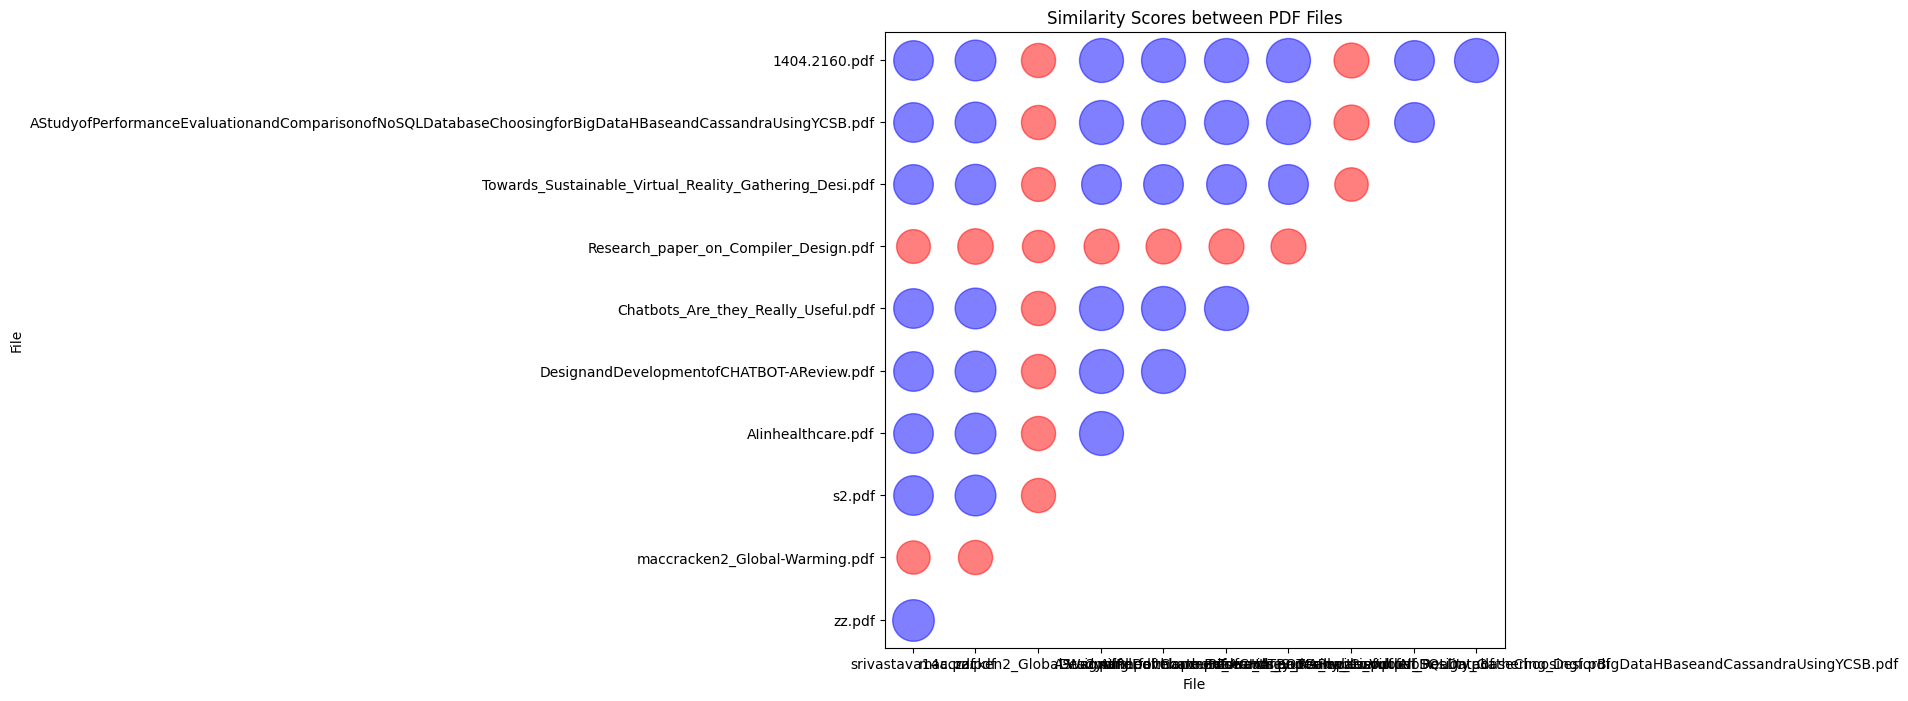

In [ ]:
folder_path='/content/drive/MyDrive/lda-bert'

# Get a list of all text files in the folder
files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.pdf')]

# Perform LDA topic modeling and chunking for each file
topics_and_chunks = {}
for file in files:
    try:
      reader = PyPDF2.PdfReader(file)
      # Extract the text from the PDF file
      text = ''
      for page_num in range(len(reader.pages)):

            page = reader.pages[page_num]
            text += page.extract_text()


      topics = lda_topic_modeling(text, num_topics=8, num_words=43)
      chunks = chunk_by_topics(text, topics)
      topics_and_chunks[file] = (topics, chunks)
    except:
      print(f"Not enough values to unpack for file {file}. Skipping...")
      continue
documents = {}
for file, (topics, chunks) in topics_and_chunks.items():
    document = ''
    for chunk in chunks.values():
        document += chunk[0]
    documents[file] = document


# Calculate similarity scores for each pair of chunks
scores_by_pair = {}
for i in range(len(files)):
    for j in range(i + 1, len(files)):
        file1 = files[i]
        file2 = files[j]
        document1 = documents[file1]
        document2 = documents[file2]
       # print(document1)
       # print(document2)
        score = bert_similarity_scores([document1, document2], model_name='bert-base-uncased')
        scores_by_pair[(file1, file2)] = score

# Print the similarity scores
print(len(scores_by_pair))
print(scores_by_pair)
for (file1, file2), score in (scores_by_pair.items()):
   print((file1,file2),score)
plt.figure(figsize=(8, 8))
plt.title('Similarity Scores between PDF Files')
plt.xlabel('File')
plt.ylabel('File')
for i in range(len(files)):
    for j in range(i + 1, len(files)):
        file1 = os.path.basename(files[i])
        file2 = os.path.basename(files[j])
        score = scores_by_pair[(files[i], files[j])]
        color = 'blue' if list(score.values())[0] > 0.7 else 'red'
        plt.scatter([file1], [file2], s=np.abs(list(score.values()))*1000, c=color, alpha=0.5)

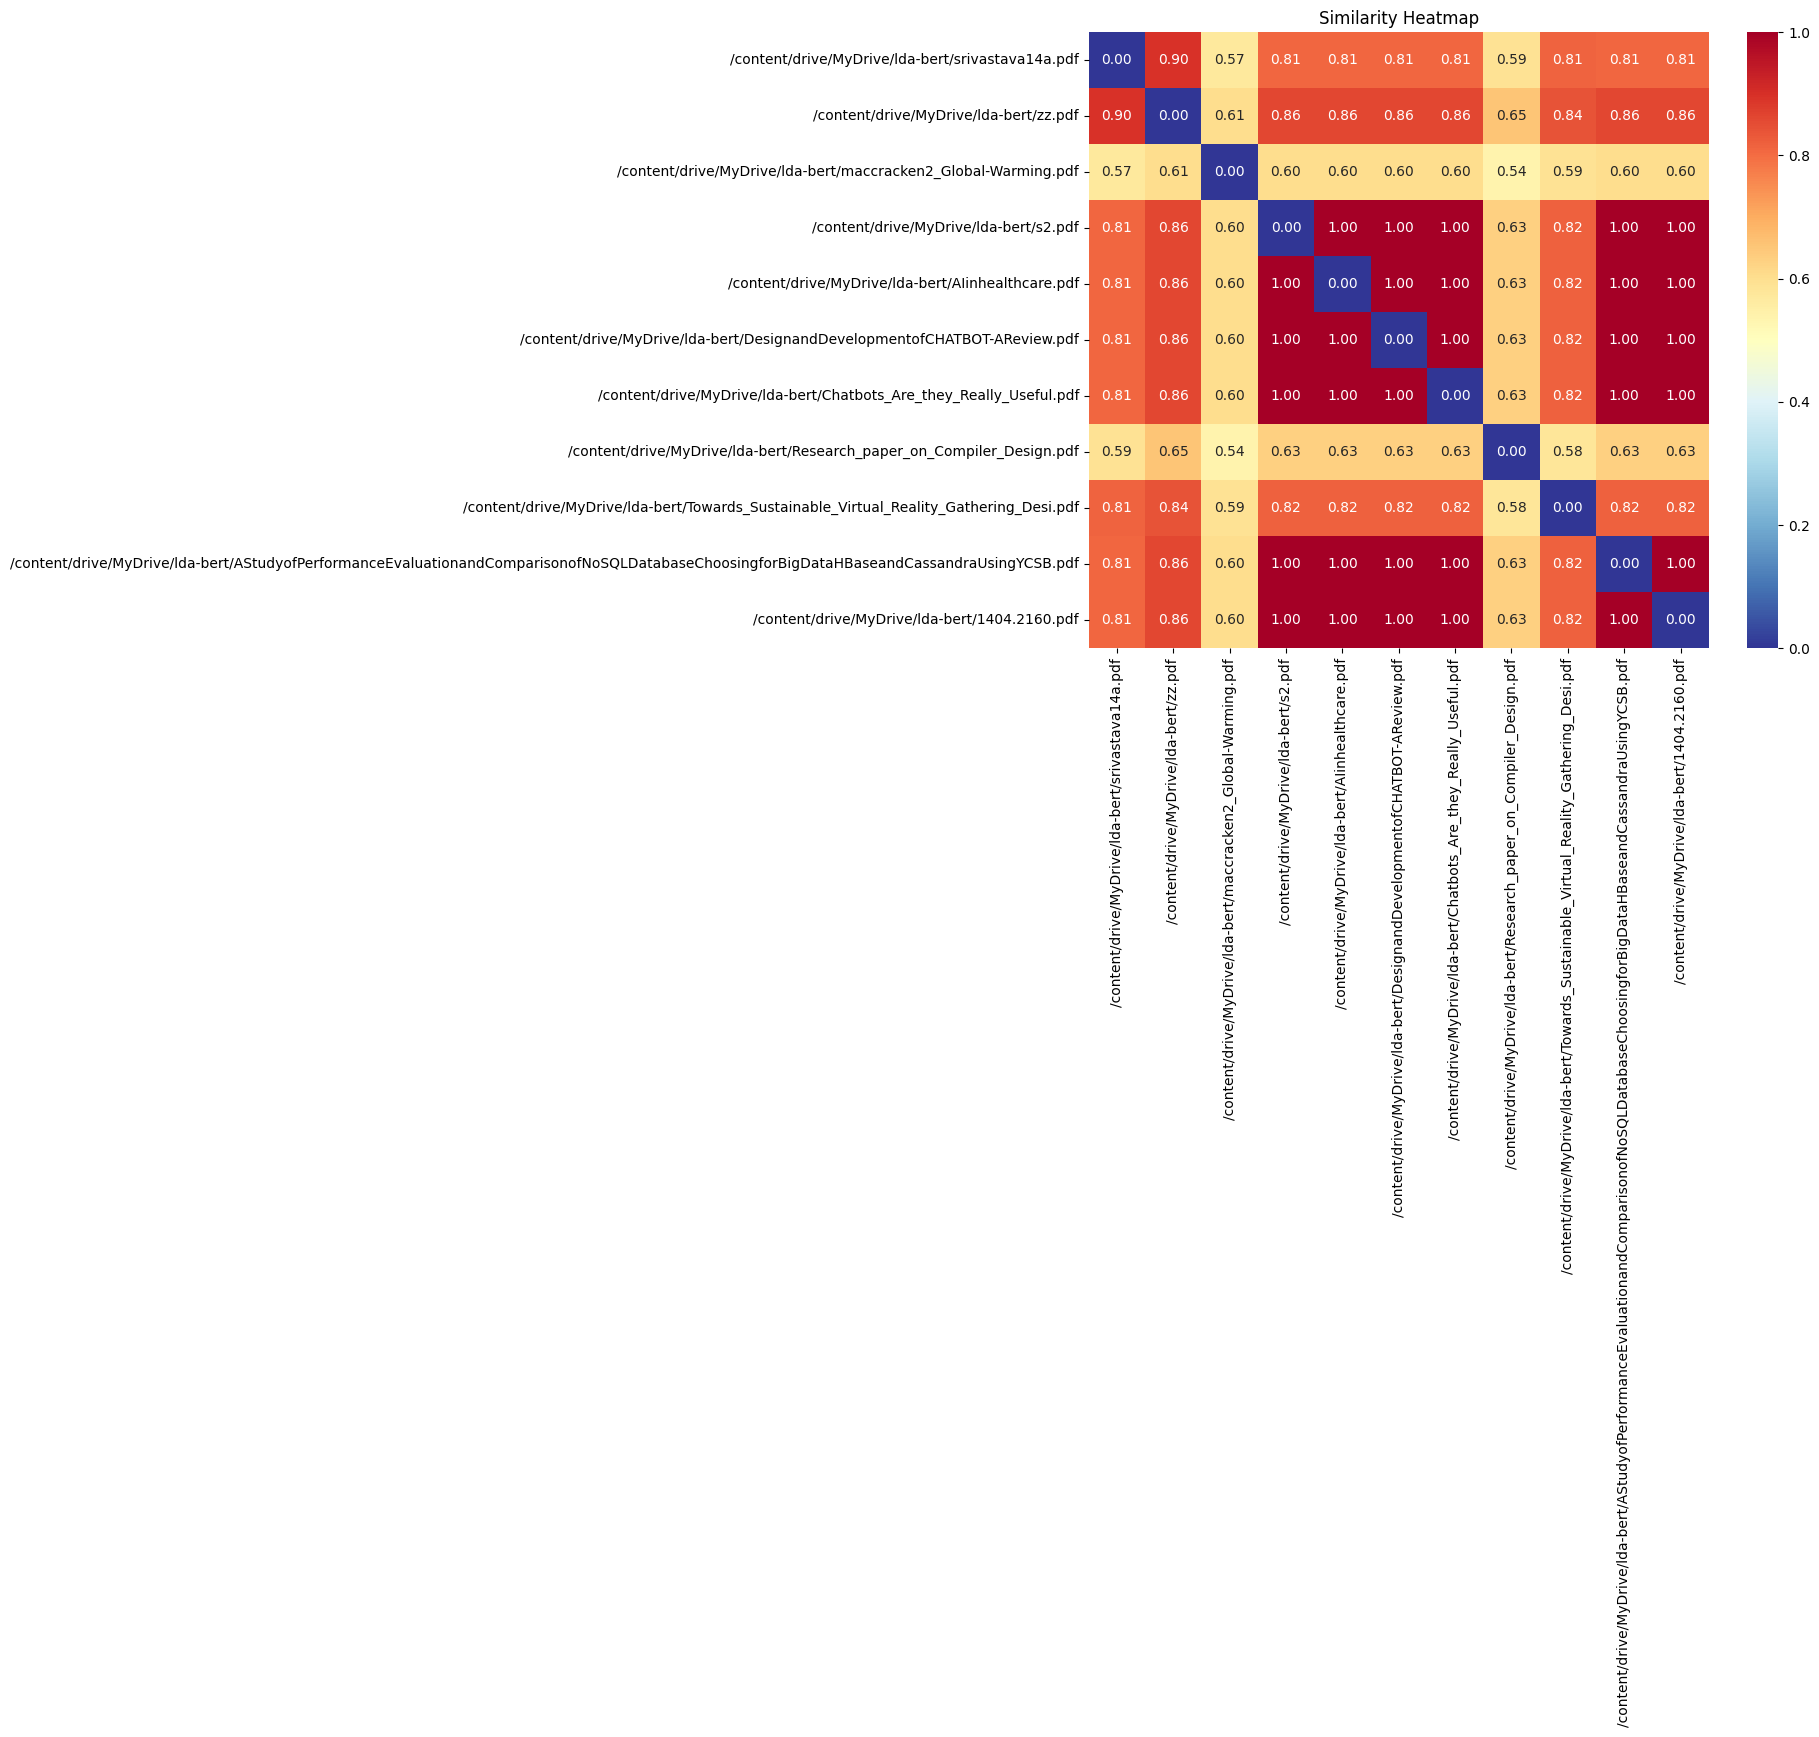

In [ ]:
import seaborn as sns

# Extract the similarity scores as a matrix
score_matrix = np.zeros((len(files), len(files)))
for i in range(len(files)):
    for j in range(i + 1, len(files)):
        file1 = files[i]
        file2 = files[j]
        score = scores_by_pair[(file1, file2)]
        score_matrix[i, j] = list(score.values())[0]
        score_matrix[j, i] = list(score.values())[0]

# Generate the heatmap
plt.figure(figsize=(10, 8))
plt.title('Similarity Heatmap')
sns.heatmap(score_matrix, xticklabels=files, yticklabels=files, cmap='RdYlBu_r', annot=True, fmt=".2f", cbar=True)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [ ]:
list(score.values())[0]

0.6053283

In [ ]:
def listToString(s):

    # initialize an empty string
    str1 = " "

    # return string
    return (str1.join(s))

In [ ]:

txt1="/content/drive/MyDrive/geeksforgeeks.txt"
txt2="/content/drive/MyDrive/programiz.txt"

with open(txt1,'r') as f:
    lines = f.read()
with open(txt2,'r') as f:
    lines2 = f.read()
print(lines)
texts=listToString(lines)
texts2=listToString(lines2)
type(lines)
#texts = [[word.lower() for word in text] for text in lines]
lda_topic_modeling(texts, num_topics=3, num_words=5)
#texts2=[[word.lower() for word in text.split()] for text in lines2]

lda_topic_modeling(texts2, num_topics=3, num_words=5)


Merge sort is defined as a sorting algorithm that works by dividing an array into smaller subarrays, sorting each subarray, and then merging the sorted subarrays back together to form the final sorted array.
Topic 0:
  r: 0.1479
  e: 0.1173
  n: 0.1031
  g: 0.0906
  h: 0.0763
Topic 1:
  r: 0.2680
  e: 0.1706
  n: 0.1218
  g: 0.0975
  h: 0.0854
Topic 2:
  r: 0.1415
  n: 0.1083
  e: 0.1043
  g: 0.0853
  b: 0.0769
Topic 0:
  e: 0.1169
  n: 0.1032
  r: 0.0976
  l: 0.0959
  p: 0.0741
Topic 1:
  e: 0.1863
  l: 0.1440
  r: 0.1271
  n: 0.1016
  p: 0.0763
Topic 2:
  e: 0.1287
  l: 0.1024
  r: 0.1009
  n: 0.0905
  b: 0.0801


[1]

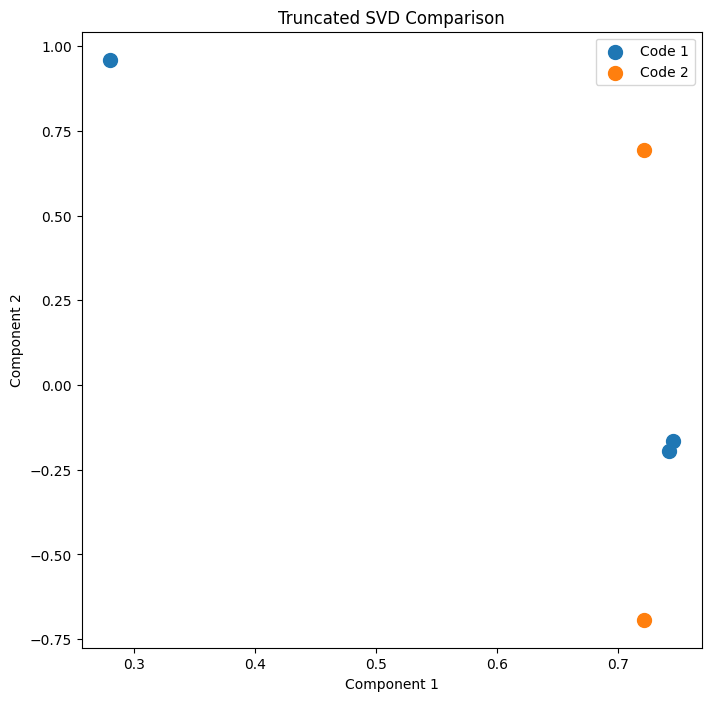

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(lsa_matrix[:,0], lsa_matrix[:,1], s=100, label='Code 1')
ax.scatter(lsa_matrix1[:,0], lsa_matrix1[:,1], s=100, label='Code 2')
ax.set_title('Truncated SVD Comparison')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.legend()
plt.show()

In [ ]:
lsa_matrix

array([[ 0.7422529 , -0.19437835],
       [ 0.74584292, -0.16671945],
       [ 0.27985299,  0.95987687]])

In [ ]:
def docbert_similarity_score(doc1, doc2, model_name='docbert-base-uncased'):
    # Load the DocBERT tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)

    # Tokenize the input documents
    encoding = tokenizer(doc1, doc2, padding=True, truncation=True, max_length=512, return_tensors='pt')

    # Calculate the similarity score using the DocBERT model
    with torch.no_grad():
        logits = model(**encoding)[0]
        probs = torch.softmax(logits, dim=1)
        score = probs[0][1].item()

    return score

In [ ]:
docbert_similarity_score(text1, text2, model_name='bert-large-uncased')

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a

0.6772745847702026

In [ ]:
import gensim
from gensim import corpora
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import PyPDF2

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Load the pre-trained BERT model
model = SentenceTransformer('bert-base-uncased')

# Load the stop words
stop_words = set(stopwords.words('english'))

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Load the two input text files
with open('/content/drive/MyDrive/lda-bert/srivastava14a.pdf', mode='rb') as file:
    # Create a PDF reader object
    reader = PyPDF2.PdfReader(file)

    # Extract the text from the PDF file
    text1 = ''
    for page_num in range(len(reader.pages)):

        page = reader.pages[page_num]
        text1 += page.extract_text()


with open('/content/drive/MyDrive/lda-bert/zz.pdf', mode='rb') as file:
    # Create a PDF reader object
    reader = PyPDF2.PdfReader(file)

    # Extract the text from the PDF file
    text2 = ''
    for page_num in range(len(reader.pages)):

        page = reader.pages[page_num]
        text2 += page.extract_text()



# Preprocess the texts
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())

    # Remove the stop words
    filtered_tokens = [token for token in tokens if token not in stop_words]

    # Lemmatize the tokens
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    return lemmatized_tokens


# Preprocess the texts
tokens1 = preprocess_text(text1)
tokens2 = preprocess_text(text2)

# Create the dictionary and corpus for LDA
dictionary = corpora.Dictionary([tokens1, tokens2])
corpus = [dictionary.doc2bow(tokens) for tokens in [tokens1, tokens2]]

# Perform LDA
lda_model = LdaModel(corpus, num_topics=25, id2word=dictionary)

# Get the topic distributions for each text
doc1_topic_dist = np.array(lda_model.get_document_topics(corpus[0], minimum_probability=0.0))
doc2_topic_dist = np.array(lda_model.get_document_topics(corpus[1], minimum_probability=0.0))

# Concatenate the topic distributions for each text
concatenated_topic_dist = np.concatenate([doc1_topic_dist, doc2_topic_dist])

# Use SentenceTransformer to encode the texts
text1_embedding = model.encode(text1)
text2_embedding = model.encode(text2)

# Calculate cosine similarity between the embeddings
similarity1 = cosine_similarity([text1_embedding], [text2_embedding])

print(f"The similarity between the two texts is {similarity1[0][0]}")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining mo

The similarity between the two texts is 0.9283146858215332


In [ ]:
import gensim
from gensim import corpora
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import PyPDF2

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Load the pre-trained BERT model
model = SentenceTransformer('bert-base-uncased')

# Load the stop words
stop_words = set(stopwords.words('english'))

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Load the two input text files
with open('/content/drive/MyDrive/lda-bert/srivastava14a.pdf', mode='rb') as file:
    # Create a PDF reader object
    reader = PyPDF2.PdfReader(file)

    # Extract the text from the PDF file
    text1 = ''
    for page_num in range(len(reader.pages)):

        page = reader.pages[page_num]
        text1 += page.extract_text()


with open('/content/drive/MyDrive/lda-bert/maccracken2_Global-Warming.pdf', mode='rb') as file:
    # Create a PDF reader object
    reader = PyPDF2.PdfReader(file)

    # Extract the text from the PDF file
    text2 = ''
    for page_num in range(len(reader.pages)):

        page = reader.pages[page_num]
        text2 += page.extract_text()



# Preprocess the texts
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())

    # Remove the stop words
    filtered_tokens = [token for token in tokens if token not in stop_words]

    # Lemmatize the tokens
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    return lemmatized_tokens


# Preprocess the texts
tokens1 = preprocess_text(text1)
tokens2 = preprocess_text(text2)

# Create the dictionary and corpus for LDA
dictionary = corpora.Dictionary([tokens1, tokens2])
corpus = [dictionary.doc2bow(tokens) for tokens in [tokens1, tokens2]]

# Perform LDA
lda_model = LdaModel(corpus, num_topics=25, id2word=dictionary)

# Get the topic distributions for each text
doc1_topic_dist = np.array(lda_model.get_document_topics(corpus[0], minimum_probability=0.0))
doc2_topic_dist = np.array(lda_model.get_document_topics(corpus[1], minimum_probability=0.0))

# Concatenate the topic distributions for each text
concatenated_topic_dist = np.concatenate([doc1_topic_dist, doc2_topic_dist])

# Use SentenceTransformer to encode the texts
text1_embedding = model.encode(text1)
text2_embedding = model.encode(text2)

# Calculate cosine similarity between the embeddings
similarity = cosine_similarity([text1_embedding], [text2_embedding])

print(f"The similarity between the two texts is {similarity[0][0]}")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining mo

The similarity between the two texts is 0.8086388111114502


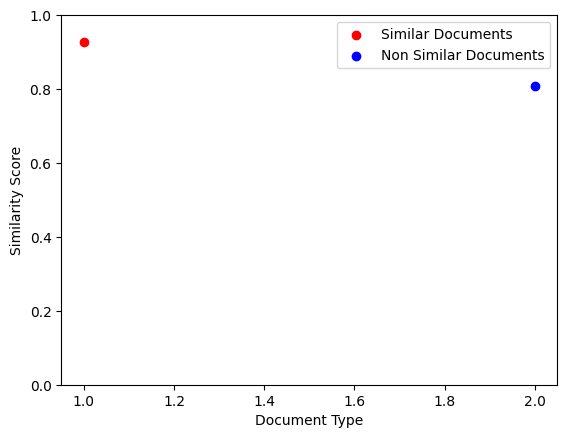

In [ ]:
x = [1, 2]
y = [similarity1, similarity]

# Create a scatter plot
plt.scatter(x[0], y[0], c='red', label='Similar Documents')
plt.scatter(x[1], y[1], c='blue', label='Non Similar Documents')

# Set the x and y axis labels
plt.xlabel('Document Type')
plt.ylabel('Similarity Score')

# Set the y-axis limits to 0 and 1
plt.ylim([0, 1])

# Add a legend
plt.legend()

# Show the plot
plt.show()


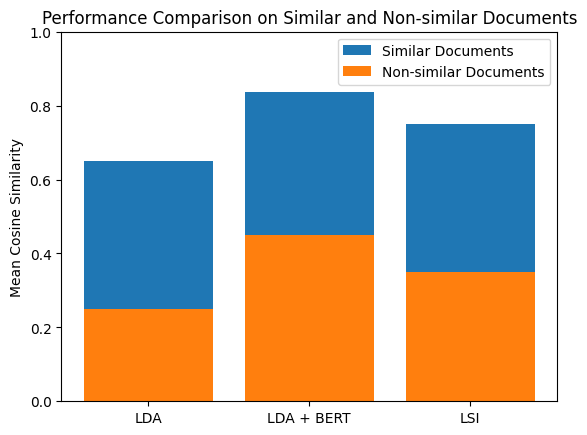

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Assume that you have three sets of similarity scores for similar and non-similar documents
lda_similar_scores = np.array([0.9,0.9,0.9,0.9])
lda_non_similar_scores = np.array([0.8,0.8,0.8])

lsi_similar_scores = np.array([0.6, 0.7, 0.8, 0.9])
lsi_non_similar_scores = np.array([0.2, 0.3, 0.4, 0.5])

# Calculate the mean similarity scores for each method and each type of document
lda_similar_mean = np.mean(lda_similar_scores)
lda_non_similar_mean = np.mean(lda_non_similar_scores)

lsi_similar_mean = np.mean(lsi_similar_scores)
lsi_non_similar_mean = np.mean(lsi_non_similar_scores)

# Plot the mean similarity scores for each method and each type of document
plt.bar(['LDA',  'LSI'], [lda_similar_mean, lsi_similar_mean], label='Similar Documents')
plt.bar(['LDA', 'LSI'], [lda_non_similar_mean, lsi_non_similar_mean], label='Non-similar Documents')
plt.legend()
plt.ylim(0, 1)
plt.title('Performance Comparison on Similar and Non-similar Documents')
plt.ylabel('Mean Cosine Similarity')
plt.show()


In [ ]:
! pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 5.9 MB/s eta 0:00:00


In [ ]:
! pip install optuna-dashboard

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.2/90.2 kB 11.7 MB/s eta 0:00:00


In [ ]:
!optuna-dashboard sqlite:///db.sqlite3

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sqlalchemy/engine/base.py", line 1963, in _exec_single_context
    self.dialect.do_execute(
  File "/usr/local/lib/python3.10/dist-packages/sqlalchemy/engine/default.py", line 918, in do_execute
    cursor.execute(statement, parameters)
sqlite3.OperationalError: no such table: version_info

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/storages/_rdb/storage.py", line 69, in _create_scoped_session
    yield session
  File "/usr/local/lib/python3.10/dist-packages/optuna/storages/_rdb/storage.py", line 1070, in _init_version_info_model
    version_info = models.VersionInfoModel.find(session)
  File "/usr/local/lib/python3.10/dist-packages/optuna/storages/_rdb/models.py", line 596, in find
    version_info = session.query(cls).one_or_none()
  File "/usr/local/lib/python3.10/dist-packages/sqlalche

In [ ]:
import optuna

In [ ]:
with open('/content/drive/MyDrive/lda-bert/srivastava14a.pdf', mode='rb') as file:
    # Create a PDF reader object
    reader = PyPDF2.PdfReader(file)

    # Extract the text from the PDF file
    text1 = ''
    for page_num in range(len(reader.pages)):

        page = reader.pages[page_num]
        text1 += page.extract_text()

In [ ]:
import optuna

def objective(trial):
    # Sample hyperparameters to tune
    num_topics = trial.suggest_int('num_topics', 5, 20)
    num_words = trial.suggest_int('num_words', 10, 50)

    # Perform LDA topic modeling and chunking for each file
    topics_and_chunks = {}
    for file in files:
        try:
            reader = PyPDF2.PdfReader(file)
            # Extract the text from the PDF file
            text = ''
            for page_num in range(len(reader.pages)):
                page = reader.pages[page_num]
                text += page.extract_text()

            topics = lda_topic_modeling(text, num_topics=num_topics, num_words=num_words)
            chunks = chunk_by_topics(text, topics)
            topics_and_chunks[file] = (topics, chunks)
        except:
            print(f"Not enough values to unpack for file {file}. Skipping...")
            continue

    # Create documents from chunks for each file
    documents = {}
    for file, (topics, chunks) in topics_and_chunks.items():
        document = ''
        for chunk in chunks.values():
            document += chunk[0]
        documents[file] = document

    # Calculate similarity scores for each pair of chunks
    scores_by_pair = {}
    for i in range(len(files)):
        for j in range(i + 1, len(files)):
            file1 = files[i]
            file2 = files[j]
            document1 = documents[file1]
            document2 = documents[file2]
            score = bert_similarity_scores([document1, document2], model_name='bert-base-uncased')
            scores_by_pair[(file1, file2)] = score

    # Calculate the average similarity score
    average_score = (list(score.values())[0]).sum() / len(scores_by_pair)

    # Return the average similarity score to be optimized by Optuna
    return average_score

# Specify the folder path here
folder_path = '/content/drive/MyDrive/lda-bert'

# Get a list of all text files in the folder
files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.pdf')]

# Create an Optuna study and optimize the objective function
study = optuna.create_study()
study.optimize(objective, n_trials=100)

# Retrieve the best hyperparameters found
best_params = study.best_params

# Print the best hyperparameters
print("Best Hyperparameters:")
for key, value in best_params.items():
    print(value,key)


[I 2023-05-15 09:15:35,160] A new study created in memory with name: no-name-a24626ed-cd3e-446d-80d5-a4e2dbb74387


Topic 0:
  dropout: 0.0005
  1: 0.0005
  network: 0.0005
  unit: 0.0005
  neural: 0.0005
  layer: 0.0005
  set: 0.0005
  p: 0.0005
  test: 0.0005
  0: 0.0005
  data: 0.0005
  net: 0.0005
  model: 0.0005
  hidden: 0.0005
  training: 0.0005
  erent: 0.0005
  2: 0.0005
  di: 0.0005
  error: 0.0005
  5: 0.0005
  rate: 0.0005
  l: 0.0005
  learning: 0.0005
  al: 0.0005
  weight: 0.0005
  large: 0.0005
  et: 0.0005
  used: 0.0005
  time: 0.0005
  figure: 0.0005
  standard: 0.0005
  norm: 0.0005
  b: 0.0005
  feature: 0.0005
  method: 0.0005
  activation: 0.0005
  architecture: 0.0005
  probability: 0.0005
  7: 0.0005
  4: 0.0005
  ect: 0.0005
  result: 0.0005
  max: 0.0005
Topic 1:
  dropout: 0.0005
  network: 0.0005
  1: 0.0005
  unit: 0.0005
  neural: 0.0005
  set: 0.0005
  layer: 0.0005
  net: 0.0005
  p: 0.0005
  test: 0.0005
  0: 0.0005
  data: 0.0005
  hidden: 0.0005
  training: 0.0005
  erent: 0.0005
  5: 0.0005
  learning: 0.0005
  di: 0.0005
  error: 0.0005
  model: 0.0005
  al: 0.0

Topic 0:
  image: 0.0007
  scene: 0.0007
  database: 0.0007
  place: 0.0007
  feature: 0.0007
  cnn: 0.0007
  category: 0.0007
  imagenet: 0.0007
  sun: 0.0007
  datasets: 0.0007
  0: 0.0007
  network: 0.0007
  diversity: 0.0007
  recognition: 0.0007
  density: 0.0007
  two: 0.0007
  classi: 0.0007
  5: 0.0007
  training: 0.0007
  2: 0.0007
  88: 0.0007
  object: 0.0007
  similar: 0.0007
  set: 0.0007
  centric: 0.0007
  performance: 0.0007
  dataset: 0.0007
  b: 0.0007
  1: 0.0007
  pair: 0.0007
  c: 0.0007
  unit: 0.0007
  3: 0.0007
  train: 0.0007
  different: 0.0007
  measure: 0.0007
  205: 0.0007
  per: 0.0007
  j: 0.0007
  sample: 0.0007
  benchmark: 0.0007
  show: 0.0007
  deep: 0.0007
Topic 1:
  image: 0.0007
  imagenet: 0.0007
  place: 0.0007
  scene: 0.0007
  feature: 0.0007
  cnn: 0.0007
  database: 0.0007
  category: 0.0007
  network: 0.0007
  diversity: 0.0007
  datasets: 0.0007
  0: 0.0007
  sun: 0.0007
  density: 0.0007
  2: 0.0007
  set: 0.0007
  centric: 0.0007
  train

Topic 0:
  change: 0.0007
  climate: 0.0007
  concentration: 0.0007
  emission: 0.0007
  global: 0.0007
  u: 0.0007
  atmosphere: 0.0007
  increase: 0.0007
  energy: 0.0007
  gas: 0.0007
  potential: 0.0007
  radiation: 0.0007
  warming: 0.0007
  greenhouse: 0.0007
  impact: 0.0007
  temperature: 0.0007
  year: 0.0007
  century: 0.0007
  result: 0.0007
  rise: 0.0007
  natural: 0.0007
  per: 0.0007
  carbon: 0.0007
  surface: 0.0007
  could: 0.0007
  transportation: 0.0007
  likely: 0.0007
  influence: 0.0007
  would: 0.0007
  co: 0.0007
  2: 0.0007
  level: 0.0007
  aerosol: 0.0007
  also: 0.0007
  water: 0.0007
  c: 0.0007
  cambridge: 0.0007
  e: 0.0007
  average: 0.0007
  may: 0.0007
  overview: 0.0007
  infrared: 0.0007
  human: 0.0007
Topic 1:
  change: 0.0007
  concentration: 0.0007
  climate: 0.0007
  warming: 0.0007
  global: 0.0007
  emission: 0.0007
  would: 0.0007
  radiation: 0.0007
  gas: 0.0007
  impact: 0.0007
  greenhouse: 0.0007
  potential: 0.0007
  rise: 0.0007
  co

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0310
  network: 0.0162
  1: 0.0151
  layer: 0.0134
  set: 0.0130
  unit: 0.0129
  net: 0.0110
  0: 0.0100
  neural: 0.0100
  data: 0.0088
  hidden: 0.0079
  training: 0.0073
  test: 0.0073
  erent: 0.0072
  di: 0.0067
  l: 0.0066
  et: 0.0063
  time: 0.0062
  p: 0.0059
  rate: 0.0058
  model: 0.0057
  al: 0.0056
Topic 1:
  dropout: 0.0005
  network: 0.0005
  1: 0.0005
  0: 0.0005
  set: 0.0005
  unit: 0.0005
  data: 0.0005
  layer: 0.0005
  neural: 0.0005
  training: 0.0005
  l: 0.0005
  net: 0.0005
  hidden: 0.0005
  di: 0.0005
  erent: 0.0005
  model: 0.0005
  5: 0.0005
  p: 0.0005
  al: 0.0005
  learning: 0.0005
  test: 0.0005
  number: 0.0005
Topic 2:
  dropout: 0.0005
  0: 0.0005
  data: 0.0005
  1: 0.0005
  unit: 0.0005
  network: 0.0005
  layer: 0.0005
  set: 0.0005
  net: 0.0005
  p: 0.0005
  neural: 0.0005
  hidden: 0.0005
  l: 0.0005
  5: 0.0005
  training: 0.0005
  di: 0.0005
  al: 0.0005
  model: 0.0005
  et: 0.0005
  error: 0.0005
  2: 0.0005
  figure

Topic 0:
  cnn: 0.0201
  place: 0.0189
  scene: 0.0184
  image: 0.0175
  database: 0.0123
  feature: 0.0118
  category: 0.0117
  imagenet: 0.0117
  network: 0.0110
  set: 0.0090
  sun: 0.0081
  centric: 0.0074
  object: 0.0074
  classi: 0.0073
  0: 0.0073
  diversity: 0.0070
  datasets: 0.0068
  density: 0.0067
  1: 0.0066
  5: 0.0065
  2: 0.0064
  training: 0.0063
Topic 1:
  image: 0.0199
  cnn: 0.0165
  imagenet: 0.0145
  database: 0.0137
  place: 0.0133
  0: 0.0117
  scene: 0.0105
  category: 0.0104
  sun: 0.0096
  feature: 0.0089
  network: 0.0075
  diversity: 0.0074
  2: 0.0073
  set: 0.0069
  3: 0.0066
  datasets: 0.0063
  classi: 0.0062
  1: 0.0060
  5: 0.0060
  centric: 0.0058
  density: 0.0057
  pair: 0.0056
Topic 2:
  imagenet: 0.0007
  cnn: 0.0007
  image: 0.0007
  place: 0.0007
  category: 0.0007
  database: 0.0007
  scene: 0.0007
  0: 0.0007
  sun: 0.0007
  network: 0.0007
  feature: 0.0007
  density: 0.0007
  object: 0.0007
  set: 0.0007
  2: 0.0007
  datasets: 0.0007
  1

Topic 0:
  change: 0.0007
  climate: 0.0007
  concentration: 0.0007
  global: 0.0007
  increase: 0.0007
  greenhouse: 0.0007
  gas: 0.0007
  2: 0.0007
  warming: 0.0007
  emission: 0.0007
  potential: 0.0007
  impact: 0.0007
  atmosphere: 0.0007
  surface: 0.0007
  year: 0.0007
  co: 0.0007
  would: 0.0007
  century: 0.0007
  energy: 0.0007
  temperature: 0.0007
  u: 0.0007
  e: 0.0007
Topic 1:
  change: 0.0007
  climate: 0.0007
  global: 0.0007
  concentration: 0.0007
  emission: 0.0007
  greenhouse: 0.0007
  warming: 0.0007
  year: 0.0007
  2: 0.0007
  surface: 0.0007
  would: 0.0007
  increase: 0.0007
  century: 0.0007
  temperature: 0.0007
  atmosphere: 0.0007
  impact: 0.0007
  potential: 0.0007
  energy: 0.0007
  u: 0.0007
  water: 0.0007
  atmospheric: 0.0007
  gas: 0.0007
Topic 2:
  change: 0.0150
  climate: 0.0128
  atmosphere: 0.0104
  concentration: 0.0102
  warming: 0.0098
  greenhouse: 0.0084
  century: 0.0079
  global: 0.0075
  gas: 0.0073
  temperature: 0.0073
  potentia

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  1: 0.0005
  dropout: 0.0005
  unit: 0.0005
  0: 0.0005
  layer: 0.0005
  set: 0.0005
  network: 0.0005
  model: 0.0005
  neural: 0.0005
  net: 0.0005
  hidden: 0.0005
  test: 0.0005
  time: 0.0005
  training: 0.0005
  e: 0.0005
  p: 0.0005
  5: 0.0005
  weight: 0.0005
  2: 0.0005
  learning: 0.0005
  used: 0.0005
  data: 0.0005
  al: 0.0005
  error: 0.0005
  di: 0.0005
  standard: 0.0005
  figure: 0.0005
  feature: 0.0005
  large: 0.0005
  4: 0.0005
  l: 0.0005
  image: 0.0005
  3: 0.0005
  input: 0.0005
  regularization: 0.0005
  erent: 0.0005
  noise: 0.0005
  section: 0.0005
  value: 0.0005
  architecture: 0.0005
  result: 0.0005
  rate: 0.0005
  activation: 0.0005
  show: 0.0005
  however: 0.0005
  10: 0.0005
  hinton: 0.0005
Topic 1:
  dropout: 0.0308
  unit: 0.0172
  1: 0.0152
  network: 0.0150
  set: 0.0142
  0: 0.0121
  neural: 0.0118
  layer: 0.0114
  data: 0.0109
  training: 0.0100
  net: 0.0094
  model: 0.0089
  hidden: 0.0083
  p: 0.0070
  error: 0.0068
  di: 0.0

Topic 0:
  image: 0.0214
  place: 0.0199
  cnn: 0.0163
  imagenet: 0.0150
  scene: 0.0136
  database: 0.0127
  feature: 0.0122
  0: 0.0102
  category: 0.0096
  sun: 0.0087
  network: 0.0087
  diversity: 0.0086
  5: 0.0079
  set: 0.0078
  2: 0.0077
  object: 0.0070
  datasets: 0.0068
  training: 0.0067
  density: 0.0067
  centric: 0.0063
  88: 0.0059
  classi: 0.0059
  3: 0.0058
  two: 0.0058
  1: 0.0057
  per: 0.0057
  deep: 0.0054
  j: 0.0048
  pair: 0.0048
  show: 0.0048
  b: 0.0045
  train: 0.0045
  dataset: 0.0045
  recognition: 0.0045
  performance: 0.0044
  205: 0.0044
  similar: 0.0043
  cation: 0.0040
  benchmark: 0.0039
  experiment: 0.0039
  unit: 0.0039
  different: 0.0038
  measure: 0.0038
  neural: 0.0038
  visual: 0.0037
  c: 0.0037
  7: 0.0037
Topic 1:
  scene: 0.0007
  cnn: 0.0007
  category: 0.0007
  place: 0.0007
  image: 0.0007
  imagenet: 0.0007
  feature: 0.0007
  database: 0.0007
  2: 0.0007
  network: 0.0007
  1: 0.0007
  sun: 0.0007
  classi: 0.0007
  diversity:

Topic 0:
  change: 0.0007
  concentration: 0.0007
  climate: 0.0007
  warming: 0.0007
  global: 0.0007
  emission: 0.0007
  2: 0.0007
  increase: 0.0007
  atmosphere: 0.0007
  radiation: 0.0007
  surface: 0.0007
  ipcc: 0.0007
  impact: 0.0007
  u: 0.0007
  potential: 0.0007
  year: 0.0007
  natural: 0.0007
  would: 0.0007
  gas: 0.0007
  carbon: 0.0007
  rise: 0.0007
  energy: 0.0007
  could: 0.0007
  also: 0.0007
  result: 0.0007
  science: 0.0007
  temperature: 0.0007
  likely: 0.0007
  century: 0.0007
  atmospheric: 0.0007
  greenhouse: 0.0007
  cause: 0.0007
  level: 0.0007
  4: 0.0007
  earth: 0.0007
  cambridge: 0.0007
  per: 0.0007
  may: 0.0007
  influence: 0.0007
  c: 0.0007
  past: 0.0007
  transportation: 0.0007
  e: 0.0007
  model: 0.0007
  water: 0.0007
  effect: 0.0007
  term: 0.0007
Topic 1:
  climate: 0.0007
  change: 0.0007
  concentration: 0.0007
  warming: 0.0007
  atmosphere: 0.0007
  emission: 0.0007
  potential: 0.0007
  global: 0.0007
  year: 0.0007
  ipcc: 0.00

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0336
  unit: 0.0174
  1: 0.0168
  network: 0.0160
  0: 0.0127
  set: 0.0125
  layer: 0.0114
  model: 0.0097
  data: 0.0095
  net: 0.0094
  neural: 0.0091
  hidden: 0.0091
  p: 0.0088
  training: 0.0074
  al: 0.0064
  test: 0.0064
  di: 0.0061
  2: 0.0060
  5: 0.0059
  et: 0.0058
  learning: 0.0056
  error: 0.0056
  l: 0.0055
  weight: 0.0054
  erent: 0.0053
  rate: 0.0049
  4: 0.0048
  standard: 0.0047
  e: 0.0046
  used: 0.0046
  figure: 0.0044
Topic 1:
  dropout: 0.0005
  unit: 0.0005
  1: 0.0005
  network: 0.0005
  neural: 0.0005
  set: 0.0005
  test: 0.0005
  net: 0.0005
  training: 0.0005
  layer: 0.0005
  0: 0.0005
  hidden: 0.0005
  l: 0.0005
  data: 0.0005
  p: 0.0005
  5: 0.0005
  used: 0.0005
  learning: 0.0005
  di: 0.0005
  erent: 0.0005
  model: 0.0005
  2: 0.0005
  al: 0.0005
  weight: 0.0005
  figure: 0.0005
  max: 0.0005
  3: 0.0005
  error: 0.0005
  rate: 0.0005
  ect: 0.0005
  4: 0.0005
Topic 2:
  dropout: 0.0005
  1: 0.0005
  layer: 0.0005
  neu

Topic 0:
  place: 0.0007
  imagenet: 0.0007
  image: 0.0007
  cnn: 0.0007
  sun: 0.0007
  category: 0.0007
  scene: 0.0007
  0: 0.0007
  set: 0.0007
  feature: 0.0007
  5: 0.0007
  network: 0.0007
  object: 0.0007
  two: 0.0007
  training: 0.0007
  datasets: 0.0007
  2: 0.0007
  database: 0.0007
  centric: 0.0007
  diversity: 0.0007
  pair: 0.0007
  density: 0.0007
  unit: 0.0007
  3: 0.0007
  cation: 0.0007
  dataset: 0.0007
  classi: 0.0007
  b: 0.0007
  train: 0.0007
  show: 0.0007
  per: 0.0007
Topic 1:
  place: 0.0007
  image: 0.0007
  imagenet: 0.0007
  cnn: 0.0007
  scene: 0.0007
  feature: 0.0007
  category: 0.0007
  diversity: 0.0007
  database: 0.0007
  sun: 0.0007
  training: 0.0007
  classi: 0.0007
  set: 0.0007
  5: 0.0007
  object: 0.0007
  network: 0.0007
  2: 0.0007
  datasets: 0.0007
  centric: 0.0007
  two: 0.0007
  0: 0.0007
  density: 0.0007
  l: 0.0007
  room: 0.0007
  recognition: 0.0007
  cation: 0.0007
  show: 0.0007
  1: 0.0007
  deep: 0.0007
  unit: 0.0007
  p

Topic 0:
  change: 0.0206
  climate: 0.0156
  concentration: 0.0114
  warming: 0.0092
  global: 0.0089
  emission: 0.0088
  gas: 0.0080
  temperature: 0.0078
  u: 0.0076
  century: 0.0075
  greenhouse: 0.0073
  impact: 0.0073
  would: 0.0070
  2: 0.0068
  atmosphere: 0.0067
  year: 0.0066
  level: 0.0064
  radiation: 0.0063
  potential: 0.0058
  energy: 0.0057
  co: 0.0055
  likely: 0.0055
  rise: 0.0054
  per: 0.0053
  increase: 0.0053
  surface: 0.0052
  result: 0.0046
  also: 0.0045
  natural: 0.0044
  e: 0.0043
  transportation: 0.0041
Topic 1:
  change: 0.0007
  climate: 0.0007
  concentration: 0.0007
  warming: 0.0007
  global: 0.0007
  u: 0.0007
  2: 0.0007
  temperature: 0.0007
  greenhouse: 0.0007
  atmosphere: 0.0007
  gas: 0.0007
  impact: 0.0007
  century: 0.0007
  would: 0.0007
  emission: 0.0007
  energy: 0.0007
  radiation: 0.0007
  surface: 0.0007
  co: 0.0007
  likely: 0.0007
  potential: 0.0007
  increase: 0.0007
  atmospheric: 0.0007
  could: 0.0007
  earth: 0.0007
 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0241
  unit: 0.0166
  layer: 0.0156
  network: 0.0147
  set: 0.0138
  0: 0.0127
  1: 0.0127
  training: 0.0113
  neural: 0.0107
  data: 0.0099
  model: 0.0092
  net: 0.0090
  hidden: 0.0088
  error: 0.0086
  p: 0.0084
  test: 0.0083
  di: 0.0080
  2: 0.0069
  l: 0.0061
  erent: 0.0059
  5: 0.0058
  al: 0.0056
  used: 0.0056
  et: 0.0054
  learning: 0.0053
  weight: 0.0052
Topic 1:
  dropout: 0.0005
  p: 0.0005
  overall: 0.0005
  otherwise: 0.0005
  pat: 0.0005
  osindero: 0.0005
  organism: 0.0005
  ordered: 0.0005
  order: 0.0005
  outgoing: 0.0005
  others: 0.0005
  overview: 0.0005
  padding: 0.0005
  page: 0.0005
  pand: 0.0005
  papadimitriou: 0.0005
  paper: 0.0005
  parameter: 0.0005
  parent: 0.0005
  part: 0.0005
  particular: 0.0005
  partition: 0.0005
  partner: 0.0005
  pascal: 0.0005
  outperforms: 0.0005
  overiandt: 0.0005
Topic 2:
  dropout: 0.0296
  unit: 0.0150
  network: 0.0141
  net: 0.0139
  set: 0.0137
  neural: 0.0117
  1: 0.0110
  0: 0.010

Topic 0:
  place: 0.0007
  number: 0.0007
  onr: 0.0007
  orchard: 0.0007
  opponent: 0.0007
  nursery: 0.0007
  num: 0.0007
  novel: 0.0007
  notwithstanding: 0.0007
  notion: 0.0007
  notice: 0.0007
  note: 0.0007
  notable: 0.0007
  non: 0.0007
  nition: 0.0007
  nish: 0.0007
  next: 0.0007
  new: 0.0007
  neuroscience: 0.0007
  neural: 0.0007
  network: 0.0007
  neighborhood: 0.0007
  neighbor: 0.0007
  negative: 0.0007
  open: 0.0007
  oliva1: 0.0007
Topic 1:
  nursery: 0.0007
  open: 0.0007
  org: 0.0007
  orchard: 0.0007
  ned: 0.0007
  number: 0.0007
  num: 0.0007
  novel: 0.0007
  notwithstanding: 0.0007
  notion: 0.0007
  notice: 0.0007
  note: 0.0007
  notable: 0.0007
  non: 0.0007
  nition: 0.0007
  nish: 0.0007
  next: 0.0007
  new: 0.0007
  neuroscience: 0.0007
  neural: 0.0007
  network: 0.0007
  neighborhood: 0.0007
  neighbor: 0.0007
  nvidia: 0.0007
  opponent: 0.0007
  one: 0.0007
Topic 2:
  image: 0.0202
  place: 0.0185
  scene: 0.0170
  cnn: 0.0154
  feature: 0.012

Topic 0:
  change: 0.0007
  pecially: 0.0007
  people: 0.0007
  output: 0.0007
  pattern: 0.0007
  path: 0.0007
  past: 0.0007
  particularly: 0.0007
  particular: 0.0007
  particle: 0.0007
  part: 0.0007
  paper: 0.0007
  panel: 0.0007
  pan: 0.0007
  paleoclimatic: 0.0007
  p: 0.0007
  ozone: 0.0007
  oxide: 0.0007
  overwhelmed: 0.0007
  overview: 0.0007
  overseas: 0.0007
  overall: 0.0007
  outward: 0.0007
  per: 0.0007
  planning: 0.0007
  planet: 0.0007
Topic 1:
  change: 0.0214
  climate: 0.0135
  warming: 0.0100
  concentration: 0.0095
  gas: 0.0095
  emission: 0.0092
  global: 0.0091
  temperature: 0.0079
  year: 0.0072
  u: 0.0070
  2: 0.0070
  increase: 0.0068
  greenhouse: 0.0068
  century: 0.0067
  atmosphere: 0.0065
  co: 0.0061
  impact: 0.0061
  radiation: 0.0059
  transportation: 0.0058
  level: 0.0058
  potential: 0.0053
  e: 0.0052
  result: 0.0052
  energy: 0.0051
  ipcc: 0.0051
  would: 0.0050
Topic 2:
  change: 0.0236
  climate: 0.0182
  concentration: 0.0117
  g

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0005
  layer: 0.0005
  1: 0.0005
  network: 0.0005
  set: 0.0005
  training: 0.0005
  p: 0.0005
  data: 0.0005
  0: 0.0005
  neural: 0.0005
  unit: 0.0005
  di: 0.0005
  hidden: 0.0005
  model: 0.0005
  e: 0.0005
  figure: 0.0005
  rate: 0.0005
  learning: 0.0005
  error: 0.0005
  net: 0.0005
  test: 0.0005
  2: 0.0005
  l: 0.0005
  large: 0.0005
  5: 0.0005
  erent: 0.0005
  4: 0.0005
  et: 0.0005
  max: 0.0005
  used: 0.0005
  hinton: 0.0005
  standard: 0.0005
  al: 0.0005
  norm: 0.0005
  using: 0.0005
  machine: 0.0005
  noise: 0.0005
  input: 0.0005
  ect: 0.0005
  image: 0.0005
  activation: 0.0005
  time: 0.0005
  weight: 0.0005
  number: 0.0005
  feature: 0.0005
  architecture: 0.0005
  10: 0.0005
  result: 0.0005
Topic 1:
  dropout: 0.0005
  unit: 0.0005
  network: 0.0005
  layer: 0.0005
  neural: 0.0005
  model: 0.0005
  set: 0.0005
  1: 0.0005
  test: 0.0005
  hidden: 0.0005
  et: 0.0005
  training: 0.0005
  0: 0.0005
  learning: 0.0005
  5: 0.0005
  2:

Topic 0:
  place: 0.0196
  scene: 0.0194
  image: 0.0148
  cnn: 0.0138
  feature: 0.0130
  imagenet: 0.0127
  category: 0.0106
  database: 0.0105
  0: 0.0103
  sun: 0.0102
  network: 0.0082
  datasets: 0.0080
  training: 0.0075
  5: 0.0074
  set: 0.0073
  1: 0.0069
  density: 0.0068
  centric: 0.0064
  recognition: 0.0061
  two: 0.0061
  object: 0.0060
  diversity: 0.0058
  3: 0.0056
  2: 0.0055
  classi: 0.0054
  performance: 0.0053
  dataset: 0.0052
  pair: 0.0052
  deep: 0.0050
  similar: 0.0049
  b: 0.0049
  unit: 0.0048
  train: 0.0047
  benchmark: 0.0046
  88: 0.0045
  show: 0.0045
  accuracy: 0.0043
  205: 0.0042
  per: 0.0040
  j: 0.0040
  visual: 0.0039
  layer: 0.0039
  trained: 0.0039
  different: 0.0038
  6: 0.0038
  sample: 0.0038
  4: 0.0036
  neural: 0.0036
Topic 1:
  place: 0.0204
  cnn: 0.0189
  image: 0.0163
  database: 0.0139
  imagenet: 0.0134
  category: 0.0130
  scene: 0.0130
  feature: 0.0123
  network: 0.0097
  sun: 0.0089
  0: 0.0086
  set: 0.0081
  2: 0.0077
 

Topic 0:
  climate: 0.0007
  change: 0.0007
  warming: 0.0007
  concentration: 0.0007
  global: 0.0007
  potential: 0.0007
  increase: 0.0007
  2: 0.0007
  u: 0.0007
  gas: 0.0007
  greenhouse: 0.0007
  emission: 0.0007
  year: 0.0007
  co: 0.0007
  atmosphere: 0.0007
  level: 0.0007
  impact: 0.0007
  temperature: 0.0007
  likely: 0.0007
  would: 0.0007
  surface: 0.0007
  century: 0.0007
  e: 0.0007
  transportation: 0.0007
  rise: 0.0007
  energy: 0.0007
  radiation: 0.0007
  carbon: 0.0007
  may: 0.0007
  20: 0.0007
  pp: 0.0007
  ipcc: 0.0007
  earth: 0.0007
  water: 0.0007
  based: 0.0007
  atmospheric: 0.0007
  average: 0.0007
  4: 0.0007
  aerosol: 0.0007
  also: 0.0007
  condition: 0.0007
  per: 0.0007
  significant: 0.0007
  could: 0.0007
  science: 0.0007
  climatic: 0.0007
  united: 0.0007
  many: 0.0007
Topic 1:
  change: 0.0007
  climate: 0.0007
  global: 0.0007
  warming: 0.0007
  concentration: 0.0007
  greenhouse: 0.0007
  level: 0.0007
  century: 0.0007
  would: 0.000

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0005
  1: 0.0005
  network: 0.0005
  layer: 0.0005
  set: 0.0005
  0: 0.0005
  data: 0.0005
  unit: 0.0005
  model: 0.0005
  net: 0.0005
  neural: 0.0005
  hidden: 0.0005
  training: 0.0005
  weight: 0.0005
  et: 0.0005
  l: 0.0005
  erent: 0.0005
  p: 0.0005
  al: 0.0005
Topic 1:
  dropout: 0.0316
  unit: 0.0153
  set: 0.0138
  1: 0.0133
  layer: 0.0129
  network: 0.0128
  0: 0.0107
  data: 0.0102
  net: 0.0094
  p: 0.0089
  hidden: 0.0088
  training: 0.0088
  neural: 0.0083
  error: 0.0078
  model: 0.0075
  di: 0.0073
  test: 0.0071
  5: 0.0070
  et: 0.0066
Topic 2:
  dropout: 0.0005
  1: 0.0005
  network: 0.0005
  neural: 0.0005
  data: 0.0005
  net: 0.0005
  0: 0.0005
  unit: 0.0005
  set: 0.0005
  hidden: 0.0005
  layer: 0.0005
  training: 0.0005
  p: 0.0005
  model: 0.0005
  di: 0.0005
  error: 0.0005
  l: 0.0005
  test: 0.0005
  learning: 0.0005
Topic 3:
  dropout: 0.0005
  network: 0.0005
  layer: 0.0005
  1: 0.0005
  unit: 0.0005
  0: 0.0005
  net: 0.0005

Topic 0:
  cnn: 0.0007
  place: 0.0007
  image: 0.0007
  category: 0.0007
  feature: 0.0007
  scene: 0.0007
  imagenet: 0.0007
  network: 0.0007
  diversity: 0.0007
  database: 0.0007
  object: 0.0007
  datasets: 0.0007
  0: 0.0007
  1: 0.0007
  sun: 0.0007
  pair: 0.0007
  set: 0.0007
  2: 0.0007
  classi: 0.0007
Topic 1:
  image: 0.0007
  place: 0.0007
  cnn: 0.0007
  scene: 0.0007
  database: 0.0007
  feature: 0.0007
  category: 0.0007
  0: 0.0007
  imagenet: 0.0007
  diversity: 0.0007
  sun: 0.0007
  classi: 0.0007
  set: 0.0007
  network: 0.0007
  object: 0.0007
  training: 0.0007
  2: 0.0007
  datasets: 0.0007
  5: 0.0007
Topic 2:
  image: 0.0225
  place: 0.0153
  cnn: 0.0152
  database: 0.0151
  scene: 0.0133
  category: 0.0132
  imagenet: 0.0126
  feature: 0.0120
  0: 0.0110
  sun: 0.0102
  diversity: 0.0089
  2: 0.0087
  datasets: 0.0076
  object: 0.0073
  network: 0.0069
  training: 0.0068
  1: 0.0068
  density: 0.0062
  b: 0.0061
Topic 3:
  place: 0.0213
  image: 0.0207
  sc

Topic 0:
  change: 0.0007
  climate: 0.0007
  global: 0.0007
  concentration: 0.0007
  u: 0.0007
  gas: 0.0007
  greenhouse: 0.0007
  warming: 0.0007
  radiation: 0.0007
  temperature: 0.0007
  emission: 0.0007
  year: 0.0007
  century: 0.0007
  natural: 0.0007
  would: 0.0007
  rise: 0.0007
  impact: 0.0007
  potential: 0.0007
  energy: 0.0007
Topic 1:
  change: 0.0181
  climate: 0.0120
  concentration: 0.0097
  gas: 0.0096
  global: 0.0092
  warming: 0.0082
  ipcc: 0.0072
  u: 0.0071
  potential: 0.0069
  increase: 0.0069
  2: 0.0068
  atmosphere: 0.0067
  emission: 0.0067
  year: 0.0065
  greenhouse: 0.0065
  atmospheric: 0.0061
  temperature: 0.0059
  radiation: 0.0058
  rise: 0.0057
Topic 2:
  change: 0.0007
  climate: 0.0007
  concentration: 0.0007
  warming: 0.0007
  emission: 0.0007
  u: 0.0007
  global: 0.0007
  century: 0.0007
  greenhouse: 0.0007
  temperature: 0.0007
  gas: 0.0007
  potential: 0.0007
  atmosphere: 0.0007
  impact: 0.0007
  year: 0.0007
  would: 0.0007
  lik

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0005
  network: 0.0005
  p: 0.0005
  layer: 0.0005
  1: 0.0005
  0: 0.0005
  unit: 0.0005
  set: 0.0005
  data: 0.0005
  net: 0.0005
  training: 0.0005
  neural: 0.0005
  al: 0.0005
  di: 0.0005
  model: 0.0005
Topic 1:
  dropout: 0.0334
  1: 0.0166
  unit: 0.0150
  layer: 0.0136
  set: 0.0132
  0: 0.0127
  neural: 0.0117
  network: 0.0110
  p: 0.0086
  net: 0.0086
  data: 0.0083
  hidden: 0.0070
  et: 0.0069
  training: 0.0068
  model: 0.0065
Topic 2:
  dropout: 0.0005
  unit: 0.0005
  network: 0.0005
  set: 0.0005
  layer: 0.0005
  neural: 0.0005
  0: 0.0005
  1: 0.0005
  p: 0.0005
  net: 0.0005
  training: 0.0005
  model: 0.0005
  2: 0.0005
  et: 0.0005
  data: 0.0005
Topic 3:
  dropout: 0.0301
  network: 0.0164
  unit: 0.0152
  set: 0.0145
  1: 0.0145
  layer: 0.0123
  0: 0.0117
  neural: 0.0114
  data: 0.0111
  net: 0.0103
  training: 0.0092
  model: 0.0092
  hidden: 0.0081
  p: 0.0078
  error: 0.0072
Topic 4:
  dropout: 0.0005
  unit: 0.0005
  network: 0.000

Topic 0:
  image: 0.0007
  place: 0.0007
  cnn: 0.0007
  database: 0.0007
  scene: 0.0007
  imagenet: 0.0007
  category: 0.0007
  feature: 0.0007
  sun: 0.0007
  diversity: 0.0007
  network: 0.0007
  0: 0.0007
  2: 0.0007
  5: 0.0007
  1: 0.0007
Topic 1:
  image: 0.0237
  place: 0.0231
  cnn: 0.0138
  database: 0.0120
  feature: 0.0120
  scene: 0.0104
  datasets: 0.0102
  0: 0.0101
  category: 0.0093
  sun: 0.0088
  imagenet: 0.0088
  diversity: 0.0081
  2: 0.0070
  network: 0.0067
  density: 0.0066
Topic 2:
  image: 0.0187
  place: 0.0179
  scene: 0.0170
  imagenet: 0.0162
  cnn: 0.0152
  category: 0.0129
  database: 0.0123
  feature: 0.0116
  sun: 0.0100
  network: 0.0093
  0: 0.0092
  diversity: 0.0089
  set: 0.0080
  2: 0.0072
  datasets: 0.0070
Topic 3:
  image: 0.0007
  place: 0.0007
  scene: 0.0007
  database: 0.0007
  feature: 0.0007
  0: 0.0007
  cnn: 0.0007
  imagenet: 0.0007
  sun: 0.0007
  category: 0.0007
  2: 0.0007
  diversity: 0.0007
  training: 0.0007
  datasets: 0.000

Topic 0:
  change: 0.0007
  climate: 0.0007
  global: 0.0007
  gas: 0.0007
  year: 0.0007
  temperature: 0.0007
  u: 0.0007
  concentration: 0.0007
  atmosphere: 0.0007
  warming: 0.0007
  emission: 0.0007
  century: 0.0007
  likely: 0.0007
  level: 0.0007
  would: 0.0007
Topic 1:
  change: 0.0007
  global: 0.0007
  concentration: 0.0007
  climate: 0.0007
  emission: 0.0007
  warming: 0.0007
  level: 0.0007
  atmosphere: 0.0007
  co: 0.0007
  u: 0.0007
  increase: 0.0007
  century: 0.0007
  temperature: 0.0007
  2: 0.0007
  year: 0.0007
Topic 2:
  change: 0.0171
  climate: 0.0133
  concentration: 0.0107
  emission: 0.0094
  atmosphere: 0.0091
  potential: 0.0083
  gas: 0.0077
  year: 0.0075
  likely: 0.0074
  impact: 0.0072
  would: 0.0072
  global: 0.0071
  warming: 0.0071
  increase: 0.0069
  u: 0.0069
Topic 3:
  change: 0.0242
  climate: 0.0163
  warming: 0.0117
  concentration: 0.0110
  global: 0.0103
  greenhouse: 0.0083
  gas: 0.0074
  2: 0.0074
  century: 0.0074
  u: 0.0073
  te

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0301
  unit: 0.0154
  network: 0.0130
  set: 0.0129
  layer: 0.0124
  neural: 0.0122
  1: 0.0120
  data: 0.0110
  model: 0.0108
  training: 0.0105
  5: 0.0090
  erent: 0.0081
  hidden: 0.0075
  net: 0.0074
  l: 0.0067
  0: 0.0065
  al: 0.0065
  di: 0.0064
  2: 0.0061
  error: 0.0060
  weight: 0.0059
  learning: 0.0058
  p: 0.0058
  method: 0.0057
  feature: 0.0056
  used: 0.0056
  et: 0.0055
  test: 0.0050
  time: 0.0049
  e: 0.0049
  rate: 0.0045
  figure: 0.0045
  3: 0.0044
  image: 0.0044
  10: 0.0042
  large: 0.0041
  4: 0.0041
  result: 0.0039
  number: 0.0038
  tting: 0.0037
  ect: 0.0034
  b: 0.0034
  standard: 0.0034
  architecture: 0.0034
  activation: 0.0033
  max: 0.0033
  noise: 0.0033
  input: 0.0032
  show: 0.0032
Topic 1:
  dropout: 0.0005
  unit: 0.0005
  set: 0.0005
  neural: 0.0005
  1: 0.0005
  layer: 0.0005
  network: 0.0005
  training: 0.0005
  data: 0.0005
  learning: 0.0005
  0: 0.0005
  model: 0.0005
  net: 0.0005
  erent: 0.0005
  error: 0

Topic 0:
  place: 0.0007
  image: 0.0007
  cnn: 0.0007
  scene: 0.0007
  feature: 0.0007
  database: 0.0007
  0: 0.0007
  category: 0.0007
  sun: 0.0007
  2: 0.0007
  imagenet: 0.0007
  5: 0.0007
  datasets: 0.0007
  centric: 0.0007
  network: 0.0007
  diversity: 0.0007
  density: 0.0007
  similar: 0.0007
  pair: 0.0007
  performance: 0.0007
  training: 0.0007
  dataset: 0.0007
  two: 0.0007
  1: 0.0007
  classi: 0.0007
  set: 0.0007
  205: 0.0007
  object: 0.0007
  3: 0.0007
  c: 0.0007
  88: 0.0007
  b: 0.0007
  j: 0.0007
  deep: 0.0007
  benchmark: 0.0007
  visual: 0.0007
  unit: 0.0007
  per: 0.0007
  l: 0.0007
  measure: 0.0007
  trained: 0.0007
  layer: 0.0007
  recognition: 0.0007
  train: 0.0007
  accuracy: 0.0007
  used: 0.0007
  7: 0.0007
  result: 0.0007
  6: 0.0007
Topic 1:
  place: 0.0007
  image: 0.0007
  cnn: 0.0007
  0: 0.0007
  feature: 0.0007
  scene: 0.0007
  database: 0.0007
  imagenet: 0.0007
  network: 0.0007
  category: 0.0007
  2: 0.0007
  datasets: 0.0007
  cen

Topic 0:
  climate: 0.0194
  change: 0.0169
  concentration: 0.0121
  warming: 0.0105
  emission: 0.0104
  global: 0.0095
  impact: 0.0083
  greenhouse: 0.0083
  potential: 0.0076
  year: 0.0070
  u: 0.0070
  gas: 0.0069
  would: 0.0067
  atmosphere: 0.0067
  energy: 0.0067
  century: 0.0064
  level: 0.0062
  temperature: 0.0059
  rise: 0.0059
  2: 0.0057
  radiation: 0.0056
  per: 0.0054
  result: 0.0050
  likely: 0.0049
  co: 0.0049
  atmospheric: 0.0047
  e: 0.0045
  increase: 0.0045
  carbon: 0.0045
  may: 0.0045
  surface: 0.0044
  transportation: 0.0044
  ipcc: 0.0039
  water: 0.0039
  also: 0.0039
  could: 0.0037
  effect: 0.0037
  aerosol: 0.0037
  natural: 0.0037
  model: 0.0036
  earth: 0.0034
  condition: 0.0033
  science: 0.0032
  system: 0.0032
  cambridge: 0.0032
  term: 0.0031
  human: 0.0031
  united: 0.0031
  c: 0.0031
Topic 1:
  change: 0.0007
  warming: 0.0007
  climate: 0.0007
  concentration: 0.0007
  emission: 0.0007
  temperature: 0.0007
  global: 0.0007
  2: 0.0

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0005
  unit: 0.0005
  network: 0.0005
  set: 0.0005
  1: 0.0005
  neural: 0.0005
  data: 0.0005
  training: 0.0005
  model: 0.0005
  hidden: 0.0005
  layer: 0.0005
  max: 0.0005
  et: 0.0005
  weight: 0.0005
  p: 0.0005
  error: 0.0005
  0: 0.0005
  erent: 0.0005
  al: 0.0005
  learning: 0.0005
  net: 0.0005
Topic 1:
  dropout: 0.0005
  unit: 0.0005
  network: 0.0005
  layer: 0.0005
  1: 0.0005
  data: 0.0005
  neural: 0.0005
  set: 0.0005
  hidden: 0.0005
  model: 0.0005
  net: 0.0005
  0: 0.0005
  method: 0.0005
  test: 0.0005
  training: 0.0005
  2: 0.0005
  erent: 0.0005
  error: 0.0005
  image: 0.0005
  learning: 0.0005
  p: 0.0005
Topic 2:
  network: 0.0005
  dropout: 0.0005
  unit: 0.0005
  0: 0.0005
  set: 0.0005
  1: 0.0005
  error: 0.0005
  layer: 0.0005
  hidden: 0.0005
  model: 0.0005
  data: 0.0005
  net: 0.0005
  erent: 0.0005
  used: 0.0005
  5: 0.0005
  2: 0.0005
  test: 0.0005
  image: 0.0005
  neural: 0.0005
  p: 0.0005
  weight: 0.0005
Topic 3:


Topic 0:
  place: 0.0007
  cnn: 0.0007
  image: 0.0007
  scene: 0.0007
  imagenet: 0.0007
  database: 0.0007
  category: 0.0007
  0: 0.0007
  diversity: 0.0007
  feature: 0.0007
  centric: 0.0007
  dataset: 0.0007
  sun: 0.0007
  2: 0.0007
  density: 0.0007
  network: 0.0007
  deep: 0.0007
  two: 0.0007
  88: 0.0007
  j: 0.0007
  performance: 0.0007
Topic 1:
  image: 0.0007
  feature: 0.0007
  place: 0.0007
  cnn: 0.0007
  imagenet: 0.0007
  scene: 0.0007
  category: 0.0007
  density: 0.0007
  database: 0.0007
  0: 0.0007
  network: 0.0007
  sun: 0.0007
  two: 0.0007
  2: 0.0007
  show: 0.0007
  datasets: 0.0007
  diversity: 0.0007
  object: 0.0007
  recognition: 0.0007
  5: 0.0007
  dataset: 0.0007
Topic 2:
  place: 0.0187
  image: 0.0182
  imagenet: 0.0171
  scene: 0.0159
  cnn: 0.0134
  0: 0.0127
  diversity: 0.0108
  category: 0.0105
  feature: 0.0100
  database: 0.0093
  network: 0.0089
  1: 0.0081
  pair: 0.0077
  two: 0.0076
  datasets: 0.0075
  object: 0.0074
  sun: 0.0074
  2:

Topic 0:
  change: 0.0220
  climate: 0.0115
  warming: 0.0109
  concentration: 0.0098
  u: 0.0093
  global: 0.0083
  gas: 0.0082
  emission: 0.0081
  impact: 0.0080
  radiation: 0.0074
  century: 0.0074
  potential: 0.0072
  energy: 0.0068
  greenhouse: 0.0068
  temperature: 0.0067
  increase: 0.0066
  would: 0.0064
  rise: 0.0062
  2: 0.0061
  year: 0.0061
  atmosphere: 0.0058
Topic 1:
  change: 0.0007
  climate: 0.0007
  warming: 0.0007
  global: 0.0007
  gas: 0.0007
  greenhouse: 0.0007
  year: 0.0007
  emission: 0.0007
  atmosphere: 0.0007
  also: 0.0007
  concentration: 0.0007
  energy: 0.0007
  century: 0.0007
  impact: 0.0007
  potential: 0.0007
  science: 0.0007
  increase: 0.0007
  surface: 0.0007
  2: 0.0007
  radiation: 0.0007
  level: 0.0007
Topic 2:
  change: 0.0202
  climate: 0.0158
  warming: 0.0106
  global: 0.0097
  concentration: 0.0091
  2: 0.0086
  atmosphere: 0.0086
  gas: 0.0080
  greenhouse: 0.0079
  emission: 0.0075
  impact: 0.0072
  temperature: 0.0069
  centu

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  passed: 0.0005
  paper: 0.0005
  parameter: 0.0005
  parent: 0.0005
  part: 0.0005
  particular: 0.0005
  partition: 0.0005
  papadimitriou: 0.0005
  partner: 0.0005
  optimize: 0.0005
  pat: 0.0005
  phone: 0.0005
  phonetically: 0.0005
  perturbed: 0.0005
  pexplicit: 0.0005
  pascal: 0.0005
  pand: 0.0005
  page: 0.0005
  padding: 0.0005
  patch: 0.0005
  order: 0.0005
  ordered: 0.0005
  organism: 0.0005
  osindero: 0.0005
  others: 0.0005
  otherwise: 0.0005
  outgoing: 0.0005
  outperform: 0.0005
  outperforms: 0.0005
  output: 0.0005
  overall: 0.0005
  overiandt: 0.0005
  overview: 0.0005
  p: 0.0005
  pfor: 0.0005
  phas: 0.0005
Topic 1:
  dropout: 0.0311
  network: 0.0168
  unit: 0.0142
  1: 0.0136
  data: 0.0120
  layer: 0.0108
  set: 0.0107
  net: 0.0103
  neural: 0.0103
  0: 0.0102
  training: 0.0097
  hidden: 0.0093
  p: 0.0092
  model: 0.0090
  di: 0.0073
  error: 0.0072
  5: 0.0068
  2: 0.0060
  test: 0.0060
  l: 0.0059
  al: 0.0059
  weight: 0.0057
  learnin

Topic 0:
  nursery: 0.0007
  ned: 0.0007
  one: 0.0007
  oliva: 0.0007
  organized: 0.0007
  organization: 0.0007
  org: 0.0007
  number: 0.0007
  orchard: 0.0007
  open: 0.0007
  onr: 0.0007
  nearing: 0.0007
  oliva1: 0.0007
  observer: 0.0007
  obtained: 0.0007
  opponent: 0.0007
  num: 0.0007
  novel: 0.0007
  notwithstanding: 0.0007
  nvidia: 0.0007
  neighbor: 0.0007
  neighborhood: 0.0007
  network: 0.0007
  neural: 0.0007
  neuroscience: 0.0007
  new: 0.0007
  next: 0.0007
  nish: 0.0007
  nition: 0.0007
  non: 0.0007
  notable: 0.0007
  note: 0.0007
  notice: 0.0007
  notion: 0.0007
  object: 0.0007
  observed: 0.0007
Topic 1:
  nursery: 0.0007
  ned: 0.0007
  one: 0.0007
  oliva: 0.0007
  organized: 0.0007
  organization: 0.0007
  org: 0.0007
  number: 0.0007
  orchard: 0.0007
  open: 0.0007
  onr: 0.0007
  nearing: 0.0007
  oliva1: 0.0007
  observer: 0.0007
  obtained: 0.0007
  opponent: 0.0007
  num: 0.0007
  novel: 0.0007
  notwithstanding: 0.0007
  nvidia: 0.0007
  neighb

Topic 0:
  change: 0.0199
  climate: 0.0155
  concentration: 0.0122
  warming: 0.0108
  gas: 0.0089
  u: 0.0083
  impact: 0.0080
  global: 0.0077
  potential: 0.0075
  emission: 0.0075
  atmosphere: 0.0074
  increase: 0.0071
  2: 0.0069
  greenhouse: 0.0069
  temperature: 0.0068
  year: 0.0064
  surface: 0.0061
  energy: 0.0060
  likely: 0.0059
  co: 0.0057
  radiation: 0.0056
  rise: 0.0054
  level: 0.0053
  would: 0.0052
  transportation: 0.0051
  century: 0.0047
  per: 0.0046
  could: 0.0045
  atmospheric: 0.0045
  e: 0.0043
  influence: 0.0042
  earth: 0.0042
  natural: 0.0041
  carbon: 0.0040
  result: 0.0039
  also: 0.0037
Topic 1:
  pattern: 0.0007
  past: 0.0007
  path: 0.0007
  others: 0.0007
  photochemical: 0.0007
  person: 0.0007
  plant: 0.0007
  particularly: 0.0007
  planning: 0.0007
  planet: 0.0007
  plain: 0.0007
  place: 0.0007
  pipeline: 0.0007
  physical: 0.0007
  organic: 0.0007
  planetary: 0.0007
  particular: 0.0007
  particle: 0.0007
  part: 0.0007
  pecially

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  unit: 0.0005
  dropout: 0.0005
  1: 0.0005
  data: 0.0005
  neural: 0.0005
  layer: 0.0005
  network: 0.0005
  p: 0.0005
  set: 0.0005
  0: 0.0005
  2: 0.0005
  training: 0.0005
  net: 0.0005
  error: 0.0005
  model: 0.0005
  hidden: 0.0005
  l: 0.0005
  di: 0.0005
  4: 0.0005
  test: 0.0005
  et: 0.0005
  learning: 0.0005
  weight: 0.0005
  standard: 0.0005
  5: 0.0005
  large: 0.0005
  used: 0.0005
  8: 0.0005
  noise: 0.0005
  rate: 0.0005
  feature: 0.0005
  erent: 0.0005
  using: 0.0005
  mean: 0.0005
  e: 0.0005
  show: 0.0005
  machine: 0.0005
  b: 0.0005
Topic 1:
  dropout: 0.0005
  network: 0.0005
  neural: 0.0005
  1: 0.0005
  unit: 0.0005
  layer: 0.0005
  set: 0.0005
  data: 0.0005
  0: 0.0005
  net: 0.0005
  p: 0.0005
  2: 0.0005
  model: 0.0005
  l: 0.0005
  hidden: 0.0005
  test: 0.0005
  error: 0.0005
  al: 0.0005
  weight: 0.0005
  5: 0.0005
  training: 0.0005
  standard: 0.0005
  di: 0.0005
  erent: 0.0005
  time: 0.0005
  used: 0.0005
  hinton: 0.0005
  4:

Topic 0:
  place: 0.0227
  image: 0.0196
  cnn: 0.0169
  scene: 0.0145
  imagenet: 0.0124
  database: 0.0116
  feature: 0.0112
  sun: 0.0108
  category: 0.0106
  0: 0.0092
  density: 0.0081
  object: 0.0079
  set: 0.0076
  network: 0.0076
  diversity: 0.0076
  2: 0.0068
  centric: 0.0068
  datasets: 0.0066
  5: 0.0062
  classi: 0.0061
  deep: 0.0060
  3: 0.0054
  performance: 0.0052
  1: 0.0052
  per: 0.0050
  recognition: 0.0050
  training: 0.0050
  b: 0.0050
  two: 0.0050
  train: 0.0049
  88: 0.0049
  205: 0.0047
  pair: 0.0046
  dataset: 0.0046
  different: 0.0043
  show: 0.0041
  6: 0.0040
  similar: 0.0040
Topic 1:
  place: 0.0202
  image: 0.0184
  imagenet: 0.0150
  database: 0.0140
  cnn: 0.0139
  category: 0.0125
  scene: 0.0123
  feature: 0.0111
  network: 0.0105
  0: 0.0103
  sun: 0.0101
  diversity: 0.0090
  set: 0.0077
  datasets: 0.0076
  5: 0.0071
  3: 0.0070
  performance: 0.0068
  density: 0.0067
  dataset: 0.0062
  training: 0.0060
  two: 0.0060
  object: 0.0059
  cla

Topic 0:
  change: 0.0171
  concentration: 0.0139
  climate: 0.0107
  warming: 0.0103
  would: 0.0094
  2: 0.0082
  global: 0.0077
  century: 0.0068
  emission: 0.0066
  gas: 0.0065
  impact: 0.0064
  atmosphere: 0.0063
  u: 0.0063
  year: 0.0063
  temperature: 0.0063
  energy: 0.0062
  per: 0.0062
  radiation: 0.0061
  potential: 0.0059
  surface: 0.0058
  greenhouse: 0.0058
  influence: 0.0049
  rise: 0.0048
  result: 0.0046
  cambridge: 0.0046
  e: 0.0046
  atmospheric: 0.0046
  increase: 0.0045
  level: 0.0044
  ipcc: 0.0044
  co: 0.0043
  likely: 0.0043
  natural: 0.0042
  carbon: 0.0041
  human: 0.0040
  may: 0.0040
  aerosol: 0.0039
  could: 0.0038
Topic 1:
  change: 0.0007
  climate: 0.0007
  concentration: 0.0007
  emission: 0.0007
  u: 0.0007
  warming: 0.0007
  year: 0.0007
  global: 0.0007
  radiation: 0.0007
  gas: 0.0007
  impact: 0.0007
  century: 0.0007
  would: 0.0007
  greenhouse: 0.0007
  2: 0.0007
  increase: 0.0007
  atmosphere: 0.0007
  co: 0.0007
  level: 0.0007


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0349
  unit: 0.0193
  1: 0.0146
  layer: 0.0141
  network: 0.0139
  set: 0.0126
  data: 0.0112
  neural: 0.0107
  0: 0.0105
  p: 0.0084
Topic 1:
  dropout: 0.0005
  set: 0.0005
  network: 0.0005
  unit: 0.0005
  neural: 0.0005
  training: 0.0005
  0: 0.0005
  1: 0.0005
  net: 0.0005
  data: 0.0005
Topic 2:
  dropout: 0.0229
  network: 0.0167
  unit: 0.0159
  1: 0.0150
  set: 0.0139
  0: 0.0125
  data: 0.0118
  net: 0.0112
  model: 0.0111
  layer: 0.0108
Topic 3:
  dropout: 0.0005
  1: 0.0005
  network: 0.0005
  set: 0.0005
  unit: 0.0005
  training: 0.0005
  layer: 0.0005
  model: 0.0005
  net: 0.0005
  0: 0.0005
Topic 4:
  dropout: 0.0005
  1: 0.0005
  0: 0.0005
  set: 0.0005
  network: 0.0005
  neural: 0.0005
  hidden: 0.0005
  net: 0.0005
  unit: 0.0005
  layer: 0.0005
Topic 5:
  dropout: 0.0005
  set: 0.0005
  network: 0.0005
  1: 0.0005
  training: 0.0005
  unit: 0.0005
  net: 0.0005
  neural: 0.0005
  0: 0.0005
  data: 0.0005
Topic 6:
  dropout: 0.0274
  net

Topic 0:
  image: 0.0007
  feature: 0.0007
  scene: 0.0007
  place: 0.0007
  category: 0.0007
  0: 0.0007
  imagenet: 0.0007
  cnn: 0.0007
  database: 0.0007
  1: 0.0007
Topic 1:
  image: 0.0198
  place: 0.0151
  imagenet: 0.0149
  scene: 0.0148
  cnn: 0.0145
  category: 0.0125
  feature: 0.0123
  database: 0.0107
  sun: 0.0096
  density: 0.0093
Topic 2:
  image: 0.0007
  place: 0.0007
  feature: 0.0007
  1: 0.0007
  scene: 0.0007
  imagenet: 0.0007
  cnn: 0.0007
  density: 0.0007
  category: 0.0007
  database: 0.0007
Topic 3:
  image: 0.0007
  imagenet: 0.0007
  place: 0.0007
  cnn: 0.0007
  database: 0.0007
  feature: 0.0007
  scene: 0.0007
  category: 0.0007
  1: 0.0007
  0: 0.0007
Topic 4:
  image: 0.0007
  place: 0.0007
  feature: 0.0007
  scene: 0.0007
  cnn: 0.0007
  sun: 0.0007
  category: 0.0007
  imagenet: 0.0007
  1: 0.0007
  database: 0.0007
Topic 5:
  feature: 0.0007
  image: 0.0007
  cnn: 0.0007
  place: 0.0007
  scene: 0.0007
  0: 0.0007
  imagenet: 0.0007
  category: 0.

Topic 0:
  change: 0.0007
  climate: 0.0007
  concentration: 0.0007
  greenhouse: 0.0007
  warming: 0.0007
  century: 0.0007
  atmosphere: 0.0007
  impact: 0.0007
  u: 0.0007
  year: 0.0007
Topic 1:
  change: 0.0194
  climate: 0.0115
  global: 0.0110
  concentration: 0.0108
  warming: 0.0088
  greenhouse: 0.0084
  emission: 0.0077
  likely: 0.0076
  potential: 0.0075
  gas: 0.0074
Topic 2:
  change: 0.0234
  climate: 0.0160
  gas: 0.0100
  concentration: 0.0088
  global: 0.0077
  impact: 0.0074
  temperature: 0.0074
  warming: 0.0071
  greenhouse: 0.0071
  increase: 0.0068
Topic 3:
  change: 0.0198
  climate: 0.0124
  concentration: 0.0105
  global: 0.0104
  warming: 0.0099
  u: 0.0085
  gas: 0.0083
  atmosphere: 0.0080
  emission: 0.0076
  greenhouse: 0.0075
Topic 4:
  change: 0.0007
  climate: 0.0007
  gas: 0.0007
  warming: 0.0007
  u: 0.0007
  concentration: 0.0007
  increase: 0.0007
  greenhouse: 0.0007
  temperature: 0.0007
  would: 0.0007
Topic 5:
  change: 0.0200
  climate: 0.0

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0005
  layer: 0.0005
  model: 0.0005
  network: 0.0005
  neural: 0.0005
  net: 0.0005
  data: 0.0005
  unit: 0.0005
  p: 0.0005
  0: 0.0005
  set: 0.0005
  training: 0.0005
  hidden: 0.0005
  1: 0.0005
  5: 0.0005
  al: 0.0005
  activation: 0.0005
  2: 0.0005
  b: 0.0005
  rate: 0.0005
  l: 0.0005
  error: 0.0005
  learning: 0.0005
  et: 0.0005
  di: 0.0005
  test: 0.0005
  3: 0.0005
  weight: 0.0005
  time: 0.0005
  figure: 0.0005
  4: 0.0005
  hinton: 0.0005
  input: 0.0005
  method: 0.0005
  use: 0.0005
  table: 0.0005
  8: 0.0005
  image: 0.0005
  e: 0.0005
  used: 0.0005
Topic 1:
  dropout: 0.0005
  network: 0.0005
  layer: 0.0005
  neural: 0.0005
  net: 0.0005
  data: 0.0005
  unit: 0.0005
  model: 0.0005
  training: 0.0005
  set: 0.0005
  1: 0.0005
  erent: 0.0005
  0: 0.0005
  al: 0.0005
  p: 0.0005
  error: 0.0005
  et: 0.0005
  rate: 0.0005
  used: 0.0005
  learning: 0.0005
  hidden: 0.0005
  test: 0.0005
  di: 0.0005
  l: 0.0005
  4: 0.0005
  b: 0.0005


Topic 0:
  image: 0.0170
  place: 0.0159
  scene: 0.0151
  imagenet: 0.0126
  cnn: 0.0125
  database: 0.0114
  feature: 0.0100
  sun: 0.0085
  density: 0.0077
  category: 0.0075
  set: 0.0074
  2: 0.0073
  diversity: 0.0070
  0: 0.0068
  per: 0.0058
  recognition: 0.0057
  classi: 0.0053
  training: 0.0052
  deep: 0.0049
  network: 0.0049
  centric: 0.0048
  3: 0.0047
  datasets: 0.0044
  object: 0.0043
  two: 0.0041
  performance: 0.0041
  5: 0.0040
  205: 0.0040
  show: 0.0040
  experiment: 0.0039
  dataset: 0.0039
  measure: 0.0038
  88: 0.0038
  c: 0.0037
  pair: 0.0036
  different: 0.0035
  4: 0.0034
  j: 0.0034
  relative: 0.0032
  task: 0.0031
Topic 1:
  image: 0.0007
  place: 0.0007
  cnn: 0.0007
  category: 0.0007
  feature: 0.0007
  scene: 0.0007
  2: 0.0007
  database: 0.0007
  network: 0.0007
  0: 0.0007
  imagenet: 0.0007
  diversity: 0.0007
  density: 0.0007
  sun: 0.0007
  classi: 0.0007
  centric: 0.0007
  training: 0.0007
  3: 0.0007
  5: 0.0007
  datasets: 0.0007
  si

Topic 0:
  change: 0.0007
  climate: 0.0007
  warming: 0.0007
  concentration: 0.0007
  greenhouse: 0.0007
  would: 0.0007
  global: 0.0007
  gas: 0.0007
  2: 0.0007
  temperature: 0.0007
  year: 0.0007
  atmosphere: 0.0007
  emission: 0.0007
  natural: 0.0007
  co: 0.0007
  increase: 0.0007
  level: 0.0007
  century: 0.0007
  influence: 0.0007
  per: 0.0007
  energy: 0.0007
  potential: 0.0007
  rise: 0.0007
  u: 0.0007
  transportation: 0.0007
  water: 0.0007
  atmospheric: 0.0007
  could: 0.0007
  cambridge: 0.0007
  surface: 0.0007
  result: 0.0007
  impact: 0.0007
  also: 0.0007
  radiation: 0.0007
  e: 0.0007
  likely: 0.0007
  ipcc: 0.0007
  aerosol: 0.0007
  effect: 0.0007
  fossil: 0.0007
Topic 1:
  change: 0.0211
  global: 0.0118
  climate: 0.0114
  concentration: 0.0111
  warming: 0.0104
  would: 0.0094
  gas: 0.0078
  atmosphere: 0.0075
  greenhouse: 0.0073
  century: 0.0069
  year: 0.0069
  surface: 0.0068
  energy: 0.0066
  temperature: 0.0066
  emission: 0.0062
  potenti

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0005
  1: 0.0005
  0: 0.0005
  layer: 0.0005
  unit: 0.0005
  network: 0.0005
  neural: 0.0005
  net: 0.0005
  5: 0.0005
  2: 0.0005
  data: 0.0005
  set: 0.0005
  training: 0.0005
  test: 0.0005
  model: 0.0005
  error: 0.0005
  l: 0.0005
  p: 0.0005
  di: 0.0005
  et: 0.0005
  input: 0.0005
  learning: 0.0005
  hidden: 0.0005
  3: 0.0005
  used: 0.0005
  rate: 0.0005
  large: 0.0005
  e: 0.0005
Topic 1:
  dropout: 0.0005
  network: 0.0005
  1: 0.0005
  0: 0.0005
  layer: 0.0005
  unit: 0.0005
  set: 0.0005
  p: 0.0005
  training: 0.0005
  model: 0.0005
  5: 0.0005
  data: 0.0005
  hidden: 0.0005
  neural: 0.0005
  test: 0.0005
  learning: 0.0005
  net: 0.0005
  l: 0.0005
  error: 0.0005
  weight: 0.0005
  large: 0.0005
  used: 0.0005
  2: 0.0005
  et: 0.0005
  di: 0.0005
  image: 0.0005
  rate: 0.0005
  standard: 0.0005
Topic 2:
  dropout: 0.0299
  network: 0.0164
  unit: 0.0156
  1: 0.0142
  set: 0.0134
  0: 0.0124
  data: 0.0117
  layer: 0.0108
  neural: 0.010

Topic 0:
  place: 0.0187
  image: 0.0181
  scene: 0.0172
  category: 0.0146
  cnn: 0.0144
  imagenet: 0.0141
  feature: 0.0136
  database: 0.0106
  sun: 0.0102
  network: 0.0095
  diversity: 0.0095
  density: 0.0089
  datasets: 0.0081
  0: 0.0074
  object: 0.0069
  set: 0.0068
  5: 0.0067
  pair: 0.0066
  centric: 0.0063
  2: 0.0061
  1: 0.0061
  recognition: 0.0058
  per: 0.0055
  classi: 0.0055
  performance: 0.0055
  dataset: 0.0052
  205: 0.0052
  3: 0.0051
Topic 1:
  image: 0.0243
  place: 0.0157
  cnn: 0.0153
  scene: 0.0135
  feature: 0.0131
  database: 0.0123
  0: 0.0120
  imagenet: 0.0114
  category: 0.0109
  diversity: 0.0089
  network: 0.0086
  2: 0.0085
  sun: 0.0077
  object: 0.0075
  classi: 0.0074
  set: 0.0070
  datasets: 0.0069
  1: 0.0065
  centric: 0.0062
  5: 0.0062
  two: 0.0061
  performance: 0.0059
  88: 0.0059
  b: 0.0059
  training: 0.0056
  3: 0.0053
  similar: 0.0052
  per: 0.0051
Topic 2:
  place: 0.0168
  image: 0.0156
  scene: 0.0144
  imagenet: 0.0143
  c

Topic 0:
  change: 0.0236
  climate: 0.0145
  global: 0.0105
  emission: 0.0085
  u: 0.0085
  warming: 0.0078
  impact: 0.0078
  would: 0.0076
  greenhouse: 0.0074
  concentration: 0.0074
  increase: 0.0072
  atmosphere: 0.0071
  year: 0.0070
  potential: 0.0066
  century: 0.0066
  gas: 0.0061
  2: 0.0057
  energy: 0.0056
  temperature: 0.0056
  likely: 0.0055
  e: 0.0053
  transportation: 0.0053
  surface: 0.0051
  could: 0.0049
  atmospheric: 0.0047
  level: 0.0045
  influence: 0.0045
  also: 0.0045
Topic 1:
  change: 0.0007
  climate: 0.0007
  concentration: 0.0007
  year: 0.0007
  warming: 0.0007
  increase: 0.0007
  global: 0.0007
  century: 0.0007
  emission: 0.0007
  gas: 0.0007
  would: 0.0007
  u: 0.0007
  temperature: 0.0007
  transportation: 0.0007
  energy: 0.0007
  2: 0.0007
  impact: 0.0007
  co: 0.0007
  result: 0.0007
  natural: 0.0007
  rise: 0.0007
  greenhouse: 0.0007
  e: 0.0007
  also: 0.0007
  level: 0.0007
  earth: 0.0007
  likely: 0.0007
  radiation: 0.0007
Topi

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0278
  set: 0.0120
  1: 0.0115
  0: 0.0112
  network: 0.0108
  unit: 0.0108
  model: 0.0084
  layer: 0.0080
  neural: 0.0071
  net: 0.0069
  2: 0.0068
  data: 0.0060
  p: 0.0058
  hidden: 0.0058
  training: 0.0058
  di: 0.0056
  test: 0.0048
  5: 0.0046
  figure: 0.0045
  learning: 0.0044
  et: 0.0043
  3: 0.0040
  used: 0.0039
  time: 0.0038
  standard: 0.0038
  method: 0.0037
  error: 0.0037
  l: 0.0037
  rate: 0.0037
  weight: 0.0036
  max: 0.0035
  noise: 0.0035
  erent: 0.0035
  large: 0.0033
  feature: 0.0033
  result: 0.0032
  use: 0.0032
  4: 0.0032
  norm: 0.0032
  image: 0.0030
  architecture: 0.0029
  activation: 0.0028
Topic 1:
  dropout: 0.0005
  set: 0.0005
  network: 0.0005
  unit: 0.0005
  0: 0.0005
  layer: 0.0005
  data: 0.0005
  1: 0.0005
  test: 0.0005
  neural: 0.0005
  hidden: 0.0005
  model: 0.0005
  net: 0.0005
  training: 0.0005
  erent: 0.0005
  p: 0.0005
  2: 0.0005
  error: 0.0005
  di: 0.0005
  5: 0.0005
  weight: 0.0005
  et: 0.0005
 

Topic 0:
  image: 0.0007
  place: 0.0007
  cnn: 0.0007
  imagenet: 0.0007
  database: 0.0007
  scene: 0.0007
  feature: 0.0007
  category: 0.0007
  diversity: 0.0007
  object: 0.0007
  sun: 0.0007
  network: 0.0007
  5: 0.0007
  two: 0.0007
  2: 0.0007
  density: 0.0007
  performance: 0.0007
  set: 0.0007
  0: 0.0007
  pair: 0.0007
  datasets: 0.0007
  recognition: 0.0007
  per: 0.0007
  unit: 0.0007
  3: 0.0007
  classi: 0.0007
  b: 0.0007
  similar: 0.0007
  one: 0.0007
  training: 0.0007
  205: 0.0007
  benchmark: 0.0007
  show: 0.0007
  j: 0.0007
  train: 0.0007
  1: 0.0007
  different: 0.0007
  c: 0.0007
  dataset: 0.0007
  centric: 0.0007
  measure: 0.0007
  sample: 0.0007
Topic 1:
  place: 0.0212
  image: 0.0200
  imagenet: 0.0165
  database: 0.0116
  scene: 0.0115
  cnn: 0.0105
  sun: 0.0100
  category: 0.0098
  training: 0.0094
  feature: 0.0087
  diversity: 0.0085
  datasets: 0.0076
  2: 0.0075
  network: 0.0072
  set: 0.0068
  b: 0.0063
  object: 0.0063
  two: 0.0062
  recog

Topic 0:
  change: 0.0229
  climate: 0.0153
  concentration: 0.0115
  warming: 0.0089
  global: 0.0088
  year: 0.0079
  atmosphere: 0.0078
  century: 0.0074
  gas: 0.0074
  u: 0.0073
  emission: 0.0071
  would: 0.0070
  temperature: 0.0070
  greenhouse: 0.0069
  impact: 0.0069
  radiation: 0.0069
  2: 0.0065
  increase: 0.0064
  energy: 0.0064
  likely: 0.0060
  potential: 0.0060
  surface: 0.0059
  co: 0.0056
  rise: 0.0056
  level: 0.0054
  per: 0.0053
  natural: 0.0046
  e: 0.0045
  also: 0.0045
  ipcc: 0.0044
  atmospheric: 0.0043
  could: 0.0042
  result: 0.0042
  transportation: 0.0041
  cambridge: 0.0041
  influence: 0.0040
  may: 0.0038
  carbon: 0.0038
  earth: 0.0037
  water: 0.0036
  aerosol: 0.0036
  human: 0.0035
Topic 1:
  change: 0.0007
  climate: 0.0007
  global: 0.0007
  emission: 0.0007
  warming: 0.0007
  potential: 0.0007
  greenhouse: 0.0007
  century: 0.0007
  gas: 0.0007
  energy: 0.0007
  concentration: 0.0007
  would: 0.0007
  atmosphere: 0.0007
  temperature: 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0005
  unit: 0.0005
  di: 0.0005
  set: 0.0005
  0: 0.0005
  neural: 0.0005
  network: 0.0005
  training: 0.0005
  data: 0.0005
  1: 0.0005
  p: 0.0005
  layer: 0.0005
  test: 0.0005
  model: 0.0005
  net: 0.0005
  outperform: 0.0005
  overiandt: 0.0005
  outperforms: 0.0005
  output: 0.0005
  patch: 0.0005
  overview: 0.0005
  overall: 0.0005
  papadimitriou: 0.0005
  page: 0.0005
  parameter: 0.0005
  parent: 0.0005
  part: 0.0005
  otherwise: 0.0005
  particular: 0.0005
  others: 0.0005
  osindero: 0.0005
  pand: 0.0005
  paper: 0.0005
  outgoing: 0.0005
Topic 1:
  dropout: 0.0005
  test: 0.0005
  2: 0.0005
  model: 0.0005
  1: 0.0005
  data: 0.0005
  layer: 0.0005
  net: 0.0005
  p: 0.0005
  set: 0.0005
  network: 0.0005
  di: 0.0005
  neural: 0.0005
  unit: 0.0005
  0: 0.0005
  al: 0.0005
  training: 0.0005
  hidden: 0.0005
  outperforms: 0.0005
  output: 0.0005
  outperform: 0.0005
  outgoing: 0.0005
  page: 0.0005
  otherwise: 0.0005
  overall: 0.0005
  pan

Topic 0:
  image: 0.0201
  place: 0.0187
  scene: 0.0165
  cnn: 0.0157
  feature: 0.0148
  category: 0.0148
  database: 0.0139
  imagenet: 0.0113
  sun: 0.0093
  0: 0.0087
  network: 0.0086
  datasets: 0.0075
  set: 0.0073
  5: 0.0071
  diversity: 0.0068
  1: 0.0067
  pair: 0.0060
  density: 0.0060
  2: 0.0060
  performance: 0.0059
  training: 0.0058
  object: 0.0057
  classi: 0.0057
  centric: 0.0055
  per: 0.0055
  3: 0.0053
  b: 0.0053
  88: 0.0052
  dataset: 0.0051
  205: 0.0051
  show: 0.0050
  deep: 0.0049
  recognition: 0.0048
  two: 0.0048
Topic 1:
  image: 0.0208
  place: 0.0183
  imagenet: 0.0146
  cnn: 0.0140
  diversity: 0.0107
  database: 0.0102
  0: 0.0101
  scene: 0.0091
  category: 0.0090
  feature: 0.0088
  network: 0.0084
  sun: 0.0082
  density: 0.0081
  2: 0.0078
  object: 0.0077
  datasets: 0.0071
  set: 0.0070
  centric: 0.0069
  training: 0.0068
  two: 0.0065
  classi: 0.0063
  similar: 0.0063
  recognition: 0.0060
  b: 0.0060
  3: 0.0059
  88: 0.0058
  dataset: 

Topic 0:
  emission: 0.0007
  level: 0.0007
  2: 0.0007
  century: 0.0007
  global: 0.0007
  surface: 0.0007
  concentration: 0.0007
  temperature: 0.0007
  warming: 0.0007
  would: 0.0007
  change: 0.0007
  climate: 0.0007
  year: 0.0007
  u: 0.0007
  greenhouse: 0.0007
  impact: 0.0007
  ozone: 0.0007
  overall: 0.0007
  per: 0.0007
  past: 0.0007
  particularly: 0.0007
  particular: 0.0007
  particle: 0.0007
  paper: 0.0007
  oxide: 0.0007
  overview: 0.0007
  overwhelmed: 0.0007
  place: 0.0007
  panel: 0.0007
  pan: 0.0007
  paleoclimatic: 0.0007
  p: 0.0007
  part: 0.0007
  physical: 0.0007
Topic 1:
  change: 0.0212
  climate: 0.0176
  concentration: 0.0127
  global: 0.0096
  warming: 0.0088
  emission: 0.0087
  u: 0.0081
  impact: 0.0075
  century: 0.0073
  2: 0.0073
  atmosphere: 0.0072
  would: 0.0070
  greenhouse: 0.0069
  gas: 0.0069
  temperature: 0.0068
  energy: 0.0066
  increase: 0.0060
  radiation: 0.0060
  potential: 0.0059
  rise: 0.0053
  result: 0.0052
  year: 0.005

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0005
  unit: 0.0005
  network: 0.0005
  1: 0.0005
  data: 0.0005
  layer: 0.0005
  set: 0.0005
  model: 0.0005
  0: 0.0005
  p: 0.0005
  training: 0.0005
  net: 0.0005
  learning: 0.0005
  di: 0.0005
  error: 0.0005
  hidden: 0.0005
  2: 0.0005
  neural: 0.0005
  l: 0.0005
  test: 0.0005
  erent: 0.0005
  al: 0.0005
  used: 0.0005
Topic 1:
  dropout: 0.0005
  1: 0.0005
  data: 0.0005
  unit: 0.0005
  set: 0.0005
  0: 0.0005
  network: 0.0005
  layer: 0.0005
  hidden: 0.0005
  neural: 0.0005
  di: 0.0005
  net: 0.0005
  model: 0.0005
  test: 0.0005
  weight: 0.0005
  al: 0.0005
  p: 0.0005
  2: 0.0005
  learning: 0.0005
  e: 0.0005
  l: 0.0005
  error: 0.0005
  et: 0.0005
Topic 2:
  dropout: 0.0005
  data: 0.0005
  set: 0.0005
  unit: 0.0005
  1: 0.0005
  network: 0.0005
  neural: 0.0005
  layer: 0.0005
  model: 0.0005
  p: 0.0005
  0: 0.0005
  hidden: 0.0005
  di: 0.0005
  used: 0.0005
  test: 0.0005
  error: 0.0005
  net: 0.0005
  al: 0.0005
  weight: 0.0005
  tr

Topic 0:
  image: 0.0007
  place: 0.0007
  cnn: 0.0007
  category: 0.0007
  scene: 0.0007
  network: 0.0007
  imagenet: 0.0007
  database: 0.0007
  sun: 0.0007
  feature: 0.0007
  density: 0.0007
  set: 0.0007
  classi: 0.0007
  0: 0.0007
  diversity: 0.0007
  centric: 0.0007
  2: 0.0007
  per: 0.0007
  performance: 0.0007
  datasets: 0.0007
  5: 0.0007
  object: 0.0007
  88: 0.0007
Topic 1:
  place: 0.0186
  image: 0.0179
  cnn: 0.0156
  scene: 0.0152
  feature: 0.0149
  database: 0.0135
  imagenet: 0.0135
  category: 0.0129
  network: 0.0100
  sun: 0.0094
  0: 0.0088
  datasets: 0.0080
  object: 0.0079
  set: 0.0077
  density: 0.0075
  diversity: 0.0073
  training: 0.0068
  5: 0.0064
  recognition: 0.0059
  classi: 0.0059
  dataset: 0.0057
  2: 0.0056
  3: 0.0056
Topic 2:
  image: 0.0214
  cnn: 0.0173
  place: 0.0150
  scene: 0.0144
  imagenet: 0.0134
  category: 0.0117
  sun: 0.0110
  feature: 0.0104
  diversity: 0.0102
  database: 0.0101
  2: 0.0090
  0: 0.0083
  1: 0.0076
  set: 0

Topic 0:
  change: 0.0180
  climate: 0.0127
  concentration: 0.0120
  global: 0.0105
  increase: 0.0090
  emission: 0.0083
  greenhouse: 0.0076
  u: 0.0075
  warming: 0.0075
  would: 0.0073
  gas: 0.0072
  impact: 0.0071
  atmosphere: 0.0070
  year: 0.0070
  temperature: 0.0064
  radiation: 0.0060
  century: 0.0060
  surface: 0.0056
  2: 0.0054
  energy: 0.0054
  potential: 0.0053
  result: 0.0052
  level: 0.0051
Topic 1:
  change: 0.0240
  climate: 0.0121
  warming: 0.0100
  century: 0.0095
  global: 0.0093
  emission: 0.0092
  greenhouse: 0.0086
  u: 0.0084
  gas: 0.0081
  concentration: 0.0080
  energy: 0.0075
  year: 0.0074
  temperature: 0.0073
  atmosphere: 0.0071
  impact: 0.0068
  2: 0.0065
  likely: 0.0064
  also: 0.0058
  would: 0.0058
  radiation: 0.0056
  natural: 0.0056
  increase: 0.0055
  rise: 0.0052
Topic 2:
  change: 0.0007
  concentration: 0.0007
  climate: 0.0007
  global: 0.0007
  warming: 0.0007
  emission: 0.0007
  2: 0.0007
  atmosphere: 0.0007
  would: 0.0007
 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0005
  set: 0.0005
  1: 0.0005
  neural: 0.0005
  unit: 0.0005
  layer: 0.0005
  data: 0.0005
  network: 0.0005
  0: 0.0005
  p: 0.0005
  test: 0.0005
  di: 0.0005
  weight: 0.0005
  training: 0.0005
  net: 0.0005
  hidden: 0.0005
Topic 1:
  dropout: 0.0005
  1: 0.0005
  network: 0.0005
  0: 0.0005
  layer: 0.0005
  unit: 0.0005
  set: 0.0005
  training: 0.0005
  data: 0.0005
  p: 0.0005
  net: 0.0005
  et: 0.0005
  model: 0.0005
  erent: 0.0005
  test: 0.0005
  hidden: 0.0005
Topic 2:
  dropout: 0.0376
  network: 0.0186
  unit: 0.0169
  neural: 0.0142
  set: 0.0138
  1: 0.0133
  net: 0.0105
  data: 0.0098
  layer: 0.0094
  p: 0.0091
  0: 0.0086
  model: 0.0072
  5: 0.0069
  di: 0.0066
  training: 0.0066
  l: 0.0063
Topic 3:
  dropout: 0.0005
  set: 0.0005
  network: 0.0005
  unit: 0.0005
  1: 0.0005
  0: 0.0005
  neural: 0.0005
  net: 0.0005
  training: 0.0005
  data: 0.0005
  layer: 0.0005
  l: 0.0005
  et: 0.0005
  test: 0.0005
  learning: 0.0005
  hidden: 0.00

Topic 0:
  scene: 0.0007
  place: 0.0007
  image: 0.0007
  database: 0.0007
  cnn: 0.0007
  feature: 0.0007
  0: 0.0007
  category: 0.0007
  diversity: 0.0007
  object: 0.0007
  imagenet: 0.0007
  density: 0.0007
  sun: 0.0007
  3: 0.0007
  2: 0.0007
  datasets: 0.0007
Topic 1:
  database: 0.0007
  scene: 0.0007
  imagenet: 0.0007
  place: 0.0007
  feature: 0.0007
  cnn: 0.0007
  image: 0.0007
  diversity: 0.0007
  sun: 0.0007
  network: 0.0007
  2: 0.0007
  1: 0.0007
  datasets: 0.0007
  category: 0.0007
  centric: 0.0007
  density: 0.0007
Topic 2:
  place: 0.0007
  image: 0.0007
  database: 0.0007
  scene: 0.0007
  imagenet: 0.0007
  category: 0.0007
  cnn: 0.0007
  feature: 0.0007
  sun: 0.0007
  datasets: 0.0007
  diversity: 0.0007
  0: 0.0007
  1: 0.0007
  centric: 0.0007
  2: 0.0007
  density: 0.0007
Topic 3:
  database: 0.0007
  image: 0.0007
  cnn: 0.0007
  imagenet: 0.0007
  scene: 0.0007
  place: 0.0007
  category: 0.0007
  feature: 0.0007
  0: 0.0007
  sun: 0.0007
  network:

Topic 0:
  climate: 0.0164
  change: 0.0158
  warming: 0.0103
  global: 0.0103
  concentration: 0.0099
  emission: 0.0090
  gas: 0.0082
  radiation: 0.0078
  impact: 0.0076
  2: 0.0074
  temperature: 0.0074
  atmosphere: 0.0073
  year: 0.0070
  u: 0.0070
  century: 0.0069
  would: 0.0065
Topic 1:
  change: 0.0200
  climate: 0.0167
  concentration: 0.0111
  global: 0.0099
  warming: 0.0094
  emission: 0.0082
  greenhouse: 0.0082
  century: 0.0073
  would: 0.0070
  year: 0.0069
  gas: 0.0069
  impact: 0.0069
  u: 0.0069
  atmosphere: 0.0068
  temperature: 0.0068
  potential: 0.0066
Topic 2:
  change: 0.0007
  warming: 0.0007
  climate: 0.0007
  gas: 0.0007
  2: 0.0007
  emission: 0.0007
  impact: 0.0007
  concentration: 0.0007
  global: 0.0007
  greenhouse: 0.0007
  year: 0.0007
  radiation: 0.0007
  atmospheric: 0.0007
  century: 0.0007
  would: 0.0007
  could: 0.0007
Topic 3:
  change: 0.0007
  concentration: 0.0007
  climate: 0.0007
  global: 0.0007
  gas: 0.0007
  warming: 0.0007
  a

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0005
  training: 0.0005
  5: 0.0005
  data: 0.0005
  test: 0.0005
  layer: 0.0005
  1: 0.0005
  di: 0.0005
  al: 0.0005
  net: 0.0005
  p: 0.0005
  network: 0.0005
  0: 0.0005
  unit: 0.0005
  weight: 0.0005
  neural: 0.0005
  set: 0.0005
  otherwise: 0.0005
  part: 0.0005
  others: 0.0005
  particular: 0.0005
  partition: 0.0005
  organism: 0.0005
  pexplicit: 0.0005
  pfor: 0.0005
  perhaps: 0.0005
  permutation: 0.0005
  pat: 0.0005
  parent: 0.0005
  paper: 0.0005
  papadimitriou: 0.0005
  pand: 0.0005
  page: 0.0005
  padding: 0.0005
  perronnin: 0.0005
  overview: 0.0005
  overiandt: 0.0005
  overall: 0.0005
  output: 0.0005
  outperforms: 0.0005
  outperform: 0.0005
  outgoing: 0.0005
  parameter: 0.0005
  perturbed: 0.0005
Topic 1:
  dropout: 0.0005
  1: 0.0005
  p: 0.0005
  unit: 0.0005
  training: 0.0005
  data: 0.0005
  layer: 0.0005
  set: 0.0005
  0: 0.0005
  neural: 0.0005
  weight: 0.0005
  network: 0.0005
  net: 0.0005
  parameter: 0.0005
  parent:

Topic 0:
  scene: 0.0007
  0: 0.0007
  feature: 0.0007
  diversity: 0.0007
  category: 0.0007
  network: 0.0007
  database: 0.0007
  datasets: 0.0007
  sun: 0.0007
  5: 0.0007
  imagenet: 0.0007
  2: 0.0007
  set: 0.0007
  density: 0.0007
  place: 0.0007
  show: 0.0007
  cnn: 0.0007
  image: 0.0007
  oberta: 0.0007
  notion: 0.0007
  oceanis: 0.0007
  oliva1: 0.0007
  novel: 0.0007
  obtained: 0.0007
  observer: 0.0007
  observed: 0.0007
  oliva: 0.0007
  object: 0.0007
  ocean: 0.0007
  opponent: 0.0007
  next: 0.0007
  note: 0.0007
  notable: 0.0007
  non: 0.0007
  nition: 0.0007
  nish: 0.0007
  nvidia: 0.0007
  new: 0.0007
  orchard: 0.0007
  neuroscience: 0.0007
  num: 0.0007
  notwithstanding: 0.0007
  notice: 0.0007
  nursery: 0.0007
Topic 1:
  imagenet: 0.0007
  image: 0.0007
  sun: 0.0007
  feature: 0.0007
  database: 0.0007
  set: 0.0007
  scene: 0.0007
  cnn: 0.0007
  recognition: 0.0007
  datasets: 0.0007
  network: 0.0007
  diversity: 0.0007
  0: 0.0007
  place: 0.0007
  c

Topic 0:
  change: 0.0220
  climate: 0.0160
  concentration: 0.0116
  warming: 0.0093
  global: 0.0086
  u: 0.0082
  temperature: 0.0081
  emission: 0.0081
  potential: 0.0079
  2: 0.0077
  greenhouse: 0.0075
  year: 0.0075
  gas: 0.0073
  century: 0.0069
  would: 0.0069
  radiation: 0.0067
  surface: 0.0064
  atmosphere: 0.0060
  level: 0.0059
  increase: 0.0056
  energy: 0.0054
  e: 0.0052
  co: 0.0052
  also: 0.0052
  likely: 0.0052
  rise: 0.0051
  result: 0.0051
  per: 0.0049
  atmospheric: 0.0046
  aerosol: 0.0041
  carbon: 0.0040
  impact: 0.0040
  natural: 0.0040
  ipcc: 0.0040
  human: 0.0039
  water: 0.0038
  earth: 0.0037
  average: 0.0036
  transportation: 0.0036
  could: 0.0036
  cambridge: 0.0035
  influence: 0.0034
  20: 0.0034
  model: 0.0033
Topic 1:
  change: 0.0243
  climate: 0.0148
  century: 0.0096
  concentration: 0.0092
  warming: 0.0091
  global: 0.0081
  impact: 0.0078
  temperature: 0.0073
  emission: 0.0071
  would: 0.0069
  u: 0.0068
  2: 0.0066
  atmosphere

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  passed: 0.0005
  optimize: 0.0005
  pascal: 0.0005
  partner: 0.0005
  partition: 0.0005
  particular: 0.0005
  part: 0.0005
  parent: 0.0005
  parameter: 0.0005
  paper: 0.0005
  papadimitriou: 0.0005
  pand: 0.0005
  page: 0.0005
  padding: 0.0005
  pat: 0.0005
  p: 0.0005
  overiandt: 0.0005
  overall: 0.0005
  output: 0.0005
  outperforms: 0.0005
  outperform: 0.0005
  outgoing: 0.0005
  otherwise: 0.0005
  others: 0.0005
  osindero: 0.0005
  organism: 0.0005
  ordered: 0.0005
  order: 0.0005
  patch: 0.0005
  overview: 0.0005
  pfor: 0.0005
Topic 1:
  passed: 0.0005
  optimize: 0.0005
  pascal: 0.0005
  partner: 0.0005
  partition: 0.0005
  particular: 0.0005
  part: 0.0005
  parent: 0.0005
  parameter: 0.0005
  paper: 0.0005
  papadimitriou: 0.0005
  pand: 0.0005
  page: 0.0005
  padding: 0.0005
  pat: 0.0005
  p: 0.0005
  overiandt: 0.0005
  overall: 0.0005
  output: 0.0005
  outperforms: 0.0005
  outperform: 0.0005
  outgoing: 0.0005
  otherwise: 0.0005
  others: 0.0

Topic 0:
  nursery: 0.0007
  open: 0.0007
  opponent: 0.0007
  orchard: 0.0007
  org: 0.0007
  organization: 0.0007
  organized: 0.0007
  oliva: 0.0007
  one: 0.0007
  ned: 0.0007
  number: 0.0007
  num: 0.0007
  novel: 0.0007
  notwithstanding: 0.0007
  onr: 0.0007
  notion: 0.0007
  note: 0.0007
  notable: 0.0007
  non: 0.0007
  nition: 0.0007
  nish: 0.0007
  next: 0.0007
  new: 0.0007
  neuroscience: 0.0007
  neural: 0.0007
  network: 0.0007
  neighborhood: 0.0007
  neighbor: 0.0007
  nvidia: 0.0007
  notice: 0.0007
  nearing: 0.0007
Topic 1:
  image: 0.0204
  place: 0.0169
  scene: 0.0148
  cnn: 0.0147
  imagenet: 0.0122
  feature: 0.0116
  sun: 0.0111
  0: 0.0100
  database: 0.0095
  category: 0.0095
  network: 0.0085
  diversity: 0.0075
  1: 0.0073
  2: 0.0070
  recognition: 0.0068
  density: 0.0068
  set: 0.0067
  3: 0.0064
  deep: 0.0064
  centric: 0.0064
  88: 0.0064
  object: 0.0061
  b: 0.0060
  datasets: 0.0060
  classi: 0.0059
  5: 0.0059
  dataset: 0.0059
  performance: 

Topic 0:
  change: 0.0168
  climate: 0.0167
  concentration: 0.0127
  global: 0.0118
  warming: 0.0094
  gas: 0.0085
  potential: 0.0085
  atmosphere: 0.0083
  u: 0.0081
  impact: 0.0078
  emission: 0.0077
  year: 0.0075
  century: 0.0072
  2: 0.0071
  likely: 0.0069
  radiation: 0.0068
  increase: 0.0067
  temperature: 0.0064
  would: 0.0064
  co: 0.0052
  e: 0.0052
  also: 0.0052
  greenhouse: 0.0050
  energy: 0.0048
  result: 0.0046
  may: 0.0046
  surface: 0.0045
  human: 0.0044
  transportation: 0.0042
  atmospheric: 0.0042
  rise: 0.0041
Topic 1:
  pattern: 0.0007
  planet: 0.0007
  photochemical: 0.0007
  place: 0.0007
  pipeline: 0.0007
  planetary: 0.0007
  plain: 0.0007
  others: 0.0007
  path: 0.0007
  past: 0.0007
  particularly: 0.0007
  particular: 0.0007
  particle: 0.0007
  part: 0.0007
  planning: 0.0007
  paper: 0.0007
  pan: 0.0007
  paleoclimatic: 0.0007
  p: 0.0007
  ozone: 0.0007
  oxide: 0.0007
  overwhelmed: 0.0007
  overview: 0.0007
  overseas: 0.0007
  overall

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0187
  network: 0.0176
  unit: 0.0153
  layer: 0.0143
  set: 0.0133
  neural: 0.0116
  data: 0.0113
  1: 0.0104
  0: 0.0100
  5: 0.0093
  training: 0.0092
  model: 0.0089
  hidden: 0.0085
  error: 0.0082
  test: 0.0077
  p: 0.0072
  weight: 0.0071
  2: 0.0065
  net: 0.0065
  et: 0.0056
  figure: 0.0056
  learning: 0.0055
  l: 0.0049
  used: 0.0046
  di: 0.0046
  10: 0.0045
  al: 0.0044
  method: 0.0042
  norm: 0.0042
  input: 0.0041
  time: 0.0040
  use: 0.0039
  large: 0.0039
  3: 0.0037
  e: 0.0037
  2011: 0.0037
  regularization: 0.0037
  image: 0.0037
  mean: 0.0035
  erent: 0.0034
  4: 0.0034
  way: 0.0034
  number: 0.0033
  activation: 0.0033
  b: 0.0032
Topic 1:
  unit: 0.0005
  dropout: 0.0005
  set: 0.0005
  network: 0.0005
  1: 0.0005
  neural: 0.0005
  layer: 0.0005
  data: 0.0005
  test: 0.0005
  model: 0.0005
  0: 0.0005
  training: 0.0005
  hidden: 0.0005
  error: 0.0005
  p: 0.0005
  weight: 0.0005
  di: 0.0005
  2: 0.0005
  erent: 0.0005
  et: 0.00

Topic 0:
  image: 0.0007
  place: 0.0007
  category: 0.0007
  scene: 0.0007
  cnn: 0.0007
  feature: 0.0007
  database: 0.0007
  imagenet: 0.0007
  density: 0.0007
  diversity: 0.0007
  object: 0.0007
  0: 0.0007
  network: 0.0007
  2: 0.0007
  set: 0.0007
  sun: 0.0007
  classi: 0.0007
  recognition: 0.0007
  dataset: 0.0007
  datasets: 0.0007
  1: 0.0007
  training: 0.0007
  per: 0.0007
  show: 0.0007
  3: 0.0007
  5: 0.0007
  pair: 0.0007
  deep: 0.0007
  measure: 0.0007
  b: 0.0007
  train: 0.0007
  similar: 0.0007
  two: 0.0007
  88: 0.0007
  cation: 0.0007
  visual: 0.0007
  different: 0.0007
  accuracy: 0.0007
  experiment: 0.0007
  used: 0.0007
  centric: 0.0007
  6: 0.0007
  benchmark: 0.0007
  performance: 0.0007
  205: 0.0007
Topic 1:
  cnn: 0.0007
  image: 0.0007
  database: 0.0007
  place: 0.0007
  scene: 0.0007
  feature: 0.0007
  category: 0.0007
  imagenet: 0.0007
  sun: 0.0007
  diversity: 0.0007
  density: 0.0007
  set: 0.0007
  classi: 0.0007
  0: 0.0007
  datasets: 

Topic 0:
  change: 0.0196
  climate: 0.0194
  concentration: 0.0105
  warming: 0.0093
  emission: 0.0085
  global: 0.0081
  greenhouse: 0.0073
  impact: 0.0071
  u: 0.0071
  century: 0.0069
  2: 0.0067
  potential: 0.0066
  would: 0.0065
  likely: 0.0064
  increase: 0.0063
  radiation: 0.0061
  temperature: 0.0059
  gas: 0.0059
  surface: 0.0058
  atmosphere: 0.0055
  level: 0.0053
  per: 0.0052
  could: 0.0052
  energy: 0.0051
  result: 0.0050
  rise: 0.0049
  co: 0.0049
  atmospheric: 0.0048
  year: 0.0048
  human: 0.0048
  transportation: 0.0043
  water: 0.0043
  science: 0.0041
  effect: 0.0040
  aerosol: 0.0039
  cambridge: 0.0038
  e: 0.0037
  natural: 0.0037
  may: 0.0037
  ipcc: 0.0036
  carbon: 0.0035
  4: 0.0035
  past: 0.0035
  influence: 0.0035
  also: 0.0034
Topic 1:
  climate: 0.0007
  change: 0.0007
  warming: 0.0007
  concentration: 0.0007
  emission: 0.0007
  century: 0.0007
  would: 0.0007
  gas: 0.0007
  global: 0.0007
  impact: 0.0007
  atmosphere: 0.0007
  2: 0.000

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0271
  unit: 0.0135
  neural: 0.0132
  layer: 0.0127
  network: 0.0122
  1: 0.0118
  set: 0.0117
  0: 0.0110
  p: 0.0096
  data: 0.0089
  error: 0.0084
  net: 0.0082
  training: 0.0082
  learning: 0.0078
  model: 0.0076
  et: 0.0073
  5: 0.0069
  test: 0.0068
  di: 0.0067
  al: 0.0064
  erent: 0.0063
  l: 0.0063
  used: 0.0061
  time: 0.0060
  hidden: 0.0057
  3: 0.0051
  weight: 0.0051
  input: 0.0049
  method: 0.0046
  image: 0.0046
  figure: 0.0045
  using: 0.0045
  2: 0.0045
  b: 0.0045
  show: 0.0044
  10: 0.0044
  large: 0.0044
  result: 0.0043
  4: 0.0042
  use: 0.0042
  probability: 0.0041
  feature: 0.0039
  e: 0.0038
  standard: 0.0038
  regularization: 0.0037
  architecture: 0.0036
Topic 1:
  dropout: 0.0005
  network: 0.0005
  layer: 0.0005
  neural: 0.0005
  unit: 0.0005
  training: 0.0005
  data: 0.0005
  1: 0.0005
  net: 0.0005
  model: 0.0005
  0: 0.0005
  set: 0.0005
  hidden: 0.0005
  p: 0.0005
  test: 0.0005
  erent: 0.0005
  al: 0.0005
  used: 

Topic 0:
  image: 0.0007
  place: 0.0007
  cnn: 0.0007
  scene: 0.0007
  feature: 0.0007
  imagenet: 0.0007
  database: 0.0007
  diversity: 0.0007
  2: 0.0007
  network: 0.0007
  category: 0.0007
  0: 0.0007
  set: 0.0007
  density: 0.0007
  3: 0.0007
  two: 0.0007
  1: 0.0007
  classi: 0.0007
  object: 0.0007
  centric: 0.0007
  datasets: 0.0007
  accuracy: 0.0007
  l: 0.0007
  train: 0.0007
  sun: 0.0007
  recognition: 0.0007
  per: 0.0007
  dataset: 0.0007
  b: 0.0007
  unit: 0.0007
  deep: 0.0007
  c: 0.0007
  pair: 0.0007
  training: 0.0007
  layer: 0.0007
  similar: 0.0007
  88: 0.0007
  performance: 0.0007
  5: 0.0007
  benchmark: 0.0007
  205: 0.0007
  task: 0.0007
  trained: 0.0007
  test: 0.0007
  room: 0.0007
  visual: 0.0007
Topic 1:
  place: 0.0007
  scene: 0.0007
  cnn: 0.0007
  imagenet: 0.0007
  image: 0.0007
  database: 0.0007
  diversity: 0.0007
  feature: 0.0007
  network: 0.0007
  2: 0.0007
  set: 0.0007
  0: 0.0007
  sun: 0.0007
  category: 0.0007
  density: 0.0007

Topic 0:
  change: 0.0221
  climate: 0.0169
  gas: 0.0091
  concentration: 0.0090
  would: 0.0090
  2: 0.0088
  warming: 0.0088
  emission: 0.0082
  global: 0.0082
  atmosphere: 0.0076
  year: 0.0067
  u: 0.0067
  potential: 0.0065
  radiation: 0.0064
  temperature: 0.0064
  greenhouse: 0.0064
  century: 0.0063
  energy: 0.0062
  surface: 0.0061
  transportation: 0.0059
  increase: 0.0059
  rise: 0.0057
  impact: 0.0054
  level: 0.0053
  atmospheric: 0.0051
  ipcc: 0.0048
  past: 0.0048
  likely: 0.0047
  result: 0.0047
  per: 0.0046
  natural: 0.0043
  effect: 0.0042
  water: 0.0041
  also: 0.0041
  influence: 0.0039
  could: 0.0038
  carbon: 0.0037
  co: 0.0037
  e: 0.0036
  human: 0.0036
  earth: 0.0035
  c: 0.0034
  average: 0.0033
  aerosol: 0.0032
  model: 0.0032
  may: 0.0031
Topic 1:
  change: 0.0007
  climate: 0.0007
  atmosphere: 0.0007
  warming: 0.0007
  concentration: 0.0007
  temperature: 0.0007
  global: 0.0007
  2: 0.0007
  potential: 0.0007
  gas: 0.0007
  would: 0.000

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0293
  network: 0.0150
  unit: 0.0149
  layer: 0.0136
  1: 0.0133
  neural: 0.0127
  set: 0.0124
  model: 0.0101
  data: 0.0098
  hidden: 0.0094
  p: 0.0091
  0: 0.0088
  net: 0.0083
  training: 0.0079
  test: 0.0077
  5: 0.0068
  et: 0.0066
  weight: 0.0059
  l: 0.0059
  erent: 0.0059
  error: 0.0056
  3: 0.0056
  learning: 0.0055
  figure: 0.0054
  input: 0.0054
  al: 0.0052
  2: 0.0052
  di: 0.0052
  used: 0.0051
  e: 0.0049
  4: 0.0048
  feature: 0.0048
  method: 0.0044
  image: 0.0044
  large: 0.0042
  using: 0.0041
  10: 0.0040
  rate: 0.0039
  time: 0.0037
  activation: 0.0037
  regularization: 0.0035
  result: 0.0035
  norm: 0.0033
  2011: 0.0033
  noise: 0.0033
  b: 0.0032
  trained: 0.0032
  tting: 0.0032
  standard: 0.0032
  hinton: 0.0031
Topic 1:
  dropout: 0.0005
  network: 0.0005
  set: 0.0005
  unit: 0.0005
  layer: 0.0005
  1: 0.0005
  neural: 0.0005
  net: 0.0005
  data: 0.0005
  training: 0.0005
  p: 0.0005
  model: 0.0005
  l: 0.0005
  2: 0.000

Topic 0:
  image: 0.0007
  cnn: 0.0007
  scene: 0.0007
  database: 0.0007
  imagenet: 0.0007
  place: 0.0007
  feature: 0.0007
  0: 0.0007
  diversity: 0.0007
  category: 0.0007
  1: 0.0007
  classi: 0.0007
  sun: 0.0007
  b: 0.0007
  training: 0.0007
  network: 0.0007
  density: 0.0007
  2: 0.0007
  set: 0.0007
  two: 0.0007
  datasets: 0.0007
  5: 0.0007
  205: 0.0007
  pair: 0.0007
  per: 0.0007
  object: 0.0007
  performance: 0.0007
  centric: 0.0007
  3: 0.0007
  88: 0.0007
  similar: 0.0007
  unit: 0.0007
  accuracy: 0.0007
  cation: 0.0007
  visual: 0.0007
  recognition: 0.0007
  dataset: 0.0007
  6: 0.0007
  train: 0.0007
  show: 0.0007
  relative: 0.0007
  test: 0.0007
  different: 0.0007
  result: 0.0007
  deep: 0.0007
  experiment: 0.0007
  measure: 0.0007
  20: 0.0007
  trained: 0.0007
  l: 0.0007
Topic 1:
  image: 0.0007
  cnn: 0.0007
  scene: 0.0007
  imagenet: 0.0007
  feature: 0.0007
  database: 0.0007
  place: 0.0007
  0: 0.0007
  network: 0.0007
  category: 0.0007
  3

Topic 0:
  change: 0.0007
  climate: 0.0007
  impact: 0.0007
  warming: 0.0007
  temperature: 0.0007
  gas: 0.0007
  global: 0.0007
  surface: 0.0007
  concentration: 0.0007
  atmospheric: 0.0007
  greenhouse: 0.0007
  u: 0.0007
  emission: 0.0007
  atmosphere: 0.0007
  co: 0.0007
  year: 0.0007
  level: 0.0007
  e: 0.0007
  potential: 0.0007
  energy: 0.0007
  increase: 0.0007
  would: 0.0007
  century: 0.0007
  radiation: 0.0007
  likely: 0.0007
  result: 0.0007
  rise: 0.0007
  2: 0.0007
  per: 0.0007
  may: 0.0007
  cambridge: 0.0007
  water: 0.0007
  natural: 0.0007
  human: 0.0007
  ipcc: 0.0007
  carbon: 0.0007
  could: 0.0007
  past: 0.0007
  average: 0.0007
  earth: 0.0007
  c: 0.0007
  fuel: 0.0007
  20: 0.0007
  condition: 0.0007
  also: 0.0007
  transportation: 0.0007
  aerosol: 0.0007
  increased: 0.0007
  figure: 0.0007
  1: 0.0007
Topic 1:
  change: 0.0007
  climate: 0.0007
  concentration: 0.0007
  emission: 0.0007
  warming: 0.0007
  impact: 0.0007
  temperature: 0.000

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0005
  network: 0.0005
  unit: 0.0005
  1: 0.0005
  set: 0.0005
  data: 0.0005
  0: 0.0005
  neural: 0.0005
  layer: 0.0005
  net: 0.0005
  model: 0.0005
  training: 0.0005
  p: 0.0005
  error: 0.0005
  image: 0.0005
  rate: 0.0005
  al: 0.0005
  used: 0.0005
  2: 0.0005
  hidden: 0.0005
  time: 0.0005
  figure: 0.0005
  test: 0.0005
  learning: 0.0005
  weight: 0.0005
  e: 0.0005
  et: 0.0005
  erent: 0.0005
  3: 0.0005
  di: 0.0005
  r: 0.0005
  standard: 0.0005
  activation: 0.0005
  b: 0.0005
  8: 0.0005
  however: 0.0005
  4: 0.0005
  noise: 0.0005
  l: 0.0005
  c: 0.0005
  ect: 0.0005
Topic 1:
  dropout: 0.0005
  1: 0.0005
  network: 0.0005
  set: 0.0005
  layer: 0.0005
  net: 0.0005
  0: 0.0005
  unit: 0.0005
  model: 0.0005
  neural: 0.0005
  di: 0.0005
  error: 0.0005
  data: 0.0005
  weight: 0.0005
  et: 0.0005
  test: 0.0005
  input: 0.0005
  learning: 0.0005
  time: 0.0005
  p: 0.0005
  training: 0.0005
  hidden: 0.0005
  2: 0.0005
  using: 0.0005
  al

Topic 0:
  image: 0.0007
  place: 0.0007
  scene: 0.0007
  category: 0.0007
  cnn: 0.0007
  database: 0.0007
  imagenet: 0.0007
  feature: 0.0007
  0: 0.0007
  network: 0.0007
  diversity: 0.0007
  pair: 0.0007
  sun: 0.0007
  set: 0.0007
  datasets: 0.0007
  centric: 0.0007
  2: 0.0007
  j: 0.0007
  training: 0.0007
  dataset: 0.0007
  measure: 0.0007
  3: 0.0007
  deep: 0.0007
  1: 0.0007
  per: 0.0007
  performance: 0.0007
  object: 0.0007
  recognition: 0.0007
  experiment: 0.0007
  88: 0.0007
  two: 0.0007
  b: 0.0007
  used: 0.0007
  5: 0.0007
  similar: 0.0007
  classi: 0.0007
  density: 0.0007
  number: 0.0007
  using: 0.0007
  50: 0.0007
  c: 0.0007
Topic 1:
  image: 0.0007
  place: 0.0007
  scene: 0.0007
  database: 0.0007
  imagenet: 0.0007
  cnn: 0.0007
  feature: 0.0007
  category: 0.0007
  sun: 0.0007
  diversity: 0.0007
  network: 0.0007
  datasets: 0.0007
  0: 0.0007
  1: 0.0007
  classi: 0.0007
  training: 0.0007
  two: 0.0007
  performance: 0.0007
  dataset: 0.0007
  

Topic 0:
  change: 0.0219
  climate: 0.0152
  concentration: 0.0109
  warming: 0.0106
  global: 0.0095
  emission: 0.0079
  century: 0.0076
  greenhouse: 0.0076
  gas: 0.0075
  impact: 0.0075
  u: 0.0073
  2: 0.0070
  would: 0.0069
  temperature: 0.0068
  potential: 0.0067
  increase: 0.0066
  atmosphere: 0.0065
  radiation: 0.0063
  year: 0.0062
  energy: 0.0058
  surface: 0.0056
  level: 0.0055
  likely: 0.0054
  co: 0.0049
  per: 0.0049
  atmospheric: 0.0049
  also: 0.0048
  result: 0.0048
  natural: 0.0048
  rise: 0.0048
  e: 0.0043
  transportation: 0.0043
  could: 0.0042
  ipcc: 0.0042
  carbon: 0.0042
  water: 0.0041
  cambridge: 0.0040
  influence: 0.0039
  human: 0.0036
  may: 0.0036
  earth: 0.0035
Topic 1:
  change: 0.0007
  climate: 0.0007
  warming: 0.0007
  rise: 0.0007
  atmosphere: 0.0007
  temperature: 0.0007
  u: 0.0007
  energy: 0.0007
  year: 0.0007
  global: 0.0007
  emission: 0.0007
  concentration: 0.0007
  greenhouse: 0.0007
  increase: 0.0007
  potential: 0.000

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0005
  network: 0.0005
  1: 0.0005
  0: 0.0005
  unit: 0.0005
  neural: 0.0005
  net: 0.0005
  set: 0.0005
  layer: 0.0005
  error: 0.0005
  training: 0.0005
  data: 0.0005
  model: 0.0005
  5: 0.0005
  hidden: 0.0005
  learning: 0.0005
  used: 0.0005
  al: 0.0005
  2: 0.0005
  l: 0.0005
  test: 0.0005
  rate: 0.0005
  di: 0.0005
  p: 0.0005
  weight: 0.0005
Topic 1:
  dropout: 0.0005
  unit: 0.0005
  1: 0.0005
  network: 0.0005
  net: 0.0005
  0: 0.0005
  neural: 0.0005
  set: 0.0005
  data: 0.0005
  layer: 0.0005
  model: 0.0005
  p: 0.0005
  hidden: 0.0005
  test: 0.0005
  training: 0.0005
  2: 0.0005
  learning: 0.0005
  5: 0.0005
  di: 0.0005
  erent: 0.0005
  error: 0.0005
  used: 0.0005
  4: 0.0005
  rate: 0.0005
  using: 0.0005
Topic 2:
  dropout: 0.0294
  unit: 0.0182
  1: 0.0176
  network: 0.0130
  layer: 0.0126
  0: 0.0125
  model: 0.0123
  set: 0.0121
  data: 0.0119
  neural: 0.0105
  net: 0.0096
  p: 0.0094
  hidden: 0.0084
  training: 0.0074
  di: 0.

Topic 0:
  image: 0.0007
  place: 0.0007
  cnn: 0.0007
  scene: 0.0007
  category: 0.0007
  database: 0.0007
  imagenet: 0.0007
  0: 0.0007
  sun: 0.0007
  datasets: 0.0007
  feature: 0.0007
  diversity: 0.0007
  network: 0.0007
  training: 0.0007
  object: 0.0007
  two: 0.0007
  3: 0.0007
  b: 0.0007
  classi: 0.0007
  2: 0.0007
  centric: 0.0007
  pair: 0.0007
  accuracy: 0.0007
  per: 0.0007
  1: 0.0007
Topic 1:
  cnn: 0.0007
  image: 0.0007
  place: 0.0007
  scene: 0.0007
  imagenet: 0.0007
  database: 0.0007
  category: 0.0007
  feature: 0.0007
  0: 0.0007
  sun: 0.0007
  diversity: 0.0007
  1: 0.0007
  network: 0.0007
  training: 0.0007
  density: 0.0007
  object: 0.0007
  datasets: 0.0007
  2: 0.0007
  two: 0.0007
  classi: 0.0007
  205: 0.0007
  centric: 0.0007
  per: 0.0007
  88: 0.0007
  5: 0.0007
Topic 2:
  image: 0.0211
  cnn: 0.0167
  place: 0.0157
  scene: 0.0155
  feature: 0.0135
  category: 0.0117
  imagenet: 0.0115
  sun: 0.0103
  diversity: 0.0102
  database: 0.0095
 

Topic 0:
  change: 0.0225
  warming: 0.0132
  climate: 0.0130
  concentration: 0.0115
  greenhouse: 0.0085
  temperature: 0.0081
  gas: 0.0081
  would: 0.0081
  emission: 0.0077
  global: 0.0071
  increase: 0.0070
  u: 0.0069
  atmosphere: 0.0067
  radiation: 0.0066
  year: 0.0064
  century: 0.0063
  rise: 0.0060
  likely: 0.0059
  2: 0.0058
  impact: 0.0058
  potential: 0.0057
  result: 0.0056
  carbon: 0.0053
  surface: 0.0050
  also: 0.0047
Topic 1:
  change: 0.0237
  climate: 0.0143
  concentration: 0.0112
  global: 0.0091
  warming: 0.0086
  u: 0.0076
  potential: 0.0073
  century: 0.0073
  emission: 0.0073
  year: 0.0072
  atmosphere: 0.0072
  impact: 0.0071
  gas: 0.0070
  greenhouse: 0.0070
  2: 0.0070
  energy: 0.0069
  temperature: 0.0067
  would: 0.0067
  increase: 0.0065
  radiation: 0.0064
  level: 0.0059
  likely: 0.0058
  surface: 0.0052
  natural: 0.0049
  per: 0.0049
Topic 2:
  change: 0.0007
  climate: 0.0007
  u: 0.0007
  global: 0.0007
  warming: 0.0007
  atmosphere

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0005
  0: 0.0005
  1: 0.0005
  network: 0.0005
  neural: 0.0005
  net: 0.0005
  layer: 0.0005
  data: 0.0005
  unit: 0.0005
  set: 0.0005
  training: 0.0005
  hidden: 0.0005
  p: 0.0005
  weight: 0.0005
  error: 0.0005
  5: 0.0005
  2: 0.0005
  di: 0.0005
  al: 0.0005
  test: 0.0005
  show: 0.0005
  learning: 0.0005
  model: 0.0005
  l: 0.0005
  et: 0.0005
  e: 0.0005
  erent: 0.0005
  regularization: 0.0005
  4: 0.0005
  3: 0.0005
  rate: 0.0005
  activation: 0.0005
  number: 0.0005
  used: 0.0005
  standard: 0.0005
Topic 1:
  dropout: 0.0005
  network: 0.0005
  unit: 0.0005
  0: 0.0005
  set: 0.0005
  neural: 0.0005
  layer: 0.0005
  training: 0.0005
  net: 0.0005
  hidden: 0.0005
  1: 0.0005
  p: 0.0005
  error: 0.0005
  data: 0.0005
  al: 0.0005
  di: 0.0005
  test: 0.0005
  weight: 0.0005
  5: 0.0005
  et: 0.0005
  model: 0.0005
  figure: 0.0005
  learning: 0.0005
  l: 0.0005
  erent: 0.0005
  4: 0.0005
  2: 0.0005
  rate: 0.0005
  3: 0.0005
  image: 0.0005
 

Topic 0:
  place: 0.0226
  image: 0.0190
  cnn: 0.0153
  imagenet: 0.0152
  database: 0.0141
  category: 0.0127
  feature: 0.0115
  scene: 0.0109
  0: 0.0102
  sun: 0.0101
  network: 0.0094
  datasets: 0.0090
  density: 0.0084
  2: 0.0078
  set: 0.0077
  diversity: 0.0076
  dataset: 0.0073
  performance: 0.0057
  b: 0.0057
  5: 0.0056
  object: 0.0056
  205: 0.0056
  1: 0.0055
  deep: 0.0052
  classi: 0.0051
  training: 0.0051
  train: 0.0050
  centric: 0.0049
  3: 0.0049
  88: 0.0048
  recognition: 0.0048
  per: 0.0047
  benchmark: 0.0047
  two: 0.0046
  pair: 0.0044
Topic 1:
  place: 0.0007
  image: 0.0007
  feature: 0.0007
  scene: 0.0007
  database: 0.0007
  cnn: 0.0007
  imagenet: 0.0007
  diversity: 0.0007
  category: 0.0007
  object: 0.0007
  sun: 0.0007
  5: 0.0007
  set: 0.0007
  training: 0.0007
  performance: 0.0007
  network: 0.0007
  classi: 0.0007
  datasets: 0.0007
  density: 0.0007
  205: 0.0007
  0: 0.0007
  two: 0.0007
  pair: 0.0007
  2: 0.0007
  dataset: 0.0007
  1:

Topic 0:
  change: 0.0007
  concentration: 0.0007
  climate: 0.0007
  global: 0.0007
  u: 0.0007
  greenhouse: 0.0007
  warming: 0.0007
  emission: 0.0007
  century: 0.0007
  gas: 0.0007
  energy: 0.0007
  atmosphere: 0.0007
  potential: 0.0007
  2: 0.0007
  impact: 0.0007
  per: 0.0007
  would: 0.0007
  radiation: 0.0007
  temperature: 0.0007
  could: 0.0007
  co: 0.0007
  human: 0.0007
  surface: 0.0007
  atmospheric: 0.0007
  likely: 0.0007
  year: 0.0007
  transportation: 0.0007
  result: 0.0007
  also: 0.0007
  level: 0.0007
  aerosol: 0.0007
  increase: 0.0007
  0: 0.0007
  science: 0.0007
  past: 0.0007
Topic 1:
  change: 0.0007
  climate: 0.0007
  concentration: 0.0007
  global: 0.0007
  gas: 0.0007
  impact: 0.0007
  warming: 0.0007
  2: 0.0007
  u: 0.0007
  atmosphere: 0.0007
  emission: 0.0007
  potential: 0.0007
  century: 0.0007
  per: 0.0007
  energy: 0.0007
  temperature: 0.0007
  increase: 0.0007
  likely: 0.0007
  co: 0.0007
  cambridge: 0.0007
  year: 0.0007
  also: 0

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0005
  1: 0.0005
  network: 0.0005
  set: 0.0005
  unit: 0.0005
  training: 0.0005
  neural: 0.0005
  data: 0.0005
  0: 0.0005
  net: 0.0005
  layer: 0.0005
  5: 0.0005
  model: 0.0005
  hidden: 0.0005
  p: 0.0005
  figure: 0.0005
  error: 0.0005
  erent: 0.0005
  l: 0.0005
  learning: 0.0005
  weight: 0.0005
  test: 0.0005
  al: 0.0005
  2: 0.0005
  et: 0.0005
  feature: 0.0005
  di: 0.0005
  4: 0.0005
  probability: 0.0005
  result: 0.0005
  input: 0.0005
  time: 0.0005
  large: 0.0005
  rate: 0.0005
  used: 0.0005
  e: 0.0005
  using: 0.0005
  tting: 0.0005
  standard: 0.0005
  krizhevsky: 0.0005
  b: 0.0005
  architecture: 0.0005
  regularization: 0.0005
Topic 1:
  dropout: 0.0005
  network: 0.0005
  set: 0.0005
  unit: 0.0005
  1: 0.0005
  training: 0.0005
  neural: 0.0005
  data: 0.0005
  0: 0.0005
  layer: 0.0005
  net: 0.0005
  di: 0.0005
  model: 0.0005
  2: 0.0005
  p: 0.0005
  al: 0.0005
  l: 0.0005
  weight: 0.0005
  hidden: 0.0005
  et: 0.0005
  5: 0.

Topic 0:
  place: 0.0007
  image: 0.0007
  feature: 0.0007
  database: 0.0007
  scene: 0.0007
  cnn: 0.0007
  imagenet: 0.0007
  diversity: 0.0007
  category: 0.0007
  set: 0.0007
  0: 0.0007
  sun: 0.0007
  datasets: 0.0007
  network: 0.0007
  2: 0.0007
  classi: 0.0007
  object: 0.0007
  88: 0.0007
  training: 0.0007
  two: 0.0007
  b: 0.0007
  density: 0.0007
  3: 0.0007
  6: 0.0007
  centric: 0.0007
  dataset: 0.0007
  5: 0.0007
  deep: 0.0007
  show: 0.0007
  per: 0.0007
  7: 0.0007
  similar: 0.0007
  recognition: 0.0007
  unit: 0.0007
  j: 0.0007
  pair: 0.0007
  performance: 0.0007
  c: 0.0007
  test: 0.0007
  experiment: 0.0007
  using: 0.0007
  benchmark: 0.0007
  relative: 0.0007
Topic 1:
  image: 0.0007
  place: 0.0007
  cnn: 0.0007
  imagenet: 0.0007
  scene: 0.0007
  category: 0.0007
  feature: 0.0007
  0: 0.0007
  database: 0.0007
  diversity: 0.0007
  3: 0.0007
  sun: 0.0007
  network: 0.0007
  set: 0.0007
  datasets: 0.0007
  density: 0.0007
  object: 0.0007
  2: 0.000

Topic 0:
  change: 0.0007
  climate: 0.0007
  concentration: 0.0007
  global: 0.0007
  atmosphere: 0.0007
  warming: 0.0007
  emission: 0.0007
  century: 0.0007
  greenhouse: 0.0007
  energy: 0.0007
  2: 0.0007
  year: 0.0007
  increase: 0.0007
  rise: 0.0007
  gas: 0.0007
  radiation: 0.0007
  would: 0.0007
  temperature: 0.0007
  impact: 0.0007
  atmospheric: 0.0007
  ipcc: 0.0007
  potential: 0.0007
  transportation: 0.0007
  likely: 0.0007
  human: 0.0007
  u: 0.0007
  per: 0.0007
  e: 0.0007
  result: 0.0007
  could: 0.0007
  carbon: 0.0007
  may: 0.0007
  water: 0.0007
  surface: 0.0007
  level: 0.0007
  aerosol: 0.0007
  co: 0.0007
  natural: 0.0007
  also: 0.0007
  influence: 0.0007
  average: 0.0007
  past: 0.0007
  c: 0.0007
Topic 1:
  change: 0.0007
  climate: 0.0007
  global: 0.0007
  warming: 0.0007
  greenhouse: 0.0007
  concentration: 0.0007
  year: 0.0007
  impact: 0.0007
  temperature: 0.0007
  u: 0.0007
  2: 0.0007
  gas: 0.0007
  radiation: 0.0007
  energy: 0.0007
  

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0005
  set: 0.0005
  1: 0.0005
  network: 0.0005
  model: 0.0005
  0: 0.0005
  unit: 0.0005
  layer: 0.0005
  p: 0.0005
  training: 0.0005
  5: 0.0005
  data: 0.0005
  weight: 0.0005
  neural: 0.0005
  test: 0.0005
  2: 0.0005
  hidden: 0.0005
  net: 0.0005
  et: 0.0005
  al: 0.0005
  error: 0.0005
  standard: 0.0005
  erent: 0.0005
  di: 0.0005
  learning: 0.0005
  used: 0.0005
  rate: 0.0005
  time: 0.0005
  noise: 0.0005
  input: 0.0005
  architecture: 0.0005
  figure: 0.0005
  image: 0.0005
  result: 0.0005
  l: 0.0005
  method: 0.0005
  4: 0.0005
  e: 0.0005
Topic 1:
  dropout: 0.0005
  1: 0.0005
  network: 0.0005
  unit: 0.0005
  layer: 0.0005
  set: 0.0005
  hidden: 0.0005
  training: 0.0005
  0: 0.0005
  net: 0.0005
  neural: 0.0005
  model: 0.0005
  data: 0.0005
  p: 0.0005
  weight: 0.0005
  learning: 0.0005
  2: 0.0005
  erent: 0.0005
  et: 0.0005
  al: 0.0005
  5: 0.0005
  test: 0.0005
  input: 0.0005
  standard: 0.0005
  l: 0.0005
  error: 0.0005
  3:

Topic 0:
  image: 0.0213
  place: 0.0186
  imagenet: 0.0151
  scene: 0.0142
  cnn: 0.0132
  feature: 0.0127
  database: 0.0126
  0: 0.0107
  diversity: 0.0094
  network: 0.0094
  category: 0.0089
  sun: 0.0080
  density: 0.0077
  centric: 0.0073
  set: 0.0071
  object: 0.0070
  pair: 0.0065
  classi: 0.0065
  2: 0.0064
  deep: 0.0063
  performance: 0.0059
  b: 0.0058
  1: 0.0058
  88: 0.0058
  per: 0.0055
  datasets: 0.0054
  5: 0.0054
  dataset: 0.0053
  3: 0.0052
  j: 0.0051
  two: 0.0050
  show: 0.0048
  unit: 0.0047
  training: 0.0047
  cation: 0.0047
  205: 0.0046
  similar: 0.0046
  recognition: 0.0046
Topic 1:
  cnn: 0.0224
  image: 0.0179
  scene: 0.0162
  feature: 0.0153
  place: 0.0144
  imagenet: 0.0110
  database: 0.0108
  datasets: 0.0102
  sun: 0.0097
  category: 0.0097
  diversity: 0.0095
  network: 0.0081
  classi: 0.0081
  2: 0.0073
  5: 0.0071
  0: 0.0071
  training: 0.0071
  per: 0.0066
  centric: 0.0065
  set: 0.0065
  pair: 0.0060
  1: 0.0059
  performance: 0.0058


Topic 0:
  change: 0.0214
  climate: 0.0149
  warming: 0.0103
  global: 0.0100
  atmosphere: 0.0087
  emission: 0.0083
  gas: 0.0077
  concentration: 0.0075
  impact: 0.0075
  increase: 0.0071
  u: 0.0071
  2: 0.0070
  year: 0.0070
  would: 0.0068
  potential: 0.0068
  greenhouse: 0.0067
  century: 0.0063
  energy: 0.0061
  radiation: 0.0059
  temperature: 0.0058
  surface: 0.0057
  level: 0.0054
  could: 0.0054
  per: 0.0053
  likely: 0.0052
  atmospheric: 0.0050
  result: 0.0050
  transportation: 0.0049
  co: 0.0049
  e: 0.0045
  natural: 0.0044
  carbon: 0.0041
  ipcc: 0.0040
  rise: 0.0040
  human: 0.0040
  influence: 0.0039
  also: 0.0038
  cambridge: 0.0037
Topic 1:
  change: 0.0007
  would: 0.0007
  warming: 0.0007
  global: 0.0007
  climate: 0.0007
  concentration: 0.0007
  greenhouse: 0.0007
  2: 0.0007
  atmosphere: 0.0007
  emission: 0.0007
  also: 0.0007
  surface: 0.0007
  century: 0.0007
  impact: 0.0007
  temperature: 0.0007
  energy: 0.0007
  radiation: 0.0007
  year: 0

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0297
  1: 0.0147
  network: 0.0146
  unit: 0.0141
  set: 0.0129
  layer: 0.0129
  0: 0.0111
  data: 0.0108
  neural: 0.0102
  training: 0.0098
  p: 0.0094
  test: 0.0089
  model: 0.0083
  hidden: 0.0079
  net: 0.0078
  2: 0.0077
  5: 0.0073
  error: 0.0068
  learning: 0.0067
  di: 0.0064
  l: 0.0060
  weight: 0.0058
  used: 0.0055
  al: 0.0053
  et: 0.0052
  time: 0.0050
  rate: 0.0050
  e: 0.0048
  figure: 0.0047
  erent: 0.0047
  large: 0.0046
  4: 0.0044
Topic 1:
  dropout: 0.0295
  unit: 0.0170
  network: 0.0156
  set: 0.0143
  1: 0.0135
  neural: 0.0121
  0: 0.0120
  layer: 0.0117
  net: 0.0109
  data: 0.0106
  model: 0.0090
  training: 0.0088
  hidden: 0.0080
  p: 0.0075
  error: 0.0069
  erent: 0.0066
  di: 0.0064
  et: 0.0063
  al: 0.0062
  l: 0.0060
  5: 0.0058
  2: 0.0056
  test: 0.0056
  weight: 0.0056
  learning: 0.0054
  figure: 0.0046
  standard: 0.0046
  feature: 0.0045
  e: 0.0045
  input: 0.0045
  4: 0.0045
  3: 0.0044
Topic 2:
  dropout: 0.0005
 

Topic 0:
  cnn: 0.0007
  place: 0.0007
  image: 0.0007
  feature: 0.0007
  scene: 0.0007
  database: 0.0007
  0: 0.0007
  category: 0.0007
  datasets: 0.0007
  imagenet: 0.0007
  sun: 0.0007
  network: 0.0007
  set: 0.0007
  1: 0.0007
  2: 0.0007
  diversity: 0.0007
  pair: 0.0007
  deep: 0.0007
  3: 0.0007
  two: 0.0007
  cation: 0.0007
  visual: 0.0007
  88: 0.0007
  j: 0.0007
  205: 0.0007
  centric: 0.0007
  5: 0.0007
  similar: 0.0007
  classi: 0.0007
  experiment: 0.0007
  b: 0.0007
  performance: 0.0007
Topic 1:
  place: 0.0204
  cnn: 0.0182
  image: 0.0181
  imagenet: 0.0160
  scene: 0.0151
  category: 0.0137
  feature: 0.0123
  database: 0.0109
  sun: 0.0102
  0: 0.0092
  network: 0.0091
  2: 0.0081
  diversity: 0.0078
  density: 0.0077
  datasets: 0.0070
  5: 0.0066
  set: 0.0064
  object: 0.0062
  pair: 0.0061
  training: 0.0059
  3: 0.0059
  centric: 0.0059
  classi: 0.0058
  dataset: 0.0055
  two: 0.0054
  performance: 0.0053
  deep: 0.0050
  show: 0.0049
  88: 0.0048
  j:

Topic 0:
  change: 0.0007
  climate: 0.0007
  concentration: 0.0007
  potential: 0.0007
  warming: 0.0007
  global: 0.0007
  century: 0.0007
  atmosphere: 0.0007
  greenhouse: 0.0007
  year: 0.0007
  increase: 0.0007
  temperature: 0.0007
  radiation: 0.0007
  emission: 0.0007
  gas: 0.0007
  u: 0.0007
  also: 0.0007
  impact: 0.0007
  2: 0.0007
  would: 0.0007
  rise: 0.0007
  co: 0.0007
  carbon: 0.0007
  ipcc: 0.0007
  energy: 0.0007
  transportation: 0.0007
  likely: 0.0007
  per: 0.0007
  atmospheric: 0.0007
  influence: 0.0007
  e: 0.0007
  natural: 0.0007
Topic 1:
  change: 0.0195
  climate: 0.0123
  concentration: 0.0120
  warming: 0.0112
  global: 0.0095
  atmosphere: 0.0095
  gas: 0.0083
  impact: 0.0078
  temperature: 0.0075
  u: 0.0073
  would: 0.0073
  emission: 0.0072
  century: 0.0072
  greenhouse: 0.0071
  year: 0.0070
  likely: 0.0068
  energy: 0.0067
  2: 0.0066
  radiation: 0.0066
  potential: 0.0059
  atmospheric: 0.0056
  level: 0.0054
  natural: 0.0050
  transport

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0005
  network: 0.0005
  unit: 0.0005
  set: 0.0005
  1: 0.0005
  p: 0.0005
  layer: 0.0005
  neural: 0.0005
  data: 0.0005
  2: 0.0005
  0: 0.0005
  net: 0.0005
  training: 0.0005
  error: 0.0005
  model: 0.0005
  erent: 0.0005
  al: 0.0005
  l: 0.0005
  di: 0.0005
  learning: 0.0005
  hidden: 0.0005
  test: 0.0005
  hinton: 0.0005
  weight: 0.0005
  b: 0.0005
  noise: 0.0005
  et: 0.0005
  4: 0.0005
  5: 0.0005
  rate: 0.0005
  method: 0.0005
  e: 0.0005
  used: 0.0005
  r: 0.0005
  image: 0.0005
  feature: 0.0005
  figure: 0.0005
  10: 0.0005
  result: 0.0005
  krizhevsky: 0.0005
  show: 0.0005
  architecture: 0.0005
  regularization: 0.0005
  trained: 0.0005
  3: 0.0005
  salakhutdinov: 0.0005
  convolutional: 0.0005
Topic 1:
  dropout: 0.0269
  1: 0.0161
  network: 0.0155
  unit: 0.0145
  neural: 0.0140
  training: 0.0133
  layer: 0.0125
  data: 0.0118
  0: 0.0093
  net: 0.0086
  set: 0.0085
  model: 0.0080
  p: 0.0079
  hidden: 0.0075
  test: 0.0071
  2: 0.0

Topic 0:
  place: 0.0007
  image: 0.0007
  scene: 0.0007
  cnn: 0.0007
  imagenet: 0.0007
  category: 0.0007
  feature: 0.0007
  database: 0.0007
  diversity: 0.0007
  0: 0.0007
  sun: 0.0007
  datasets: 0.0007
  performance: 0.0007
  2: 0.0007
  network: 0.0007
  density: 0.0007
  pair: 0.0007
  object: 0.0007
  training: 0.0007
  set: 0.0007
  5: 0.0007
  classi: 0.0007
  centric: 0.0007
  unit: 0.0007
  recognition: 0.0007
  1: 0.0007
  benchmark: 0.0007
  205: 0.0007
  deep: 0.0007
  dataset: 0.0007
  88: 0.0007
  3: 0.0007
  b: 0.0007
  experiment: 0.0007
  cation: 0.0007
  train: 0.0007
  visual: 0.0007
  neural: 0.0007
  per: 0.0007
  two: 0.0007
  l: 0.0007
  show: 0.0007
  used: 0.0007
  layer: 0.0007
  similar: 0.0007
  j: 0.0007
  4: 0.0007
Topic 1:
  image: 0.0007
  scene: 0.0007
  cnn: 0.0007
  place: 0.0007
  imagenet: 0.0007
  category: 0.0007
  feature: 0.0007
  sun: 0.0007
  database: 0.0007
  0: 0.0007
  performance: 0.0007
  datasets: 0.0007
  training: 0.0007
  dive

Topic 0:
  change: 0.0007
  climate: 0.0007
  concentration: 0.0007
  century: 0.0007
  gas: 0.0007
  emission: 0.0007
  warming: 0.0007
  global: 0.0007
  year: 0.0007
  increase: 0.0007
  surface: 0.0007
  u: 0.0007
  greenhouse: 0.0007
  likely: 0.0007
  2: 0.0007
  would: 0.0007
  impact: 0.0007
  potential: 0.0007
  temperature: 0.0007
  rise: 0.0007
  atmospheric: 0.0007
  radiation: 0.0007
  could: 0.0007
  also: 0.0007
  natural: 0.0007
  e: 0.0007
  result: 0.0007
  atmosphere: 0.0007
  energy: 0.0007
  human: 0.0007
  ipcc: 0.0007
  co: 0.0007
  carbon: 0.0007
  condition: 0.0007
  many: 0.0007
  influence: 0.0007
  level: 0.0007
  per: 0.0007
  earth: 0.0007
  past: 0.0007
  cambridge: 0.0007
  may: 0.0007
  0: 0.0007
  term: 0.0007
  transportation: 0.0007
  activity: 0.0007
  model: 0.0007
Topic 1:
  change: 0.0007
  concentration: 0.0007
  climate: 0.0007
  warming: 0.0007
  emission: 0.0007
  global: 0.0007
  greenhouse: 0.0007
  year: 0.0007
  2: 0.0007
  u: 0.0007
  im

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0282
  unit: 0.0208
  set: 0.0161
  network: 0.0150
  1: 0.0138
  net: 0.0120
  layer: 0.0117
  0: 0.0104
  data: 0.0103
  neural: 0.0102
  model: 0.0094
  p: 0.0086
  training: 0.0078
  di: 0.0073
  5: 0.0071
  hidden: 0.0069
  error: 0.0069
  test: 0.0066
  weight: 0.0065
  learning: 0.0063
  erent: 0.0061
  e: 0.0058
  2: 0.0056
  et: 0.0055
  l: 0.0053
  al: 0.0051
  used: 0.0049
  4: 0.0047
Topic 1:
  dropout: 0.0283
  network: 0.0184
  layer: 0.0147
  1: 0.0143
  unit: 0.0135
  set: 0.0130
  0: 0.0122
  data: 0.0112
  training: 0.0111
  p: 0.0094
  et: 0.0082
  neural: 0.0076
  net: 0.0076
  hidden: 0.0068
  error: 0.0065
  2: 0.0064
  al: 0.0060
  4: 0.0058
  di: 0.0058
  test: 0.0057
  feature: 0.0057
  l: 0.0056
  learning: 0.0051
  time: 0.0051
  figure: 0.0051
  input: 0.0049
  used: 0.0049
  5: 0.0049
Topic 2:
  dropout: 0.0005
  network: 0.0005
  unit: 0.0005
  1: 0.0005
  layer: 0.0005
  set: 0.0005
  neural: 0.0005
  test: 0.0005
  training: 0.0005


Topic 0:
  image: 0.0242
  scene: 0.0215
  place: 0.0200
  cnn: 0.0138
  category: 0.0130
  imagenet: 0.0118
  feature: 0.0106
  0: 0.0099
  database: 0.0094
  datasets: 0.0087
  sun: 0.0086
  network: 0.0081
  diversity: 0.0076
  set: 0.0067
  training: 0.0066
  1: 0.0063
  density: 0.0062
  classi: 0.0061
  two: 0.0060
  2: 0.0059
  recognition: 0.0057
  pair: 0.0056
  performance: 0.0056
  3: 0.0053
  88: 0.0052
  5: 0.0051
  similar: 0.0051
  deep: 0.0050
Topic 1:
  scene: 0.0007
  place: 0.0007
  cnn: 0.0007
  image: 0.0007
  feature: 0.0007
  imagenet: 0.0007
  database: 0.0007
  category: 0.0007
  0: 0.0007
  sun: 0.0007
  set: 0.0007
  diversity: 0.0007
  5: 0.0007
  1: 0.0007
  network: 0.0007
  datasets: 0.0007
  dataset: 0.0007
  classi: 0.0007
  density: 0.0007
  3: 0.0007
  performance: 0.0007
  object: 0.0007
  2: 0.0007
  benchmark: 0.0007
  two: 0.0007
  pair: 0.0007
  show: 0.0007
  b: 0.0007
Topic 2:
  image: 0.0007
  scene: 0.0007
  imagenet: 0.0007
  place: 0.0007
 

Topic 0:
  change: 0.0007
  warming: 0.0007
  climate: 0.0007
  concentration: 0.0007
  global: 0.0007
  u: 0.0007
  emission: 0.0007
  would: 0.0007
  gas: 0.0007
  potential: 0.0007
  temperature: 0.0007
  greenhouse: 0.0007
  atmosphere: 0.0007
  year: 0.0007
  likely: 0.0007
  impact: 0.0007
  carbon: 0.0007
  surface: 0.0007
  energy: 0.0007
  increase: 0.0007
  also: 0.0007
  2: 0.0007
  radiation: 0.0007
  atmospheric: 0.0007
  aerosol: 0.0007
  natural: 0.0007
  e: 0.0007
  century: 0.0007
Topic 1:
  change: 0.0007
  climate: 0.0007
  concentration: 0.0007
  warming: 0.0007
  potential: 0.0007
  u: 0.0007
  energy: 0.0007
  would: 0.0007
  atmosphere: 0.0007
  year: 0.0007
  century: 0.0007
  likely: 0.0007
  gas: 0.0007
  temperature: 0.0007
  global: 0.0007
  impact: 0.0007
  2: 0.0007
  carbon: 0.0007
  greenhouse: 0.0007
  per: 0.0007
  surface: 0.0007
  increase: 0.0007
  rise: 0.0007
  radiation: 0.0007
  also: 0.0007
  natural: 0.0007
  transportation: 0.0007
  result: 0

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0350
  unit: 0.0162
  layer: 0.0149
  network: 0.0141
  0: 0.0132
  1: 0.0131
  neural: 0.0117
  set: 0.0108
  model: 0.0097
  training: 0.0092
  data: 0.0088
  net: 0.0085
  test: 0.0078
  hidden: 0.0077
  p: 0.0074
  5: 0.0072
  error: 0.0070
  erent: 0.0068
  l: 0.0063
  2: 0.0062
  al: 0.0057
  learning: 0.0056
  di: 0.0055
  weight: 0.0055
  e: 0.0052
Topic 1:
  dropout: 0.0005
  layer: 0.0005
  1: 0.0005
  unit: 0.0005
  neural: 0.0005
  set: 0.0005
  0: 0.0005
  network: 0.0005
  error: 0.0005
  p: 0.0005
  net: 0.0005
  model: 0.0005
  al: 0.0005
  5: 0.0005
  data: 0.0005
  learning: 0.0005
  di: 0.0005
  test: 0.0005
  training: 0.0005
  2: 0.0005
  hidden: 0.0005
  et: 0.0005
  erent: 0.0005
  figure: 0.0005
  l: 0.0005
Topic 2:
  dropout: 0.0005
  unit: 0.0005
  set: 0.0005
  1: 0.0005
  network: 0.0005
  data: 0.0005
  layer: 0.0005
  0: 0.0005
  net: 0.0005
  2: 0.0005
  neural: 0.0005
  p: 0.0005
  error: 0.0005
  hidden: 0.0005
  training: 0.0005
 

Topic 0:
  place: 0.0203
  image: 0.0178
  scene: 0.0150
  cnn: 0.0149
  imagenet: 0.0132
  database: 0.0124
  feature: 0.0106
  0: 0.0103
  sun: 0.0100
  density: 0.0090
  network: 0.0089
  diversity: 0.0089
  2: 0.0079
  category: 0.0076
  datasets: 0.0072
  two: 0.0065
  set: 0.0063
  5: 0.0063
  performance: 0.0062
  object: 0.0061
  different: 0.0059
  b: 0.0059
  training: 0.0058
  1: 0.0055
  88: 0.0054
Topic 1:
  image: 0.0007
  place: 0.0007
  cnn: 0.0007
  imagenet: 0.0007
  feature: 0.0007
  scene: 0.0007
  database: 0.0007
  diversity: 0.0007
  sun: 0.0007
  category: 0.0007
  density: 0.0007
  0: 0.0007
  set: 0.0007
  datasets: 0.0007
  training: 0.0007
  88: 0.0007
  network: 0.0007
  classi: 0.0007
  pair: 0.0007
  object: 0.0007
  2: 0.0007
  b: 0.0007
  1: 0.0007
  centric: 0.0007
  two: 0.0007
Topic 2:
  place: 0.0226
  cnn: 0.0213
  scene: 0.0187
  image: 0.0160
  imagenet: 0.0154
  database: 0.0118
  feature: 0.0095
  category: 0.0095
  0: 0.0093
  sun: 0.0088
  ne

Topic 0:
  change: 0.0007
  concentration: 0.0007
  global: 0.0007
  climate: 0.0007
  warming: 0.0007
  impact: 0.0007
  year: 0.0007
  emission: 0.0007
  2: 0.0007
  level: 0.0007
  radiation: 0.0007
  temperature: 0.0007
  increase: 0.0007
  century: 0.0007
  transportation: 0.0007
  likely: 0.0007
  co: 0.0007
  surface: 0.0007
  u: 0.0007
  gas: 0.0007
  result: 0.0007
  greenhouse: 0.0007
  atmospheric: 0.0007
  energy: 0.0007
  human: 0.0007
Topic 1:
  change: 0.0181
  concentration: 0.0151
  climate: 0.0130
  global: 0.0099
  warming: 0.0093
  emission: 0.0082
  atmosphere: 0.0080
  would: 0.0079
  u: 0.0075
  year: 0.0074
  radiation: 0.0071
  temperature: 0.0071
  greenhouse: 0.0068
  century: 0.0067
  surface: 0.0066
  energy: 0.0064
  gas: 0.0064
  impact: 0.0063
  2: 0.0061
  level: 0.0060
  result: 0.0057
  likely: 0.0056
  potential: 0.0055
  rise: 0.0054
  increase: 0.0051
Topic 2:
  change: 0.0239
  climate: 0.0173
  concentration: 0.0100
  warming: 0.0098
  gas: 0.009

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0005
  data: 0.0005
  network: 0.0005
  layer: 0.0005
  unit: 0.0005
  1: 0.0005
  net: 0.0005
  0: 0.0005
  neural: 0.0005
  model: 0.0005
  set: 0.0005
  training: 0.0005
  test: 0.0005
  erent: 0.0005
  p: 0.0005
  5: 0.0005
  di: 0.0005
  2: 0.0005
  hidden: 0.0005
Topic 1:
  dropout: 0.0005
  network: 0.0005
  unit: 0.0005
  data: 0.0005
  set: 0.0005
  model: 0.0005
  neural: 0.0005
  0: 0.0005
  1: 0.0005
  net: 0.0005
  layer: 0.0005
  5: 0.0005
  p: 0.0005
  training: 0.0005
  erent: 0.0005
  used: 0.0005
  test: 0.0005
  hidden: 0.0005
  2: 0.0005
Topic 2:
  dropout: 0.0005
  unit: 0.0005
  network: 0.0005
  1: 0.0005
  training: 0.0005
  set: 0.0005
  layer: 0.0005
  0: 0.0005
  model: 0.0005
  neural: 0.0005
  data: 0.0005
  5: 0.0005
  p: 0.0005
  2: 0.0005
  test: 0.0005
  learning: 0.0005
  hidden: 0.0005
  net: 0.0005
  erent: 0.0005
Topic 3:
  dropout: 0.0307
  unit: 0.0162
  network: 0.0158
  1: 0.0146
  set: 0.0143
  layer: 0.0125
  0: 0.0120
  

Topic 0:
  image: 0.0007
  cnn: 0.0007
  scene: 0.0007
  place: 0.0007
  category: 0.0007
  imagenet: 0.0007
  feature: 0.0007
  database: 0.0007
  network: 0.0007
  0: 0.0007
  set: 0.0007
  diversity: 0.0007
  1: 0.0007
  centric: 0.0007
  3: 0.0007
  sun: 0.0007
  training: 0.0007
  performance: 0.0007
  2: 0.0007
Topic 1:
  cnn: 0.0166
  feature: 0.0154
  place: 0.0150
  scene: 0.0141
  category: 0.0133
  imagenet: 0.0124
  database: 0.0121
  image: 0.0112
  sun: 0.0092
  0: 0.0082
  2: 0.0081
  diversity: 0.0076
  1: 0.0072
  training: 0.0072
  network: 0.0072
  5: 0.0071
  205: 0.0068
  set: 0.0068
  object: 0.0067
Topic 2:
  place: 0.0197
  image: 0.0165
  imagenet: 0.0147
  database: 0.0146
  feature: 0.0121
  cnn: 0.0117
  scene: 0.0116
  sun: 0.0109
  category: 0.0104
  diversity: 0.0086
  datasets: 0.0085
  object: 0.0078
  classi: 0.0076
  3: 0.0074
  pair: 0.0067
  0: 0.0065
  recognition: 0.0062
  density: 0.0061
  2: 0.0061
Topic 3:
  image: 0.0227
  place: 0.0159
  imag

Topic 0:
  change: 0.0007
  concentration: 0.0007
  climate: 0.0007
  century: 0.0007
  would: 0.0007
  increase: 0.0007
  global: 0.0007
  gas: 0.0007
  emission: 0.0007
  greenhouse: 0.0007
  u: 0.0007
  atmosphere: 0.0007
  warming: 0.0007
  surface: 0.0007
  potential: 0.0007
  rise: 0.0007
  per: 0.0007
  year: 0.0007
  impact: 0.0007
Topic 1:
  change: 0.0250
  climate: 0.0168
  warming: 0.0112
  concentration: 0.0099
  global: 0.0089
  greenhouse: 0.0084
  impact: 0.0074
  temperature: 0.0073
  2: 0.0072
  century: 0.0069
  gas: 0.0068
  year: 0.0068
  energy: 0.0067
  emission: 0.0067
  potential: 0.0066
  atmosphere: 0.0066
  would: 0.0064
  surface: 0.0061
  u: 0.0061
Topic 2:
  change: 0.0007
  climate: 0.0007
  global: 0.0007
  gas: 0.0007
  warming: 0.0007
  concentration: 0.0007
  impact: 0.0007
  atmosphere: 0.0007
  emission: 0.0007
  greenhouse: 0.0007
  year: 0.0007
  surface: 0.0007
  would: 0.0007
  century: 0.0007
  u: 0.0007
  radiation: 0.0007
  temperature: 0.00

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0005
  layer: 0.0005
  set: 0.0005
  network: 0.0005
  neural: 0.0005
  1: 0.0005
  data: 0.0005
  training: 0.0005
  p: 0.0005
  0: 0.0005
  net: 0.0005
  unit: 0.0005
  hidden: 0.0005
  al: 0.0005
  2: 0.0005
  et: 0.0005
  model: 0.0005
  error: 0.0005
  di: 0.0005
  time: 0.0005
  weight: 0.0005
  5: 0.0005
  used: 0.0005
  test: 0.0005
  figure: 0.0005
  l: 0.0005
  method: 0.0005
  e: 0.0005
  learning: 0.0005
Topic 1:
  dropout: 0.0005
  unit: 0.0005
  network: 0.0005
  training: 0.0005
  layer: 0.0005
  data: 0.0005
  1: 0.0005
  0: 0.0005
  neural: 0.0005
  set: 0.0005
  net: 0.0005
  hidden: 0.0005
  2: 0.0005
  p: 0.0005
  model: 0.0005
  used: 0.0005
  di: 0.0005
  weight: 0.0005
  error: 0.0005
  al: 0.0005
  et: 0.0005
  b: 0.0005
  5: 0.0005
  l: 0.0005
  test: 0.0005
  activation: 0.0005
  erent: 0.0005
  learning: 0.0005
  using: 0.0005
Topic 2:
  dropout: 0.0005
  set: 0.0005
  unit: 0.0005
  network: 0.0005
  0: 0.0005
  layer: 0.0005
  p: 0.000

Topic 0:
  image: 0.0203
  scene: 0.0179
  place: 0.0173
  cnn: 0.0167
  imagenet: 0.0133
  feature: 0.0121
  database: 0.0110
  sun: 0.0100
  0: 0.0096
  diversity: 0.0088
  category: 0.0088
  network: 0.0084
  datasets: 0.0080
  2: 0.0074
  density: 0.0073
  classi: 0.0071
  pair: 0.0063
  centric: 0.0062
  5: 0.0061
  set: 0.0060
  training: 0.0060
  two: 0.0060
  dataset: 0.0055
  object: 0.0055
  b: 0.0055
  1: 0.0054
  per: 0.0053
  performance: 0.0053
  3: 0.0051
Topic 1:
  place: 0.0007
  image: 0.0007
  imagenet: 0.0007
  scene: 0.0007
  category: 0.0007
  feature: 0.0007
  cnn: 0.0007
  datasets: 0.0007
  diversity: 0.0007
  0: 0.0007
  sun: 0.0007
  object: 0.0007
  database: 0.0007
  set: 0.0007
  1: 0.0007
  network: 0.0007
  2: 0.0007
  classi: 0.0007
  88: 0.0007
  density: 0.0007
  centric: 0.0007
  training: 0.0007
  5: 0.0007
  pair: 0.0007
  dataset: 0.0007
  deep: 0.0007
  performance: 0.0007
  unit: 0.0007
  205: 0.0007
Topic 2:
  place: 0.0206
  image: 0.0200
  fe

Topic 0:
  change: 0.0214
  climate: 0.0167
  concentration: 0.0113
  global: 0.0098
  warming: 0.0093
  atmosphere: 0.0084
  century: 0.0083
  temperature: 0.0073
  would: 0.0072
  energy: 0.0072
  greenhouse: 0.0071
  impact: 0.0071
  gas: 0.0070
  potential: 0.0066
  emission: 0.0066
  year: 0.0065
  u: 0.0063
  increase: 0.0062
  2: 0.0061
  radiation: 0.0060
  also: 0.0059
  likely: 0.0058
  atmospheric: 0.0057
  surface: 0.0055
  co: 0.0053
  level: 0.0050
  e: 0.0049
  result: 0.0048
  rise: 0.0047
Topic 1:
  change: 0.0007
  climate: 0.0007
  global: 0.0007
  concentration: 0.0007
  warming: 0.0007
  2: 0.0007
  year: 0.0007
  greenhouse: 0.0007
  increase: 0.0007
  emission: 0.0007
  would: 0.0007
  atmosphere: 0.0007
  u: 0.0007
  century: 0.0007
  gas: 0.0007
  surface: 0.0007
  potential: 0.0007
  also: 0.0007
  likely: 0.0007
  impact: 0.0007
  temperature: 0.0007
  co: 0.0007
  level: 0.0007
  per: 0.0007
  natural: 0.0007
  ipcc: 0.0007
  transportation: 0.0007
  energy:

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0005
  neural: 0.0005
  unit: 0.0005
  layer: 0.0005
  set: 0.0005
  0: 0.0005
  1: 0.0005
  net: 0.0005
  network: 0.0005
  training: 0.0005
  error: 0.0005
  test: 0.0005
  erent: 0.0005
Topic 1:
  dropout: 0.0231
  neural: 0.0155
  1: 0.0153
  layer: 0.0133
  0: 0.0126
  network: 0.0126
  unit: 0.0124
  data: 0.0102
  set: 0.0094
  test: 0.0093
  model: 0.0086
  training: 0.0085
  net: 0.0083
Topic 2:
  dropout: 0.0005
  layer: 0.0005
  neural: 0.0005
  network: 0.0005
  unit: 0.0005
  set: 0.0005
  1: 0.0005
  0: 0.0005
  net: 0.0005
  training: 0.0005
  data: 0.0005
  2: 0.0005
  hidden: 0.0005
Topic 3:
  dropout: 0.0329
  unit: 0.0168
  network: 0.0168
  1: 0.0151
  set: 0.0138
  data: 0.0125
  layer: 0.0124
  0: 0.0110
  net: 0.0107
  neural: 0.0097
  model: 0.0090
  training: 0.0086
  p: 0.0085
Topic 4:
  dropout: 0.0005
  network: 0.0005
  0: 0.0005
  unit: 0.0005
  1: 0.0005
  set: 0.0005
  layer: 0.0005
  hidden: 0.0005
  neural: 0.0005
  data: 0.0005
 

Topic 0:
  cnn: 0.0007
  image: 0.0007
  database: 0.0007
  scene: 0.0007
  imagenet: 0.0007
  place: 0.0007
  feature: 0.0007
  category: 0.0007
  diversity: 0.0007
  sun: 0.0007
  density: 0.0007
  training: 0.0007
  network: 0.0007
Topic 1:
  image: 0.0233
  place: 0.0190
  cnn: 0.0141
  scene: 0.0136
  imagenet: 0.0131
  feature: 0.0127
  category: 0.0124
  database: 0.0119
  diversity: 0.0101
  network: 0.0094
  sun: 0.0088
  0: 0.0081
  2: 0.0080
Topic 2:
  place: 0.0193
  scene: 0.0183
  image: 0.0169
  cnn: 0.0142
  feature: 0.0136
  database: 0.0127
  imagenet: 0.0125
  category: 0.0110
  0: 0.0103
  sun: 0.0081
  object: 0.0075
  datasets: 0.0075
  network: 0.0073
Topic 3:
  image: 0.0007
  place: 0.0007
  scene: 0.0007
  feature: 0.0007
  cnn: 0.0007
  database: 0.0007
  imagenet: 0.0007
  category: 0.0007
  set: 0.0007
  diversity: 0.0007
  sun: 0.0007
  network: 0.0007
  classi: 0.0007
Topic 4:
  cnn: 0.0200
  place: 0.0181
  scene: 0.0171
  image: 0.0168
  imagenet: 0.015

Topic 0:
  change: 0.0007
  climate: 0.0007
  concentration: 0.0007
  gas: 0.0007
  warming: 0.0007
  emission: 0.0007
  atmosphere: 0.0007
  u: 0.0007
  century: 0.0007
  energy: 0.0007
  greenhouse: 0.0007
  global: 0.0007
  year: 0.0007
Topic 1:
  change: 0.0007
  climate: 0.0007
  concentration: 0.0007
  warming: 0.0007
  global: 0.0007
  u: 0.0007
  increase: 0.0007
  emission: 0.0007
  century: 0.0007
  impact: 0.0007
  would: 0.0007
  energy: 0.0007
  potential: 0.0007
Topic 2:
  change: 0.0171
  climate: 0.0147
  warming: 0.0103
  gas: 0.0099
  concentration: 0.0094
  emission: 0.0092
  impact: 0.0089
  u: 0.0081
  potential: 0.0077
  year: 0.0074
  radiation: 0.0073
  greenhouse: 0.0067
  2: 0.0066
Topic 3:
  change: 0.0197
  climate: 0.0146
  concentration: 0.0122
  warming: 0.0104
  global: 0.0083
  energy: 0.0078
  year: 0.0075
  increase: 0.0071
  greenhouse: 0.0071
  century: 0.0069
  temperature: 0.0066
  atmospheric: 0.0066
  impact: 0.0066
Topic 4:
  change: 0.0258
  c

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0005
  unit: 0.0005
  set: 0.0005
  0: 0.0005
  1: 0.0005
  neural: 0.0005
  network: 0.0005
  layer: 0.0005
  data: 0.0005
  training: 0.0005
  3: 0.0005
  standard: 0.0005
  test: 0.0005
  al: 0.0005
  model: 0.0005
  hidden: 0.0005
  time: 0.0005
  l: 0.0005
  figure: 0.0005
  2: 0.0005
  5: 0.0005
  et: 0.0005
  used: 0.0005
  net: 0.0005
  p: 0.0005
  feature: 0.0005
  weight: 0.0005
  erent: 0.0005
  di: 0.0005
  error: 0.0005
  salakhutdinov: 0.0005
  norm: 0.0005
  show: 0.0005
  however: 0.0005
  rate: 0.0005
  activation: 0.0005
  8: 0.0005
  krizhevsky: 0.0005
  2012: 0.0005
  image: 0.0005
  max: 0.0005
  e: 0.0005
  4: 0.0005
  noise: 0.0005
  performance: 0.0005
  architecture: 0.0005
  7: 0.0005
  input: 0.0005
  6: 0.0005
Topic 1:
  dropout: 0.0264
  unit: 0.0196
  set: 0.0170
  1: 0.0137
  network: 0.0127
  data: 0.0124
  neural: 0.0121
  layer: 0.0120
  p: 0.0106
  training: 0.0098
  net: 0.0094
  0: 0.0093
  model: 0.0089
  error: 0.0081
  hidde

Topic 0:
  image: 0.0007
  cnn: 0.0007
  place: 0.0007
  imagenet: 0.0007
  scene: 0.0007
  feature: 0.0007
  0: 0.0007
  network: 0.0007
  datasets: 0.0007
  database: 0.0007
  centric: 0.0007
  category: 0.0007
  two: 0.0007
  classi: 0.0007
  5: 0.0007
  sun: 0.0007
  3: 0.0007
  2: 0.0007
  b: 0.0007
  benchmark: 0.0007
  per: 0.0007
  unit: 0.0007
  training: 0.0007
  1: 0.0007
  88: 0.0007
  pair: 0.0007
  set: 0.0007
  cation: 0.0007
  show: 0.0007
  object: 0.0007
  205: 0.0007
  dataset: 0.0007
  diversity: 0.0007
  different: 0.0007
  relative: 0.0007
  accuracy: 0.0007
  selected: 0.0007
  6: 0.0007
  c: 0.0007
  l: 0.0007
  visual: 0.0007
  deep: 0.0007
  outdoor: 0.0007
  result: 0.0007
  using: 0.0007
  trained: 0.0007
  4: 0.0007
  train: 0.0007
  density: 0.0007
Topic 1:
  place: 0.0007
  image: 0.0007
  scene: 0.0007
  feature: 0.0007
  cnn: 0.0007
  imagenet: 0.0007
  database: 0.0007
  category: 0.0007
  datasets: 0.0007
  network: 0.0007
  diversity: 0.0007
  2: 0.0

Topic 0:
  change: 0.0170
  climate: 0.0135
  concentration: 0.0109
  emission: 0.0085
  warming: 0.0085
  energy: 0.0083
  potential: 0.0079
  greenhouse: 0.0078
  temperature: 0.0076
  global: 0.0076
  2: 0.0075
  impact: 0.0070
  u: 0.0070
  level: 0.0069
  atmosphere: 0.0067
  would: 0.0065
  likely: 0.0062
  year: 0.0061
  surface: 0.0061
  century: 0.0060
  gas: 0.0059
  increase: 0.0058
  cambridge: 0.0055
  per: 0.0052
  e: 0.0051
  transportation: 0.0051
  also: 0.0051
  atmospheric: 0.0050
  result: 0.0050
  natural: 0.0049
  rise: 0.0046
  radiation: 0.0043
  human: 0.0041
  water: 0.0041
  co: 0.0040
  carbon: 0.0038
  average: 0.0037
  c: 0.0036
  effect: 0.0036
  ipcc: 0.0036
  could: 0.0035
  aerosol: 0.0035
  sea: 0.0034
  4: 0.0034
  science: 0.0033
  influence: 0.0032
  past: 0.0032
  united: 0.0031
  many: 0.0031
Topic 1:
  change: 0.0007
  warming: 0.0007
  2: 0.0007
  concentration: 0.0007
  climate: 0.0007
  century: 0.0007
  global: 0.0007
  increase: 0.0007
  ye

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0005
  set: 0.0005
  0: 0.0005
  1: 0.0005
  network: 0.0005
  unit: 0.0005
  layer: 0.0005
  hidden: 0.0005
  training: 0.0005
  neural: 0.0005
  data: 0.0005
  net: 0.0005
  di: 0.0005
  model: 0.0005
  p: 0.0005
  2: 0.0005
  5: 0.0005
  erent: 0.0005
  error: 0.0005
  et: 0.0005
  10: 0.0005
Topic 1:
  dropout: 0.0005
  set: 0.0005
  network: 0.0005
  unit: 0.0005
  0: 0.0005
  1: 0.0005
  layer: 0.0005
  neural: 0.0005
  hidden: 0.0005
  training: 0.0005
  p: 0.0005
  data: 0.0005
  large: 0.0005
  model: 0.0005
  error: 0.0005
  net: 0.0005
  2: 0.0005
  method: 0.0005
  di: 0.0005
  test: 0.0005
  learning: 0.0005
Topic 2:
  dropout: 0.0321
  unit: 0.0151
  network: 0.0136
  layer: 0.0135
  1: 0.0131
  set: 0.0130
  neural: 0.0130
  0: 0.0115
  data: 0.0104
  net: 0.0094
  p: 0.0091
  model: 0.0090
  training: 0.0089
  error: 0.0076
  hidden: 0.0076
  test: 0.0071
  2: 0.0070
  5: 0.0065
  l: 0.0065
  et: 0.0063
  learning: 0.0060
Topic 3:
  dropout: 0.0005

Topic 0:
  place: 0.0207
  image: 0.0166
  cnn: 0.0153
  scene: 0.0147
  imagenet: 0.0139
  feature: 0.0116
  category: 0.0115
  database: 0.0099
  2: 0.0093
  0: 0.0088
  network: 0.0083
  diversity: 0.0080
  sun: 0.0076
  set: 0.0074
  object: 0.0070
  3: 0.0070
  datasets: 0.0068
  classi: 0.0067
  density: 0.0065
  b: 0.0064
  5: 0.0064
Topic 1:
  place: 0.0007
  cnn: 0.0007
  image: 0.0007
  feature: 0.0007
  2: 0.0007
  scene: 0.0007
  sun: 0.0007
  category: 0.0007
  imagenet: 0.0007
  0: 0.0007
  database: 0.0007
  deep: 0.0007
  diversity: 0.0007
  set: 0.0007
  5: 0.0007
  training: 0.0007
  88: 0.0007
  network: 0.0007
  datasets: 0.0007
  density: 0.0007
  dataset: 0.0007
Topic 2:
  image: 0.0007
  cnn: 0.0007
  category: 0.0007
  place: 0.0007
  database: 0.0007
  feature: 0.0007
  sun: 0.0007
  scene: 0.0007
  imagenet: 0.0007
  diversity: 0.0007
  0: 0.0007
  2: 0.0007
  set: 0.0007
  network: 0.0007
  centric: 0.0007
  datasets: 0.0007
  classi: 0.0007
  density: 0.0007

Topic 0:
  change: 0.0007
  concentration: 0.0007
  climate: 0.0007
  global: 0.0007
  warming: 0.0007
  year: 0.0007
  2: 0.0007
  impact: 0.0007
  radiation: 0.0007
  atmosphere: 0.0007
  greenhouse: 0.0007
  gas: 0.0007
  emission: 0.0007
  century: 0.0007
  increase: 0.0007
  u: 0.0007
  co: 0.0007
  potential: 0.0007
  e: 0.0007
  also: 0.0007
  would: 0.0007
Topic 1:
  change: 0.0007
  concentration: 0.0007
  global: 0.0007
  climate: 0.0007
  warming: 0.0007
  2: 0.0007
  emission: 0.0007
  greenhouse: 0.0007
  atmosphere: 0.0007
  impact: 0.0007
  would: 0.0007
  radiation: 0.0007
  year: 0.0007
  gas: 0.0007
  co: 0.0007
  u: 0.0007
  potential: 0.0007
  result: 0.0007
  surface: 0.0007
  rise: 0.0007
  also: 0.0007
Topic 2:
  change: 0.0261
  climate: 0.0146
  concentration: 0.0118
  warming: 0.0113
  atmosphere: 0.0084
  gas: 0.0084
  would: 0.0081
  potential: 0.0075
  increase: 0.0074
  energy: 0.0072
  emission: 0.0071
  radiation: 0.0069
  year: 0.0069
  greenhouse: 0.00

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0266
  unit: 0.0194
  set: 0.0164
  1: 0.0148
  data: 0.0123
  neural: 0.0118
  layer: 0.0106
  0: 0.0106
  network: 0.0102
  training: 0.0100
  model: 0.0097
  p: 0.0088
  net: 0.0078
  5: 0.0073
  l: 0.0071
  al: 0.0064
  et: 0.0063
  di: 0.0063
  error: 0.0063
  hidden: 0.0060
  test: 0.0060
  learning: 0.0057
  2: 0.0057
  e: 0.0054
  standard: 0.0053
  4: 0.0052
  max: 0.0051
  time: 0.0049
  method: 0.0049
  erent: 0.0048
  image: 0.0047
  figure: 0.0046
  weight: 0.0044
  result: 0.0044
  rate: 0.0043
  3: 0.0043
  noise: 0.0042
  10: 0.0038
  using: 0.0037
Topic 1:
  dropout: 0.0005
  unit: 0.0005
  1: 0.0005
  network: 0.0005
  data: 0.0005
  set: 0.0005
  net: 0.0005
  layer: 0.0005
  p: 0.0005
  0: 0.0005
  model: 0.0005
  2: 0.0005
  neural: 0.0005
  test: 0.0005
  hidden: 0.0005
  erent: 0.0005
  error: 0.0005
  training: 0.0005
  learning: 0.0005
  5: 0.0005
  al: 0.0005
  e: 0.0005
  l: 0.0005
  et: 0.0005
  rate: 0.0005
  used: 0.0005
  input: 0.00

Topic 0:
  image: 0.0007
  place: 0.0007
  imagenet: 0.0007
  cnn: 0.0007
  scene: 0.0007
  category: 0.0007
  set: 0.0007
  sun: 0.0007
  diversity: 0.0007
  feature: 0.0007
  database: 0.0007
  datasets: 0.0007
  training: 0.0007
  0: 0.0007
  network: 0.0007
  b: 0.0007
  2: 0.0007
  pair: 0.0007
  centric: 0.0007
  train: 0.0007
  5: 0.0007
  j: 0.0007
  1: 0.0007
  benchmark: 0.0007
  similar: 0.0007
  3: 0.0007
  88: 0.0007
  density: 0.0007
  performance: 0.0007
  dataset: 0.0007
  two: 0.0007
  205: 0.0007
  classi: 0.0007
  unit: 0.0007
  object: 0.0007
  experiment: 0.0007
  deep: 0.0007
  per: 0.0007
  recognition: 0.0007
Topic 1:
  image: 0.0221
  place: 0.0172
  scene: 0.0165
  cnn: 0.0128
  imagenet: 0.0125
  feature: 0.0125
  database: 0.0117
  0: 0.0114
  sun: 0.0101
  category: 0.0095
  network: 0.0089
  set: 0.0082
  datasets: 0.0079
  diversity: 0.0077
  centric: 0.0073
  density: 0.0071
  5: 0.0069
  classi: 0.0069
  2: 0.0067
  1: 0.0064
  training: 0.0062
  object

Topic 0:
  change: 0.0007
  climate: 0.0007
  warming: 0.0007
  concentration: 0.0007
  emission: 0.0007
  global: 0.0007
  temperature: 0.0007
  year: 0.0007
  2: 0.0007
  impact: 0.0007
  gas: 0.0007
  century: 0.0007
  level: 0.0007
  surface: 0.0007
  energy: 0.0007
  greenhouse: 0.0007
  potential: 0.0007
  would: 0.0007
  atmosphere: 0.0007
  atmospheric: 0.0007
  u: 0.0007
  radiation: 0.0007
  per: 0.0007
  carbon: 0.0007
  increase: 0.0007
  also: 0.0007
  e: 0.0007
  co: 0.0007
  transportation: 0.0007
  ipcc: 0.0007
  water: 0.0007
  rise: 0.0007
  result: 0.0007
  cambridge: 0.0007
  likely: 0.0007
  earth: 0.0007
  use: 0.0007
  natural: 0.0007
  tonne: 0.0007
Topic 1:
  change: 0.0007
  climate: 0.0007
  concentration: 0.0007
  global: 0.0007
  year: 0.0007
  emission: 0.0007
  impact: 0.0007
  gas: 0.0007
  u: 0.0007
  temperature: 0.0007
  century: 0.0007
  increase: 0.0007
  atmosphere: 0.0007
  energy: 0.0007
  2: 0.0007
  warming: 0.0007
  rise: 0.0007
  greenhouse: 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0266
  unit: 0.0196
  network: 0.0146
  set: 0.0145
  neural: 0.0137
  layer: 0.0131
  data: 0.0127
  1: 0.0116
  net: 0.0111
  0: 0.0111
  training: 0.0090
  hidden: 0.0087
  p: 0.0080
  5: 0.0077
  2: 0.0071
  di: 0.0068
  model: 0.0067
  l: 0.0067
  learning: 0.0067
  weight: 0.0057
  test: 0.0055
  figure: 0.0055
  time: 0.0054
  erent: 0.0054
  used: 0.0053
  et: 0.0051
  error: 0.0050
  rate: 0.0048
  input: 0.0048
  standard: 0.0047
  number: 0.0046
  al: 0.0044
  architecture: 0.0043
Topic 1:
  dropout: 0.0005
  1: 0.0005
  training: 0.0005
  error: 0.0005
  model: 0.0005
  0: 0.0005
  neural: 0.0005
  net: 0.0005
  network: 0.0005
  set: 0.0005
  l: 0.0005
  p: 0.0005
  unit: 0.0005
  hidden: 0.0005
  data: 0.0005
  layer: 0.0005
  di: 0.0005
  result: 0.0005
  rate: 0.0005
  however: 0.0005
  4: 0.0005
  way: 0.0005
  large: 0.0005
  probability: 0.0005
  weight: 0.0005
  table: 0.0005
  al: 0.0005
  10: 0.0005
  input: 0.0005
  salakhutdinov: 0.0005
  u

Topic 0:
  imagenet: 0.0007
  image: 0.0007
  scene: 0.0007
  cnn: 0.0007
  place: 0.0007
  feature: 0.0007
  training: 0.0007
  1: 0.0007
  database: 0.0007
  datasets: 0.0007
  sun: 0.0007
  0: 0.0007
  category: 0.0007
  network: 0.0007
  density: 0.0007
  task: 0.0007
  j: 0.0007
  used: 0.0007
  88: 0.0007
  experiment: 0.0007
  using: 0.0007
  different: 0.0007
  performance: 0.0007
  3: 0.0007
  relative: 0.0007
  7: 0.0007
  one: 0.0007
  layer: 0.0007
  24: 0.0007
  result: 0.0007
  4: 0.0007
  per: 0.0007
  unit: 0.0007
Topic 1:
  image: 0.0007
  scene: 0.0007
  feature: 0.0007
  cnn: 0.0007
  place: 0.0007
  centric: 0.0007
  0: 0.0007
  imagenet: 0.0007
  diversity: 0.0007
  network: 0.0007
  category: 0.0007
  database: 0.0007
  deep: 0.0007
  sun: 0.0007
  datasets: 0.0007
  set: 0.0007
  performance: 0.0007
  task: 0.0007
  density: 0.0007
  unit: 0.0007
  4: 0.0007
  c: 0.0007
  l: 0.0007
  experiment: 0.0007
  relative: 0.0007
  3: 0.0007
  used: 0.0007
  j: 0.0007
  t

Topic 0:
  change: 0.0172
  climate: 0.0165
  warming: 0.0102
  concentration: 0.0100
  year: 0.0093
  would: 0.0091
  impact: 0.0090
  global: 0.0086
  temperature: 0.0079
  emission: 0.0079
  atmosphere: 0.0073
  greenhouse: 0.0071
  u: 0.0069
  2: 0.0068
  century: 0.0064
  gas: 0.0061
  radiation: 0.0058
  increase: 0.0057
  energy: 0.0055
  natural: 0.0053
  e: 0.0053
  carbon: 0.0052
  rise: 0.0051
  level: 0.0049
  surface: 0.0049
  could: 0.0047
  atmospheric: 0.0046
  likely: 0.0046
  may: 0.0046
  per: 0.0045
  co: 0.0044
  effect: 0.0043
  potential: 0.0043
Topic 1:
  climate: 0.0007
  change: 0.0007
  impact: 0.0007
  warming: 0.0007
  potential: 0.0007
  global: 0.0007
  emission: 0.0007
  concentration: 0.0007
  2: 0.0007
  would: 0.0007
  fossil: 0.0007
  level: 0.0007
  overview: 0.0007
  e: 0.0007
  pp: 0.0007
  human: 0.0007
  use: 0.0007
  ppmv: 0.0007
  ecosystem: 0.0007
  result: 0.0007
  term: 0.0007
  4: 0.0007
  gas: 0.0007
  surface: 0.0007
  carbon: 0.0007
  r

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  p: 0.0005
  overview: 0.0005
  passed: 0.0005
  padding: 0.0005
  page: 0.0005
  pand: 0.0005
  papadimitriou: 0.0005
  organism: 0.0005
  paper: 0.0005
  parent: 0.0005
  part: 0.0005
  particular: 0.0005
  partition: 0.0005
  partner: 0.0005
  overiandt: 0.0005
  parameter: 0.0005
  order: 0.0005
Topic 1:
  p: 0.0005
  overview: 0.0005
  passed: 0.0005
  padding: 0.0005
  page: 0.0005
  pand: 0.0005
  papadimitriou: 0.0005
  organism: 0.0005
  paper: 0.0005
  parent: 0.0005
  part: 0.0005
  particular: 0.0005
  partition: 0.0005
  partner: 0.0005
  overiandt: 0.0005
  parameter: 0.0005
  order: 0.0005
Topic 2:
  p: 0.0005
  overview: 0.0005
  passed: 0.0005
  padding: 0.0005
  page: 0.0005
  pand: 0.0005
  papadimitriou: 0.0005
  organism: 0.0005
  paper: 0.0005
  parent: 0.0005
  part: 0.0005
  particular: 0.0005
  partition: 0.0005
  partner: 0.0005
  overiandt: 0.0005
  parameter: 0.0005
  order: 0.0005
Topic 3:
  dropout: 0.0242
  unit: 0.0185
  1: 0.0177
  set: 0.0150

Topic 0:
  non: 0.0007
  neighborhood: 0.0007
  neighbor: 0.0007
  neural: 0.0007
  network: 0.0007
  nition: 0.0007
  nursery: 0.0007
  nvidia: 0.0007
  notable: 0.0007
  notice: 0.0007
  notion: 0.0007
  notwithstanding: 0.0007
  novel: 0.0007
  num: 0.0007
  nish: 0.0007
  note: 0.0007
  neuroscience: 0.0007
Topic 1:
  non: 0.0007
  neighborhood: 0.0007
  neighbor: 0.0007
  neural: 0.0007
  network: 0.0007
  nition: 0.0007
  nursery: 0.0007
  nvidia: 0.0007
  notable: 0.0007
  notice: 0.0007
  notion: 0.0007
  notwithstanding: 0.0007
  novel: 0.0007
  num: 0.0007
  nish: 0.0007
  note: 0.0007
  neuroscience: 0.0007
Topic 2:
  non: 0.0007
  neighborhood: 0.0007
  neighbor: 0.0007
  neural: 0.0007
  network: 0.0007
  nition: 0.0007
  nursery: 0.0007
  nvidia: 0.0007
  notable: 0.0007
  notice: 0.0007
  notion: 0.0007
  notwithstanding: 0.0007
  novel: 0.0007
  num: 0.0007
  nish: 0.0007
  note: 0.0007
  neuroscience: 0.0007
Topic 3:
  non: 0.0007
  neighborhood: 0.0007
  neighbor: 0.0

Topic 0:
  paleoclimatic: 0.0007
  output: 0.0007
  overseas: 0.0007
  outward: 0.0007
  p: 0.0007
  pattern: 0.0007
  pan: 0.0007
  outside: 0.0007
  panel: 0.0007
  part: 0.0007
  particle: 0.0007
  particular: 0.0007
  particularly: 0.0007
  past: 0.0007
  ozone: 0.0007
  paper: 0.0007
  pecially: 0.0007
Topic 1:
  paleoclimatic: 0.0007
  output: 0.0007
  overseas: 0.0007
  outward: 0.0007
  p: 0.0007
  pattern: 0.0007
  pan: 0.0007
  outside: 0.0007
  panel: 0.0007
  part: 0.0007
  particle: 0.0007
  particular: 0.0007
  particularly: 0.0007
  past: 0.0007
  ozone: 0.0007
  paper: 0.0007
  pecially: 0.0007
Topic 2:
  paleoclimatic: 0.0007
  output: 0.0007
  overseas: 0.0007
  outward: 0.0007
  p: 0.0007
  pattern: 0.0007
  pan: 0.0007
  outside: 0.0007
  panel: 0.0007
  part: 0.0007
  particle: 0.0007
  particular: 0.0007
  particularly: 0.0007
  past: 0.0007
  ozone: 0.0007
  paper: 0.0007
  pecially: 0.0007
Topic 3:
  paleoclimatic: 0.0007
  output: 0.0007
  overseas: 0.0007
  ou

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  p: 0.0005
  overall: 0.0005
  outperform: 0.0005
  output: 0.0005
  patch: 0.0005
  osindero: 0.0005
  organism: 0.0005
  ordered: 0.0005
  order: 0.0005
  otherwise: 0.0005
  others: 0.0005
  overview: 0.0005
  outperforms: 0.0005
  passed: 0.0005
  page: 0.0005
  pand: 0.0005
  papadimitriou: 0.0005
  paper: 0.0005
  parameter: 0.0005
  parent: 0.0005
  part: 0.0005
  particular: 0.0005
  partition: 0.0005
  partner: 0.0005
  overiandt: 0.0005
  padding: 0.0005
  outgoing: 0.0005
Topic 1:
  dropout: 0.0322
  unit: 0.0178
  network: 0.0157
  1: 0.0126
  layer: 0.0120
  set: 0.0120
  0: 0.0118
  net: 0.0111
  neural: 0.0110
  model: 0.0090
  p: 0.0090
  hidden: 0.0089
  training: 0.0087
  data: 0.0085
  di: 0.0081
  test: 0.0074
  2: 0.0070
  5: 0.0067
  error: 0.0062
  erent: 0.0061
  al: 0.0059
  l: 0.0058
  et: 0.0056
  weight: 0.0056
  learning: 0.0056
  e: 0.0053
  input: 0.0051
Topic 2:
  p: 0.0005
  overall: 0.0005
  outperform: 0.0005
  output: 0.0005
  patch: 0.0005

Topic 0:
  image: 0.0218
  place: 0.0186
  cnn: 0.0161
  database: 0.0149
  scene: 0.0146
  feature: 0.0141
  imagenet: 0.0124
  category: 0.0106
  network: 0.0090
  sun: 0.0085
  density: 0.0081
  0: 0.0080
  diversity: 0.0079
  set: 0.0079
  datasets: 0.0072
  object: 0.0069
  1: 0.0069
  classi: 0.0063
  two: 0.0062
  b: 0.0062
  2: 0.0061
  pair: 0.0060
  dataset: 0.0058
  5: 0.0057
  3: 0.0056
  centric: 0.0054
  per: 0.0048
Topic 1:
  nursery: 0.0007
  opponent: 0.0007
  open: 0.0007
  org: 0.0007
  orchard: 0.0007
  ned: 0.0007
  number: 0.0007
  num: 0.0007
  novel: 0.0007
  notwithstanding: 0.0007
  notion: 0.0007
  notice: 0.0007
  one: 0.0007
  note: 0.0007
  non: 0.0007
  nition: 0.0007
  nish: 0.0007
  next: 0.0007
  new: 0.0007
  neuroscience: 0.0007
  neural: 0.0007
  network: 0.0007
  neighborhood: 0.0007
  neighbor: 0.0007
  nvidia: 0.0007
  notable: 0.0007
  organization: 0.0007
Topic 2:
  nursery: 0.0007
  opponent: 0.0007
  open: 0.0007
  org: 0.0007
  orchard: 0.00

Topic 0:
  pattern: 0.0007
  planetary: 0.0007
  plain: 0.0007
  others: 0.0007
  path: 0.0007
  past: 0.0007
  particularly: 0.0007
  particular: 0.0007
  particle: 0.0007
  part: 0.0007
  paper: 0.0007
  panel: 0.0007
  pipeline: 0.0007
  pan: 0.0007
  p: 0.0007
  ozone: 0.0007
  oxide: 0.0007
  overwhelmed: 0.0007
  overview: 0.0007
  overseas: 0.0007
  overall: 0.0007
  outward: 0.0007
  outside: 0.0007
  output: 0.0007
  pecially: 0.0007
  paleoclimatic: 0.0007
  place: 0.0007
Topic 1:
  pattern: 0.0007
  planetary: 0.0007
  plain: 0.0007
  others: 0.0007
  path: 0.0007
  past: 0.0007
  particularly: 0.0007
  particular: 0.0007
  particle: 0.0007
  part: 0.0007
  paper: 0.0007
  panel: 0.0007
  pipeline: 0.0007
  pan: 0.0007
  p: 0.0007
  ozone: 0.0007
  oxide: 0.0007
  overwhelmed: 0.0007
  overview: 0.0007
  overseas: 0.0007
  overall: 0.0007
  outward: 0.0007
  outside: 0.0007
  output: 0.0007
  pecially: 0.0007
  paleoclimatic: 0.0007
  place: 0.0007
Topic 2:
  change: 0.0209


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0005
  network: 0.0005
  neural: 0.0005
  unit: 0.0005
  data: 0.0005
  hidden: 0.0005
  set: 0.0005
  1: 0.0005
  layer: 0.0005
  learning: 0.0005
  p: 0.0005
  test: 0.0005
  0: 0.0005
  al: 0.0005
  weight: 0.0005
  model: 0.0005
  training: 0.0005
  5: 0.0005
  error: 0.0005
  et: 0.0005
Topic 1:
  dropout: 0.0005
  unit: 0.0005
  network: 0.0005
  1: 0.0005
  model: 0.0005
  layer: 0.0005
  set: 0.0005
  data: 0.0005
  hidden: 0.0005
  neural: 0.0005
  0: 0.0005
  p: 0.0005
  2: 0.0005
  di: 0.0005
  test: 0.0005
  time: 0.0005
  training: 0.0005
  l: 0.0005
  erent: 0.0005
  al: 0.0005
Topic 2:
  dropout: 0.0005
  layer: 0.0005
  neural: 0.0005
  unit: 0.0005
  0: 0.0005
  1: 0.0005
  hidden: 0.0005
  network: 0.0005
  model: 0.0005
  data: 0.0005
  set: 0.0005
  training: 0.0005
  2: 0.0005
  p: 0.0005
  net: 0.0005
  test: 0.0005
  input: 0.0005
  5: 0.0005
  erent: 0.0005
  learning: 0.0005
Topic 3:
  dropout: 0.0256
  1: 0.0163
  unit: 0.0150
  network: 

Topic 0:
  image: 0.0235
  place: 0.0194
  feature: 0.0152
  imagenet: 0.0141
  scene: 0.0138
  cnn: 0.0134
  database: 0.0123
  category: 0.0122
  0: 0.0113
  sun: 0.0109
  diversity: 0.0098
  network: 0.0086
  2: 0.0084
  pair: 0.0072
  density: 0.0071
  88: 0.0068
  5: 0.0063
  set: 0.0063
  classi: 0.0059
  object: 0.0059
Topic 1:
  place: 0.0007
  image: 0.0007
  imagenet: 0.0007
  scene: 0.0007
  database: 0.0007
  cnn: 0.0007
  feature: 0.0007
  sun: 0.0007
  0: 0.0007
  category: 0.0007
  datasets: 0.0007
  object: 0.0007
  network: 0.0007
  2: 0.0007
  density: 0.0007
  set: 0.0007
  diversity: 0.0007
  classi: 0.0007
  pair: 0.0007
  deep: 0.0007
Topic 2:
  place: 0.0007
  image: 0.0007
  cnn: 0.0007
  database: 0.0007
  scene: 0.0007
  imagenet: 0.0007
  sun: 0.0007
  feature: 0.0007
  object: 0.0007
  0: 0.0007
  set: 0.0007
  category: 0.0007
  per: 0.0007
  pair: 0.0007
  network: 0.0007
  2: 0.0007
  88: 0.0007
  5: 0.0007
  unit: 0.0007
  b: 0.0007
Topic 3:
  image: 0.0

Topic 0:
  change: 0.0007
  warming: 0.0007
  climate: 0.0007
  emission: 0.0007
  concentration: 0.0007
  gas: 0.0007
  u: 0.0007
  impact: 0.0007
  global: 0.0007
  temperature: 0.0007
  2: 0.0007
  greenhouse: 0.0007
  also: 0.0007
  energy: 0.0007
  potential: 0.0007
  atmosphere: 0.0007
  century: 0.0007
  influence: 0.0007
  would: 0.0007
  radiation: 0.0007
Topic 1:
  change: 0.0246
  climate: 0.0156
  concentration: 0.0105
  warming: 0.0100
  emission: 0.0095
  gas: 0.0087
  global: 0.0084
  impact: 0.0080
  greenhouse: 0.0070
  atmosphere: 0.0069
  temperature: 0.0068
  radiation: 0.0066
  century: 0.0064
  year: 0.0061
  rise: 0.0060
  also: 0.0057
  e: 0.0055
  energy: 0.0055
  u: 0.0055
  result: 0.0054
Topic 2:
  change: 0.0007
  climate: 0.0007
  global: 0.0007
  concentration: 0.0007
  warming: 0.0007
  greenhouse: 0.0007
  gas: 0.0007
  impact: 0.0007
  would: 0.0007
  emission: 0.0007
  potential: 0.0007
  u: 0.0007
  radiation: 0.0007
  temperature: 0.0007
  co: 0.000

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0005
  p: 0.0005
  otherwise: 0.0005
  pat: 0.0005
  osindero: 0.0005
  organism: 0.0005
  ordered: 0.0005
  order: 0.0005
  outgoing: 0.0005
  others: 0.0005
  overview: 0.0005
  padding: 0.0005
  page: 0.0005
  pand: 0.0005
  papadimitriou: 0.0005
  paper: 0.0005
  parameter: 0.0005
  parent: 0.0005
  part: 0.0005
  particular: 0.0005
  partition: 0.0005
  partner: 0.0005
  pascal: 0.0005
  overall: 0.0005
  outperforms: 0.0005
Topic 1:
  dropout: 0.0005
  p: 0.0005
  otherwise: 0.0005
  pat: 0.0005
  osindero: 0.0005
  organism: 0.0005
  ordered: 0.0005
  order: 0.0005
  outgoing: 0.0005
  others: 0.0005
  overview: 0.0005
  padding: 0.0005
  page: 0.0005
  pand: 0.0005
  papadimitriou: 0.0005
  paper: 0.0005
  parameter: 0.0005
  parent: 0.0005
  part: 0.0005
  particular: 0.0005
  partition: 0.0005
  partner: 0.0005
  pascal: 0.0005
  overall: 0.0005
  outperforms: 0.0005
Topic 2:
  dropout: 0.0005
  p: 0.0005
  otherwise: 0.0005
  pat: 0.0005
  osindero: 0.0

Topic 0:
  image: 0.0199
  place: 0.0188
  scene: 0.0172
  cnn: 0.0150
  database: 0.0132
  feature: 0.0125
  imagenet: 0.0110
  category: 0.0109
  sun: 0.0089
  0: 0.0088
  diversity: 0.0083
  network: 0.0082
  5: 0.0080
  set: 0.0076
  1: 0.0075
  2: 0.0072
  object: 0.0065
  datasets: 0.0065
  performance: 0.0064
  centric: 0.0062
  recognition: 0.0061
  density: 0.0057
  pair: 0.0056
  3: 0.0056
  training: 0.0056
Topic 1:
  nursery: 0.0007
  org: 0.0007
  orchard: 0.0007
  ned: 0.0007
  number: 0.0007
  num: 0.0007
  novel: 0.0007
  notwithstanding: 0.0007
  notion: 0.0007
  notice: 0.0007
  note: 0.0007
  open: 0.0007
  notable: 0.0007
  nition: 0.0007
  nish: 0.0007
  next: 0.0007
  new: 0.0007
  neuroscience: 0.0007
  neural: 0.0007
  network: 0.0007
  neighborhood: 0.0007
  neighbor: 0.0007
  nvidia: 0.0007
  non: 0.0007
  opponent: 0.0007
Topic 2:
  place: 0.0007
  number: 0.0007
  orchard: 0.0007
  opponent: 0.0007
  nursery: 0.0007
  num: 0.0007
  novel: 0.0007
  notwithsta

Topic 0:
  change: 0.0241
  climate: 0.0121
  concentration: 0.0115
  warming: 0.0098
  global: 0.0085
  emission: 0.0082
  2: 0.0076
  gas: 0.0075
  century: 0.0071
  energy: 0.0071
  radiation: 0.0070
  u: 0.0070
  year: 0.0068
  impact: 0.0067
  level: 0.0063
  atmosphere: 0.0063
  would: 0.0060
  temperature: 0.0058
  could: 0.0057
  likely: 0.0056
  also: 0.0056
  greenhouse: 0.0056
  surface: 0.0054
  increase: 0.0053
  natural: 0.0053
Topic 1:
  pattern: 0.0007
  others: 0.0007
  path: 0.0007
  past: 0.0007
  particularly: 0.0007
  particular: 0.0007
  particle: 0.0007
  part: 0.0007
  paper: 0.0007
  panel: 0.0007
  pan: 0.0007
  planetary: 0.0007
  paleoclimatic: 0.0007
  ozone: 0.0007
  oxide: 0.0007
  overwhelmed: 0.0007
  overview: 0.0007
  overseas: 0.0007
  overall: 0.0007
  outward: 0.0007
  outside: 0.0007
  output: 0.0007
  pecially: 0.0007
  p: 0.0007
  plain: 0.0007
Topic 2:
  change: 0.0007
  pecially: 0.0007
  output: 0.0007
  pattern: 0.0007
  path: 0.0007
  past:

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0250
  unit: 0.0165
  network: 0.0162
  layer: 0.0141
  0: 0.0131
  data: 0.0130
  1: 0.0129
  set: 0.0120
  neural: 0.0118
  net: 0.0097
  p: 0.0092
  model: 0.0089
  training: 0.0076
  hidden: 0.0075
  2: 0.0071
  test: 0.0067
  error: 0.0065
  5: 0.0058
  erent: 0.0057
  et: 0.0056
  l: 0.0055
  di: 0.0054
  al: 0.0049
Topic 1:
  dropout: 0.0005
  network: 0.0005
  1: 0.0005
  unit: 0.0005
  set: 0.0005
  net: 0.0005
  p: 0.0005
  layer: 0.0005
  neural: 0.0005
  training: 0.0005
  et: 0.0005
  data: 0.0005
  model: 0.0005
  0: 0.0005
  2: 0.0005
  hidden: 0.0005
  weight: 0.0005
  erent: 0.0005
  test: 0.0005
  al: 0.0005
  5: 0.0005
  time: 0.0005
  l: 0.0005
Topic 2:
  dropout: 0.0261
  unit: 0.0166
  network: 0.0145
  net: 0.0135
  1: 0.0127
  layer: 0.0126
  set: 0.0119
  training: 0.0111
  model: 0.0110
  data: 0.0108
  p: 0.0091
  0: 0.0084
  neural: 0.0084
  learning: 0.0074
  2: 0.0073
  l: 0.0070
  et: 0.0067
  hidden: 0.0067
  di: 0.0066
  weight: 0.

Topic 0:
  imagenet: 0.0007
  feature: 0.0007
  scene: 0.0007
  cnn: 0.0007
  image: 0.0007
  database: 0.0007
  place: 0.0007
  category: 0.0007
  diversity: 0.0007
  network: 0.0007
  sun: 0.0007
  set: 0.0007
  density: 0.0007
  0: 0.0007
  5: 0.0007
  object: 0.0007
  2: 0.0007
  training: 0.0007
  cation: 0.0007
  pair: 0.0007
  classi: 0.0007
  88: 0.0007
  datasets: 0.0007
Topic 1:
  image: 0.0007
  imagenet: 0.0007
  scene: 0.0007
  place: 0.0007
  cnn: 0.0007
  feature: 0.0007
  database: 0.0007
  category: 0.0007
  0: 0.0007
  set: 0.0007
  sun: 0.0007
  network: 0.0007
  datasets: 0.0007
  deep: 0.0007
  diversity: 0.0007
  5: 0.0007
  density: 0.0007
  object: 0.0007
  1: 0.0007
  2: 0.0007
  pair: 0.0007
  training: 0.0007
  classi: 0.0007
Topic 2:
  image: 0.0197
  place: 0.0173
  category: 0.0160
  cnn: 0.0159
  scene: 0.0138
  imagenet: 0.0129
  feature: 0.0116
  sun: 0.0102
  database: 0.0102
  0: 0.0092
  network: 0.0089
  set: 0.0084
  density: 0.0082
  diversity: 0.

Topic 0:
  change: 0.0007
  climate: 0.0007
  concentration: 0.0007
  year: 0.0007
  greenhouse: 0.0007
  impact: 0.0007
  warming: 0.0007
  temperature: 0.0007
  global: 0.0007
  would: 0.0007
  century: 0.0007
  per: 0.0007
  atmosphere: 0.0007
  potential: 0.0007
  u: 0.0007
  gas: 0.0007
  rise: 0.0007
  likely: 0.0007
  also: 0.0007
  2: 0.0007
  co: 0.0007
  increase: 0.0007
  emission: 0.0007
Topic 1:
  climate: 0.0007
  change: 0.0007
  emission: 0.0007
  warming: 0.0007
  concentration: 0.0007
  impact: 0.0007
  result: 0.0007
  global: 0.0007
  century: 0.0007
  energy: 0.0007
  atmosphere: 0.0007
  per: 0.0007
  gas: 0.0007
  temperature: 0.0007
  greenhouse: 0.0007
  year: 0.0007
  rise: 0.0007
  u: 0.0007
  atmospheric: 0.0007
  increase: 0.0007
  likely: 0.0007
  2: 0.0007
  would: 0.0007
Topic 2:
  change: 0.0185
  climate: 0.0152
  concentration: 0.0115
  global: 0.0108
  warming: 0.0097
  greenhouse: 0.0094
  emission: 0.0083
  u: 0.0079
  potential: 0.0070
  would: 0.

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0005
  1: 0.0005
  set: 0.0005
  neural: 0.0005
  layer: 0.0005
  0: 0.0005
  data: 0.0005
  network: 0.0005
  model: 0.0005
  net: 0.0005
  p: 0.0005
  training: 0.0005
  unit: 0.0005
  error: 0.0005
  5: 0.0005
  2: 0.0005
  weight: 0.0005
  l: 0.0005
  standard: 0.0005
  hidden: 0.0005
  et: 0.0005
  al: 0.0005
  e: 0.0005
  di: 0.0005
  learning: 0.0005
  test: 0.0005
  figure: 0.0005
  input: 0.0005
  method: 0.0005
  used: 0.0005
  norm: 0.0005
  using: 0.0005
  regularization: 0.0005
  4: 0.0005
  erent: 0.0005
  b: 0.0005
  noise: 0.0005
Topic 1:
  dropout: 0.0278
  unit: 0.0191
  network: 0.0147
  set: 0.0132
  0: 0.0127
  neural: 0.0114
  model: 0.0109
  training: 0.0105
  layer: 0.0102
  data: 0.0099
  1: 0.0097
  net: 0.0094
  p: 0.0081
  test: 0.0072
  l: 0.0070
  erent: 0.0069
  2: 0.0068
  error: 0.0068
  hidden: 0.0065
  5: 0.0064
  noise: 0.0058
  al: 0.0058
  learning: 0.0056
  et: 0.0055
  rate: 0.0055
  standard: 0.0051
  di: 0.0049
  weight: 0

Topic 0:
  place: 0.0221
  image: 0.0169
  scene: 0.0150
  database: 0.0150
  cnn: 0.0139
  imagenet: 0.0113
  sun: 0.0102
  feature: 0.0091
  category: 0.0091
  diversity: 0.0084
  0: 0.0078
  2: 0.0078
  set: 0.0075
  datasets: 0.0068
  two: 0.0067
  network: 0.0067
  5: 0.0062
  1: 0.0061
  dataset: 0.0055
  object: 0.0054
  per: 0.0054
  similar: 0.0054
  cation: 0.0052
  88: 0.0052
  classi: 0.0052
  centric: 0.0051
  j: 0.0050
  training: 0.0049
  3: 0.0049
  recognition: 0.0047
  pair: 0.0047
  performance: 0.0047
  benchmark: 0.0044
  unit: 0.0044
  c: 0.0043
  show: 0.0042
  density: 0.0042
Topic 1:
  image: 0.0211
  place: 0.0187
  scene: 0.0170
  cnn: 0.0148
  database: 0.0141
  category: 0.0130
  feature: 0.0124
  imagenet: 0.0111
  network: 0.0100
  0: 0.0099
  sun: 0.0083
  diversity: 0.0081
  set: 0.0078
  datasets: 0.0076
  centric: 0.0072
  density: 0.0068
  2: 0.0068
  3: 0.0065
  classi: 0.0060
  deep: 0.0057
  training: 0.0056
  train: 0.0055
  object: 0.0055
  88: 

Topic 0:
  change: 0.0007
  climate: 0.0007
  concentration: 0.0007
  global: 0.0007
  warming: 0.0007
  2: 0.0007
  emission: 0.0007
  gas: 0.0007
  impact: 0.0007
  u: 0.0007
  energy: 0.0007
  potential: 0.0007
  increase: 0.0007
  would: 0.0007
  century: 0.0007
  radiation: 0.0007
  greenhouse: 0.0007
  rise: 0.0007
  result: 0.0007
  atmosphere: 0.0007
  per: 0.0007
  temperature: 0.0007
  surface: 0.0007
  year: 0.0007
  atmospheric: 0.0007
  also: 0.0007
  likely: 0.0007
  natural: 0.0007
  co: 0.0007
  carbon: 0.0007
  water: 0.0007
  human: 0.0007
  past: 0.0007
  transportation: 0.0007
  ipcc: 0.0007
  united: 0.0007
  even: 0.0007
Topic 1:
  change: 0.0007
  climate: 0.0007
  concentration: 0.0007
  warming: 0.0007
  greenhouse: 0.0007
  2: 0.0007
  atmosphere: 0.0007
  global: 0.0007
  impact: 0.0007
  emission: 0.0007
  century: 0.0007
  would: 0.0007
  likely: 0.0007
  gas: 0.0007
  u: 0.0007
  energy: 0.0007
  atmospheric: 0.0007
  year: 0.0007
  radiation: 0.0007
  pot

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0005
  layer: 0.0005
  0: 0.0005
  p: 0.0005
  network: 0.0005
  unit: 0.0005
  set: 0.0005
  data: 0.0005
  net: 0.0005
  5: 0.0005
  neural: 0.0005
  training: 0.0005
  1: 0.0005
  2: 0.0005
  model: 0.0005
  c: 0.0005
  feature: 0.0005
  large: 0.0005
  section: 0.0005
  salakhutdinov: 0.0005
  6: 0.0005
  result: 0.0005
  probability: 0.0005
  table: 0.0005
  performance: 0.0005
  rate: 0.0005
  test: 0.0005
  cifar: 0.0005
  regularization: 0.0005
  method: 0.0005
  time: 0.0005
  learning: 0.0005
  hinton: 0.0005
  hidden: 0.0005
  value: 0.0005
  using: 0.0005
  used: 0.0005
  use: 0.0005
  2010: 0.0005
  2013: 0.0005
  machine: 0.0005
  max: 0.0005
  3: 0.0005
  mean: 0.0005
  show: 0.0005
  4: 0.0005
  figure: 0.0005
  random: 0.0005
Topic 1:
  dropout: 0.0005
  set: 0.0005
  layer: 0.0005
  network: 0.0005
  training: 0.0005
  net: 0.0005
  0: 0.0005
  1: 0.0005
  used: 0.0005
  unit: 0.0005
  neural: 0.0005
  di: 0.0005
  p: 0.0005
  data: 0.0005
  ttin

Topic 0:
  place: 0.0007
  image: 0.0007
  cnn: 0.0007
  scene: 0.0007
  2: 0.0007
  sun: 0.0007
  network: 0.0007
  0: 0.0007
  database: 0.0007
  imagenet: 0.0007
  5: 0.0007
  object: 0.0007
  density: 0.0007
  category: 0.0007
  feature: 0.0007
  training: 0.0007
  pair: 0.0007
  dataset: 0.0007
  6: 0.0007
  trained: 0.0007
  l: 0.0007
  two: 0.0007
  b: 0.0007
  test: 0.0007
  layer: 0.0007
  50: 0.0007
  room: 0.0007
  deep: 0.0007
  train: 0.0007
  number: 0.0007
  relative: 0.0007
  j: 0.0007
  experiment: 0.0007
  unit: 0.0007
  c: 0.0007
  sample: 0.0007
  a1: 0.0007
  benchmark: 0.0007
  used: 0.0007
  3: 0.0007
  88: 0.0007
  rst: 0.0007
  set: 0.0007
  performance: 0.0007
  per: 0.0007
  using: 0.0007
  30: 0.0007
  one: 0.0007
Topic 1:
  image: 0.0007
  place: 0.0007
  scene: 0.0007
  cnn: 0.0007
  network: 0.0007
  0: 0.0007
  density: 0.0007
  sun: 0.0007
  category: 0.0007
  feature: 0.0007
  database: 0.0007
  imagenet: 0.0007
  diversity: 0.0007
  205: 0.0007
  50: 

Topic 0:
  emission: 0.0007
  change: 0.0007
  climate: 0.0007
  increase: 0.0007
  concentration: 0.0007
  greenhouse: 0.0007
  global: 0.0007
  warming: 0.0007
  potential: 0.0007
  century: 0.0007
  co: 0.0007
  th: 0.0007
  united: 0.0007
  effect: 0.0007
  transportation: 0.0007
  u: 0.0007
  per: 0.0007
  maccracken: 0.0007
  also: 0.0007
  energy: 0.0007
  past: 0.0007
  activity: 0.0007
  climatic: 0.0007
  gas: 0.0007
  may: 0.0007
  e: 0.0007
  earth: 0.0007
  use: 0.0007
  likely: 0.0007
  rise: 0.0007
  human: 0.0007
  temperature: 0.0007
  area: 0.0007
  surface: 0.0007
  carbon: 0.0007
  much: 0.0007
  tonne: 0.0007
  panel: 0.0007
  4: 0.0007
  overview: 0.0007
  level: 0.0007
  primarily: 0.0007
  impact: 0.0007
  condition: 0.0007
  vapor: 0.0007
  aerosol: 0.0007
  result: 0.0007
  university: 0.0007
Topic 1:
  change: 0.0007
  climate: 0.0007
  global: 0.0007
  emission: 0.0007
  warming: 0.0007
  century: 0.0007
  likely: 0.0007
  gas: 0.0007
  atmosphere: 0.0007
  

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0005
  unit: 0.0005
  layer: 0.0005
  network: 0.0005
  0: 0.0005
  set: 0.0005
  data: 0.0005
  training: 0.0005
  net: 0.0005
  neural: 0.0005
  erent: 0.0005
  1: 0.0005
  model: 0.0005
  hidden: 0.0005
  p: 0.0005
  test: 0.0005
  figure: 0.0005
  et: 0.0005
  2: 0.0005
  time: 0.0005
  5: 0.0005
  rate: 0.0005
  standard: 0.0005
Topic 1:
  dropout: 0.0005
  layer: 0.0005
  data: 0.0005
  training: 0.0005
  1: 0.0005
  neural: 0.0005
  unit: 0.0005
  0: 0.0005
  test: 0.0005
  set: 0.0005
  model: 0.0005
  net: 0.0005
  hidden: 0.0005
  network: 0.0005
  2: 0.0005
  et: 0.0005
  di: 0.0005
  weight: 0.0005
  l: 0.0005
  p: 0.0005
  error: 0.0005
  learning: 0.0005
  5: 0.0005
Topic 2:
  dropout: 0.0344
  unit: 0.0158
  network: 0.0150
  set: 0.0140
  1: 0.0134
  layer: 0.0124
  0: 0.0121
  neural: 0.0110
  data: 0.0092
  net: 0.0092
  model: 0.0091
  p: 0.0083
  training: 0.0077
  hidden: 0.0071
  2: 0.0069
  di: 0.0069
  5: 0.0068
  test: 0.0068
  l: 0.0065
 

Topic 0:
  image: 0.0197
  place: 0.0193
  scene: 0.0178
  cnn: 0.0151
  database: 0.0124
  imagenet: 0.0116
  category: 0.0099
  feature: 0.0093
  diversity: 0.0089
  pair: 0.0083
  0: 0.0080
  sun: 0.0077
  set: 0.0077
  5: 0.0072
  object: 0.0071
  classi: 0.0068
  2: 0.0067
  network: 0.0066
  dataset: 0.0065
  training: 0.0063
  density: 0.0061
  centric: 0.0060
  per: 0.0059
Topic 1:
  place: 0.0007
  scene: 0.0007
  image: 0.0007
  cnn: 0.0007
  2: 0.0007
  imagenet: 0.0007
  0: 0.0007
  database: 0.0007
  feature: 0.0007
  category: 0.0007
  sun: 0.0007
  classi: 0.0007
  deep: 0.0007
  network: 0.0007
  datasets: 0.0007
  centric: 0.0007
  diversity: 0.0007
  set: 0.0007
  object: 0.0007
  3: 0.0007
  pair: 0.0007
  training: 0.0007
  b: 0.0007
Topic 2:
  image: 0.0221
  cnn: 0.0199
  place: 0.0196
  scene: 0.0154
  database: 0.0125
  imagenet: 0.0112
  feature: 0.0111
  diversity: 0.0104
  pair: 0.0090
  0: 0.0088
  category: 0.0084
  sun: 0.0083
  datasets: 0.0078
  classi: 

Topic 0:
  climate: 0.0173
  change: 0.0145
  warming: 0.0124
  concentration: 0.0107
  gas: 0.0094
  global: 0.0085
  u: 0.0084
  would: 0.0076
  energy: 0.0076
  emission: 0.0074
  rise: 0.0070
  increase: 0.0067
  potential: 0.0066
  2: 0.0064
  impact: 0.0064
  temperature: 0.0064
  atmosphere: 0.0063
  century: 0.0063
  radiation: 0.0060
  likely: 0.0056
  surface: 0.0055
  result: 0.0053
  level: 0.0051
Topic 1:
  change: 0.0223
  climate: 0.0142
  concentration: 0.0119
  global: 0.0108
  warming: 0.0086
  temperature: 0.0086
  greenhouse: 0.0085
  emission: 0.0085
  gas: 0.0080
  century: 0.0078
  atmosphere: 0.0078
  2: 0.0072
  u: 0.0071
  year: 0.0070
  radiation: 0.0068
  would: 0.0064
  increase: 0.0058
  impact: 0.0057
  surface: 0.0056
  e: 0.0054
  co: 0.0054
  likely: 0.0054
  energy: 0.0051
Topic 2:
  change: 0.0270
  climate: 0.0145
  concentration: 0.0107
  warming: 0.0099
  emission: 0.0083
  global: 0.0079
  greenhouse: 0.0076
  atmosphere: 0.0075
  impact: 0.0074


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0005
  network: 0.0005
  data: 0.0005
  unit: 0.0005
  0: 0.0005
  layer: 0.0005
  set: 0.0005
  2: 0.0005
  neural: 0.0005
  1: 0.0005
  test: 0.0005
  net: 0.0005
  model: 0.0005
  hidden: 0.0005
  al: 0.0005
  training: 0.0005
  l: 0.0005
  error: 0.0005
  di: 0.0005
  learning: 0.0005
  et: 0.0005
  weight: 0.0005
  5: 0.0005
  p: 0.0005
  feature: 0.0005
  figure: 0.0005
  input: 0.0005
  method: 0.0005
  3: 0.0005
  result: 0.0005
Topic 1:
  dropout: 0.0005
  set: 0.0005
  network: 0.0005
  0: 0.0005
  unit: 0.0005
  data: 0.0005
  net: 0.0005
  layer: 0.0005
  1: 0.0005
  neural: 0.0005
  hidden: 0.0005
  p: 0.0005
  error: 0.0005
  2: 0.0005
  al: 0.0005
  di: 0.0005
  test: 0.0005
  weight: 0.0005
  l: 0.0005
  image: 0.0005
  model: 0.0005
  standard: 0.0005
  5: 0.0005
  using: 0.0005
  training: 0.0005
  3: 0.0005
  feature: 0.0005
  result: 0.0005
  time: 0.0005
  learning: 0.0005
Topic 2:
  dropout: 0.0005
  1: 0.0005
  set: 0.0005
  neural: 0.0005
 

Topic 0:
  scene: 0.0007
  place: 0.0007
  feature: 0.0007
  image: 0.0007
  category: 0.0007
  cnn: 0.0007
  network: 0.0007
  imagenet: 0.0007
  0: 0.0007
  sun: 0.0007
  classi: 0.0007
  b: 0.0007
  database: 0.0007
  205: 0.0007
  2: 0.0007
  set: 0.0007
  datasets: 0.0007
  training: 0.0007
  object: 0.0007
  density: 0.0007
  diversity: 0.0007
  5: 0.0007
  3: 0.0007
  pair: 0.0007
  recognition: 0.0007
  centric: 0.0007
  visual: 0.0007
  j: 0.0007
  two: 0.0007
  1: 0.0007
Topic 1:
  place: 0.0007
  image: 0.0007
  scene: 0.0007
  feature: 0.0007
  imagenet: 0.0007
  cnn: 0.0007
  category: 0.0007
  sun: 0.0007
  0: 0.0007
  set: 0.0007
  network: 0.0007
  database: 0.0007
  density: 0.0007
  1: 0.0007
  datasets: 0.0007
  pair: 0.0007
  two: 0.0007
  object: 0.0007
  3: 0.0007
  classi: 0.0007
  b: 0.0007
  performance: 0.0007
  diversity: 0.0007
  dataset: 0.0007
  centric: 0.0007
  88: 0.0007
  5: 0.0007
  2: 0.0007
  deep: 0.0007
  visual: 0.0007
Topic 2:
  scene: 0.0007
  

Topic 0:
  change: 0.0007
  concentration: 0.0007
  climate: 0.0007
  gas: 0.0007
  global: 0.0007
  greenhouse: 0.0007
  radiation: 0.0007
  emission: 0.0007
  year: 0.0007
  would: 0.0007
  century: 0.0007
  impact: 0.0007
  2: 0.0007
  increase: 0.0007
  u: 0.0007
  warming: 0.0007
  temperature: 0.0007
  atmosphere: 0.0007
  result: 0.0007
  may: 0.0007
  surface: 0.0007
  level: 0.0007
  energy: 0.0007
  atmospheric: 0.0007
  per: 0.0007
  rise: 0.0007
  co: 0.0007
  also: 0.0007
  carbon: 0.0007
  likely: 0.0007
Topic 1:
  change: 0.0007
  climate: 0.0007
  gas: 0.0007
  concentration: 0.0007
  warming: 0.0007
  energy: 0.0007
  greenhouse: 0.0007
  emission: 0.0007
  u: 0.0007
  atmosphere: 0.0007
  global: 0.0007
  2: 0.0007
  increase: 0.0007
  radiation: 0.0007
  temperature: 0.0007
  impact: 0.0007
  year: 0.0007
  would: 0.0007
  century: 0.0007
  surface: 0.0007
  likely: 0.0007
  carbon: 0.0007
  potential: 0.0007
  level: 0.0007
  rise: 0.0007
  also: 0.0007
  natural: 0

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0005
  network: 0.0005
  set: 0.0005
  1: 0.0005
  unit: 0.0005
  layer: 0.0005
  test: 0.0005
  0: 0.0005
  2: 0.0005
  neural: 0.0005
  hidden: 0.0005
  net: 0.0005
Topic 1:
  dropout: 0.0272
  unit: 0.0162
  1: 0.0149
  layer: 0.0141
  set: 0.0137
  network: 0.0135
  data: 0.0116
  0: 0.0114
  net: 0.0111
  neural: 0.0105
  test: 0.0091
  hidden: 0.0083
Topic 2:
  dropout: 0.0295
  network: 0.0150
  1: 0.0123
  data: 0.0118
  set: 0.0116
  layer: 0.0111
  0: 0.0109
  neural: 0.0100
  unit: 0.0098
  di: 0.0090
  net: 0.0087
  p: 0.0087
Topic 3:
  dropout: 0.0356
  network: 0.0161
  unit: 0.0148
  set: 0.0146
  1: 0.0128
  data: 0.0117
  layer: 0.0115
  p: 0.0103
  net: 0.0102
  0: 0.0097
  training: 0.0078
  al: 0.0072
Topic 4:
  dropout: 0.0270
  set: 0.0170
  network: 0.0163
  unit: 0.0147
  0: 0.0145
  layer: 0.0135
  1: 0.0128
  hidden: 0.0102
  test: 0.0098
  neural: 0.0094
  training: 0.0088
  data: 0.0086
Topic 5:
  dropout: 0.0005
  unit: 0.0005
  net: 0

Topic 0:
  image: 0.0007
  cnn: 0.0007
  scene: 0.0007
  imagenet: 0.0007
  database: 0.0007
  category: 0.0007
  place: 0.0007
  feature: 0.0007
  0: 0.0007
  density: 0.0007
  two: 0.0007
  network: 0.0007
Topic 1:
  image: 0.0205
  imagenet: 0.0166
  place: 0.0163
  scene: 0.0162
  database: 0.0138
  category: 0.0124
  feature: 0.0123
  sun: 0.0117
  network: 0.0092
  0: 0.0091
  cnn: 0.0082
  2: 0.0080
Topic 2:
  image: 0.0007
  cnn: 0.0007
  scene: 0.0007
  imagenet: 0.0007
  feature: 0.0007
  place: 0.0007
  sun: 0.0007
  category: 0.0007
  network: 0.0007
  database: 0.0007
  classi: 0.0007
  density: 0.0007
Topic 3:
  place: 0.0205
  image: 0.0189
  scene: 0.0159
  cnn: 0.0147
  feature: 0.0117
  category: 0.0113
  imagenet: 0.0111
  database: 0.0108
  0: 0.0105
  diversity: 0.0096
  network: 0.0093
  datasets: 0.0087
Topic 4:
  image: 0.0007
  place: 0.0007
  cnn: 0.0007
  feature: 0.0007
  scene: 0.0007
  category: 0.0007
  imagenet: 0.0007
  database: 0.0007
  0: 0.0007
  de

Topic 0:
  change: 0.0007
  climate: 0.0007
  warming: 0.0007
  concentration: 0.0007
  gas: 0.0007
  emission: 0.0007
  global: 0.0007
  temperature: 0.0007
  potential: 0.0007
  century: 0.0007
  increase: 0.0007
  would: 0.0007
Topic 1:
  change: 0.0212
  climate: 0.0142
  concentration: 0.0103
  temperature: 0.0090
  potential: 0.0088
  greenhouse: 0.0081
  emission: 0.0080
  year: 0.0077
  increase: 0.0076
  century: 0.0074
  gas: 0.0073
  atmosphere: 0.0073
Topic 2:
  change: 0.0007
  century: 0.0007
  climate: 0.0007
  emission: 0.0007
  concentration: 0.0007
  warming: 0.0007
  greenhouse: 0.0007
  year: 0.0007
  global: 0.0007
  increase: 0.0007
  impact: 0.0007
  gas: 0.0007
Topic 3:
  change: 0.0189
  climate: 0.0145
  concentration: 0.0112
  global: 0.0106
  warming: 0.0102
  greenhouse: 0.0102
  emission: 0.0093
  temperature: 0.0089
  atmosphere: 0.0083
  century: 0.0077
  year: 0.0076
  potential: 0.0076
Topic 4:
  change: 0.0007
  concentration: 0.0007
  climate: 0.0007

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0005
  network: 0.0005
  layer: 0.0005
  set: 0.0005
  unit: 0.0005
  neural: 0.0005
  hidden: 0.0005
  1: 0.0005
  0: 0.0005
  model: 0.0005
  training: 0.0005
  data: 0.0005
  erent: 0.0005
  net: 0.0005
  error: 0.0005
  learning: 0.0005
  time: 0.0005
Topic 1:
  dropout: 0.0005
  1: 0.0005
  unit: 0.0005
  layer: 0.0005
  neural: 0.0005
  set: 0.0005
  network: 0.0005
  data: 0.0005
  model: 0.0005
  training: 0.0005
  0: 0.0005
  p: 0.0005
  net: 0.0005
  weight: 0.0005
  error: 0.0005
  hidden: 0.0005
  test: 0.0005
Topic 2:
  dropout: 0.0005
  set: 0.0005
  unit: 0.0005
  neural: 0.0005
  1: 0.0005
  0: 0.0005
  data: 0.0005
  network: 0.0005
  layer: 0.0005
  training: 0.0005
  model: 0.0005
  net: 0.0005
  erent: 0.0005
  5: 0.0005
  error: 0.0005
  hidden: 0.0005
  test: 0.0005
Topic 3:
  dropout: 0.0261
  unit: 0.0166
  set: 0.0159
  network: 0.0147
  1: 0.0141
  layer: 0.0124
  neural: 0.0121
  0: 0.0121
  net: 0.0109
  data: 0.0104
  training: 0.0092


Topic 0:
  place: 0.0226
  image: 0.0190
  scene: 0.0175
  imagenet: 0.0158
  cnn: 0.0117
  feature: 0.0117
  diversity: 0.0110
  category: 0.0109
  database: 0.0104
  sun: 0.0103
  network: 0.0084
  0: 0.0079
  set: 0.0077
  datasets: 0.0072
  density: 0.0068
  object: 0.0063
  training: 0.0063
Topic 1:
  image: 0.0007
  place: 0.0007
  scene: 0.0007
  feature: 0.0007
  cnn: 0.0007
  database: 0.0007
  sun: 0.0007
  imagenet: 0.0007
  0: 0.0007
  set: 0.0007
  category: 0.0007
  network: 0.0007
  diversity: 0.0007
  5: 0.0007
  object: 0.0007
  density: 0.0007
  b: 0.0007
Topic 2:
  place: 0.0007
  scene: 0.0007
  sun: 0.0007
  category: 0.0007
  cnn: 0.0007
  image: 0.0007
  feature: 0.0007
  database: 0.0007
  imagenet: 0.0007
  pair: 0.0007
  set: 0.0007
  diversity: 0.0007
  centric: 0.0007
  density: 0.0007
  per: 0.0007
  5: 0.0007
  1: 0.0007
Topic 3:
  image: 0.0220
  place: 0.0182
  scene: 0.0156
  imagenet: 0.0144
  feature: 0.0130
  cnn: 0.0129
  category: 0.0105
  sun: 0.0

Topic 0:
  change: 0.0007
  climate: 0.0007
  concentration: 0.0007
  level: 0.0007
  warming: 0.0007
  2: 0.0007
  gas: 0.0007
  would: 0.0007
  potential: 0.0007
  radiation: 0.0007
  atmosphere: 0.0007
  year: 0.0007
  temperature: 0.0007
  emission: 0.0007
  impact: 0.0007
  water: 0.0007
  u: 0.0007
Topic 1:
  climate: 0.0007
  change: 0.0007
  warming: 0.0007
  concentration: 0.0007
  gas: 0.0007
  global: 0.0007
  level: 0.0007
  emission: 0.0007
  radiation: 0.0007
  atmosphere: 0.0007
  potential: 0.0007
  would: 0.0007
  2: 0.0007
  temperature: 0.0007
  u: 0.0007
  century: 0.0007
  impact: 0.0007
Topic 2:
  climate: 0.0007
  change: 0.0007
  gas: 0.0007
  warming: 0.0007
  would: 0.0007
  concentration: 0.0007
  u: 0.0007
  atmosphere: 0.0007
  2: 0.0007
  year: 0.0007
  likely: 0.0007
  energy: 0.0007
  global: 0.0007
  increase: 0.0007
  temperature: 0.0007
  greenhouse: 0.0007
  level: 0.0007
Topic 3:
  climate: 0.0190
  change: 0.0173
  would: 0.0117
  warming: 0.0114
 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0005
  neural: 0.0005
  network: 0.0005
  1: 0.0005
  set: 0.0005
  layer: 0.0005
  0: 0.0005
  net: 0.0005
  data: 0.0005
  unit: 0.0005
  p: 0.0005
  model: 0.0005
  test: 0.0005
  c: 0.0005
  probability: 0.0005
  weight: 0.0005
  way: 0.0005
  max: 0.0005
  applied: 0.0005
  use: 0.0005
  al: 0.0005
  machine: 0.0005
  l: 0.0005
  case: 0.0005
  large: 0.0005
  used: 0.0005
  distribution: 0.0005
  however: 0.0005
  image: 0.0005
  best: 0.0005
  hidden: 0.0005
  di: 0.0005
  figure: 0.0005
  mnist: 0.0005
  convolutional: 0.0005
  result: 0.0005
  hinton: 0.0005
  time: 0.0005
  salakhutdinov: 0.0005
  4: 0.0005
  learning: 0.0005
  using: 0.0005
  2: 0.0005
  6: 0.0005
  5: 0.0005
  feature: 0.0005
Topic 1:
  dropout: 0.0005
  set: 0.0005
  network: 0.0005
  unit: 0.0005
  1: 0.0005
  5: 0.0005
  net: 0.0005
  neural: 0.0005
  0: 0.0005
  layer: 0.0005
  model: 0.0005
  p: 0.0005
  data: 0.0005
  di: 0.0005
  4: 0.0005
  6: 0.0005
  tting: 0.0005
  image: 0.

Topic 0:
  image: 0.0007
  imagenet: 0.0007
  cnn: 0.0007
  place: 0.0007
  scene: 0.0007
  category: 0.0007
  network: 0.0007
  database: 0.0007
  feature: 0.0007
  sun: 0.0007
  sample: 0.0007
  object: 0.0007
  result: 0.0007
  5: 0.0007
  train: 0.0007
  trained: 0.0007
  7: 0.0007
  50: 0.0007
  two: 0.0007
  one: 0.0007
  room: 0.0007
  density: 0.0007
  dataset: 0.0007
  outdoor: 0.0007
  fig: 0.0007
  datasets: 0.0007
  layer: 0.0007
  unit: 0.0007
  task: 0.0007
  set: 0.0007
  c: 0.0007
  3: 0.0007
  performance: 0.0007
  relative: 0.0007
  selected: 0.0007
  per: 0.0007
  attribute: 0.0007
  using: 0.0007
  j: 0.0007
  used: 0.0007
  experiment: 0.0007
  4: 0.0007
  number: 0.0007
  test: 0.0007
  88: 0.0007
  trial: 0.0007
Topic 1:
  image: 0.0007
  imagenet: 0.0007
  feature: 0.0007
  category: 0.0007
  place: 0.0007
  cnn: 0.0007
  database: 0.0007
  diversity: 0.0007
  object: 0.0007
  scene: 0.0007
  network: 0.0007
  datasets: 0.0007
  6: 0.0007
  sample: 0.0007
  task

Topic 0:
  change: 0.0007
  climate: 0.0007
  concentration: 0.0007
  warming: 0.0007
  global: 0.0007
  emission: 0.0007
  potential: 0.0007
  surface: 0.0007
  level: 0.0007
  th: 0.0007
  ecosystem: 0.0007
  tonne: 0.0007
  co: 0.0007
  greenhouse: 0.0007
  emitted: 0.0007
  climatic: 0.0007
  transportation: 0.0007
  air: 0.0007
  may: 0.0007
  effect: 0.0007
  gas: 0.0007
  per: 0.0007
  absorbed: 0.0007
  likely: 0.0007
  nation: 0.0007
  temperature: 0.0007
  e: 0.0007
  past: 0.0007
  4: 0.0007
  cause: 0.0007
  primarily: 0.0007
  much: 0.0007
  impact: 0.0007
  vapor: 0.0007
  century: 0.0007
  result: 0.0007
  press: 0.0007
  system: 0.0007
  use: 0.0007
  human: 0.0007
  earth: 0.0007
  also: 0.0007
  long: 0.0007
  ppmv: 0.0007
  rise: 0.0007
  term: 0.0007
Topic 1:
  change: 0.0007
  climate: 0.0007
  global: 0.0007
  warming: 0.0007
  emission: 0.0007
  year: 0.0007
  temperature: 0.0007
  atmosphere: 0.0007
  surface: 0.0007
  concentration: 0.0007
  result: 0.0007
  un

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  passed: 0.0005
  pascal: 0.0005
  optimize: 0.0005
  pat: 0.0005
  permutation: 0.0005
  performing: 0.0005
  pindependent: 0.0005
  pincreases: 0.0005
  pick: 0.0005
  pi: 0.0005
  phonetically: 0.0005
  phone: 0.0005
  phas: 0.0005
  pfor: 0.0005
  pexplicit: 0.0005
  perturbed: 0.0005
  perronnin: 0.0005
  optimization: 0.0005
  perhaps: 0.0005
  pcan: 0.0005
  pbecomes: 0.0005
  peak: 0.0005
  partner: 0.0005
  partition: 0.0005
  particular: 0.0005
  part: 0.0005
  patch: 0.0005
  order: 0.0005
  ordered: 0.0005
  organism: 0.0005
  osindero: 0.0005
  others: 0.0005
  otherwise: 0.0005
  outgoing: 0.0005
  outperform: 0.0005
  outperforms: 0.0005
  pca: 0.0005
  output: 0.0005
  overiandt: 0.0005
  overview: 0.0005
  p: 0.0005
  padding: 0.0005
  page: 0.0005
  pand: 0.0005
  papadimitriou: 0.0005
  paper: 0.0005
  parameter: 0.0005
  parent: 0.0005
  overall: 0.0005
  penalty: 0.0005
Topic 1:
  passed: 0.0005
  pascal: 0.0005
  optimize: 0.0005
  pat: 0.0005
  permutat

Topic 0:
  ned: 0.0007
  notice: 0.0007
  note: 0.0007
  notable: 0.0007
  non: 0.0007
  nition: 0.0007
  nish: 0.0007
  next: 0.0007
  new: 0.0007
  neuroscience: 0.0007
  neural: 0.0007
  network: 0.0007
  neighborhood: 0.0007
  neighbor: 0.0007
  negative: 0.0007
  outdoor: 0.0007
  necessarily: 0.0007
  model: 0.0007
  modeling: 0.0007
  mit: 0.0007
  mode: 0.0007
  misclassi: 0.0007
  notion: 0.0007
  notwithstanding: 0.0007
  novel: 0.0007
  num: 0.0007
  nearing: 0.0007
  organized: 0.0007
  organization: 0.0007
  org: 0.0007
  orchard: 0.0007
  opponent: 0.0007
  open: 0.0007
  onr: 0.0007
  one: 0.0007
  oliva1: 0.0007
  monastery: 0.0007
  oliva: 0.0007
  oceanis: 0.0007
  ocean: 0.0007
  obtained: 0.0007
  observer: 0.0007
  observed: 0.0007
  object: 0.0007
  oberta: 0.0007
  nvidia: 0.0007
  nursery: 0.0007
  number: 0.0007
  office: 0.0007
  minimum: 0.0007
Topic 1:
  scene: 0.0182
  image: 0.0177
  place: 0.0163
  cnn: 0.0154
  imagenet: 0.0151
  category: 0.0128
  datab

Topic 0:
  others: 0.0007
  particular: 0.0007
  particle: 0.0007
  part: 0.0007
  paper: 0.0007
  panel: 0.0007
  pan: 0.0007
  paleoclimatic: 0.0007
  p: 0.0007
  ozone: 0.0007
  oxide: 0.0007
  overwhelmed: 0.0007
  overview: 0.0007
  overseas: 0.0007
  overall: 0.0007
  outward: 0.0007
  outside: 0.0007
  output: 0.0007
  ough: 0.0007
  playing: 0.0007
  ossil: 0.0007
  obscure: 0.0007
  particularly: 0.0007
  past: 0.0007
  path: 0.0007
  pattern: 0.0007
  organic: 0.0007
  plant: 0.0007
  planning: 0.0007
  planetary: 0.0007
  planet: 0.0007
  plain: 0.0007
  place: 0.0007
  pipeline: 0.0007
  physical: 0.0007
  photochemical: 0.0007
  nutrient: 0.0007
  perspective: 0.0007
  persistent: 0.0007
  persistence: 0.0007
  persist: 0.0007
  permafrost: 0.0007
  period: 0.0007
  perhaps: 0.0007
  perfluorocarbon: 0.0007
  per: 0.0007
  people: 0.0007
  pecially: 0.0007
  person: 0.0007
  nuclear: 0.0007
Topic 1:
  others: 0.0007
  particular: 0.0007
  particle: 0.0007
  part: 0.0007
  

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0005
  training: 0.0005
  layer: 0.0005
  p: 0.0005
  large: 0.0005
  model: 0.0005
  learning: 0.0005
  net: 0.0005
  et: 0.0005
  1: 0.0005
  data: 0.0005
  network: 0.0005
  neural: 0.0005
  di: 0.0005
  0: 0.0005
  unit: 0.0005
  error: 0.0005
  set: 0.0005
  parameter: 0.0005
  parent: 0.0005
  part: 0.0005
  performing: 0.0005
  partition: 0.0005
  partner: 0.0005
  osindero: 0.0005
  perturbed: 0.0005
  permutation: 0.0005
  particular: 0.0005
  paper: 0.0005
  overiandt: 0.0005
  pand: 0.0005
  page: 0.0005
  padding: 0.0005
  overview: 0.0005
  perhaps: 0.0005
  overall: 0.0005
  output: 0.0005
  outperforms: 0.0005
  outperform: 0.0005
  outgoing: 0.0005
  otherwise: 0.0005
  others: 0.0005
  papadimitriou: 0.0005
  pexplicit: 0.0005
Topic 1:
  dropout: 0.0005
  unit: 0.0005
  2: 0.0005
  model: 0.0005
  training: 0.0005
  1: 0.0005
  data: 0.0005
  p: 0.0005
  net: 0.0005
  set: 0.0005
  test: 0.0005
  error: 0.0005
  layer: 0.0005
  neural: 0.0005
  di

Topic 0:
  scene: 0.0007
  centric: 0.0007
  0: 0.0007
  feature: 0.0007
  diversity: 0.0007
  network: 0.0007
  database: 0.0007
  sun: 0.0007
  category: 0.0007
  imagenet: 0.0007
  2: 0.0007
  88: 0.0007
  cnn: 0.0007
  set: 0.0007
  density: 0.0007
  place: 0.0007
  image: 0.0007
  notwithstanding: 0.0007
  one: 0.0007
  num: 0.0007
  observer: 0.0007
  onr: 0.0007
  oliva: 0.0007
  office: 0.0007
  oceanis: 0.0007
  obtained: 0.0007
  oliva1: 0.0007
  observed: 0.0007
  ocean: 0.0007
  non: 0.0007
  notice: 0.0007
  note: 0.0007
  notable: 0.0007
  open: 0.0007
  nition: 0.0007
  nish: 0.0007
  next: 0.0007
  org: 0.0007
  new: 0.0007
  neuroscience: 0.0007
  number: 0.0007
  novel: 0.0007
  notion: 0.0007
  ned: 0.0007
Topic 1:
  image: 0.0007
  scene: 0.0007
  category: 0.0007
  centric: 0.0007
  0: 0.0007
  training: 0.0007
  feature: 0.0007
  diversity: 0.0007
  network: 0.0007
  database: 0.0007
  1: 0.0007
  imagenet: 0.0007
  cnn: 0.0007
  density: 0.0007
  sun: 0.0007
  2:

Topic 0:
  change: 0.0174
  climate: 0.0144
  concentration: 0.0098
  global: 0.0096
  warming: 0.0096
  greenhouse: 0.0088
  gas: 0.0087
  year: 0.0086
  atmosphere: 0.0080
  temperature: 0.0079
  emission: 0.0078
  potential: 0.0078
  2: 0.0075
  increase: 0.0066
  impact: 0.0065
  likely: 0.0062
  would: 0.0062
  energy: 0.0061
  u: 0.0061
  co: 0.0059
  radiation: 0.0058
  also: 0.0057
  century: 0.0056
  natural: 0.0055
  level: 0.0055
  transportation: 0.0054
  rise: 0.0049
  carbon: 0.0048
  result: 0.0047
  atmospheric: 0.0041
  could: 0.0040
  cambridge: 0.0038
  e: 0.0038
  influence: 0.0037
  per: 0.0037
  water: 0.0036
  surface: 0.0036
  human: 0.0036
  effect: 0.0036
  4: 0.0036
  aerosol: 0.0034
  ipcc: 0.0034
  use: 0.0034
  science: 0.0033
Topic 1:
  change: 0.0007
  warming: 0.0007
  gas: 0.0007
  2: 0.0007
  global: 0.0007
  century: 0.0007
  concentration: 0.0007
  radiation: 0.0007
  impact: 0.0007
  climate: 0.0007
  atmosphere: 0.0007
  greenhouse: 0.0007
  physi

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0211
  unit: 0.0202
  set: 0.0169
  1: 0.0149
  network: 0.0137
  layer: 0.0113
  0: 0.0109
  data: 0.0105
  hidden: 0.0095
  model: 0.0093
  neural: 0.0090
  p: 0.0081
  training: 0.0078
  l: 0.0074
  di: 0.0071
  net: 0.0071
  test: 0.0070
  erent: 0.0067
  learning: 0.0066
  et: 0.0056
  2: 0.0056
  error: 0.0055
  al: 0.0054
  5: 0.0053
  figure: 0.0053
  used: 0.0047
  4: 0.0045
  large: 0.0045
  rate: 0.0045
  input: 0.0044
  probability: 0.0044
  feature: 0.0043
  e: 0.0043
  10: 0.0041
  show: 0.0040
  weight: 0.0039
  3: 0.0039
  image: 0.0039
  time: 0.0039
  method: 0.0038
  cifar: 0.0037
  table: 0.0036
Topic 1:
  dropout: 0.0005
  network: 0.0005
  set: 0.0005
  unit: 0.0005
  data: 0.0005
  0: 0.0005
  training: 0.0005
  1: 0.0005
  neural: 0.0005
  layer: 0.0005
  net: 0.0005
  model: 0.0005
  hidden: 0.0005
  learning: 0.0005
  2: 0.0005
  p: 0.0005
  di: 0.0005
  l: 0.0005
  erent: 0.0005
  al: 0.0005
  test: 0.0005
  error: 0.0005
  et: 0.0005
  

Topic 0:
  place: 0.0007
  scene: 0.0007
  image: 0.0007
  feature: 0.0007
  cnn: 0.0007
  imagenet: 0.0007
  database: 0.0007
  sun: 0.0007
  0: 0.0007
  network: 0.0007
  category: 0.0007
  5: 0.0007
  diversity: 0.0007
  per: 0.0007
  dataset: 0.0007
  object: 0.0007
  density: 0.0007
  centric: 0.0007
  1: 0.0007
  datasets: 0.0007
  classi: 0.0007
  performance: 0.0007
  recognition: 0.0007
  set: 0.0007
  two: 0.0007
  3: 0.0007
  pair: 0.0007
  training: 0.0007
  cation: 0.0007
  unit: 0.0007
  show: 0.0007
  88: 0.0007
  b: 0.0007
  2: 0.0007
  accuracy: 0.0007
  deep: 0.0007
  similar: 0.0007
  benchmark: 0.0007
  different: 0.0007
  relative: 0.0007
  7: 0.0007
  sample: 0.0007
Topic 1:
  place: 0.0007
  image: 0.0007
  database: 0.0007
  imagenet: 0.0007
  scene: 0.0007
  cnn: 0.0007
  diversity: 0.0007
  feature: 0.0007
  0: 0.0007
  density: 0.0007
  category: 0.0007
  sun: 0.0007
  classi: 0.0007
  centric: 0.0007
  set: 0.0007
  2: 0.0007
  network: 0.0007
  3: 0.0007
  

Topic 0:
  change: 0.0007
  climate: 0.0007
  global: 0.0007
  concentration: 0.0007
  emission: 0.0007
  atmosphere: 0.0007
  century: 0.0007
  greenhouse: 0.0007
  temperature: 0.0007
  increase: 0.0007
  warming: 0.0007
  energy: 0.0007
  u: 0.0007
  potential: 0.0007
  impact: 0.0007
  year: 0.0007
  per: 0.0007
  2: 0.0007
  natural: 0.0007
  radiation: 0.0007
  gas: 0.0007
  level: 0.0007
  surface: 0.0007
  result: 0.0007
  ipcc: 0.0007
  rise: 0.0007
  likely: 0.0007
  influence: 0.0007
  also: 0.0007
  e: 0.0007
  fossil: 0.0007
  carbon: 0.0007
  would: 0.0007
  atmospheric: 0.0007
  transportation: 0.0007
  water: 0.0007
  science: 0.0007
  4: 0.0007
  effect: 0.0007
  earth: 0.0007
  many: 0.0007
  use: 0.0007
Topic 1:
  change: 0.0007
  concentration: 0.0007
  climate: 0.0007
  global: 0.0007
  warming: 0.0007
  year: 0.0007
  atmosphere: 0.0007
  2: 0.0007
  temperature: 0.0007
  impact: 0.0007
  would: 0.0007
  emission: 0.0007
  increase: 0.0007
  u: 0.0007
  greenhouse

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0343
  set: 0.0151
  neural: 0.0146
  unit: 0.0136
  network: 0.0134
  1: 0.0128
  data: 0.0122
  0: 0.0112
  training: 0.0099
  net: 0.0095
  layer: 0.0091
  model: 0.0091
  5: 0.0080
  hidden: 0.0079
  al: 0.0079
  p: 0.0078
  l: 0.0068
  di: 0.0068
  learning: 0.0064
  2: 0.0063
  test: 0.0062
  et: 0.0059
  error: 0.0056
  erent: 0.0056
  weight: 0.0053
  3: 0.0048
  figure: 0.0045
  time: 0.0045
  standard: 0.0043
  large: 0.0042
  input: 0.0042
  image: 0.0040
  10: 0.0039
  e: 0.0039
  hinton: 0.0039
  feature: 0.0038
  norm: 0.0038
  max: 0.0037
  rate: 0.0037
  result: 0.0037
  used: 0.0037
  ect: 0.0036
  salakhutdinov: 0.0035
  regularization: 0.0035
  use: 0.0035
  number: 0.0034
  b: 0.0034
  show: 0.0034
Topic 1:
  dropout: 0.0005
  1: 0.0005
  network: 0.0005
  unit: 0.0005
  set: 0.0005
  data: 0.0005
  layer: 0.0005
  neural: 0.0005
  net: 0.0005
  training: 0.0005
  hidden: 0.0005
  0: 0.0005
  model: 0.0005
  test: 0.0005
  di: 0.0005
  l: 0.000

Topic 0:
  place: 0.0007
  image: 0.0007
  database: 0.0007
  feature: 0.0007
  imagenet: 0.0007
  scene: 0.0007
  category: 0.0007
  cnn: 0.0007
  sun: 0.0007
  0: 0.0007
  set: 0.0007
  network: 0.0007
  object: 0.0007
  classi: 0.0007
  datasets: 0.0007
  diversity: 0.0007
  2: 0.0007
  1: 0.0007
  centric: 0.0007
  training: 0.0007
  3: 0.0007
  5: 0.0007
  b: 0.0007
  performance: 0.0007
  density: 0.0007
  similar: 0.0007
  88: 0.0007
  pair: 0.0007
  dataset: 0.0007
  205: 0.0007
  24: 0.0007
  using: 0.0007
  measure: 0.0007
  j: 0.0007
  cation: 0.0007
  train: 0.0007
  6: 0.0007
  relative: 0.0007
  per: 0.0007
  deep: 0.0007
  result: 0.0007
  different: 0.0007
  recognition: 0.0007
  two: 0.0007
  experiment: 0.0007
  show: 0.0007
  layer: 0.0007
  sample: 0.0007
Topic 1:
  place: 0.0007
  scene: 0.0007
  database: 0.0007
  category: 0.0007
  feature: 0.0007
  image: 0.0007
  cnn: 0.0007
  set: 0.0007
  imagenet: 0.0007
  sun: 0.0007
  density: 0.0007
  3: 0.0007
  two: 0.0

Topic 0:
  change: 0.0007
  climate: 0.0007
  century: 0.0007
  warming: 0.0007
  global: 0.0007
  year: 0.0007
  concentration: 0.0007
  greenhouse: 0.0007
  increase: 0.0007
  emission: 0.0007
  impact: 0.0007
  radiation: 0.0007
  atmosphere: 0.0007
  u: 0.0007
  would: 0.0007
  potential: 0.0007
  2: 0.0007
  energy: 0.0007
  gas: 0.0007
  temperature: 0.0007
  surface: 0.0007
  e: 0.0007
  rise: 0.0007
  likely: 0.0007
  influence: 0.0007
  could: 0.0007
  co: 0.0007
  per: 0.0007
  vapor: 0.0007
  may: 0.0007
  ipcc: 0.0007
  cambridge: 0.0007
  also: 0.0007
  4: 0.0007
  effect: 0.0007
  absorbed: 0.0007
  level: 0.0007
  human: 0.0007
  aerosol: 0.0007
  model: 0.0007
  result: 0.0007
  use: 0.0007
  carbon: 0.0007
  cause: 0.0007
  th: 0.0007
  water: 0.0007
  c: 0.0007
  analysis: 0.0007
Topic 1:
  change: 0.0007
  climate: 0.0007
  increase: 0.0007
  impact: 0.0007
  emission: 0.0007
  concentration: 0.0007
  atmosphere: 0.0007
  warming: 0.0007
  gas: 0.0007
  temperature: 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0005
  set: 0.0005
  1: 0.0005
  layer: 0.0005
  unit: 0.0005
  neural: 0.0005
  0: 0.0005
  network: 0.0005
  p: 0.0005
  model: 0.0005
  hidden: 0.0005
  2: 0.0005
  al: 0.0005
  et: 0.0005
  test: 0.0005
  5: 0.0005
  time: 0.0005
  data: 0.0005
  e: 0.0005
  error: 0.0005
  erent: 0.0005
  learning: 0.0005
  di: 0.0005
  net: 0.0005
  weight: 0.0005
  used: 0.0005
  training: 0.0005
Topic 1:
  dropout: 0.0244
  1: 0.0150
  unit: 0.0142
  set: 0.0125
  network: 0.0120
  0: 0.0119
  data: 0.0115
  layer: 0.0110
  hidden: 0.0099
  p: 0.0098
  net: 0.0095
  model: 0.0093
  neural: 0.0093
  training: 0.0079
  test: 0.0069
  erent: 0.0067
  al: 0.0065
  5: 0.0064
  di: 0.0060
  2: 0.0060
  weight: 0.0060
  time: 0.0055
  learning: 0.0055
  error: 0.0053
  3: 0.0047
  large: 0.0047
  e: 0.0045
Topic 2:
  dropout: 0.0005
  unit: 0.0005
  network: 0.0005
  set: 0.0005
  neural: 0.0005
  layer: 0.0005
  data: 0.0005
  1: 0.0005
  model: 0.0005
  training: 0.0005
  0: 0.

Topic 0:
  cnn: 0.0007
  place: 0.0007
  image: 0.0007
  database: 0.0007
  imagenet: 0.0007
  category: 0.0007
  scene: 0.0007
  feature: 0.0007
  diversity: 0.0007
  sun: 0.0007
  5: 0.0007
  1: 0.0007
  2: 0.0007
  density: 0.0007
  0: 0.0007
  datasets: 0.0007
  similar: 0.0007
  205: 0.0007
  dataset: 0.0007
  pair: 0.0007
  recognition: 0.0007
  centric: 0.0007
  88: 0.0007
  training: 0.0007
  performance: 0.0007
  deep: 0.0007
  set: 0.0007
Topic 1:
  image: 0.0007
  scene: 0.0007
  cnn: 0.0007
  imagenet: 0.0007
  place: 0.0007
  database: 0.0007
  feature: 0.0007
  sun: 0.0007
  diversity: 0.0007
  category: 0.0007
  0: 0.0007
  deep: 0.0007
  1: 0.0007
  density: 0.0007
  5: 0.0007
  b: 0.0007
  205: 0.0007
  similar: 0.0007
  3: 0.0007
  classi: 0.0007
  pair: 0.0007
  2: 0.0007
  datasets: 0.0007
  object: 0.0007
  recognition: 0.0007
  experiment: 0.0007
  benchmark: 0.0007
Topic 2:
  scene: 0.0181
  image: 0.0176
  cnn: 0.0164
  category: 0.0143
  place: 0.0143
  databas

Topic 0:
  change: 0.0007
  concentration: 0.0007
  climate: 0.0007
  emission: 0.0007
  warming: 0.0007
  century: 0.0007
  global: 0.0007
  would: 0.0007
  impact: 0.0007
  u: 0.0007
  surface: 0.0007
  gas: 0.0007
  2: 0.0007
  ipcc: 0.0007
  could: 0.0007
  increase: 0.0007
  temperature: 0.0007
  energy: 0.0007
  also: 0.0007
  influence: 0.0007
  potential: 0.0007
  greenhouse: 0.0007
  atmospheric: 0.0007
  atmosphere: 0.0007
  result: 0.0007
  natural: 0.0007
  year: 0.0007
Topic 1:
  change: 0.0007
  climate: 0.0007
  warming: 0.0007
  emission: 0.0007
  concentration: 0.0007
  atmosphere: 0.0007
  gas: 0.0007
  global: 0.0007
  2: 0.0007
  would: 0.0007
  potential: 0.0007
  temperature: 0.0007
  impact: 0.0007
  energy: 0.0007
  year: 0.0007
  atmospheric: 0.0007
  result: 0.0007
  surface: 0.0007
  also: 0.0007
  greenhouse: 0.0007
  increase: 0.0007
  u: 0.0007
  co: 0.0007
  ipcc: 0.0007
  radiation: 0.0007
  likely: 0.0007
  could: 0.0007
Topic 2:
  change: 0.0206
  clim

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0005
  parent: 0.0005
  part: 0.0005
  particular: 0.0005
  partition: 0.0005
  partner: 0.0005
  pascal: 0.0005
  passed: 0.0005
  optimize: 0.0005
  phas: 0.0005
  phonetically: 0.0005
  perronnin: 0.0005
  perturbed: 0.0005
  pexplicit: 0.0005
  pfor: 0.0005
  perhaps: 0.0005
  phone: 0.0005
  pindependent: 0.0005
  parameter: 0.0005
  pick: 0.0005
  paper: 0.0005
  pand: 0.0005
  pat: 0.0005
  order: 0.0005
  ordered: 0.0005
  organism: 0.0005
  osindero: 0.0005
  others: 0.0005
  otherwise: 0.0005
  outgoing: 0.0005
  outperform: 0.0005
  outperforms: 0.0005
  output: 0.0005
  overall: 0.0005
  overiandt: 0.0005
  overview: 0.0005
  p: 0.0005
  padding: 0.0005
  page: 0.0005
  papadimitriou: 0.0005
  performing: 0.0005
Topic 1:
  dropout: 0.0300
  unit: 0.0152
  1: 0.0147
  0: 0.0142
  network: 0.0139
  set: 0.0130
  layer: 0.0130
  training: 0.0102
  model: 0.0096
  data: 0.0093
  p: 0.0088
  neural: 0.0087
  5: 0.0084
  error: 0.0084
  hidden: 0.0081
  test

Topic 0:
  image: 0.0217
  place: 0.0206
  cnn: 0.0162
  category: 0.0158
  database: 0.0138
  imagenet: 0.0132
  scene: 0.0123
  feature: 0.0112
  sun: 0.0101
  density: 0.0093
  0: 0.0092
  object: 0.0080
  network: 0.0079
  diversity: 0.0074
  set: 0.0073
  2: 0.0071
  classi: 0.0070
  centric: 0.0063
  datasets: 0.0061
  pair: 0.0057
  two: 0.0057
  per: 0.0055
  dataset: 0.0055
  5: 0.0054
  88: 0.0053
  b: 0.0053
  1: 0.0052
  3: 0.0052
  performance: 0.0051
  training: 0.0051
  205: 0.0051
  similar: 0.0049
  unit: 0.0046
  recognition: 0.0046
  deep: 0.0041
  accuracy: 0.0041
  c: 0.0040
  cation: 0.0039
  j: 0.0039
  relative: 0.0038
  show: 0.0038
Topic 1:
  ned: 0.0007
  number: 0.0007
  num: 0.0007
  novel: 0.0007
  notwithstanding: 0.0007
  notion: 0.0007
  notice: 0.0007
  note: 0.0007
  notable: 0.0007
  non: 0.0007
  nition: 0.0007
  nish: 0.0007
  next: 0.0007
  new: 0.0007
  neuroscience: 0.0007
  neural: 0.0007
  network: 0.0007
  neighborhood: 0.0007
  nursery: 0.00

Topic 0:
  pattern: 0.0007
  others: 0.0007
  photochemical: 0.0007
  person: 0.0007
  plant: 0.0007
  planning: 0.0007
  planetary: 0.0007
  planet: 0.0007
  plain: 0.0007
  place: 0.0007
  pipeline: 0.0007
  physical: 0.0007
  organic: 0.0007
  perspective: 0.0007
  perhaps: 0.0007
  permafrost: 0.0007
  per: 0.0007
  perfluorocarbon: 0.0007
  path: 0.0007
  people: 0.0007
  past: 0.0007
  particular: 0.0007
  pecially: 0.0007
  output: 0.0007
  outside: 0.0007
  outward: 0.0007
  overall: 0.0007
  overseas: 0.0007
  overview: 0.0007
  overwhelmed: 0.0007
  oxide: 0.0007
  ozone: 0.0007
  p: 0.0007
  paleoclimatic: 0.0007
  pan: 0.0007
  panel: 0.0007
  paper: 0.0007
  part: 0.0007
  particle: 0.0007
  particularly: 0.0007
  period: 0.0007
Topic 1:
  change: 0.0193
  climate: 0.0118
  concentration: 0.0113
  warming: 0.0113
  gas: 0.0095
  atmosphere: 0.0087
  global: 0.0085
  impact: 0.0077
  temperature: 0.0076
  emission: 0.0073
  2: 0.0072
  greenhouse: 0.0070
  u: 0.0066
  poten

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0005
  1: 0.0005
  unit: 0.0005
  0: 0.0005
  layer: 0.0005
  set: 0.0005
  network: 0.0005
  neural: 0.0005
  hidden: 0.0005
  training: 0.0005
  data: 0.0005
  net: 0.0005
  model: 0.0005
  test: 0.0005
  p: 0.0005
  di: 0.0005
  2: 0.0005
  weight: 0.0005
  5: 0.0005
  l: 0.0005
  al: 0.0005
  e: 0.0005
  4: 0.0005
  learning: 0.0005
  error: 0.0005
  figure: 0.0005
  10: 0.0005
  max: 0.0005
  rate: 0.0005
  erent: 0.0005
  large: 0.0005
  used: 0.0005
  show: 0.0005
  hinton: 0.0005
  feature: 0.0005
  time: 0.0005
  result: 0.0005
  ect: 0.0005
  image: 0.0005
  8: 0.0005
  architecture: 0.0005
  7: 0.0005
  using: 0.0005
  et: 0.0005
  activation: 0.0005
Topic 1:
  dropout: 0.0005
  network: 0.0005
  unit: 0.0005
  1: 0.0005
  layer: 0.0005
  0: 0.0005
  neural: 0.0005
  set: 0.0005
  model: 0.0005
  p: 0.0005
  hidden: 0.0005
  erent: 0.0005
  2: 0.0005
  training: 0.0005
  data: 0.0005
  test: 0.0005
  net: 0.0005
  et: 0.0005
  l: 0.0005
  error: 0.0005


Topic 0:
  image: 0.0216
  place: 0.0169
  scene: 0.0168
  cnn: 0.0161
  feature: 0.0112
  category: 0.0111
  database: 0.0109
  imagenet: 0.0107
  sun: 0.0096
  0: 0.0094
  2: 0.0085
  set: 0.0079
  diversity: 0.0076
  density: 0.0072
  datasets: 0.0072
  network: 0.0072
  object: 0.0070
  centric: 0.0066
  two: 0.0065
  pair: 0.0065
  1: 0.0061
  training: 0.0056
  b: 0.0056
  classi: 0.0056
  similar: 0.0054
  5: 0.0054
  3: 0.0053
  deep: 0.0053
  88: 0.0053
  205: 0.0051
  train: 0.0048
  per: 0.0045
  c: 0.0043
  relative: 0.0043
  6: 0.0043
  unit: 0.0043
  dataset: 0.0042
  recognition: 0.0041
  experiment: 0.0041
  performance: 0.0040
  test: 0.0040
  trained: 0.0037
  sample: 0.0037
  accuracy: 0.0037
  visual: 0.0037
Topic 1:
  place: 0.0007
  cnn: 0.0007
  image: 0.0007
  database: 0.0007
  imagenet: 0.0007
  category: 0.0007
  feature: 0.0007
  network: 0.0007
  0: 0.0007
  diversity: 0.0007
  2: 0.0007
  sun: 0.0007
  scene: 0.0007
  object: 0.0007
  datasets: 0.0007
  1:

Topic 0:
  change: 0.0007
  greenhouse: 0.0007
  climate: 0.0007
  warming: 0.0007
  century: 0.0007
  concentration: 0.0007
  2: 0.0007
  radiation: 0.0007
  temperature: 0.0007
  impact: 0.0007
  surface: 0.0007
  gas: 0.0007
  global: 0.0007
  year: 0.0007
  emission: 0.0007
  carbon: 0.0007
  atmosphere: 0.0007
  rise: 0.0007
  would: 0.0007
  per: 0.0007
  u: 0.0007
  increase: 0.0007
  likely: 0.0007
  potential: 0.0007
  energy: 0.0007
  past: 0.0007
  transportation: 0.0007
  e: 0.0007
  influence: 0.0007
  level: 0.0007
  atmospheric: 0.0007
  united: 0.0007
  result: 0.0007
  also: 0.0007
  effect: 0.0007
  could: 0.0007
  co: 0.0007
  human: 0.0007
  earth: 0.0007
  model: 0.0007
  infrared: 0.0007
  ipcc: 0.0007
  cambridge: 0.0007
  science: 0.0007
  ppmv: 0.0007
Topic 1:
  change: 0.0256
  climate: 0.0147
  warming: 0.0112
  global: 0.0089
  concentration: 0.0087
  century: 0.0086
  emission: 0.0086
  greenhouse: 0.0079
  temperature: 0.0075
  potential: 0.0074
  gas: 0.0

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0005
  network: 0.0005
  unit: 0.0005
  1: 0.0005
  0: 0.0005
  neural: 0.0005
  p: 0.0005
  layer: 0.0005
  net: 0.0005
  data: 0.0005
  set: 0.0005
  test: 0.0005
  erent: 0.0005
  model: 0.0005
  training: 0.0005
  2: 0.0005
  error: 0.0005
  weight: 0.0005
  hidden: 0.0005
  l: 0.0005
  input: 0.0005
  5: 0.0005
  learning: 0.0005
  activation: 0.0005
  architecture: 0.0005
  standard: 0.0005
  image: 0.0005
  et: 0.0005
  figure: 0.0005
  machine: 0.0005
  di: 0.0005
  rate: 0.0005
  large: 0.0005
  3: 0.0005
  norm: 0.0005
  probability: 0.0005
  10: 0.0005
  method: 0.0005
  used: 0.0005
  hinton: 0.0005
  result: 0.0005
  6: 0.0005
  salakhutdinov: 0.0005
  time: 0.0005
  max: 0.0005
  feature: 0.0005
Topic 1:
  dropout: 0.0005
  unit: 0.0005
  1: 0.0005
  network: 0.0005
  0: 0.0005
  layer: 0.0005
  neural: 0.0005
  model: 0.0005
  set: 0.0005
  net: 0.0005
  data: 0.0005
  p: 0.0005
  training: 0.0005
  test: 0.0005
  di: 0.0005
  hidden: 0.0005
  learn

Topic 0:
  image: 0.0007
  cnn: 0.0007
  place: 0.0007
  0: 0.0007
  scene: 0.0007
  sun: 0.0007
  database: 0.0007
  diversity: 0.0007
  feature: 0.0007
  dataset: 0.0007
  object: 0.0007
  network: 0.0007
  2: 0.0007
  category: 0.0007
  imagenet: 0.0007
  two: 0.0007
  5: 0.0007
  88: 0.0007
  density: 0.0007
  1: 0.0007
  per: 0.0007
  6: 0.0007
  3: 0.0007
  205: 0.0007
  set: 0.0007
  centric: 0.0007
  deep: 0.0007
  classi: 0.0007
  layer: 0.0007
  datasets: 0.0007
  cation: 0.0007
  using: 0.0007
  show: 0.0007
  trained: 0.0007
  similar: 0.0007
  training: 0.0007
  unit: 0.0007
  7: 0.0007
  b: 0.0007
  pair: 0.0007
  sun397: 0.0007
  different: 0.0007
  relative: 0.0007
  recognition: 0.0007
  train: 0.0007
  visual: 0.0007
Topic 1:
  image: 0.0229
  cnn: 0.0171
  scene: 0.0167
  place: 0.0147
  imagenet: 0.0115
  feature: 0.0112
  database: 0.0098
  5: 0.0093
  sun: 0.0090
  0: 0.0087
  network: 0.0083
  category: 0.0080
  diversity: 0.0078
  object: 0.0070
  set: 0.0069
  

Topic 0:
  change: 0.0244
  concentration: 0.0116
  climate: 0.0113
  energy: 0.0092
  warming: 0.0087
  century: 0.0082
  global: 0.0081
  impact: 0.0076
  radiation: 0.0074
  increase: 0.0074
  year: 0.0072
  atmosphere: 0.0072
  temperature: 0.0071
  2: 0.0071
  emission: 0.0068
  u: 0.0066
  surface: 0.0066
  rise: 0.0063
  greenhouse: 0.0061
  gas: 0.0061
  likely: 0.0059
  would: 0.0053
  water: 0.0053
  cambridge: 0.0051
  atmospheric: 0.0050
  potential: 0.0050
  per: 0.0047
  also: 0.0047
  result: 0.0044
  co: 0.0041
  transportation: 0.0040
  could: 0.0039
  effect: 0.0039
  c: 0.0038
  human: 0.0038
  20: 0.0038
  level: 0.0037
  carbon: 0.0037
  e: 0.0037
  earth: 0.0036
  ipcc: 0.0035
  average: 0.0034
  may: 0.0033
  natural: 0.0033
  science: 0.0032
  influence: 0.0032
Topic 1:
  change: 0.0007
  climate: 0.0007
  century: 0.0007
  warming: 0.0007
  concentration: 0.0007
  2: 0.0007
  global: 0.0007
  emission: 0.0007
  greenhouse: 0.0007
  would: 0.0007
  energy: 0.000

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0005
  unit: 0.0005
  neural: 0.0005
  layer: 0.0005
  network: 0.0005
  0: 0.0005
  hidden: 0.0005
  1: 0.0005
  net: 0.0005
  5: 0.0005
  p: 0.0005
  set: 0.0005
  error: 0.0005
  data: 0.0005
  di: 0.0005
  training: 0.0005
  l: 0.0005
  test: 0.0005
  2: 0.0005
  noise: 0.0005
  e: 0.0005
  al: 0.0005
Topic 1:
  dropout: 0.0005
  layer: 0.0005
  1: 0.0005
  network: 0.0005
  set: 0.0005
  unit: 0.0005
  0: 0.0005
  neural: 0.0005
  hidden: 0.0005
  p: 0.0005
  et: 0.0005
  test: 0.0005
  data: 0.0005
  net: 0.0005
  model: 0.0005
  error: 0.0005
  l: 0.0005
  5: 0.0005
  weight: 0.0005
  2: 0.0005
  al: 0.0005
  training: 0.0005
Topic 2:
  dropout: 0.0005
  unit: 0.0005
  1: 0.0005
  data: 0.0005
  network: 0.0005
  layer: 0.0005
  p: 0.0005
  neural: 0.0005
  set: 0.0005
  error: 0.0005
  net: 0.0005
  test: 0.0005
  hidden: 0.0005
  0: 0.0005
  2: 0.0005
  et: 0.0005
  e: 0.0005
  training: 0.0005
  l: 0.0005
  5: 0.0005
  noise: 0.0005
  al: 0.0005
Topic 3:

Topic 0:
  image: 0.0007
  category: 0.0007
  place: 0.0007
  feature: 0.0007
  imagenet: 0.0007
  scene: 0.0007
  cnn: 0.0007
  database: 0.0007
  network: 0.0007
  0: 0.0007
  density: 0.0007
  2: 0.0007
  sun: 0.0007
  1: 0.0007
  classi: 0.0007
  dataset: 0.0007
  diversity: 0.0007
  5: 0.0007
  training: 0.0007
  two: 0.0007
  datasets: 0.0007
  set: 0.0007
Topic 1:
  place: 0.0222
  image: 0.0208
  scene: 0.0149
  cnn: 0.0142
  feature: 0.0124
  database: 0.0121
  0: 0.0116
  imagenet: 0.0112
  category: 0.0105
  sun: 0.0097
  network: 0.0091
  diversity: 0.0084
  2: 0.0074
  object: 0.0072
  pair: 0.0065
  1: 0.0065
  centric: 0.0065
  performance: 0.0064
  classi: 0.0063
  3: 0.0061
  dataset: 0.0060
  training: 0.0059
Topic 2:
  image: 0.0007
  cnn: 0.0007
  place: 0.0007
  imagenet: 0.0007
  category: 0.0007
  scene: 0.0007
  database: 0.0007
  set: 0.0007
  feature: 0.0007
  0: 0.0007
  diversity: 0.0007
  network: 0.0007
  performance: 0.0007
  deep: 0.0007
  datasets: 0.00

Topic 0:
  change: 0.0198
  climate: 0.0173
  warming: 0.0123
  concentration: 0.0112
  global: 0.0093
  year: 0.0091
  greenhouse: 0.0084
  gas: 0.0074
  2: 0.0070
  emission: 0.0070
  atmosphere: 0.0069
  would: 0.0068
  u: 0.0068
  temperature: 0.0066
  energy: 0.0064
  century: 0.0064
  level: 0.0064
  increase: 0.0061
  radiation: 0.0058
  likely: 0.0058
  co: 0.0052
  surface: 0.0050
Topic 1:
  change: 0.0007
  concentration: 0.0007
  climate: 0.0007
  temperature: 0.0007
  century: 0.0007
  increase: 0.0007
  emission: 0.0007
  energy: 0.0007
  would: 0.0007
  global: 0.0007
  warming: 0.0007
  gas: 0.0007
  year: 0.0007
  impact: 0.0007
  atmosphere: 0.0007
  radiation: 0.0007
  potential: 0.0007
  greenhouse: 0.0007
  u: 0.0007
  co: 0.0007
  2: 0.0007
  likely: 0.0007
Topic 2:
  change: 0.0007
  warming: 0.0007
  concentration: 0.0007
  climate: 0.0007
  global: 0.0007
  emission: 0.0007
  gas: 0.0007
  energy: 0.0007
  2: 0.0007
  u: 0.0007
  atmosphere: 0.0007
  likely: 0.0

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0005
  neural: 0.0005
  layer: 0.0005
  network: 0.0005
  1: 0.0005
  0: 0.0005
  unit: 0.0005
  set: 0.0005
  data: 0.0005
  p: 0.0005
  net: 0.0005
  training: 0.0005
  model: 0.0005
  erent: 0.0005
  weight: 0.0005
  l: 0.0005
  5: 0.0005
  hidden: 0.0005
  di: 0.0005
  4: 0.0005
  2: 0.0005
  al: 0.0005
  test: 0.0005
  et: 0.0005
Topic 1:
  dropout: 0.0283
  unit: 0.0153
  layer: 0.0145
  0: 0.0138
  1: 0.0133
  set: 0.0128
  neural: 0.0128
  network: 0.0116
  data: 0.0114
  training: 0.0103
  model: 0.0095
  hidden: 0.0093
  p: 0.0088
  di: 0.0080
  net: 0.0070
  l: 0.0068
  test: 0.0067
  2: 0.0062
  al: 0.0054
  learning: 0.0052
  max: 0.0050
  time: 0.0049
  e: 0.0049
  erent: 0.0049
Topic 2:
  dropout: 0.0005
  set: 0.0005
  unit: 0.0005
  1: 0.0005
  layer: 0.0005
  neural: 0.0005
  network: 0.0005
  net: 0.0005
  0: 0.0005
  data: 0.0005
  model: 0.0005
  2: 0.0005
  p: 0.0005
  di: 0.0005
  erent: 0.0005
  test: 0.0005
  training: 0.0005
  learning: 0

Topic 0:
  image: 0.0007
  place: 0.0007
  cnn: 0.0007
  scene: 0.0007
  0: 0.0007
  category: 0.0007
  imagenet: 0.0007
  network: 0.0007
  feature: 0.0007
  database: 0.0007
  set: 0.0007
  sun: 0.0007
  datasets: 0.0007
  1: 0.0007
  diversity: 0.0007
  dataset: 0.0007
  5: 0.0007
  object: 0.0007
  performance: 0.0007
  two: 0.0007
  88: 0.0007
  recognition: 0.0007
  b: 0.0007
  centric: 0.0007
Topic 1:
  image: 0.0184
  place: 0.0171
  cnn: 0.0158
  feature: 0.0143
  imagenet: 0.0125
  database: 0.0115
  0: 0.0110
  sun: 0.0101
  category: 0.0101
  scene: 0.0093
  density: 0.0082
  network: 0.0081
  diversity: 0.0074
  classi: 0.0067
  datasets: 0.0063
  object: 0.0061
  deep: 0.0060
  pair: 0.0060
  5: 0.0059
  1: 0.0059
  set: 0.0058
  centric: 0.0056
  train: 0.0055
  two: 0.0053
Topic 2:
  image: 0.0007
  place: 0.0007
  scene: 0.0007
  imagenet: 0.0007
  cnn: 0.0007
  feature: 0.0007
  database: 0.0007
  sun: 0.0007
  0: 0.0007
  category: 0.0007
  network: 0.0007
  2: 0.000

Topic 0:
  change: 0.0007
  climate: 0.0007
  concentration: 0.0007
  warming: 0.0007
  temperature: 0.0007
  gas: 0.0007
  potential: 0.0007
  global: 0.0007
  2: 0.0007
  energy: 0.0007
  century: 0.0007
  emission: 0.0007
  radiation: 0.0007
  atmosphere: 0.0007
  increase: 0.0007
  u: 0.0007
  also: 0.0007
  year: 0.0007
  carbon: 0.0007
  would: 0.0007
  impact: 0.0007
  rise: 0.0007
  could: 0.0007
  natural: 0.0007
Topic 1:
  climate: 0.0007
  change: 0.0007
  warming: 0.0007
  century: 0.0007
  concentration: 0.0007
  potential: 0.0007
  gas: 0.0007
  2: 0.0007
  global: 0.0007
  surface: 0.0007
  also: 0.0007
  year: 0.0007
  impact: 0.0007
  greenhouse: 0.0007
  increase: 0.0007
  temperature: 0.0007
  would: 0.0007
  energy: 0.0007
  atmosphere: 0.0007
  emission: 0.0007
  transportation: 0.0007
  likely: 0.0007
  rise: 0.0007
  co: 0.0007
Topic 2:
  climate: 0.0007
  change: 0.0007
  concentration: 0.0007
  global: 0.0007
  temperature: 0.0007
  warming: 0.0007
  gas: 0.000

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0005
  network: 0.0005
  unit: 0.0005
  set: 0.0005
  1: 0.0005
  neural: 0.0005
  0: 0.0005
  training: 0.0005
  data: 0.0005
  et: 0.0005
  layer: 0.0005
  l: 0.0005
  hidden: 0.0005
  model: 0.0005
  p: 0.0005
  test: 0.0005
  net: 0.0005
  5: 0.0005
  learning: 0.0005
Topic 1:
  dropout: 0.0005
  unit: 0.0005
  1: 0.0005
  network: 0.0005
  set: 0.0005
  p: 0.0005
  layer: 0.0005
  net: 0.0005
  neural: 0.0005
  data: 0.0005
  training: 0.0005
  0: 0.0005
  model: 0.0005
  al: 0.0005
  test: 0.0005
  learning: 0.0005
  2: 0.0005
  di: 0.0005
  error: 0.0005
Topic 2:
  dropout: 0.0307
  network: 0.0193
  set: 0.0167
  1: 0.0152
  neural: 0.0127
  0: 0.0121
  unit: 0.0118
  training: 0.0104
  layer: 0.0102
  net: 0.0088
  hidden: 0.0087
  data: 0.0085
  model: 0.0083
  p: 0.0082
  learning: 0.0076
  test: 0.0068
  error: 0.0063
  2: 0.0061
  l: 0.0060
Topic 3:
  dropout: 0.0329
  unit: 0.0193
  0: 0.0148
  network: 0.0137
  1: 0.0128
  layer: 0.0121
  set: 0.011

Topic 0:
  scene: 0.0237
  image: 0.0232
  place: 0.0172
  feature: 0.0126
  cnn: 0.0122
  database: 0.0104
  imagenet: 0.0101
  category: 0.0097
  0: 0.0089
  diversity: 0.0087
  sun: 0.0085
  network: 0.0079
  2: 0.0079
  density: 0.0070
  centric: 0.0068
  5: 0.0067
  set: 0.0066
  pair: 0.0065
  two: 0.0064
Topic 1:
  image: 0.0211
  place: 0.0208
  scene: 0.0133
  feature: 0.0125
  category: 0.0122
  database: 0.0104
  0: 0.0101
  set: 0.0089
  imagenet: 0.0088
  diversity: 0.0085
  density: 0.0084
  cnn: 0.0082
  sun: 0.0080
  per: 0.0078
  5: 0.0074
  network: 0.0073
  training: 0.0069
  datasets: 0.0068
  classi: 0.0067
Topic 2:
  place: 0.0202
  image: 0.0199
  cnn: 0.0180
  imagenet: 0.0166
  database: 0.0135
  scene: 0.0125
  category: 0.0119
  feature: 0.0119
  0: 0.0101
  network: 0.0095
  sun: 0.0095
  datasets: 0.0087
  2: 0.0076
  set: 0.0072
  diversity: 0.0072
  density: 0.0072
  object: 0.0068
  5: 0.0063
  3: 0.0063
Topic 3:
  place: 0.0007
  image: 0.0007
  categor

Topic 0:
  climate: 0.0007
  change: 0.0007
  concentration: 0.0007
  global: 0.0007
  warming: 0.0007
  2: 0.0007
  atmosphere: 0.0007
  radiation: 0.0007
  greenhouse: 0.0007
  emission: 0.0007
  potential: 0.0007
  gas: 0.0007
  u: 0.0007
  century: 0.0007
  impact: 0.0007
  temperature: 0.0007
  year: 0.0007
  increase: 0.0007
  rise: 0.0007
Topic 1:
  change: 0.0007
  climate: 0.0007
  temperature: 0.0007
  gas: 0.0007
  warming: 0.0007
  global: 0.0007
  concentration: 0.0007
  potential: 0.0007
  2: 0.0007
  would: 0.0007
  emission: 0.0007
  energy: 0.0007
  impact: 0.0007
  century: 0.0007
  rise: 0.0007
  increase: 0.0007
  atmosphere: 0.0007
  natural: 0.0007
  year: 0.0007
Topic 2:
  change: 0.0007
  climate: 0.0007
  2: 0.0007
  concentration: 0.0007
  greenhouse: 0.0007
  warming: 0.0007
  emission: 0.0007
  gas: 0.0007
  atmosphere: 0.0007
  rise: 0.0007
  would: 0.0007
  u: 0.0007
  temperature: 0.0007
  global: 0.0007
  impact: 0.0007
  year: 0.0007
  radiation: 0.0007

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0269
  unit: 0.0165
  set: 0.0161
  1: 0.0150
  0: 0.0134
  network: 0.0120
  model: 0.0112
  layer: 0.0110
  p: 0.0097
  neural: 0.0096
  data: 0.0089
  error: 0.0082
  training: 0.0081
  di: 0.0080
  test: 0.0078
  hidden: 0.0073
  2: 0.0072
  learning: 0.0065
Topic 1:
  dropout: 0.0005
  network: 0.0005
  1: 0.0005
  unit: 0.0005
  model: 0.0005
  0: 0.0005
  p: 0.0005
  neural: 0.0005
  set: 0.0005
  2: 0.0005
  test: 0.0005
  error: 0.0005
  net: 0.0005
  hidden: 0.0005
  layer: 0.0005
  data: 0.0005
  l: 0.0005
  rate: 0.0005
Topic 2:
  dropout: 0.0005
  1: 0.0005
  layer: 0.0005
  network: 0.0005
  set: 0.0005
  unit: 0.0005
  p: 0.0005
  neural: 0.0005
  net: 0.0005
  training: 0.0005
  model: 0.0005
  hidden: 0.0005
  test: 0.0005
  data: 0.0005
  2: 0.0005
  0: 0.0005
  e: 0.0005
  weight: 0.0005
Topic 3:
  dropout: 0.0287
  1: 0.0184
  unit: 0.0159
  network: 0.0151
  data: 0.0146
  neural: 0.0122
  layer: 0.0122
  0: 0.0120
  set: 0.0116
  model: 0.010

Topic 0:
  image: 0.0007
  feature: 0.0007
  place: 0.0007
  cnn: 0.0007
  scene: 0.0007
  imagenet: 0.0007
  database: 0.0007
  sun: 0.0007
  category: 0.0007
  0: 0.0007
  2: 0.0007
  network: 0.0007
  1: 0.0007
  diversity: 0.0007
  density: 0.0007
  5: 0.0007
  set: 0.0007
  per: 0.0007
Topic 1:
  image: 0.0197
  place: 0.0191
  scene: 0.0151
  imagenet: 0.0149
  cnn: 0.0132
  feature: 0.0129
  sun: 0.0117
  database: 0.0114
  0: 0.0112
  diversity: 0.0093
  network: 0.0086
  datasets: 0.0084
  object: 0.0082
  category: 0.0079
  density: 0.0071
  1: 0.0068
  training: 0.0064
  5: 0.0064
Topic 2:
  image: 0.0007
  place: 0.0007
  cnn: 0.0007
  imagenet: 0.0007
  category: 0.0007
  scene: 0.0007
  feature: 0.0007
  diversity: 0.0007
  database: 0.0007
  0: 0.0007
  2: 0.0007
  network: 0.0007
  sun: 0.0007
  density: 0.0007
  datasets: 0.0007
  5: 0.0007
  set: 0.0007
  1: 0.0007
Topic 3:
  image: 0.0007
  feature: 0.0007
  place: 0.0007
  cnn: 0.0007
  imagenet: 0.0007
  database: 

Topic 0:
  change: 0.0176
  climate: 0.0155
  concentration: 0.0114
  warming: 0.0098
  century: 0.0090
  emission: 0.0084
  atmosphere: 0.0071
  increase: 0.0070
  temperature: 0.0066
  rise: 0.0066
  impact: 0.0064
  greenhouse: 0.0064
  would: 0.0063
  surface: 0.0063
  potential: 0.0061
  year: 0.0056
  energy: 0.0056
  gas: 0.0055
Topic 1:
  change: 0.0234
  climate: 0.0150
  concentration: 0.0115
  global: 0.0101
  emission: 0.0094
  warming: 0.0092
  impact: 0.0080
  would: 0.0079
  greenhouse: 0.0075
  temperature: 0.0074
  2: 0.0072
  u: 0.0071
  year: 0.0070
  gas: 0.0067
  atmosphere: 0.0067
  potential: 0.0062
  likely: 0.0061
  radiation: 0.0059
Topic 2:
  climate: 0.0007
  change: 0.0007
  concentration: 0.0007
  century: 0.0007
  global: 0.0007
  warming: 0.0007
  atmosphere: 0.0007
  emission: 0.0007
  year: 0.0007
  impact: 0.0007
  potential: 0.0007
  rise: 0.0007
  would: 0.0007
  greenhouse: 0.0007
  surface: 0.0007
  increase: 0.0007
  temperature: 0.0007
  energy:

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0325
  network: 0.0173
  0: 0.0144
  set: 0.0138
  unit: 0.0128
  data: 0.0127
  layer: 0.0119
  neural: 0.0102
  1: 0.0100
  training: 0.0098
  net: 0.0086
  model: 0.0085
  test: 0.0075
  hidden: 0.0075
  p: 0.0073
Topic 1:
  dropout: 0.0274
  unit: 0.0179
  1: 0.0173
  set: 0.0135
  network: 0.0134
  layer: 0.0125
  neural: 0.0121
  net: 0.0101
  0: 0.0093
  p: 0.0093
  data: 0.0091
  training: 0.0089
  model: 0.0087
  hidden: 0.0083
  error: 0.0077
Topic 2:
  dropout: 0.0005
  network: 0.0005
  unit: 0.0005
  1: 0.0005
  set: 0.0005
  neural: 0.0005
  layer: 0.0005
  0: 0.0005
  data: 0.0005
  net: 0.0005
  erent: 0.0005
  di: 0.0005
  2: 0.0005
  model: 0.0005
  al: 0.0005
Topic 3:
  dropout: 0.0005
  set: 0.0005
  unit: 0.0005
  model: 0.0005
  1: 0.0005
  layer: 0.0005
  training: 0.0005
  0: 0.0005
  neural: 0.0005
  net: 0.0005
  data: 0.0005
  network: 0.0005
  di: 0.0005
  test: 0.0005
  weight: 0.0005
Topic 4:
  dropout: 0.0005
  set: 0.0005
  layer: 0

Topic 0:
  place: 0.0007
  scene: 0.0007
  cnn: 0.0007
  category: 0.0007
  image: 0.0007
  imagenet: 0.0007
  feature: 0.0007
  database: 0.0007
  sun: 0.0007
  0: 0.0007
  network: 0.0007
  set: 0.0007
  object: 0.0007
  diversity: 0.0007
  1: 0.0007
Topic 1:
  scene: 0.0007
  place: 0.0007
  image: 0.0007
  imagenet: 0.0007
  database: 0.0007
  cnn: 0.0007
  network: 0.0007
  feature: 0.0007
  set: 0.0007
  2: 0.0007
  category: 0.0007
  sun: 0.0007
  training: 0.0007
  3: 0.0007
  1: 0.0007
Topic 2:
  place: 0.0007
  image: 0.0007
  scene: 0.0007
  imagenet: 0.0007
  cnn: 0.0007
  feature: 0.0007
  database: 0.0007
  0: 0.0007
  sun: 0.0007
  datasets: 0.0007
  category: 0.0007
  diversity: 0.0007
  3: 0.0007
  network: 0.0007
  pair: 0.0007
Topic 3:
  place: 0.0007
  scene: 0.0007
  cnn: 0.0007
  imagenet: 0.0007
  image: 0.0007
  category: 0.0007
  database: 0.0007
  network: 0.0007
  0: 0.0007
  feature: 0.0007
  classi: 0.0007
  density: 0.0007
  diversity: 0.0007
  5: 0.0007
 

Topic 0:
  change: 0.0240
  climate: 0.0160
  warming: 0.0108
  concentration: 0.0101
  global: 0.0083
  emission: 0.0078
  2: 0.0078
  u: 0.0075
  impact: 0.0073
  century: 0.0072
  temperature: 0.0071
  gas: 0.0069
  year: 0.0067
  increase: 0.0065
  atmosphere: 0.0065
Topic 1:
  change: 0.0007
  global: 0.0007
  concentration: 0.0007
  climate: 0.0007
  warming: 0.0007
  year: 0.0007
  century: 0.0007
  gas: 0.0007
  energy: 0.0007
  increase: 0.0007
  emission: 0.0007
  atmosphere: 0.0007
  radiation: 0.0007
  greenhouse: 0.0007
  likely: 0.0007
Topic 2:
  change: 0.0007
  climate: 0.0007
  warming: 0.0007
  energy: 0.0007
  greenhouse: 0.0007
  concentration: 0.0007
  gas: 0.0007
  radiation: 0.0007
  impact: 0.0007
  would: 0.0007
  2: 0.0007
  global: 0.0007
  result: 0.0007
  temperature: 0.0007
  increase: 0.0007
Topic 3:
  change: 0.0007
  concentration: 0.0007
  climate: 0.0007
  warming: 0.0007
  global: 0.0007
  century: 0.0007
  atmosphere: 0.0007
  would: 0.0007
  year: 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0277
  unit: 0.0212
  network: 0.0163
  set: 0.0159
  layer: 0.0119
  1: 0.0114
  0: 0.0108
  neural: 0.0107
  data: 0.0097
  hidden: 0.0096
  net: 0.0094
  p: 0.0089
  model: 0.0084
  test: 0.0080
  error: 0.0077
  di: 0.0077
  training: 0.0073
  2: 0.0067
  5: 0.0061
  weight: 0.0061
  used: 0.0058
Topic 1:
  dropout: 0.0005
  unit: 0.0005
  1: 0.0005
  network: 0.0005
  layer: 0.0005
  data: 0.0005
  net: 0.0005
  set: 0.0005
  training: 0.0005
  model: 0.0005
  0: 0.0005
  neural: 0.0005
  p: 0.0005
  test: 0.0005
  et: 0.0005
  hidden: 0.0005
  weight: 0.0005
  di: 0.0005
  5: 0.0005
  2: 0.0005
  time: 0.0005
Topic 2:
  dropout: 0.0005
  unit: 0.0005
  set: 0.0005
  network: 0.0005
  1: 0.0005
  neural: 0.0005
  training: 0.0005
  model: 0.0005
  data: 0.0005
  hidden: 0.0005
  0: 0.0005
  p: 0.0005
  layer: 0.0005
  net: 0.0005
  test: 0.0005
  learning: 0.0005
  error: 0.0005
  et: 0.0005
  2: 0.0005
  l: 0.0005
  weight: 0.0005
Topic 3:
  dropout: 0.0005


Topic 0:
  image: 0.0007
  cnn: 0.0007
  place: 0.0007
  feature: 0.0007
  scene: 0.0007
  category: 0.0007
  0: 0.0007
  database: 0.0007
  sun: 0.0007
  imagenet: 0.0007
  diversity: 0.0007
  datasets: 0.0007
  network: 0.0007
  deep: 0.0007
  5: 0.0007
  set: 0.0007
  2: 0.0007
  classi: 0.0007
  object: 0.0007
  similar: 0.0007
  3: 0.0007
Topic 1:
  cnn: 0.0171
  place: 0.0168
  imagenet: 0.0132
  scene: 0.0129
  feature: 0.0127
  image: 0.0126
  database: 0.0125
  sun: 0.0117
  category: 0.0112
  0: 0.0105
  diversity: 0.0098
  network: 0.0083
  set: 0.0081
  datasets: 0.0080
  1: 0.0078
  2: 0.0066
  classi: 0.0065
  5: 0.0063
  two: 0.0061
  training: 0.0061
  88: 0.0061
Topic 2:
  image: 0.0180
  place: 0.0165
  scene: 0.0160
  category: 0.0154
  imagenet: 0.0154
  cnn: 0.0150
  0: 0.0130
  database: 0.0118
  feature: 0.0104
  diversity: 0.0088
  datasets: 0.0086
  classi: 0.0077
  sun: 0.0076
  density: 0.0076
  2: 0.0072
  object: 0.0070
  5: 0.0070
  network: 0.0066
  set: 

Topic 0:
  change: 0.0007
  climate: 0.0007
  global: 0.0007
  concentration: 0.0007
  gas: 0.0007
  warming: 0.0007
  2: 0.0007
  energy: 0.0007
  u: 0.0007
  century: 0.0007
  year: 0.0007
  temperature: 0.0007
  increase: 0.0007
  impact: 0.0007
  emission: 0.0007
  atmospheric: 0.0007
  would: 0.0007
  atmosphere: 0.0007
  potential: 0.0007
  greenhouse: 0.0007
  water: 0.0007
Topic 1:
  change: 0.0007
  climate: 0.0007
  global: 0.0007
  concentration: 0.0007
  warming: 0.0007
  gas: 0.0007
  would: 0.0007
  2: 0.0007
  century: 0.0007
  atmospheric: 0.0007
  atmosphere: 0.0007
  potential: 0.0007
  temperature: 0.0007
  u: 0.0007
  carbon: 0.0007
  impact: 0.0007
  increase: 0.0007
  also: 0.0007
  year: 0.0007
  level: 0.0007
  emission: 0.0007
Topic 2:
  change: 0.0146
  climate: 0.0141
  warming: 0.0108
  u: 0.0082
  impact: 0.0080
  concentration: 0.0079
  global: 0.0078
  gas: 0.0072
  atmosphere: 0.0071
  surface: 0.0071
  century: 0.0067
  2: 0.0067
  temperature: 0.0066
 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0005
  network: 0.0005
  unit: 0.0005
  neural: 0.0005
  1: 0.0005
  set: 0.0005
  layer: 0.0005
  0: 0.0005
  data: 0.0005
  training: 0.0005
  net: 0.0005
  model: 0.0005
  di: 0.0005
  2: 0.0005
  p: 0.0005
  test: 0.0005
  l: 0.0005
  hidden: 0.0005
  al: 0.0005
  learning: 0.0005
  5: 0.0005
  erent: 0.0005
  image: 0.0005
  e: 0.0005
  used: 0.0005
  et: 0.0005
  standard: 0.0005
  figure: 0.0005
  error: 0.0005
  show: 0.0005
  large: 0.0005
  probability: 0.0005
  4: 0.0005
  number: 0.0005
  regularization: 0.0005
  time: 0.0005
  result: 0.0005
  hinton: 0.0005
  weight: 0.0005
  10: 0.0005
  activation: 0.0005
  input: 0.0005
  r: 0.0005
  rate: 0.0005
  8: 0.0005
  3: 0.0005
  max: 0.0005
  using: 0.0005
Topic 1:
  dropout: 0.0297
  unit: 0.0162
  set: 0.0144
  network: 0.0141
  1: 0.0132
  layer: 0.0125
  neural: 0.0116
  0: 0.0109
  data: 0.0106
  p: 0.0097
  model: 0.0097
  training: 0.0091
  net: 0.0083
  test: 0.0078
  et: 0.0078
  di: 0.0075
  er

Topic 0:
  category: 0.0007
  place: 0.0007
  feature: 0.0007
  imagenet: 0.0007
  database: 0.0007
  image: 0.0007
  scene: 0.0007
  sun: 0.0007
  cnn: 0.0007
  network: 0.0007
  datasets: 0.0007
  5: 0.0007
  diversity: 0.0007
  density: 0.0007
  set: 0.0007
  per: 0.0007
  object: 0.0007
  0: 0.0007
  two: 0.0007
  recognition: 0.0007
  3: 0.0007
  2: 0.0007
  classi: 0.0007
  training: 0.0007
  performance: 0.0007
  dataset: 0.0007
  1: 0.0007
  relative: 0.0007
  cation: 0.0007
  centric: 0.0007
  7: 0.0007
  unit: 0.0007
  show: 0.0007
  train: 0.0007
  pair: 0.0007
  88: 0.0007
  benchmark: 0.0007
  accuracy: 0.0007
  c: 0.0007
  similar: 0.0007
  deep: 0.0007
  experiment: 0.0007
  measure: 0.0007
  trained: 0.0007
  b: 0.0007
  visual: 0.0007
  different: 0.0007
  outdoor: 0.0007
Topic 1:
  place: 0.0007
  cnn: 0.0007
  imagenet: 0.0007
  image: 0.0007
  scene: 0.0007
  feature: 0.0007
  category: 0.0007
  sun: 0.0007
  database: 0.0007
  diversity: 0.0007
  set: 0.0007
  data

Topic 0:
  change: 0.0203
  warming: 0.0127
  climate: 0.0127
  concentration: 0.0080
  atmosphere: 0.0079
  year: 0.0076
  2: 0.0074
  u: 0.0071
  greenhouse: 0.0070
  emission: 0.0070
  would: 0.0069
  increase: 0.0068
  surface: 0.0067
  temperature: 0.0066
  impact: 0.0064
  energy: 0.0064
  century: 0.0063
  potential: 0.0061
  natural: 0.0061
  global: 0.0057
  gas: 0.0055
  per: 0.0054
  co: 0.0048
  transportation: 0.0048
  influence: 0.0046
  result: 0.0046
  atmospheric: 0.0045
  water: 0.0043
  cambridge: 0.0043
  aerosol: 0.0041
  rise: 0.0041
  earth: 0.0041
  ipcc: 0.0040
  likely: 0.0040
  carbon: 0.0040
  4: 0.0037
  effect: 0.0036
  infrared: 0.0034
  solar: 0.0034
  radiation: 0.0034
  significant: 0.0033
  human: 0.0032
  tonne: 0.0030
  0: 0.0030
  model: 0.0029
  absorbed: 0.0029
  c: 0.0029
  level: 0.0029
Topic 1:
  change: 0.0007
  climate: 0.0007
  global: 0.0007
  gas: 0.0007
  concentration: 0.0007
  atmosphere: 0.0007
  warming: 0.0007
  greenhouse: 0.0007
 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  p: 0.0005
  outperform: 0.0005
  output: 0.0005
  patch: 0.0005
  osindero: 0.0005
  organism: 0.0005
  ordered: 0.0005
  order: 0.0005
  otherwise: 0.0005
  others: 0.0005
  overview: 0.0005
  passed: 0.0005
  padding: 0.0005
  page: 0.0005
  pand: 0.0005
  papadimitriou: 0.0005
  paper: 0.0005
  parameter: 0.0005
  parent: 0.0005
  part: 0.0005
  particular: 0.0005
  partition: 0.0005
  partner: 0.0005
  overiandt: 0.0005
  overall: 0.0005
  outperforms: 0.0005
Topic 1:
  p: 0.0005
  outperform: 0.0005
  output: 0.0005
  patch: 0.0005
  osindero: 0.0005
  organism: 0.0005
  ordered: 0.0005
  order: 0.0005
  otherwise: 0.0005
  others: 0.0005
  overview: 0.0005
  passed: 0.0005
  padding: 0.0005
  page: 0.0005
  pand: 0.0005
  papadimitriou: 0.0005
  paper: 0.0005
  parameter: 0.0005
  parent: 0.0005
  part: 0.0005
  particular: 0.0005
  partition: 0.0005
  partner: 0.0005
  overiandt: 0.0005
  overall: 0.0005
  outperforms: 0.0005
Topic 2:
  p: 0.0005
  outperform: 0.0005


Topic 0:
  nursery: 0.0007
  open: 0.0007
  org: 0.0007
  orchard: 0.0007
  ned: 0.0007
  number: 0.0007
  num: 0.0007
  novel: 0.0007
  notwithstanding: 0.0007
  notion: 0.0007
  notice: 0.0007
  note: 0.0007
  notable: 0.0007
  non: 0.0007
  nition: 0.0007
  nish: 0.0007
  next: 0.0007
  new: 0.0007
  neuroscience: 0.0007
  neural: 0.0007
  network: 0.0007
  neighborhood: 0.0007
  neighbor: 0.0007
  nvidia: 0.0007
  opponent: 0.0007
  one: 0.0007
Topic 1:
  nursery: 0.0007
  open: 0.0007
  org: 0.0007
  orchard: 0.0007
  ned: 0.0007
  number: 0.0007
  num: 0.0007
  novel: 0.0007
  notwithstanding: 0.0007
  notion: 0.0007
  notice: 0.0007
  note: 0.0007
  notable: 0.0007
  non: 0.0007
  nition: 0.0007
  nish: 0.0007
  next: 0.0007
  new: 0.0007
  neuroscience: 0.0007
  neural: 0.0007
  network: 0.0007
  neighborhood: 0.0007
  neighbor: 0.0007
  nvidia: 0.0007
  opponent: 0.0007
  one: 0.0007
Topic 2:
  nursery: 0.0007
  open: 0.0007
  org: 0.0007
  orchard: 0.0007
  ned: 0.0007
  numb

Topic 0:
  pattern: 0.0007
  planetary: 0.0007
  others: 0.0007
  path: 0.0007
  past: 0.0007
  particularly: 0.0007
  particular: 0.0007
  particle: 0.0007
  part: 0.0007
  paper: 0.0007
  panel: 0.0007
  pan: 0.0007
  paleoclimatic: 0.0007
  p: 0.0007
  ozone: 0.0007
  oxide: 0.0007
  overwhelmed: 0.0007
  overview: 0.0007
  overseas: 0.0007
  overall: 0.0007
  outward: 0.0007
  outside: 0.0007
  output: 0.0007
  pecially: 0.0007
  plain: 0.0007
  pipeline: 0.0007
Topic 1:
  pattern: 0.0007
  planetary: 0.0007
  others: 0.0007
  path: 0.0007
  past: 0.0007
  particularly: 0.0007
  particular: 0.0007
  particle: 0.0007
  part: 0.0007
  paper: 0.0007
  panel: 0.0007
  pan: 0.0007
  paleoclimatic: 0.0007
  p: 0.0007
  ozone: 0.0007
  oxide: 0.0007
  overwhelmed: 0.0007
  overview: 0.0007
  overseas: 0.0007
  overall: 0.0007
  outward: 0.0007
  outside: 0.0007
  output: 0.0007
  pecially: 0.0007
  plain: 0.0007
  pipeline: 0.0007
Topic 2:
  change: 0.0225
  climate: 0.0160
  concentratio

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0310
  unit: 0.0139
  layer: 0.0122
  network: 0.0115
  set: 0.0112
  0: 0.0111
  1: 0.0109
  p: 0.0088
  model: 0.0084
  data: 0.0081
  training: 0.0075
  neural: 0.0072
  net: 0.0068
  hidden: 0.0066
  2: 0.0065
  test: 0.0060
  learning: 0.0060
  erent: 0.0052
  l: 0.0048
  input: 0.0047
  5: 0.0046
  4: 0.0045
  e: 0.0044
  di: 0.0044
  3: 0.0044
  figure: 0.0043
  et: 0.0042
  al: 0.0041
  error: 0.0041
  image: 0.0040
  time: 0.0039
  feature: 0.0037
  used: 0.0037
  large: 0.0036
  max: 0.0035
  rate: 0.0035
  krizhevsky: 0.0034
  number: 0.0034
  ect: 0.0034
  noise: 0.0033
  method: 0.0033
  hinton: 0.0032
  using: 0.0032
  regularization: 0.0031
  trained: 0.0031
  10: 0.0031
  norm: 0.0031
  standard: 0.0031
  mean: 0.0030
  show: 0.0029
Topic 1:
  dropout: 0.0305
  set: 0.0142
  network: 0.0140
  1: 0.0140
  layer: 0.0123
  unit: 0.0113
  neural: 0.0109
  0: 0.0101
  training: 0.0095
  net: 0.0091
  data: 0.0090
  5: 0.0085
  hidden: 0.0083
  di: 0.007

Topic 0:
  place: 0.0203
  image: 0.0195
  imagenet: 0.0170
  scene: 0.0153
  cnn: 0.0146
  database: 0.0117
  sun: 0.0108
  feature: 0.0098
  category: 0.0096
  diversity: 0.0095
  0: 0.0091
  two: 0.0077
  set: 0.0075
  2: 0.0075
  5: 0.0071
  classi: 0.0068
  object: 0.0066
  3: 0.0066
  datasets: 0.0063
  network: 0.0060
  1: 0.0058
  density: 0.0058
  training: 0.0056
  per: 0.0053
  performance: 0.0053
  205: 0.0052
  b: 0.0050
  visual: 0.0048
  dataset: 0.0048
  pair: 0.0046
  accuracy: 0.0045
  train: 0.0044
  j: 0.0044
  show: 0.0043
  centric: 0.0043
  relative: 0.0043
  similar: 0.0043
  benchmark: 0.0042
  cation: 0.0041
  recognition: 0.0040
  deep: 0.0038
  88: 0.0037
  c: 0.0035
  layer: 0.0035
  neural: 0.0034
  architecture: 0.0033
  experiment: 0.0033
  one: 0.0032
  e: 0.0032
  4: 0.0032
Topic 1:
  scene: 0.0007
  place: 0.0007
  image: 0.0007
  cnn: 0.0007
  database: 0.0007
  0: 0.0007
  category: 0.0007
  feature: 0.0007
  datasets: 0.0007
  5: 0.0007
  sun: 0.00

Topic 0:
  change: 0.0240
  climate: 0.0163
  concentration: 0.0126
  warming: 0.0085
  century: 0.0081
  emission: 0.0081
  global: 0.0078
  greenhouse: 0.0076
  2: 0.0071
  u: 0.0070
  impact: 0.0070
  potential: 0.0069
  increase: 0.0068
  energy: 0.0065
  radiation: 0.0061
  co: 0.0061
  gas: 0.0061
  rise: 0.0057
  level: 0.0056
  atmospheric: 0.0056
  likely: 0.0055
  atmosphere: 0.0053
  temperature: 0.0052
  would: 0.0051
  transportation: 0.0047
  ipcc: 0.0047
  e: 0.0047
  year: 0.0046
  result: 0.0045
  could: 0.0044
  surface: 0.0044
  natural: 0.0043
  water: 0.0042
  c: 0.0042
  carbon: 0.0041
  effect: 0.0039
  also: 0.0038
  cambridge: 0.0038
  per: 0.0038
  past: 0.0037
  influence: 0.0037
  earth: 0.0036
  4: 0.0036
  system: 0.0036
  united: 0.0034
  science: 0.0034
  human: 0.0034
  may: 0.0033
  based: 0.0033
  tonne: 0.0031
Topic 1:
  change: 0.0186
  climate: 0.0153
  warming: 0.0117
  concentration: 0.0115
  impact: 0.0084
  emission: 0.0074
  atmosphere: 0.0069

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0328
  1: 0.0160
  network: 0.0134
  set: 0.0134
  unit: 0.0130
  layer: 0.0125
  0: 0.0122
  neural: 0.0117
  data: 0.0111
  training: 0.0104
  net: 0.0102
  hidden: 0.0091
  p: 0.0081
  model: 0.0076
  error: 0.0073
  learning: 0.0070
  al: 0.0069
  di: 0.0067
  et: 0.0066
  2: 0.0062
  5: 0.0060
  l: 0.0055
  weight: 0.0053
  test: 0.0052
  figure: 0.0050
  activation: 0.0048
  used: 0.0048
  rate: 0.0046
  erent: 0.0045
  4: 0.0044
  time: 0.0042
  e: 0.0041
  input: 0.0038
  image: 0.0038
  regularization: 0.0038
  standard: 0.0037
  show: 0.0037
  ect: 0.0036
  number: 0.0036
  max: 0.0036
  3: 0.0035
  cifar: 0.0034
  b: 0.0034
Topic 1:
  dropout: 0.0005
  unit: 0.0005
  network: 0.0005
  1: 0.0005
  neural: 0.0005
  data: 0.0005
  layer: 0.0005
  set: 0.0005
  net: 0.0005
  0: 0.0005
  p: 0.0005
  learning: 0.0005
  di: 0.0005
  l: 0.0005
  training: 0.0005
  hidden: 0.0005
  model: 0.0005
  et: 0.0005
  error: 0.0005
  2: 0.0005
  weight: 0.0005
  erent: 

Topic 0:
  image: 0.0211
  scene: 0.0178
  cnn: 0.0160
  place: 0.0150
  category: 0.0128
  database: 0.0125
  imagenet: 0.0122
  feature: 0.0116
  0: 0.0112
  sun: 0.0105
  network: 0.0101
  diversity: 0.0084
  datasets: 0.0077
  set: 0.0074
  density: 0.0072
  5: 0.0064
  object: 0.0062
  pair: 0.0061
  2: 0.0061
  classi: 0.0059
  centric: 0.0057
  3: 0.0056
  two: 0.0056
  88: 0.0056
  recognition: 0.0054
  per: 0.0053
  205: 0.0053
  1: 0.0052
  performance: 0.0052
  b: 0.0050
  training: 0.0049
  dataset: 0.0049
  unit: 0.0049
  similar: 0.0045
  deep: 0.0045
  show: 0.0044
  j: 0.0042
  cation: 0.0041
  different: 0.0039
  layer: 0.0038
  train: 0.0038
  experiment: 0.0038
  benchmark: 0.0037
Topic 1:
  place: 0.0219
  image: 0.0204
  cnn: 0.0153
  scene: 0.0151
  imagenet: 0.0150
  feature: 0.0120
  category: 0.0108
  database: 0.0102
  2: 0.0097
  object: 0.0085
  sun: 0.0084
  network: 0.0080
  datasets: 0.0079
  diversity: 0.0076
  set: 0.0074
  1: 0.0073
  training: 0.0072


Topic 0:
  change: 0.0007
  climate: 0.0007
  concentration: 0.0007
  global: 0.0007
  increase: 0.0007
  warming: 0.0007
  year: 0.0007
  gas: 0.0007
  u: 0.0007
  likely: 0.0007
  temperature: 0.0007
  2: 0.0007
  century: 0.0007
  potential: 0.0007
  energy: 0.0007
  impact: 0.0007
  would: 0.0007
  greenhouse: 0.0007
  ipcc: 0.0007
  level: 0.0007
  emission: 0.0007
  radiation: 0.0007
  co: 0.0007
  carbon: 0.0007
  atmosphere: 0.0007
  could: 0.0007
  atmospheric: 0.0007
  surface: 0.0007
  e: 0.0007
  water: 0.0007
  also: 0.0007
  result: 0.0007
  may: 0.0007
  natural: 0.0007
  effect: 0.0007
  4: 0.0007
  rise: 0.0007
  per: 0.0007
  transportation: 0.0007
  past: 0.0007
  earth: 0.0007
  influence: 0.0007
  20: 0.0007
Topic 1:
  change: 0.0158
  climate: 0.0124
  concentration: 0.0110
  impact: 0.0091
  year: 0.0087
  global: 0.0082
  emission: 0.0080
  gas: 0.0077
  would: 0.0075
  greenhouse: 0.0069
  temperature: 0.0067
  level: 0.0066
  radiation: 0.0064
  increase: 0.00

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0005
  1: 0.0005
  network: 0.0005
  unit: 0.0005
  set: 0.0005
  layer: 0.0005
  neural: 0.0005
  model: 0.0005
  training: 0.0005
  5: 0.0005
  data: 0.0005
  0: 0.0005
  net: 0.0005
  p: 0.0005
  hidden: 0.0005
  learning: 0.0005
  di: 0.0005
  2: 0.0005
  test: 0.0005
  l: 0.0005
  erent: 0.0005
  weight: 0.0005
  et: 0.0005
  al: 0.0005
  used: 0.0005
  error: 0.0005
  figure: 0.0005
  image: 0.0005
  architecture: 0.0005
  input: 0.0005
  show: 0.0005
Topic 1:
  dropout: 0.0005
  1: 0.0005
  unit: 0.0005
  0: 0.0005
  data: 0.0005
  set: 0.0005
  network: 0.0005
  layer: 0.0005
  neural: 0.0005
  model: 0.0005
  hidden: 0.0005
  training: 0.0005
  p: 0.0005
  test: 0.0005
  learning: 0.0005
  net: 0.0005
  al: 0.0005
  erent: 0.0005
  5: 0.0005
  2: 0.0005
  error: 0.0005
  di: 0.0005
  used: 0.0005
  et: 0.0005
  e: 0.0005
  3: 0.0005
  method: 0.0005
  architecture: 0.0005
  time: 0.0005
  4: 0.0005
  rate: 0.0005
Topic 2:
  dropout: 0.0005
  unit: 0.0005


Topic 0:
  image: 0.0007
  place: 0.0007
  imagenet: 0.0007
  cnn: 0.0007
  scene: 0.0007
  database: 0.0007
  sun: 0.0007
  datasets: 0.0007
  feature: 0.0007
  0: 0.0007
  category: 0.0007
  5: 0.0007
  2: 0.0007
  object: 0.0007
  network: 0.0007
  diversity: 0.0007
  set: 0.0007
  classi: 0.0007
  per: 0.0007
  3: 0.0007
  training: 0.0007
  205: 0.0007
  deep: 0.0007
  centric: 0.0007
  1: 0.0007
  density: 0.0007
  88: 0.0007
  two: 0.0007
  pair: 0.0007
  relative: 0.0007
  b: 0.0007
Topic 1:
  image: 0.0007
  place: 0.0007
  database: 0.0007
  cnn: 0.0007
  feature: 0.0007
  category: 0.0007
  network: 0.0007
  sun: 0.0007
  scene: 0.0007
  0: 0.0007
  2: 0.0007
  classi: 0.0007
  diversity: 0.0007
  88: 0.0007
  imagenet: 0.0007
  5: 0.0007
  training: 0.0007
  deep: 0.0007
  centric: 0.0007
  set: 0.0007
  3: 0.0007
  pair: 0.0007
  205: 0.0007
  train: 0.0007
  datasets: 0.0007
  density: 0.0007
  performance: 0.0007
  b: 0.0007
  object: 0.0007
  1: 0.0007
  per: 0.0007
Top

Topic 0:
  change: 0.0007
  climate: 0.0007
  warming: 0.0007
  concentration: 0.0007
  global: 0.0007
  likely: 0.0007
  gas: 0.0007
  u: 0.0007
  temperature: 0.0007
  emission: 0.0007
  impact: 0.0007
  greenhouse: 0.0007
  atmosphere: 0.0007
  increase: 0.0007
  surface: 0.0007
  radiation: 0.0007
  century: 0.0007
  potential: 0.0007
  co: 0.0007
  also: 0.0007
  ipcc: 0.0007
  result: 0.0007
  would: 0.0007
  2: 0.0007
  transportation: 0.0007
  energy: 0.0007
  natural: 0.0007
  per: 0.0007
  year: 0.0007
  atmospheric: 0.0007
  e: 0.0007
Topic 1:
  change: 0.0007
  concentration: 0.0007
  climate: 0.0007
  atmosphere: 0.0007
  global: 0.0007
  emission: 0.0007
  greenhouse: 0.0007
  warming: 0.0007
  potential: 0.0007
  likely: 0.0007
  increase: 0.0007
  impact: 0.0007
  u: 0.0007
  energy: 0.0007
  would: 0.0007
  gas: 0.0007
  also: 0.0007
  year: 0.0007
  century: 0.0007
  temperature: 0.0007
  2: 0.0007
  aerosol: 0.0007
  radiation: 0.0007
  co: 0.0007
  atmospheric: 0.00

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0294
  1: 0.0161
  network: 0.0149
  unit: 0.0143
  set: 0.0136
  data: 0.0121
  layer: 0.0121
  0: 0.0119
  neural: 0.0110
  training: 0.0091
  net: 0.0091
  hidden: 0.0090
  p: 0.0080
  model: 0.0077
  di: 0.0076
Topic 1:
  dropout: 0.0005
  network: 0.0005
  1: 0.0005
  layer: 0.0005
  0: 0.0005
  set: 0.0005
  data: 0.0005
  training: 0.0005
  p: 0.0005
  model: 0.0005
  neural: 0.0005
  5: 0.0005
  al: 0.0005
  error: 0.0005
  unit: 0.0005
Topic 2:
  dropout: 0.0005
  set: 0.0005
  network: 0.0005
  neural: 0.0005
  unit: 0.0005
  1: 0.0005
  net: 0.0005
  0: 0.0005
  training: 0.0005
  p: 0.0005
  data: 0.0005
  layer: 0.0005
  test: 0.0005
  hidden: 0.0005
  model: 0.0005
Topic 3:
  dropout: 0.0252
  set: 0.0146
  0: 0.0144
  network: 0.0144
  1: 0.0113
  unit: 0.0111
  training: 0.0109
  neural: 0.0102
  net: 0.0094
  data: 0.0089
  model: 0.0087
  layer: 0.0084
  error: 0.0080
  hidden: 0.0076
  l: 0.0076
Topic 4:
  dropout: 0.0005
  network: 0.0005
  1: 

Topic 0:
  scene: 0.0007
  place: 0.0007
  image: 0.0007
  category: 0.0007
  cnn: 0.0007
  imagenet: 0.0007
  feature: 0.0007
  database: 0.0007
  5: 0.0007
  1: 0.0007
  diversity: 0.0007
  density: 0.0007
  pair: 0.0007
  88: 0.0007
  datasets: 0.0007
Topic 1:
  image: 0.0233
  place: 0.0181
  scene: 0.0155
  cnn: 0.0140
  database: 0.0139
  category: 0.0138
  imagenet: 0.0133
  feature: 0.0111
  0: 0.0102
  datasets: 0.0082
  density: 0.0081
  diversity: 0.0079
  network: 0.0078
  sun: 0.0075
  2: 0.0074
Topic 2:
  cnn: 0.0191
  scene: 0.0189
  place: 0.0178
  image: 0.0177
  imagenet: 0.0165
  feature: 0.0153
  sun: 0.0108
  category: 0.0106
  database: 0.0099
  0: 0.0098
  diversity: 0.0088
  network: 0.0087
  2: 0.0076
  density: 0.0074
  5: 0.0067
Topic 3:
  image: 0.0007
  place: 0.0007
  scene: 0.0007
  cnn: 0.0007
  feature: 0.0007
  category: 0.0007
  imagenet: 0.0007
  database: 0.0007
  5: 0.0007
  network: 0.0007
  sun: 0.0007
  2: 0.0007
  0: 0.0007
  diversity: 0.0007


Topic 0:
  change: 0.0007
  climate: 0.0007
  radiation: 0.0007
  impact: 0.0007
  u: 0.0007
  emission: 0.0007
  2: 0.0007
  concentration: 0.0007
  would: 0.0007
  global: 0.0007
  warming: 0.0007
  atmosphere: 0.0007
  greenhouse: 0.0007
  century: 0.0007
  temperature: 0.0007
Topic 1:
  change: 0.0243
  climate: 0.0124
  concentration: 0.0094
  warming: 0.0085
  potential: 0.0079
  impact: 0.0078
  energy: 0.0076
  would: 0.0069
  global: 0.0067
  likely: 0.0066
  greenhouse: 0.0064
  2: 0.0064
  gas: 0.0062
  year: 0.0059
  u: 0.0056
Topic 2:
  change: 0.0007
  climate: 0.0007
  2: 0.0007
  warming: 0.0007
  u: 0.0007
  emission: 0.0007
  greenhouse: 0.0007
  would: 0.0007
  concentration: 0.0007
  global: 0.0007
  radiation: 0.0007
  potential: 0.0007
  gas: 0.0007
  impact: 0.0007
  increase: 0.0007
Topic 3:
  change: 0.0215
  climate: 0.0157
  concentration: 0.0122
  emission: 0.0097
  global: 0.0086
  u: 0.0083
  warming: 0.0083
  greenhouse: 0.0080
  would: 0.0077
  2: 0.0076

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0269
  1: 0.0170
  unit: 0.0147
  neural: 0.0145
  network: 0.0139
  set: 0.0133
  layer: 0.0122
  p: 0.0107
  data: 0.0096
  hidden: 0.0088
  0: 0.0087
Topic 1:
  dropout: 0.0005
  1: 0.0005
  set: 0.0005
  unit: 0.0005
  network: 0.0005
  neural: 0.0005
  training: 0.0005
  0: 0.0005
  net: 0.0005
  data: 0.0005
  hidden: 0.0005
Topic 2:
  dropout: 0.0306
  unit: 0.0160
  network: 0.0155
  set: 0.0137
  1: 0.0130
  0: 0.0126
  layer: 0.0123
  data: 0.0111
  training: 0.0109
  neural: 0.0100
  net: 0.0098
Topic 3:
  dropout: 0.0005
  network: 0.0005
  1: 0.0005
  unit: 0.0005
  0: 0.0005
  data: 0.0005
  set: 0.0005
  neural: 0.0005
  net: 0.0005
  training: 0.0005
  layer: 0.0005
Topic 4:
  dropout: 0.0005
  unit: 0.0005
  network: 0.0005
  set: 0.0005
  1: 0.0005
  hidden: 0.0005
  neural: 0.0005
  data: 0.0005
  layer: 0.0005
  test: 0.0005
  0: 0.0005
Topic 5:
  dropout: 0.0151
  network: 0.0111
  1: 0.0111
  set: 0.0085
  neural: 0.0072
  data: 0.0065
  net:

Topic 0:
  place: 0.0007
  image: 0.0007
  cnn: 0.0007
  category: 0.0007
  imagenet: 0.0007
  database: 0.0007
  feature: 0.0007
  density: 0.0007
  0: 0.0007
  scene: 0.0007
  sun: 0.0007
Topic 1:
  cnn: 0.0007
  place: 0.0007
  image: 0.0007
  feature: 0.0007
  category: 0.0007
  scene: 0.0007
  network: 0.0007
  0: 0.0007
  imagenet: 0.0007
  diversity: 0.0007
  density: 0.0007
Topic 2:
  image: 0.0202
  place: 0.0200
  scene: 0.0167
  cnn: 0.0151
  imagenet: 0.0130
  feature: 0.0125
  database: 0.0116
  category: 0.0113
  0: 0.0098
  diversity: 0.0092
  network: 0.0088
Topic 3:
  image: 0.0202
  place: 0.0176
  cnn: 0.0159
  scene: 0.0144
  imagenet: 0.0141
  database: 0.0124
  feature: 0.0124
  category: 0.0123
  sun: 0.0105
  0: 0.0091
  network: 0.0081
Topic 4:
  scene: 0.0007
  image: 0.0007
  category: 0.0007
  cnn: 0.0007
  place: 0.0007
  feature: 0.0007
  imagenet: 0.0007
  database: 0.0007
  density: 0.0007
  object: 0.0007
  0: 0.0007
Topic 5:
  image: 0.0007
  cnn: 0.00

Topic 0:
  change: 0.0196
  climate: 0.0147
  concentration: 0.0145
  warming: 0.0091
  global: 0.0082
  atmosphere: 0.0079
  emission: 0.0077
  gas: 0.0070
  potential: 0.0070
  would: 0.0070
  2: 0.0070
Topic 1:
  change: 0.0234
  climate: 0.0142
  global: 0.0115
  concentration: 0.0087
  temperature: 0.0085
  warming: 0.0083
  impact: 0.0069
  u: 0.0067
  potential: 0.0065
  emission: 0.0064
  also: 0.0063
Topic 2:
  change: 0.0210
  climate: 0.0160
  global: 0.0106
  emission: 0.0091
  concentration: 0.0083
  century: 0.0082
  greenhouse: 0.0077
  warming: 0.0077
  increase: 0.0074
  would: 0.0073
  year: 0.0072
Topic 3:
  change: 0.0007
  climate: 0.0007
  concentration: 0.0007
  global: 0.0007
  atmosphere: 0.0007
  u: 0.0007
  increase: 0.0007
  impact: 0.0007
  year: 0.0007
  gas: 0.0007
  emission: 0.0007
Topic 4:
  change: 0.0243
  climate: 0.0157
  warming: 0.0109
  concentration: 0.0106
  gas: 0.0091
  impact: 0.0087
  global: 0.0081
  century: 0.0079
  emission: 0.0075
  g

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0242
  1: 0.0172
  network: 0.0150
  unit: 0.0142
  set: 0.0132
  neural: 0.0129
  0: 0.0127
  model: 0.0123
  layer: 0.0097
  net: 0.0091
  p: 0.0087
  training: 0.0084
  hidden: 0.0078
  et: 0.0073
  test: 0.0069
Topic 1:
  dropout: 0.0005
  set: 0.0005
  1: 0.0005
  network: 0.0005
  unit: 0.0005
  0: 0.0005
  layer: 0.0005
  neural: 0.0005
  model: 0.0005
  p: 0.0005
  error: 0.0005
  data: 0.0005
  net: 0.0005
  2: 0.0005
  training: 0.0005
Topic 2:
  dropout: 0.0005
  1: 0.0005
  network: 0.0005
  set: 0.0005
  unit: 0.0005
  0: 0.0005
  model: 0.0005
  neural: 0.0005
  data: 0.0005
  training: 0.0005
  p: 0.0005
  error: 0.0005
  test: 0.0005
  layer: 0.0005
  et: 0.0005
Topic 3:
  dropout: 0.0323
  unit: 0.0160
  network: 0.0159
  layer: 0.0137
  set: 0.0136
  1: 0.0134
  data: 0.0123
  neural: 0.0116
  0: 0.0101
  training: 0.0095
  net: 0.0095
  hidden: 0.0078
  p: 0.0078
  error: 0.0074
  2: 0.0071
Topic 4:
  dropout: 0.0005
  unit: 0.0005
  0: 0.0005
 

Topic 0:
  place: 0.0184
  image: 0.0182
  scene: 0.0158
  database: 0.0147
  imagenet: 0.0141
  cnn: 0.0118
  category: 0.0116
  sun: 0.0113
  network: 0.0100
  0: 0.0100
  diversity: 0.0091
  feature: 0.0087
  set: 0.0077
  2: 0.0071
  object: 0.0067
Topic 1:
  image: 0.0007
  place: 0.0007
  database: 0.0007
  scene: 0.0007
  cnn: 0.0007
  category: 0.0007
  feature: 0.0007
  sun: 0.0007
  imagenet: 0.0007
  datasets: 0.0007
  network: 0.0007
  2: 0.0007
  diversity: 0.0007
  set: 0.0007
  classi: 0.0007
Topic 2:
  cnn: 0.0007
  place: 0.0007
  image: 0.0007
  database: 0.0007
  scene: 0.0007
  imagenet: 0.0007
  category: 0.0007
  feature: 0.0007
  sun: 0.0007
  set: 0.0007
  network: 0.0007
  object: 0.0007
  diversity: 0.0007
  pair: 0.0007
  5: 0.0007
Topic 3:
  image: 0.0007
  place: 0.0007
  cnn: 0.0007
  database: 0.0007
  category: 0.0007
  feature: 0.0007
  scene: 0.0007
  network: 0.0007
  diversity: 0.0007
  imagenet: 0.0007
  sun: 0.0007
  training: 0.0007
  0: 0.0007
  

Topic 0:
  change: 0.0236
  climate: 0.0143
  warming: 0.0109
  concentration: 0.0107
  year: 0.0090
  impact: 0.0090
  gas: 0.0083
  global: 0.0071
  greenhouse: 0.0070
  atmosphere: 0.0070
  radiation: 0.0070
  temperature: 0.0066
  energy: 0.0065
  potential: 0.0064
  would: 0.0064
Topic 1:
  change: 0.0229
  climate: 0.0155
  concentration: 0.0108
  gas: 0.0084
  atmosphere: 0.0078
  emission: 0.0076
  radiation: 0.0072
  warming: 0.0071
  greenhouse: 0.0068
  century: 0.0067
  temperature: 0.0066
  u: 0.0065
  global: 0.0064
  would: 0.0062
  surface: 0.0061
Topic 2:
  change: 0.0007
  climate: 0.0007
  concentration: 0.0007
  warming: 0.0007
  gas: 0.0007
  would: 0.0007
  global: 0.0007
  century: 0.0007
  radiation: 0.0007
  emission: 0.0007
  year: 0.0007
  level: 0.0007
  atmosphere: 0.0007
  impact: 0.0007
  temperature: 0.0007
Topic 3:
  change: 0.0180
  climate: 0.0156
  warming: 0.0116
  global: 0.0102
  concentration: 0.0101
  u: 0.0081
  greenhouse: 0.0081
  emission: 0

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0005
  unit: 0.0005
  0: 0.0005
  layer: 0.0005
  set: 0.0005
  1: 0.0005
  network: 0.0005
  neural: 0.0005
  p: 0.0005
  training: 0.0005
  data: 0.0005
  net: 0.0005
  hidden: 0.0005
  learning: 0.0005
  model: 0.0005
  erent: 0.0005
  4: 0.0005
  l: 0.0005
  5: 0.0005
  used: 0.0005
  test: 0.0005
  error: 0.0005
  weight: 0.0005
  2: 0.0005
  di: 0.0005
  e: 0.0005
  rate: 0.0005
  architecture: 0.0005
  max: 0.0005
  using: 0.0005
  3: 0.0005
  result: 0.0005
  10: 0.0005
  large: 0.0005
  et: 0.0005
Topic 1:
  dropout: 0.0005
  unit: 0.0005
  set: 0.0005
  layer: 0.0005
  0: 0.0005
  1: 0.0005
  neural: 0.0005
  data: 0.0005
  net: 0.0005
  p: 0.0005
  2: 0.0005
  network: 0.0005
  training: 0.0005
  erent: 0.0005
  hidden: 0.0005
  used: 0.0005
  model: 0.0005
  l: 0.0005
  learning: 0.0005
  figure: 0.0005
  4: 0.0005
  et: 0.0005
  input: 0.0005
  test: 0.0005
  5: 0.0005
  e: 0.0005
  di: 0.0005
  3: 0.0005
  result: 0.0005
  standard: 0.0005
  hinton: 

Topic 0:
  image: 0.0179
  place: 0.0160
  cnn: 0.0156
  scene: 0.0153
  feature: 0.0143
  0: 0.0122
  imagenet: 0.0122
  database: 0.0105
  network: 0.0102
  diversity: 0.0094
  category: 0.0087
  set: 0.0085
  density: 0.0084
  2: 0.0082
  sun: 0.0080
  datasets: 0.0075
  5: 0.0068
  pair: 0.0068
  object: 0.0066
  3: 0.0063
  two: 0.0062
  1: 0.0060
  training: 0.0058
  per: 0.0058
  classi: 0.0055
  dataset: 0.0054
  centric: 0.0054
  88: 0.0052
  performance: 0.0052
  b: 0.0052
  unit: 0.0049
  train: 0.0049
  deep: 0.0046
  accuracy: 0.0046
  cation: 0.0045
Topic 1:
  image: 0.0007
  place: 0.0007
  scene: 0.0007
  cnn: 0.0007
  feature: 0.0007
  database: 0.0007
  density: 0.0007
  sun: 0.0007
  0: 0.0007
  datasets: 0.0007
  imagenet: 0.0007
  network: 0.0007
  category: 0.0007
  2: 0.0007
  5: 0.0007
  training: 0.0007
  set: 0.0007
  diversity: 0.0007
  b: 0.0007
  two: 0.0007
  object: 0.0007
  3: 0.0007
  dataset: 0.0007
  pair: 0.0007
  88: 0.0007
  1: 0.0007
  205: 0.0007

Topic 0:
  change: 0.0007
  climate: 0.0007
  concentration: 0.0007
  warming: 0.0007
  global: 0.0007
  u: 0.0007
  gas: 0.0007
  emission: 0.0007
  greenhouse: 0.0007
  year: 0.0007
  potential: 0.0007
  natural: 0.0007
  century: 0.0007
  2: 0.0007
  impact: 0.0007
  would: 0.0007
  likely: 0.0007
  surface: 0.0007
  temperature: 0.0007
  atmosphere: 0.0007
  rise: 0.0007
  co: 0.0007
  energy: 0.0007
  e: 0.0007
  level: 0.0007
  increase: 0.0007
  radiation: 0.0007
  could: 0.0007
  also: 0.0007
  effect: 0.0007
  transportation: 0.0007
  result: 0.0007
  atmospheric: 0.0007
  carbon: 0.0007
  per: 0.0007
Topic 1:
  change: 0.0174
  climate: 0.0130
  warming: 0.0096
  2: 0.0088
  greenhouse: 0.0084
  u: 0.0082
  year: 0.0082
  level: 0.0080
  impact: 0.0077
  global: 0.0077
  atmosphere: 0.0076
  concentration: 0.0075
  temperature: 0.0072
  increase: 0.0066
  emission: 0.0066
  gas: 0.0057
  ipcc: 0.0056
  potential: 0.0056
  century: 0.0056
  water: 0.0054
  could: 0.0053
  co: 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0331
  network: 0.0147
  unit: 0.0139
  layer: 0.0132
  set: 0.0130
  neural: 0.0130
  1: 0.0129
  training: 0.0111
  net: 0.0099
  p: 0.0088
  data: 0.0084
  0: 0.0081
  di: 0.0076
  hidden: 0.0076
  model: 0.0075
  al: 0.0065
  erent: 0.0065
  5: 0.0064
  error: 0.0064
  l: 0.0063
Topic 1:
  dropout: 0.0271
  unit: 0.0191
  set: 0.0158
  network: 0.0144
  layer: 0.0128
  0: 0.0123
  1: 0.0121
  neural: 0.0114
  data: 0.0110
  net: 0.0091
  hidden: 0.0091
  model: 0.0089
  training: 0.0088
  di: 0.0080
  test: 0.0077
  error: 0.0076
  2: 0.0075
  5: 0.0073
  l: 0.0066
  et: 0.0062
Topic 2:
  dropout: 0.0005
  unit: 0.0005
  set: 0.0005
  layer: 0.0005
  network: 0.0005
  p: 0.0005
  1: 0.0005
  0: 0.0005
  training: 0.0005
  test: 0.0005
  error: 0.0005
  data: 0.0005
  neural: 0.0005
  di: 0.0005
  model: 0.0005
  hidden: 0.0005
  net: 0.0005
  erent: 0.0005
  2: 0.0005
  l: 0.0005
Topic 3:
  dropout: 0.0005
  network: 0.0005
  unit: 0.0005
  model: 0.0005
  lay

Topic 0:
  place: 0.0007
  imagenet: 0.0007
  cnn: 0.0007
  image: 0.0007
  feature: 0.0007
  scene: 0.0007
  sun: 0.0007
  category: 0.0007
  database: 0.0007
  0: 0.0007
  2: 0.0007
  network: 0.0007
  5: 0.0007
  density: 0.0007
  diversity: 0.0007
  object: 0.0007
  deep: 0.0007
  per: 0.0007
  performance: 0.0007
  recognition: 0.0007
Topic 1:
  place: 0.0007
  scene: 0.0007
  feature: 0.0007
  imagenet: 0.0007
  image: 0.0007
  cnn: 0.0007
  sun: 0.0007
  diversity: 0.0007
  network: 0.0007
  category: 0.0007
  2: 0.0007
  0: 0.0007
  dataset: 0.0007
  set: 0.0007
  database: 0.0007
  5: 0.0007
  density: 0.0007
  3: 0.0007
  object: 0.0007
  per: 0.0007
Topic 2:
  image: 0.0007
  place: 0.0007
  cnn: 0.0007
  imagenet: 0.0007
  feature: 0.0007
  scene: 0.0007
  category: 0.0007
  database: 0.0007
  network: 0.0007
  sun: 0.0007
  2: 0.0007
  datasets: 0.0007
  0: 0.0007
  object: 0.0007
  b: 0.0007
  performance: 0.0007
  pair: 0.0007
  diversity: 0.0007
  per: 0.0007
  density:

Topic 0:
  change: 0.0007
  climate: 0.0007
  impact: 0.0007
  concentration: 0.0007
  atmosphere: 0.0007
  year: 0.0007
  emission: 0.0007
  gas: 0.0007
  warming: 0.0007
  2: 0.0007
  temperature: 0.0007
  would: 0.0007
  also: 0.0007
  greenhouse: 0.0007
  century: 0.0007
  global: 0.0007
  u: 0.0007
  c: 0.0007
  level: 0.0007
  rise: 0.0007
Topic 1:
  change: 0.0182
  climate: 0.0136
  concentration: 0.0121
  atmosphere: 0.0116
  global: 0.0094
  gas: 0.0090
  2: 0.0082
  year: 0.0080
  greenhouse: 0.0079
  warming: 0.0078
  u: 0.0078
  impact: 0.0073
  emission: 0.0068
  increase: 0.0065
  temperature: 0.0065
  also: 0.0064
  century: 0.0064
  potential: 0.0062
  would: 0.0060
  level: 0.0057
Topic 2:
  change: 0.0199
  climate: 0.0183
  warming: 0.0105
  concentration: 0.0105
  emission: 0.0087
  global: 0.0085
  atmosphere: 0.0080
  year: 0.0078
  gas: 0.0078
  greenhouse: 0.0075
  impact: 0.0075
  temperature: 0.0073
  u: 0.0070
  energy: 0.0069
  increase: 0.0068
  would: 0.0

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0005
  network: 0.0005
  1: 0.0005
  unit: 0.0005
  layer: 0.0005
  hidden: 0.0005
  data: 0.0005
  net: 0.0005
  neural: 0.0005
  0: 0.0005
  set: 0.0005
  test: 0.0005
  model: 0.0005
  training: 0.0005
  erent: 0.0005
  2: 0.0005
  standard: 0.0005
  al: 0.0005
  5: 0.0005
  l: 0.0005
  figure: 0.0005
  weight: 0.0005
Topic 1:
  dropout: 0.0283
  network: 0.0161
  unit: 0.0142
  0: 0.0133
  1: 0.0132
  net: 0.0109
  set: 0.0099
  training: 0.0094
  layer: 0.0090
  5: 0.0089
  data: 0.0088
  model: 0.0084
  p: 0.0084
  l: 0.0083
  2: 0.0077
  hidden: 0.0075
  erent: 0.0074
  weight: 0.0069
  al: 0.0067
  test: 0.0066
  neural: 0.0064
  di: 0.0064
Topic 2:
  dropout: 0.0260
  unit: 0.0127
  network: 0.0127
  set: 0.0124
  layer: 0.0122
  data: 0.0119
  1: 0.0114
  net: 0.0112
  0: 0.0109
  training: 0.0101
  2: 0.0099
  neural: 0.0098
  hidden: 0.0093
  erent: 0.0081
  model: 0.0073
  p: 0.0072
  l: 0.0070
  test: 0.0070
  di: 0.0062
  learning: 0.0061
  5: 0.005

Topic 0:
  place: 0.0007
  cnn: 0.0007
  image: 0.0007
  imagenet: 0.0007
  database: 0.0007
  diversity: 0.0007
  density: 0.0007
  feature: 0.0007
  category: 0.0007
  datasets: 0.0007
  0: 0.0007
  scene: 0.0007
  object: 0.0007
  set: 0.0007
  two: 0.0007
  sun: 0.0007
  per: 0.0007
  centric: 0.0007
  performance: 0.0007
  classi: 0.0007
  2: 0.0007
  benchmark: 0.0007
Topic 1:
  database: 0.0007
  imagenet: 0.0007
  image: 0.0007
  place: 0.0007
  cnn: 0.0007
  feature: 0.0007
  diversity: 0.0007
  scene: 0.0007
  datasets: 0.0007
  density: 0.0007
  object: 0.0007
  category: 0.0007
  0: 0.0007
  two: 0.0007
  sun: 0.0007
  1: 0.0007
  set: 0.0007
  205: 0.0007
  performance: 0.0007
  classi: 0.0007
  recognition: 0.0007
  2: 0.0007
Topic 2:
  place: 0.0007
  imagenet: 0.0007
  cnn: 0.0007
  scene: 0.0007
  database: 0.0007
  image: 0.0007
  feature: 0.0007
  category: 0.0007
  diversity: 0.0007
  datasets: 0.0007
  density: 0.0007
  0: 0.0007
  object: 0.0007
  2: 0.0007
  sun:

Topic 0:
  change: 0.0007
  climate: 0.0007
  global: 0.0007
  concentration: 0.0007
  energy: 0.0007
  potential: 0.0007
  surface: 0.0007
  emission: 0.0007
  atmosphere: 0.0007
  2: 0.0007
  radiation: 0.0007
  temperature: 0.0007
  century: 0.0007
  would: 0.0007
  increase: 0.0007
  gas: 0.0007
  warming: 0.0007
  greenhouse: 0.0007
  year: 0.0007
  impact: 0.0007
  likely: 0.0007
  level: 0.0007
Topic 1:
  change: 0.0007
  climate: 0.0007
  concentration: 0.0007
  atmosphere: 0.0007
  warming: 0.0007
  global: 0.0007
  2: 0.0007
  gas: 0.0007
  greenhouse: 0.0007
  year: 0.0007
  impact: 0.0007
  emission: 0.0007
  increase: 0.0007
  u: 0.0007
  potential: 0.0007
  radiation: 0.0007
  energy: 0.0007
  would: 0.0007
  century: 0.0007
  temperature: 0.0007
  carbon: 0.0007
  rise: 0.0007
Topic 2:
  change: 0.0191
  climate: 0.0156
  warming: 0.0110
  gas: 0.0094
  concentration: 0.0086
  emission: 0.0079
  greenhouse: 0.0079
  increase: 0.0078
  global: 0.0077
  energy: 0.0075
  ra

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0005
  set: 0.0005
  layer: 0.0005
  network: 0.0005
  0: 0.0005
  1: 0.0005
  training: 0.0005
  unit: 0.0005
  hidden: 0.0005
  neural: 0.0005
  model: 0.0005
  net: 0.0005
  p: 0.0005
  data: 0.0005
Topic 1:
  set: 0.0005
  dropout: 0.0005
  layer: 0.0005
  data: 0.0005
  network: 0.0005
  1: 0.0005
  unit: 0.0005
  neural: 0.0005
  hidden: 0.0005
  training: 0.0005
  p: 0.0005
  net: 0.0005
  model: 0.0005
  test: 0.0005
Topic 2:
  dropout: 0.0005
  unit: 0.0005
  network: 0.0005
  1: 0.0005
  neural: 0.0005
  layer: 0.0005
  0: 0.0005
  set: 0.0005
  model: 0.0005
  hidden: 0.0005
  training: 0.0005
  data: 0.0005
  5: 0.0005
  test: 0.0005
Topic 3:
  dropout: 0.0300
  unit: 0.0153
  network: 0.0149
  1: 0.0140
  set: 0.0137
  0: 0.0121
  layer: 0.0111
  neural: 0.0110
  data: 0.0109
  net: 0.0097
  training: 0.0091
  p: 0.0091
  model: 0.0088
  test: 0.0073
Topic 4:
  dropout: 0.0278
  layer: 0.0182
  unit: 0.0177
  network: 0.0163
  1: 0.0144
  set: 0.0130


Topic 0:
  image: 0.0186
  cnn: 0.0165
  place: 0.0165
  scene: 0.0161
  imagenet: 0.0146
  feature: 0.0130
  database: 0.0123
  category: 0.0121
  0: 0.0107
  sun: 0.0107
  network: 0.0105
  datasets: 0.0095
  diversity: 0.0082
  2: 0.0072
Topic 1:
  image: 0.0206
  place: 0.0199
  scene: 0.0160
  cnn: 0.0155
  feature: 0.0134
  imagenet: 0.0130
  database: 0.0118
  category: 0.0114
  0: 0.0090
  sun: 0.0088
  2: 0.0082
  network: 0.0082
  diversity: 0.0082
  object: 0.0073
Topic 2:
  image: 0.0007
  scene: 0.0007
  cnn: 0.0007
  imagenet: 0.0007
  place: 0.0007
  database: 0.0007
  category: 0.0007
  0: 0.0007
  diversity: 0.0007
  feature: 0.0007
  datasets: 0.0007
  sun: 0.0007
  network: 0.0007
  set: 0.0007
Topic 3:
  image: 0.0202
  place: 0.0184
  scene: 0.0145
  cnn: 0.0143
  imagenet: 0.0135
  category: 0.0120
  database: 0.0119
  sun: 0.0101
  feature: 0.0098
  0: 0.0095
  density: 0.0093
  set: 0.0090
  datasets: 0.0089
  diversity: 0.0083
Topic 4:
  image: 0.0007
  scene: 

Topic 0:
  change: 0.0295
  climate: 0.0163
  concentration: 0.0115
  warming: 0.0109
  atmosphere: 0.0088
  global: 0.0077
  emission: 0.0074
  radiation: 0.0068
  increase: 0.0066
  year: 0.0065
  greenhouse: 0.0064
  temperature: 0.0062
  2: 0.0061
  likely: 0.0061
Topic 1:
  change: 0.0007
  climate: 0.0007
  concentration: 0.0007
  atmosphere: 0.0007
  year: 0.0007
  2: 0.0007
  u: 0.0007
  greenhouse: 0.0007
  emission: 0.0007
  global: 0.0007
  temperature: 0.0007
  century: 0.0007
  would: 0.0007
  potential: 0.0007
Topic 2:
  change: 0.0205
  climate: 0.0140
  concentration: 0.0101
  u: 0.0091
  warming: 0.0090
  global: 0.0090
  emission: 0.0090
  century: 0.0088
  impact: 0.0080
  energy: 0.0073
  greenhouse: 0.0072
  2: 0.0070
  year: 0.0070
  temperature: 0.0070
Topic 3:
  change: 0.0007
  climate: 0.0007
  global: 0.0007
  concentration: 0.0007
  atmosphere: 0.0007
  gas: 0.0007
  energy: 0.0007
  greenhouse: 0.0007
  emission: 0.0007
  impact: 0.0007
  century: 0.0007
  

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0295
  unit: 0.0181
  layer: 0.0155
  1: 0.0141
  set: 0.0133
  data: 0.0133
  neural: 0.0119
  network: 0.0106
  net: 0.0102
  p: 0.0097
  model: 0.0091
  0: 0.0087
  training: 0.0081
  erent: 0.0072
  test: 0.0071
  error: 0.0068
  2: 0.0066
Topic 1:
  dropout: 0.0005
  unit: 0.0005
  network: 0.0005
  training: 0.0005
  1: 0.0005
  set: 0.0005
  layer: 0.0005
  0: 0.0005
  data: 0.0005
  neural: 0.0005
  learning: 0.0005
  2: 0.0005
  et: 0.0005
  p: 0.0005
  model: 0.0005
  image: 0.0005
  4: 0.0005
Topic 2:
  dropout: 0.0305
  network: 0.0151
  training: 0.0137
  unit: 0.0121
  set: 0.0113
  0: 0.0113
  neural: 0.0101
  layer: 0.0092
  1: 0.0090
  p: 0.0088
  5: 0.0088
  data: 0.0088
  hidden: 0.0088
  model: 0.0076
  net: 0.0065
  di: 0.0063
  learning: 0.0061
Topic 3:
  dropout: 0.0005
  unit: 0.0005
  set: 0.0005
  1: 0.0005
  network: 0.0005
  training: 0.0005
  neural: 0.0005
  data: 0.0005
  layer: 0.0005
  0: 0.0005
  hidden: 0.0005
  net: 0.0005
  mod

Topic 0:
  place: 0.0007
  cnn: 0.0007
  image: 0.0007
  imagenet: 0.0007
  feature: 0.0007
  scene: 0.0007
  category: 0.0007
  network: 0.0007
  0: 0.0007
  1: 0.0007
  database: 0.0007
  sun: 0.0007
  density: 0.0007
  dataset: 0.0007
  object: 0.0007
  2: 0.0007
  pair: 0.0007
Topic 1:
  place: 0.0007
  sun: 0.0007
  scene: 0.0007
  imagenet: 0.0007
  image: 0.0007
  feature: 0.0007
  database: 0.0007
  cnn: 0.0007
  category: 0.0007
  2: 0.0007
  network: 0.0007
  set: 0.0007
  diversity: 0.0007
  0: 0.0007
  datasets: 0.0007
  object: 0.0007
  centric: 0.0007
Topic 2:
  image: 0.0201
  place: 0.0191
  scene: 0.0180
  imagenet: 0.0152
  cnn: 0.0127
  database: 0.0121
  category: 0.0120
  feature: 0.0116
  2: 0.0087
  sun: 0.0087
  diversity: 0.0085
  0: 0.0084
  5: 0.0079
  set: 0.0078
  density: 0.0077
  1: 0.0074
  two: 0.0067
Topic 3:
  feature: 0.0007
  image: 0.0007
  place: 0.0007
  imagenet: 0.0007
  scene: 0.0007
  cnn: 0.0007
  sun: 0.0007
  category: 0.0007
  diversity: 

Topic 0:
  change: 0.0007
  climate: 0.0007
  concentration: 0.0007
  would: 0.0007
  greenhouse: 0.0007
  global: 0.0007
  warming: 0.0007
  u: 0.0007
  emission: 0.0007
  impact: 0.0007
  temperature: 0.0007
  gas: 0.0007
  potential: 0.0007
  increase: 0.0007
  human: 0.0007
  rise: 0.0007
  surface: 0.0007
Topic 1:
  change: 0.0200
  climate: 0.0131
  concentration: 0.0109
  warming: 0.0106
  global: 0.0092
  emission: 0.0082
  century: 0.0081
  impact: 0.0080
  year: 0.0078
  gas: 0.0077
  u: 0.0075
  greenhouse: 0.0074
  increase: 0.0071
  would: 0.0069
  potential: 0.0069
  atmosphere: 0.0068
  2: 0.0065
Topic 2:
  change: 0.0007
  concentration: 0.0007
  climate: 0.0007
  warming: 0.0007
  global: 0.0007
  temperature: 0.0007
  would: 0.0007
  atmosphere: 0.0007
  gas: 0.0007
  potential: 0.0007
  emission: 0.0007
  increase: 0.0007
  century: 0.0007
  impact: 0.0007
  likely: 0.0007
  radiation: 0.0007
  th: 0.0007
Topic 3:
  change: 0.0007
  climate: 0.0007
  concentration: 0

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  parameter: 0.0005
  parent: 0.0005
  page: 0.0005
  pand: 0.0005
  papadimitriou: 0.0005
  paper: 0.0005
  p: 0.0005
  partner: 0.0005
  particular: 0.0005
  overiandt: 0.0005
Topic 1:
  parameter: 0.0005
  parent: 0.0005
  page: 0.0005
  pand: 0.0005
  papadimitriou: 0.0005
  paper: 0.0005
  p: 0.0005
  partner: 0.0005
  particular: 0.0005
  overiandt: 0.0005
Topic 2:
  parameter: 0.0005
  parent: 0.0005
  page: 0.0005
  pand: 0.0005
  papadimitriou: 0.0005
  paper: 0.0005
  p: 0.0005
  partner: 0.0005
  particular: 0.0005
  overiandt: 0.0005
Topic 3:
  dropout: 0.0316
  unit: 0.0181
  set: 0.0153
  network: 0.0138
  1: 0.0129
  0: 0.0124
  training: 0.0119
  layer: 0.0098
  hidden: 0.0093
  data: 0.0091
Topic 4:
  parameter: 0.0005
  parent: 0.0005
  page: 0.0005
  pand: 0.0005
  papadimitriou: 0.0005
  paper: 0.0005
  p: 0.0005
  partner: 0.0005
  particular: 0.0005
  overiandt: 0.0005
Topic 5:
  parameter: 0.0005
  parent: 0.0005
  page: 0.0005
  pand: 0.0005
  papadimit

Topic 0:
  non: 0.0007
  nish: 0.0007
  num: 0.0007
  novel: 0.0007
  notwithstanding: 0.0007
  notion: 0.0007
  notice: 0.0007
  note: 0.0007
  notable: 0.0007
  nursery: 0.0007
Topic 1:
  non: 0.0007
  nish: 0.0007
  num: 0.0007
  novel: 0.0007
  notwithstanding: 0.0007
  notion: 0.0007
  notice: 0.0007
  note: 0.0007
  notable: 0.0007
  nursery: 0.0007
Topic 2:
  non: 0.0007
  nish: 0.0007
  num: 0.0007
  novel: 0.0007
  notwithstanding: 0.0007
  notion: 0.0007
  notice: 0.0007
  note: 0.0007
  notable: 0.0007
  nursery: 0.0007
Topic 3:
  non: 0.0007
  nish: 0.0007
  num: 0.0007
  novel: 0.0007
  notwithstanding: 0.0007
  notion: 0.0007
  notice: 0.0007
  note: 0.0007
  notable: 0.0007
  nursery: 0.0007
Topic 4:
  non: 0.0007
  nish: 0.0007
  num: 0.0007
  novel: 0.0007
  notwithstanding: 0.0007
  notion: 0.0007
  notice: 0.0007
  note: 0.0007
  notable: 0.0007
  nursery: 0.0007
Topic 5:
  non: 0.0007
  nish: 0.0007
  num: 0.0007
  novel: 0.0007
  notwithstanding: 0.0007
  notion: 0

Topic 0:
  paleoclimatic: 0.0007
  ozone: 0.0007
  past: 0.0007
  particularly: 0.0007
  particular: 0.0007
  particle: 0.0007
  part: 0.0007
  paper: 0.0007
  panel: 0.0007
  pan: 0.0007
Topic 1:
  paleoclimatic: 0.0007
  ozone: 0.0007
  past: 0.0007
  particularly: 0.0007
  particular: 0.0007
  particle: 0.0007
  part: 0.0007
  paper: 0.0007
  panel: 0.0007
  pan: 0.0007
Topic 2:
  paleoclimatic: 0.0007
  ozone: 0.0007
  past: 0.0007
  particularly: 0.0007
  particular: 0.0007
  particle: 0.0007
  part: 0.0007
  paper: 0.0007
  panel: 0.0007
  pan: 0.0007
Topic 3:
  paleoclimatic: 0.0007
  ozone: 0.0007
  past: 0.0007
  particularly: 0.0007
  particular: 0.0007
  particle: 0.0007
  part: 0.0007
  paper: 0.0007
  panel: 0.0007
  pan: 0.0007
Topic 4:
  paleoclimatic: 0.0007
  ozone: 0.0007
  past: 0.0007
  particularly: 0.0007
  particular: 0.0007
  particle: 0.0007
  part: 0.0007
  paper: 0.0007
  panel: 0.0007
  pan: 0.0007
Topic 5:
  paleoclimatic: 0.0007
  ozone: 0.0007
  past: 0.0

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0005
  set: 0.0005
  unit: 0.0005
  network: 0.0005
  hidden: 0.0005
  2: 0.0005
  net: 0.0005
  1: 0.0005
  0: 0.0005
  training: 0.0005
  model: 0.0005
  al: 0.0005
  layer: 0.0005
  test: 0.0005
  p: 0.0005
  neural: 0.0005
  data: 0.0005
  di: 0.0005
  weight: 0.0005
  learning: 0.0005
  5: 0.0005
  erent: 0.0005
  input: 0.0005
  large: 0.0005
  show: 0.0005
  time: 0.0005
  using: 0.0005
  feature: 0.0005
  4: 0.0005
  e: 0.0005
  standard: 0.0005
  tting: 0.0005
  max: 0.0005
  probability: 0.0005
  result: 0.0005
  l: 0.0005
  figure: 0.0005
  use: 0.0005
  ect: 0.0005
Topic 1:
  dropout: 0.0005
  network: 0.0005
  unit: 0.0005
  1: 0.0005
  model: 0.0005
  data: 0.0005
  p: 0.0005
  set: 0.0005
  net: 0.0005
  neural: 0.0005
  layer: 0.0005
  training: 0.0005
  hidden: 0.0005
  al: 0.0005
  di: 0.0005
  0: 0.0005
  weight: 0.0005
  figure: 0.0005
  test: 0.0005
  l: 0.0005
  2: 0.0005
  learning: 0.0005
  5: 0.0005
  error: 0.0005
  hinton: 0.0005
  input

Topic 0:
  image: 0.0228
  place: 0.0164
  scene: 0.0164
  imagenet: 0.0145
  database: 0.0123
  category: 0.0120
  feature: 0.0106
  cnn: 0.0105
  sun: 0.0090
  diversity: 0.0088
  network: 0.0088
  recognition: 0.0077
  object: 0.0075
  set: 0.0073
  0: 0.0072
  1: 0.0067
  deep: 0.0065
  datasets: 0.0063
  3: 0.0063
  2: 0.0062
  two: 0.0058
  density: 0.0058
  5: 0.0057
  dataset: 0.0056
  b: 0.0056
  per: 0.0055
  88: 0.0054
  performance: 0.0054
  unit: 0.0053
  train: 0.0050
  training: 0.0049
  pair: 0.0049
  show: 0.0047
  centric: 0.0046
  classi: 0.0046
  different: 0.0046
  205: 0.0045
  similar: 0.0044
  accuracy: 0.0042
Topic 1:
  image: 0.0007
  scene: 0.0007
  feature: 0.0007
  category: 0.0007
  database: 0.0007
  0: 0.0007
  place: 0.0007
  cnn: 0.0007
  sun: 0.0007
  imagenet: 0.0007
  network: 0.0007
  5: 0.0007
  set: 0.0007
  deep: 0.0007
  diversity: 0.0007
  dataset: 0.0007
  3: 0.0007
  pair: 0.0007
  2: 0.0007
  performance: 0.0007
  centric: 0.0007
  88: 0.00

Topic 0:
  change: 0.0007
  emission: 0.0007
  greenhouse: 0.0007
  climate: 0.0007
  global: 0.0007
  atmosphere: 0.0007
  warming: 0.0007
  rise: 0.0007
  gas: 0.0007
  u: 0.0007
  would: 0.0007
  century: 0.0007
  year: 0.0007
  cambridge: 0.0007
  increase: 0.0007
  radiation: 0.0007
  potential: 0.0007
  result: 0.0007
  natural: 0.0007
  concentration: 0.0007
  2: 0.0007
  temperature: 0.0007
  impact: 0.0007
  surface: 0.0007
  co: 0.0007
  likely: 0.0007
  carbon: 0.0007
  energy: 0.0007
  may: 0.0007
  atmospheric: 0.0007
  per: 0.0007
  also: 0.0007
  aerosol: 0.0007
  influence: 0.0007
  overview: 0.0007
  ipcc: 0.0007
  4: 0.0007
  transportation: 0.0007
  level: 0.0007
Topic 1:
  change: 0.0179
  climate: 0.0156
  warming: 0.0112
  global: 0.0111
  concentration: 0.0095
  radiation: 0.0092
  greenhouse: 0.0083
  emission: 0.0079
  year: 0.0077
  would: 0.0075
  gas: 0.0073
  energy: 0.0073
  century: 0.0068
  atmosphere: 0.0066
  potential: 0.0066
  u: 0.0062
  level: 0.00

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0289
  set: 0.0158
  unit: 0.0147
  1: 0.0144
  network: 0.0128
  neural: 0.0125
  0: 0.0118
  data: 0.0111
  training: 0.0104
  model: 0.0100
  layer: 0.0095
  p: 0.0094
  net: 0.0082
  test: 0.0081
  hidden: 0.0078
  2: 0.0076
  5: 0.0074
  error: 0.0074
  learning: 0.0067
  l: 0.0061
  al: 0.0059
  et: 0.0059
  erent: 0.0059
  weight: 0.0058
  di: 0.0052
  used: 0.0052
  e: 0.0052
  figure: 0.0050
  4: 0.0047
  large: 0.0046
  3: 0.0045
  time: 0.0045
  rate: 0.0043
  regularization: 0.0042
  image: 0.0040
  show: 0.0039
  activation: 0.0039
  standard: 0.0038
  hinton: 0.0038
  architecture: 0.0037
  input: 0.0036
  cifar: 0.0036
  6: 0.0034
  feature: 0.0034
  noise: 0.0034
  b: 0.0033
  use: 0.0033
Topic 1:
  dropout: 0.0005
  network: 0.0005
  unit: 0.0005
  layer: 0.0005
  1: 0.0005
  set: 0.0005
  neural: 0.0005
  0: 0.0005
  hidden: 0.0005
  model: 0.0005
  data: 0.0005
  training: 0.0005
  test: 0.0005
  di: 0.0005
  p: 0.0005
  net: 0.0005
  learning: 

Topic 0:
  place: 0.0007
  imagenet: 0.0007
  image: 0.0007
  scene: 0.0007
  database: 0.0007
  cnn: 0.0007
  0: 0.0007
  feature: 0.0007
  category: 0.0007
  2: 0.0007
  network: 0.0007
  density: 0.0007
  set: 0.0007
  sun: 0.0007
  diversity: 0.0007
  object: 0.0007
  5: 0.0007
  recognition: 0.0007
  3: 0.0007
  datasets: 0.0007
  different: 0.0007
  centric: 0.0007
  training: 0.0007
  dataset: 0.0007
  6: 0.0007
  88: 0.0007
  performance: 0.0007
  show: 0.0007
  two: 0.0007
  pair: 0.0007
  cation: 0.0007
  benchmark: 0.0007
  per: 0.0007
  layer: 0.0007
  classi: 0.0007
  deep: 0.0007
  b: 0.0007
  accuracy: 0.0007
  j: 0.0007
  205: 0.0007
  test: 0.0007
  visual: 0.0007
  trained: 0.0007
  measure: 0.0007
  similar: 0.0007
  room: 0.0007
  1: 0.0007
Topic 1:
  cnn: 0.0185
  scene: 0.0168
  place: 0.0163
  image: 0.0160
  imagenet: 0.0134
  category: 0.0120
  database: 0.0109
  feature: 0.0103
  sun: 0.0098
  2: 0.0093
  0: 0.0081
  density: 0.0081
  diversity: 0.0073
  netwo

Topic 0:
  change: 0.0238
  climate: 0.0138
  concentration: 0.0099
  emission: 0.0096
  warming: 0.0089
  greenhouse: 0.0086
  global: 0.0085
  gas: 0.0083
  potential: 0.0078
  century: 0.0073
  energy: 0.0072
  temperature: 0.0072
  u: 0.0071
  would: 0.0071
  radiation: 0.0063
  year: 0.0063
  increase: 0.0061
  impact: 0.0059
  2: 0.0059
  co: 0.0057
  ipcc: 0.0054
  atmosphere: 0.0054
  atmospheric: 0.0053
  per: 0.0050
  result: 0.0050
  likely: 0.0050
  level: 0.0050
  surface: 0.0050
  could: 0.0048
  rise: 0.0047
  e: 0.0046
  water: 0.0043
  natural: 0.0043
  also: 0.0042
  effect: 0.0041
  influence: 0.0039
  transportation: 0.0038
  cambridge: 0.0034
  human: 0.0034
  system: 0.0033
  average: 0.0032
  aerosol: 0.0032
  c: 0.0032
  based: 0.0031
  may: 0.0031
  20: 0.0031
  past: 0.0031
Topic 1:
  change: 0.0238
  climate: 0.0138
  concentration: 0.0120
  emission: 0.0102
  would: 0.0086
  atmosphere: 0.0082
  warming: 0.0082
  2: 0.0076
  century: 0.0073
  temperature: 0.

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0329
  unit: 0.0148
  layer: 0.0138
  network: 0.0131
  1: 0.0130
  set: 0.0126
  0: 0.0116
  neural: 0.0116
  training: 0.0107
  data: 0.0092
  model: 0.0086
  2: 0.0082
  net: 0.0081
  p: 0.0079
  l: 0.0073
  test: 0.0072
  error: 0.0069
  hidden: 0.0063
  learning: 0.0062
  weight: 0.0062
  5: 0.0056
  al: 0.0055
  figure: 0.0051
  et: 0.0051
  b: 0.0051
  di: 0.0050
  used: 0.0050
  e: 0.0049
  rate: 0.0047
  noise: 0.0047
  3: 0.0046
  4: 0.0045
  result: 0.0045
  time: 0.0043
  erent: 0.0042
  method: 0.0042
  max: 0.0041
  standard: 0.0039
  show: 0.0039
  10: 0.0039
  feature: 0.0037
  activation: 0.0037
  number: 0.0036
  large: 0.0036
  probability: 0.0036
Topic 1:
  dropout: 0.0005
  layer: 0.0005
  1: 0.0005
  network: 0.0005
  unit: 0.0005
  data: 0.0005
  training: 0.0005
  set: 0.0005
  0: 0.0005
  hidden: 0.0005
  net: 0.0005
  neural: 0.0005
  model: 0.0005
  2: 0.0005
  test: 0.0005
  learning: 0.0005
  al: 0.0005
  error: 0.0005
  p: 0.0005
  er

Topic 0:
  image: 0.0007
  scene: 0.0007
  cnn: 0.0007
  imagenet: 0.0007
  place: 0.0007
  database: 0.0007
  feature: 0.0007
  category: 0.0007
  network: 0.0007
  diversity: 0.0007
  datasets: 0.0007
  density: 0.0007
  2: 0.0007
  5: 0.0007
  0: 0.0007
  classi: 0.0007
  object: 0.0007
  two: 0.0007
  deep: 0.0007
  set: 0.0007
  3: 0.0007
  j: 0.0007
  centric: 0.0007
  training: 0.0007
  per: 0.0007
  88: 0.0007
  sun: 0.0007
  similar: 0.0007
  show: 0.0007
  performance: 0.0007
  pair: 0.0007
  recognition: 0.0007
  cation: 0.0007
  dataset: 0.0007
  relative: 0.0007
  experiment: 0.0007
  1: 0.0007
  b: 0.0007
  layer: 0.0007
  6: 0.0007
  visual: 0.0007
  train: 0.0007
  205: 0.0007
  room: 0.0007
  trained: 0.0007
Topic 1:
  place: 0.0215
  image: 0.0210
  database: 0.0146
  scene: 0.0145
  imagenet: 0.0143
  cnn: 0.0132
  feature: 0.0119
  category: 0.0111
  diversity: 0.0096
  sun: 0.0088
  0: 0.0087
  network: 0.0083
  set: 0.0081
  datasets: 0.0076
  classi: 0.0072
  den

Topic 0:
  change: 0.0007
  climate: 0.0007
  concentration: 0.0007
  global: 0.0007
  year: 0.0007
  gas: 0.0007
  warming: 0.0007
  century: 0.0007
  atmosphere: 0.0007
  radiation: 0.0007
  impact: 0.0007
  likely: 0.0007
  2: 0.0007
  greenhouse: 0.0007
  emission: 0.0007
  potential: 0.0007
  temperature: 0.0007
  would: 0.0007
  u: 0.0007
  rise: 0.0007
  increase: 0.0007
  also: 0.0007
  natural: 0.0007
  water: 0.0007
  energy: 0.0007
  per: 0.0007
  could: 0.0007
  influence: 0.0007
  level: 0.0007
  result: 0.0007
  ipcc: 0.0007
  surface: 0.0007
  may: 0.0007
  e: 0.0007
  average: 0.0007
  transportation: 0.0007
  atmospheric: 0.0007
  co: 0.0007
  past: 0.0007
  effect: 0.0007
  human: 0.0007
  4: 0.0007
  earth: 0.0007
  fossil: 0.0007
  figure: 0.0007
Topic 1:
  change: 0.0191
  climate: 0.0188
  warming: 0.0114
  concentration: 0.0106
  impact: 0.0094
  gas: 0.0082
  global: 0.0075
  emission: 0.0074
  century: 0.0074
  would: 0.0069
  year: 0.0062
  increase: 0.0061
  

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0005
  unit: 0.0005
  net: 0.0005
  1: 0.0005
  model: 0.0005
  network: 0.0005
  0: 0.0005
  layer: 0.0005
  set: 0.0005
  data: 0.0005
  neural: 0.0005
  p: 0.0005
  training: 0.0005
  2: 0.0005
  test: 0.0005
  hidden: 0.0005
  learning: 0.0005
  5: 0.0005
  error: 0.0005
  l: 0.0005
  di: 0.0005
  time: 0.0005
  standard: 0.0005
  al: 0.0005
  et: 0.0005
  6: 0.0005
  e: 0.0005
  3: 0.0005
  weight: 0.0005
  show: 0.0005
  using: 0.0005
  image: 0.0005
  noise: 0.0005
  feature: 0.0005
  probability: 0.0005
  regularization: 0.0005
  7: 0.0005
  used: 0.0005
  erent: 0.0005
  max: 0.0005
  input: 0.0005
  tting: 0.0005
  section: 0.0005
  rate: 0.0005
  result: 0.0005
  4: 0.0005
  activation: 0.0005
  machine: 0.0005
Topic 1:
  dropout: 0.0005
  1: 0.0005
  unit: 0.0005
  set: 0.0005
  net: 0.0005
  0: 0.0005
  training: 0.0005
  data: 0.0005
  model: 0.0005
  network: 0.0005
  p: 0.0005
  neural: 0.0005
  error: 0.0005
  test: 0.0005
  5: 0.0005
  layer: 0.0

Topic 0:
  image: 0.0007
  place: 0.0007
  imagenet: 0.0007
  cnn: 0.0007
  feature: 0.0007
  scene: 0.0007
  category: 0.0007
  sun: 0.0007
  database: 0.0007
  0: 0.0007
  network: 0.0007
  diversity: 0.0007
  1: 0.0007
  2: 0.0007
  5: 0.0007
  datasets: 0.0007
  object: 0.0007
  centric: 0.0007
  show: 0.0007
  set: 0.0007
  density: 0.0007
  per: 0.0007
  performance: 0.0007
  3: 0.0007
  88: 0.0007
  two: 0.0007
  deep: 0.0007
  pair: 0.0007
  b: 0.0007
  training: 0.0007
  train: 0.0007
  j: 0.0007
  cation: 0.0007
  205: 0.0007
  classi: 0.0007
  layer: 0.0007
  c: 0.0007
  number: 0.0007
  one: 0.0007
  recognition: 0.0007
  accuracy: 0.0007
  l: 0.0007
  measure: 0.0007
  24: 0.0007
  dataset: 0.0007
  unit: 0.0007
  neural: 0.0007
  test: 0.0007
Topic 1:
  place: 0.0207
  scene: 0.0186
  image: 0.0173
  cnn: 0.0147
  database: 0.0137
  imagenet: 0.0116
  feature: 0.0113
  sun: 0.0105
  diversity: 0.0104
  category: 0.0099
  datasets: 0.0095
  0: 0.0089
  performance: 0.0088


Topic 0:
  change: 0.0224
  climate: 0.0156
  concentration: 0.0113
  warming: 0.0106
  u: 0.0085
  2: 0.0081
  greenhouse: 0.0079
  gas: 0.0077
  global: 0.0075
  impact: 0.0072
  atmosphere: 0.0072
  century: 0.0072
  temperature: 0.0069
  would: 0.0068
  emission: 0.0067
  radiation: 0.0064
  likely: 0.0062
  energy: 0.0062
  potential: 0.0060
  year: 0.0058
  also: 0.0056
  surface: 0.0055
  co: 0.0053
  rise: 0.0052
  result: 0.0051
  natural: 0.0048
  level: 0.0047
  ipcc: 0.0045
  cambridge: 0.0044
  carbon: 0.0043
  increase: 0.0043
  atmospheric: 0.0042
  transportation: 0.0042
  per: 0.0041
  could: 0.0040
  e: 0.0039
  water: 0.0039
  earth: 0.0038
  influence: 0.0036
  infrared: 0.0035
  4: 0.0035
  climatic: 0.0033
  c: 0.0032
  aerosol: 0.0032
  united: 0.0032
  even: 0.0032
  may: 0.0031
  average: 0.0031
Topic 1:
  change: 0.0007
  climate: 0.0007
  concentration: 0.0007
  emission: 0.0007
  warming: 0.0007
  temperature: 0.0007
  2: 0.0007
  gas: 0.0007
  radiation: 0.

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0329
  unit: 0.0173
  network: 0.0158
  set: 0.0142
  1: 0.0140
  layer: 0.0120
  neural: 0.0112
  0: 0.0110
  data: 0.0103
  net: 0.0095
  training: 0.0094
  p: 0.0091
  model: 0.0078
  hidden: 0.0075
  2: 0.0068
  error: 0.0068
  test: 0.0065
  weight: 0.0064
  l: 0.0063
  5: 0.0063
  di: 0.0058
  al: 0.0057
  learning: 0.0055
  et: 0.0053
  erent: 0.0052
  figure: 0.0049
  input: 0.0048
  rate: 0.0046
  e: 0.0046
  used: 0.0045
  4: 0.0045
  time: 0.0044
  3: 0.0042
  standard: 0.0041
  feature: 0.0040
  noise: 0.0039
  large: 0.0039
  show: 0.0038
  image: 0.0038
  method: 0.0038
  activation: 0.0037
  number: 0.0037
  b: 0.0036
  max: 0.0036
  10: 0.0035
  architecture: 0.0035
  result: 0.0035
  using: 0.0034
  hinton: 0.0034
Topic 1:
  dropout: 0.0005
  set: 0.0005
  unit: 0.0005
  1: 0.0005
  neural: 0.0005
  network: 0.0005
  model: 0.0005
  0: 0.0005
  data: 0.0005
  2: 0.0005
  layer: 0.0005
  hidden: 0.0005
  p: 0.0005
  di: 0.0005
  training: 0.0005
  

Topic 0:
  scene: 0.0007
  image: 0.0007
  category: 0.0007
  feature: 0.0007
  cnn: 0.0007
  database: 0.0007
  set: 0.0007
  diversity: 0.0007
  place: 0.0007
  imagenet: 0.0007
  datasets: 0.0007
  network: 0.0007
  0: 0.0007
  classi: 0.0007
  sun: 0.0007
  density: 0.0007
  per: 0.0007
  1: 0.0007
  recognition: 0.0007
  cation: 0.0007
  205: 0.0007
  2: 0.0007
  deep: 0.0007
  pair: 0.0007
  5: 0.0007
  similar: 0.0007
  centric: 0.0007
  object: 0.0007
  benchmark: 0.0007
  j: 0.0007
  training: 0.0007
  b: 0.0007
  two: 0.0007
  relative: 0.0007
  neural: 0.0007
  3: 0.0007
  performance: 0.0007
  train: 0.0007
  visual: 0.0007
  88: 0.0007
  20: 0.0007
  measure: 0.0007
  l: 0.0007
  6: 0.0007
  one: 0.0007
  c: 0.0007
  number: 0.0007
  layer: 0.0007
  dataset: 0.0007
Topic 1:
  image: 0.0007
  scene: 0.0007
  cnn: 0.0007
  place: 0.0007
  imagenet: 0.0007
  category: 0.0007
  database: 0.0007
  diversity: 0.0007
  feature: 0.0007
  sun: 0.0007
  network: 0.0007
  0: 0.0007
 

Topic 0:
  change: 0.0195
  climate: 0.0137
  global: 0.0099
  century: 0.0094
  concentration: 0.0092
  atmosphere: 0.0086
  warming: 0.0081
  greenhouse: 0.0075
  gas: 0.0070
  increase: 0.0068
  emission: 0.0068
  impact: 0.0068
  u: 0.0060
  potential: 0.0057
  natural: 0.0056
  atmospheric: 0.0053
  also: 0.0053
  surface: 0.0052
  could: 0.0052
  level: 0.0052
  carbon: 0.0050
  2: 0.0049
  temperature: 0.0049
  radiation: 0.0048
  water: 0.0047
  e: 0.0047
  co: 0.0044
  would: 0.0043
  ipcc: 0.0043
  year: 0.0042
  c: 0.0042
  energy: 0.0040
  result: 0.0039
  may: 0.0038
  per: 0.0038
  earth: 0.0038
  likely: 0.0037
  4: 0.0036
  based: 0.0036
  influence: 0.0036
  rate: 0.0036
  effect: 0.0036
  climatic: 0.0036
  20: 0.0035
  transportation: 0.0034
  0: 0.0032
  rise: 0.0032
  pp: 0.0031
  research: 0.0031
Topic 1:
  change: 0.0193
  climate: 0.0151
  concentration: 0.0103
  global: 0.0092
  warming: 0.0083
  impact: 0.0082
  atmosphere: 0.0074
  radiation: 0.0071
  emissio

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0320
  unit: 0.0158
  set: 0.0141
  network: 0.0139
  1: 0.0135
  0: 0.0123
  layer: 0.0122
  data: 0.0114
  neural: 0.0113
  net: 0.0097
  training: 0.0094
  model: 0.0088
  test: 0.0077
  p: 0.0074
  hidden: 0.0073
  di: 0.0066
  weight: 0.0064
  error: 0.0063
  l: 0.0063
  5: 0.0062
  2: 0.0060
  erent: 0.0057
  al: 0.0057
  learning: 0.0056
  et: 0.0056
  figure: 0.0048
  used: 0.0048
  e: 0.0047
Topic 1:
  network: 0.0005
  dropout: 0.0005
  layer: 0.0005
  unit: 0.0005
  1: 0.0005
  0: 0.0005
  model: 0.0005
  set: 0.0005
  neural: 0.0005
  net: 0.0005
  data: 0.0005
  error: 0.0005
  p: 0.0005
  l: 0.0005
  learning: 0.0005
  hidden: 0.0005
  2: 0.0005
  training: 0.0005
  test: 0.0005
  al: 0.0005
  di: 0.0005
  used: 0.0005
  feature: 0.0005
  5: 0.0005
  time: 0.0005
  rate: 0.0005
  erent: 0.0005
  et: 0.0005
Topic 2:
  dropout: 0.0005
  network: 0.0005
  layer: 0.0005
  model: 0.0005
  neural: 0.0005
  1: 0.0005
  unit: 0.0005
  set: 0.0005
  0: 0.0005

Topic 0:
  image: 0.0222
  imagenet: 0.0152
  cnn: 0.0147
  place: 0.0139
  scene: 0.0130
  category: 0.0123
  feature: 0.0116
  sun: 0.0108
  database: 0.0098
  network: 0.0093
  set: 0.0086
  diversity: 0.0085
  density: 0.0072
  datasets: 0.0072
  2: 0.0069
  0: 0.0069
  classi: 0.0068
  object: 0.0067
  pair: 0.0065
  5: 0.0065
  centric: 0.0059
  two: 0.0059
  training: 0.0059
  performance: 0.0057
  recognition: 0.0056
  b: 0.0052
  205: 0.0052
  88: 0.0051
Topic 1:
  image: 0.0007
  cnn: 0.0007
  scene: 0.0007
  place: 0.0007
  imagenet: 0.0007
  feature: 0.0007
  sun: 0.0007
  network: 0.0007
  2: 0.0007
  category: 0.0007
  5: 0.0007
  density: 0.0007
  0: 0.0007
  two: 0.0007
  database: 0.0007
  classi: 0.0007
  diversity: 0.0007
  set: 0.0007
  1: 0.0007
  object: 0.0007
  training: 0.0007
  dataset: 0.0007
  performance: 0.0007
  recognition: 0.0007
  per: 0.0007
  7: 0.0007
  measure: 0.0007
  deep: 0.0007
Topic 2:
  image: 0.0007
  cnn: 0.0007
  place: 0.0007
  feature: 

Topic 0:
  change: 0.0211
  climate: 0.0156
  concentration: 0.0115
  warming: 0.0108
  atmosphere: 0.0095
  greenhouse: 0.0086
  gas: 0.0085
  would: 0.0084
  emission: 0.0084
  2: 0.0078
  impact: 0.0077
  century: 0.0076
  radiation: 0.0066
  global: 0.0064
  year: 0.0063
  energy: 0.0063
  increase: 0.0059
  rise: 0.0057
  level: 0.0057
  u: 0.0057
  potential: 0.0056
  surface: 0.0054
  temperature: 0.0052
  atmospheric: 0.0050
  per: 0.0050
  co: 0.0050
  e: 0.0048
  could: 0.0048
Topic 1:
  change: 0.0194
  climate: 0.0171
  warming: 0.0110
  concentration: 0.0110
  atmosphere: 0.0093
  global: 0.0083
  year: 0.0079
  gas: 0.0074
  u: 0.0071
  atmospheric: 0.0066
  2: 0.0066
  likely: 0.0064
  impact: 0.0061
  emission: 0.0061
  rise: 0.0061
  potential: 0.0059
  surface: 0.0059
  would: 0.0059
  water: 0.0058
  increase: 0.0057
  energy: 0.0057
  also: 0.0057
  radiation: 0.0056
  century: 0.0056
  greenhouse: 0.0055
  temperature: 0.0055
  natural: 0.0054
  co: 0.0053
Topic 2:

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0005
  network: 0.0005
  0: 0.0005
  unit: 0.0005
  set: 0.0005
  layer: 0.0005
  training: 0.0005
  neural: 0.0005
  data: 0.0005
  1: 0.0005
  model: 0.0005
  net: 0.0005
  al: 0.0005
  2: 0.0005
  hidden: 0.0005
  p: 0.0005
  learning: 0.0005
  test: 0.0005
  weight: 0.0005
  5: 0.0005
  et: 0.0005
  error: 0.0005
  di: 0.0005
  l: 0.0005
Topic 1:
  dropout: 0.0005
  unit: 0.0005
  network: 0.0005
  1: 0.0005
  0: 0.0005
  set: 0.0005
  layer: 0.0005
  training: 0.0005
  net: 0.0005
  hidden: 0.0005
  neural: 0.0005
  data: 0.0005
  5: 0.0005
  learning: 0.0005
  2: 0.0005
  model: 0.0005
  di: 0.0005
  p: 0.0005
  test: 0.0005
  error: 0.0005
  al: 0.0005
  image: 0.0005
  weight: 0.0005
  et: 0.0005
Topic 2:
  dropout: 0.0281
  unit: 0.0180
  network: 0.0154
  data: 0.0135
  0: 0.0129
  layer: 0.0117
  1: 0.0115
  training: 0.0110
  neural: 0.0104
  set: 0.0102
  net: 0.0081
  error: 0.0077
  test: 0.0075
  p: 0.0073
  model: 0.0071
  5: 0.0069
  figure: 0.00

Topic 0:
  image: 0.0211
  place: 0.0192
  scene: 0.0163
  imagenet: 0.0139
  cnn: 0.0135
  database: 0.0131
  feature: 0.0128
  category: 0.0117
  0: 0.0091
  sun: 0.0088
  datasets: 0.0083
  2: 0.0081
  diversity: 0.0080
  network: 0.0078
  set: 0.0077
  density: 0.0075
  object: 0.0074
  training: 0.0073
  b: 0.0067
  1: 0.0066
  5: 0.0062
  pair: 0.0059
  per: 0.0056
  centric: 0.0055
Topic 1:
  image: 0.0007
  place: 0.0007
  cnn: 0.0007
  sun: 0.0007
  scene: 0.0007
  feature: 0.0007
  database: 0.0007
  category: 0.0007
  datasets: 0.0007
  imagenet: 0.0007
  0: 0.0007
  pair: 0.0007
  network: 0.0007
  object: 0.0007
  diversity: 0.0007
  centric: 0.0007
  5: 0.0007
  two: 0.0007
  2: 0.0007
  set: 0.0007
  dataset: 0.0007
  performance: 0.0007
  density: 0.0007
  classi: 0.0007
Topic 2:
  image: 0.0204
  cnn: 0.0192
  place: 0.0150
  imagenet: 0.0142
  scene: 0.0125
  database: 0.0111
  category: 0.0106
  feature: 0.0099
  0: 0.0098
  sun: 0.0094
  network: 0.0086
  diversity:

Topic 0:
  change: 0.0205
  climate: 0.0109
  global: 0.0107
  concentration: 0.0106
  surface: 0.0081
  emission: 0.0077
  atmosphere: 0.0073
  would: 0.0071
  greenhouse: 0.0070
  gas: 0.0067
  warming: 0.0066
  impact: 0.0065
  increase: 0.0065
  temperature: 0.0064
  year: 0.0060
  2: 0.0058
  could: 0.0057
  potential: 0.0057
  century: 0.0053
  u: 0.0052
  energy: 0.0052
  co: 0.0049
  per: 0.0048
  radiation: 0.0046
Topic 1:
  change: 0.0007
  climate: 0.0007
  concentration: 0.0007
  warming: 0.0007
  temperature: 0.0007
  global: 0.0007
  greenhouse: 0.0007
  2: 0.0007
  would: 0.0007
  u: 0.0007
  atmosphere: 0.0007
  level: 0.0007
  impact: 0.0007
  ipcc: 0.0007
  rise: 0.0007
  radiation: 0.0007
  century: 0.0007
  gas: 0.0007
  likely: 0.0007
  per: 0.0007
  e: 0.0007
  also: 0.0007
  emission: 0.0007
  influence: 0.0007
Topic 2:
  change: 0.0190
  climate: 0.0167
  concentration: 0.0119
  u: 0.0089
  warming: 0.0080
  global: 0.0079
  emission: 0.0078
  greenhouse: 0.0076

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0320
  network: 0.0151
  unit: 0.0144
  layer: 0.0134
  set: 0.0132
  0: 0.0117
  data: 0.0113
  1: 0.0112
  neural: 0.0107
  net: 0.0099
  training: 0.0098
  model: 0.0096
  p: 0.0080
  test: 0.0075
  hidden: 0.0073
  2: 0.0073
  erent: 0.0065
  error: 0.0064
  al: 0.0063
  et: 0.0061
  weight: 0.0059
  learning: 0.0058
  5: 0.0058
  di: 0.0055
  time: 0.0052
  l: 0.0049
  used: 0.0049
  rate: 0.0047
  input: 0.0045
  4: 0.0044
  feature: 0.0043
  figure: 0.0043
  show: 0.0041
  large: 0.0040
  image: 0.0040
  3: 0.0040
  activation: 0.0040
  method: 0.0040
  regularization: 0.0039
  e: 0.0039
  standard: 0.0038
  result: 0.0037
  hinton: 0.0037
  noise: 0.0036
  use: 0.0036
  10: 0.0035
  b: 0.0034
Topic 1:
  dropout: 0.0257
  1: 0.0166
  network: 0.0163
  unit: 0.0161
  set: 0.0128
  0: 0.0126
  neural: 0.0122
  data: 0.0102
  layer: 0.0101
  training: 0.0101
  net: 0.0098
  p: 0.0095
  di: 0.0084
  hidden: 0.0079
  l: 0.0078
  5: 0.0075
  error: 0.0072
  model

Topic 0:
  place: 0.0207
  image: 0.0200
  imagenet: 0.0150
  feature: 0.0134
  cnn: 0.0133
  scene: 0.0129
  database: 0.0119
  sun: 0.0108
  diversity: 0.0099
  0: 0.0088
  2: 0.0086
  network: 0.0086
  category: 0.0081
  datasets: 0.0074
  1: 0.0069
  object: 0.0062
  training: 0.0062
  205: 0.0061
  density: 0.0061
  set: 0.0060
  deep: 0.0060
  recognition: 0.0060
  centric: 0.0060
  5: 0.0058
  two: 0.0057
  dataset: 0.0057
  similar: 0.0056
  3: 0.0055
  classi: 0.0052
  pair: 0.0049
  per: 0.0048
  performance: 0.0047
  unit: 0.0046
  show: 0.0043
  c: 0.0042
  88: 0.0042
  cation: 0.0041
  b: 0.0041
  6: 0.0040
  layer: 0.0040
  one: 0.0039
  7: 0.0037
  accuracy: 0.0037
  used: 0.0036
  j: 0.0035
  trained: 0.0035
  visual: 0.0035
Topic 1:
  scene: 0.0218
  image: 0.0186
  feature: 0.0174
  cnn: 0.0146
  imagenet: 0.0139
  place: 0.0137
  database: 0.0125
  0: 0.0103
  2: 0.0099
  network: 0.0094
  sun: 0.0088
  diversity: 0.0086
  category: 0.0082
  set: 0.0078
  5: 0.0076
 

Topic 0:
  climate: 0.0007
  change: 0.0007
  warming: 0.0007
  increase: 0.0007
  radiation: 0.0007
  concentration: 0.0007
  u: 0.0007
  atmosphere: 0.0007
  global: 0.0007
  gas: 0.0007
  greenhouse: 0.0007
  emission: 0.0007
  would: 0.0007
  impact: 0.0007
  2: 0.0007
  century: 0.0007
  atmospheric: 0.0007
  year: 0.0007
  energy: 0.0007
  likely: 0.0007
  temperature: 0.0007
  also: 0.0007
  surface: 0.0007
  rise: 0.0007
  transportation: 0.0007
  level: 0.0007
  e: 0.0007
  result: 0.0007
  potential: 0.0007
  co: 0.0007
  water: 0.0007
  c: 0.0007
  carbon: 0.0007
  natural: 0.0007
  per: 0.0007
  ipcc: 0.0007
  based: 0.0007
  20: 0.0007
  influence: 0.0007
  cambridge: 0.0007
  human: 0.0007
  could: 0.0007
  condition: 0.0007
  0: 0.0007
  aerosol: 0.0007
  earth: 0.0007
  sea: 0.0007
Topic 1:
  change: 0.0007
  climate: 0.0007
  warming: 0.0007
  atmosphere: 0.0007
  concentration: 0.0007
  emission: 0.0007
  u: 0.0007
  would: 0.0007
  2: 0.0007
  gas: 0.0007
  global: 0

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0265
  network: 0.0144
  neural: 0.0138
  0: 0.0133
  set: 0.0129
  layer: 0.0124
  unit: 0.0120
  net: 0.0118
  1: 0.0117
  training: 0.0114
  data: 0.0105
  test: 0.0096
  p: 0.0093
  hidden: 0.0079
  model: 0.0073
  di: 0.0071
  error: 0.0068
  l: 0.0068
  weight: 0.0067
  erent: 0.0067
  al: 0.0067
  2: 0.0064
  5: 0.0059
  et: 0.0055
  figure: 0.0054
  time: 0.0051
  used: 0.0051
  learning: 0.0050
  result: 0.0050
  rate: 0.0049
  e: 0.0049
  image: 0.0047
  3: 0.0045
  large: 0.0042
  activation: 0.0042
  standard: 0.0041
  method: 0.0040
  hinton: 0.0038
  probability: 0.0037
  max: 0.0037
  4: 0.0037
  noise: 0.0035
  feature: 0.0034
  number: 0.0034
  using: 0.0033
  input: 0.0033
  krizhevsky: 0.0033
  regularization: 0.0033
  ect: 0.0031
Topic 1:
  dropout: 0.0005
  set: 0.0005
  neural: 0.0005
  unit: 0.0005
  1: 0.0005
  network: 0.0005
  layer: 0.0005
  data: 0.0005
  0: 0.0005
  di: 0.0005
  net: 0.0005
  training: 0.0005
  test: 0.0005
  hidden: 0

Topic 0:
  image: 0.0216
  place: 0.0177
  cnn: 0.0145
  feature: 0.0140
  category: 0.0133
  scene: 0.0131
  imagenet: 0.0126
  database: 0.0121
  set: 0.0095
  sun: 0.0092
  0: 0.0092
  network: 0.0082
  datasets: 0.0075
  diversity: 0.0072
  classi: 0.0071
  5: 0.0066
  1: 0.0065
  deep: 0.0061
  pair: 0.0058
  centric: 0.0057
  object: 0.0057
  density: 0.0055
  training: 0.0055
  2: 0.0053
  two: 0.0052
  similar: 0.0052
  b: 0.0051
  recognition: 0.0051
  show: 0.0050
  per: 0.0049
  train: 0.0049
  88: 0.0048
  performance: 0.0046
  test: 0.0046
  3: 0.0045
  cation: 0.0044
  visual: 0.0044
  dataset: 0.0043
  layer: 0.0041
  205: 0.0041
  c: 0.0039
  unit: 0.0039
  relative: 0.0039
  j: 0.0039
  trained: 0.0038
  accuracy: 0.0038
  l: 0.0037
  neural: 0.0037
  different: 0.0036
Topic 1:
  place: 0.0007
  image: 0.0007
  cnn: 0.0007
  scene: 0.0007
  feature: 0.0007
  category: 0.0007
  database: 0.0007
  imagenet: 0.0007
  sun: 0.0007
  0: 0.0007
  network: 0.0007
  set: 0.0007

Topic 0:
  change: 0.0181
  climate: 0.0160
  concentration: 0.0107
  warming: 0.0095
  century: 0.0088
  emission: 0.0084
  global: 0.0083
  greenhouse: 0.0080
  atmosphere: 0.0078
  impact: 0.0078
  increase: 0.0073
  year: 0.0073
  gas: 0.0072
  2: 0.0071
  u: 0.0071
  would: 0.0066
  potential: 0.0066
  radiation: 0.0065
  temperature: 0.0065
  energy: 0.0060
  level: 0.0059
  surface: 0.0058
  rise: 0.0056
  likely: 0.0053
  also: 0.0052
  co: 0.0047
  e: 0.0047
  per: 0.0047
  natural: 0.0046
  ipcc: 0.0045
  transportation: 0.0043
  could: 0.0042
  carbon: 0.0041
  result: 0.0041
  atmospheric: 0.0040
  influence: 0.0039
  aerosol: 0.0038
  human: 0.0037
  effect: 0.0036
  c: 0.0035
  water: 0.0035
  cambridge: 0.0035
  may: 0.0033
  earth: 0.0032
  even: 0.0032
  science: 0.0032
  much: 0.0032
  united: 0.0031
  past: 0.0031
Topic 1:
  change: 0.0007
  climate: 0.0007
  gas: 0.0007
  concentration: 0.0007
  warming: 0.0007
  atmospheric: 0.0007
  u: 0.0007
  greenhouse: 0.0007


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0005
  set: 0.0005
  neural: 0.0005
  network: 0.0005
  1: 0.0005
  net: 0.0005
  layer: 0.0005
  data: 0.0005
  model: 0.0005
  training: 0.0005
  unit: 0.0005
  hidden: 0.0005
  0: 0.0005
  2: 0.0005
  p: 0.0005
  al: 0.0005
  test: 0.0005
  weight: 0.0005
  5: 0.0005
  di: 0.0005
  learning: 0.0005
  error: 0.0005
  rate: 0.0005
  erent: 0.0005
  et: 0.0005
  used: 0.0005
  4: 0.0005
  3: 0.0005
  large: 0.0005
  e: 0.0005
  activation: 0.0005
  l: 0.0005
  time: 0.0005
  10: 0.0005
  show: 0.0005
  section: 0.0005
  number: 0.0005
  input: 0.0005
  b: 0.0005
  use: 0.0005
  standard: 0.0005
  2013: 0.0005
  tting: 0.0005
  image: 0.0005
Topic 1:
  dropout: 0.0005
  set: 0.0005
  network: 0.0005
  unit: 0.0005
  neural: 0.0005
  data: 0.0005
  layer: 0.0005
  hidden: 0.0005
  training: 0.0005
  0: 0.0005
  model: 0.0005
  1: 0.0005
  net: 0.0005
  p: 0.0005
  test: 0.0005
  al: 0.0005
  learning: 0.0005
  di: 0.0005
  erent: 0.0005
  error: 0.0005
  image: 0.00

Topic 0:
  place: 0.0186
  image: 0.0169
  scene: 0.0146
  cnn: 0.0141
  database: 0.0131
  feature: 0.0112
  0: 0.0105
  imagenet: 0.0103
  sun: 0.0100
  category: 0.0095
  set: 0.0088
  density: 0.0083
  network: 0.0083
  datasets: 0.0074
  diversity: 0.0074
  1: 0.0070
  performance: 0.0065
  3: 0.0065
  per: 0.0063
  centric: 0.0062
  training: 0.0061
  classi: 0.0060
  cation: 0.0058
  object: 0.0057
  5: 0.0056
  recognition: 0.0054
  dataset: 0.0052
  88: 0.0051
  7: 0.0049
  pair: 0.0049
  two: 0.0049
  layer: 0.0048
  205: 0.0048
  similar: 0.0047
  experiment: 0.0046
  j: 0.0046
  b: 0.0045
  deep: 0.0043
  used: 0.0042
  visual: 0.0038
  train: 0.0038
  2: 0.0038
  accuracy: 0.0036
  show: 0.0036
Topic 1:
  place: 0.0007
  image: 0.0007
  imagenet: 0.0007
  scene: 0.0007
  database: 0.0007
  feature: 0.0007
  category: 0.0007
  cnn: 0.0007
  0: 0.0007
  diversity: 0.0007
  sun: 0.0007
  2: 0.0007
  datasets: 0.0007
  centric: 0.0007
  set: 0.0007
  5: 0.0007
  network: 0.000

Topic 0:
  change: 0.0007
  climate: 0.0007
  year: 0.0007
  warming: 0.0007
  global: 0.0007
  temperature: 0.0007
  gas: 0.0007
  emission: 0.0007
  atmosphere: 0.0007
  would: 0.0007
  u: 0.0007
  per: 0.0007
  century: 0.0007
  concentration: 0.0007
  potential: 0.0007
  2: 0.0007
  increase: 0.0007
  result: 0.0007
  impact: 0.0007
  greenhouse: 0.0007
  rise: 0.0007
  surface: 0.0007
  level: 0.0007
  radiation: 0.0007
  energy: 0.0007
  human: 0.0007
  transportation: 0.0007
  likely: 0.0007
  co: 0.0007
  also: 0.0007
  natural: 0.0007
  atmospheric: 0.0007
  influence: 0.0007
  water: 0.0007
  cambridge: 0.0007
  ipcc: 0.0007
  may: 0.0007
  effect: 0.0007
  even: 0.0007
  could: 0.0007
  e: 0.0007
  average: 0.0007
  term: 0.0007
  infrared: 0.0007
Topic 1:
  change: 0.0212
  climate: 0.0154
  concentration: 0.0108
  warming: 0.0089
  greenhouse: 0.0086
  global: 0.0085
  emission: 0.0079
  impact: 0.0074
  atmosphere: 0.0072
  year: 0.0072
  gas: 0.0071
  energy: 0.0069
  u:

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0005
  net: 0.0005
  unit: 0.0005
  0: 0.0005
  network: 0.0005
  set: 0.0005
  di: 0.0005
  et: 0.0005
  training: 0.0005
  error: 0.0005
  model: 0.0005
  hidden: 0.0005
  p: 0.0005
  layer: 0.0005
  data: 0.0005
  2: 0.0005
  1: 0.0005
  overall: 0.0005
  output: 0.0005
  outperforms: 0.0005
  overiandt: 0.0005
  pbecomes: 0.0005
  outperform: 0.0005
  papadimitriou: 0.0005
  parent: 0.0005
  parameter: 0.0005
  part: 0.0005
  particular: 0.0005
  page: 0.0005
  partition: 0.0005
  pand: 0.0005
  paper: 0.0005
  outgoing: 0.0005
Topic 1:
  dropout: 0.0287
  network: 0.0161
  1: 0.0155
  unit: 0.0141
  layer: 0.0134
  set: 0.0122
  data: 0.0100
  p: 0.0099
  neural: 0.0099
  0: 0.0099
  2: 0.0085
  error: 0.0084
  net: 0.0078
  training: 0.0077
  hidden: 0.0075
  model: 0.0068
  l: 0.0068
  al: 0.0065
  test: 0.0065
  5: 0.0063
  di: 0.0060
  erent: 0.0058
  weight: 0.0054
  used: 0.0054
  learning: 0.0050
  standard: 0.0049
  feature: 0.0049
  4: 0.0049
  et: 0

Topic 0:
  imagenet: 0.0007
  database: 0.0007
  feature: 0.0007
  scene: 0.0007
  sun: 0.0007
  datasets: 0.0007
  object: 0.0007
  image: 0.0007
  cnn: 0.0007
  category: 0.0007
  place: 0.0007
  0: 0.0007
  network: 0.0007
  density: 0.0007
  neighborhood: 0.0007
  opponent: 0.0007
  number: 0.0007
  num: 0.0007
  novel: 0.0007
  notice: 0.0007
  notion: 0.0007
  org: 0.0007
  note: 0.0007
  notable: 0.0007
  non: 0.0007
  nition: 0.0007
  nish: 0.0007
  next: 0.0007
  new: 0.0007
  neuroscience: 0.0007
  neural: 0.0007
  notwithstanding: 0.0007
  open: 0.0007
Topic 1:
  image: 0.0007
  scene: 0.0007
  diversity: 0.0007
  category: 0.0007
  1: 0.0007
  0: 0.0007
  feature: 0.0007
  network: 0.0007
  database: 0.0007
  classi: 0.0007
  sun: 0.0007
  imagenet: 0.0007
  2: 0.0007
  88: 0.0007
  place: 0.0007
  cnn: 0.0007
  datasets: 0.0007
  notice: 0.0007
  novel: 0.0007
  notwithstanding: 0.0007
  notion: 0.0007
  note: 0.0007
  new: 0.0007
  non: 0.0007
  nition: 0.0007
  nish: 0.0

Topic 0:
  change: 0.0224
  climate: 0.0154
  warming: 0.0111
  concentration: 0.0095
  global: 0.0094
  gas: 0.0093
  atmosphere: 0.0083
  impact: 0.0075
  emission: 0.0073
  2: 0.0072
  century: 0.0071
  greenhouse: 0.0071
  year: 0.0070
  u: 0.0069
  would: 0.0067
  energy: 0.0066
  temperature: 0.0066
  potential: 0.0063
  co: 0.0062
  radiation: 0.0060
  likely: 0.0059
  increase: 0.0055
  surface: 0.0053
  rise: 0.0051
  level: 0.0049
  could: 0.0048
  natural: 0.0047
  result: 0.0046
  per: 0.0045
  transportation: 0.0044
  also: 0.0044
  ipcc: 0.0044
  e: 0.0043
Topic 1:
  increase: 0.0007
  year: 0.0007
  atmosphere: 0.0007
  2: 0.0007
  impact: 0.0007
  concentration: 0.0007
  u: 0.0007
  warming: 0.0007
  change: 0.0007
  global: 0.0007
  gas: 0.0007
  surface: 0.0007
  climate: 0.0007
  greenhouse: 0.0007
  p: 0.0007
  overall: 0.0007
  pattern: 0.0007
  outside: 0.0007
  output: 0.0007
  overseas: 0.0007
  outward: 0.0007
  past: 0.0007
  particular: 0.0007
  panel: 0.0007

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0005
  set: 0.0005
  unit: 0.0005
  network: 0.0005
  net: 0.0005
  layer: 0.0005
  neural: 0.0005
  model: 0.0005
  0: 0.0005
  p: 0.0005
  test: 0.0005
  1: 0.0005
  data: 0.0005
  di: 0.0005
  large: 0.0005
  error: 0.0005
  learning: 0.0005
  b: 0.0005
  et: 0.0005
Topic 1:
  dropout: 0.0005
  set: 0.0005
  network: 0.0005
  neural: 0.0005
  net: 0.0005
  data: 0.0005
  unit: 0.0005
  layer: 0.0005
  1: 0.0005
  0: 0.0005
  training: 0.0005
  rate: 0.0005
  standard: 0.0005
  5: 0.0005
  test: 0.0005
  figure: 0.0005
  p: 0.0005
  hidden: 0.0005
  e: 0.0005
Topic 2:
  dropout: 0.0278
  network: 0.0171
  unit: 0.0168
  1: 0.0132
  set: 0.0130
  model: 0.0119
  layer: 0.0115
  neural: 0.0109
  data: 0.0106
  test: 0.0094
  net: 0.0094
  training: 0.0084
  2: 0.0084
  0: 0.0075
  p: 0.0072
  et: 0.0069
  learning: 0.0063
  image: 0.0062
  al: 0.0060
Topic 3:
  set: 0.0005
  dropout: 0.0005
  unit: 0.0005
  layer: 0.0005
  network: 0.0005
  neural: 0.0005
  net: 0

Topic 0:
  image: 0.0007
  place: 0.0007
  imagenet: 0.0007
  scene: 0.0007
  cnn: 0.0007
  feature: 0.0007
  category: 0.0007
  sun: 0.0007
  network: 0.0007
  database: 0.0007
  density: 0.0007
  diversity: 0.0007
  2: 0.0007
  0: 0.0007
  datasets: 0.0007
  set: 0.0007
  pair: 0.0007
  1: 0.0007
  centric: 0.0007
Topic 1:
  place: 0.0007
  image: 0.0007
  imagenet: 0.0007
  category: 0.0007
  scene: 0.0007
  sun: 0.0007
  feature: 0.0007
  set: 0.0007
  diversity: 0.0007
  cnn: 0.0007
  database: 0.0007
  0: 0.0007
  pair: 0.0007
  5: 0.0007
  two: 0.0007
  classi: 0.0007
  object: 0.0007
  network: 0.0007
  2: 0.0007
Topic 2:
  image: 0.0007
  place: 0.0007
  cnn: 0.0007
  database: 0.0007
  imagenet: 0.0007
  feature: 0.0007
  category: 0.0007
  scene: 0.0007
  sun: 0.0007
  diversity: 0.0007
  5: 0.0007
  2: 0.0007
  centric: 0.0007
  set: 0.0007
  two: 0.0007
  per: 0.0007
  0: 0.0007
  classi: 0.0007
  datasets: 0.0007
Topic 3:
  place: 0.0007
  cnn: 0.0007
  image: 0.0007
  da

Topic 0:
  change: 0.0007
  climate: 0.0007
  emission: 0.0007
  concentration: 0.0007
  atmosphere: 0.0007
  global: 0.0007
  warming: 0.0007
  natural: 0.0007
  potential: 0.0007
  increase: 0.0007
  rise: 0.0007
  2: 0.0007
  radiation: 0.0007
  u: 0.0007
  likely: 0.0007
  century: 0.0007
  energy: 0.0007
  year: 0.0007
  gas: 0.0007
Topic 1:
  change: 0.0007
  climate: 0.0007
  warming: 0.0007
  year: 0.0007
  u: 0.0007
  emission: 0.0007
  2: 0.0007
  concentration: 0.0007
  likely: 0.0007
  radiation: 0.0007
  century: 0.0007
  temperature: 0.0007
  greenhouse: 0.0007
  gas: 0.0007
  potential: 0.0007
  energy: 0.0007
  global: 0.0007
  would: 0.0007
  atmosphere: 0.0007
Topic 2:
  change: 0.0007
  climate: 0.0007
  concentration: 0.0007
  gas: 0.0007
  temperature: 0.0007
  century: 0.0007
  year: 0.0007
  would: 0.0007
  warming: 0.0007
  u: 0.0007
  atmosphere: 0.0007
  increase: 0.0007
  emission: 0.0007
  global: 0.0007
  2: 0.0007
  likely: 0.0007
  may: 0.0007
  per: 0.00

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0005
  unit: 0.0005
  1: 0.0005
  0: 0.0005
  network: 0.0005
  training: 0.0005
  set: 0.0005
  layer: 0.0005
  data: 0.0005
  net: 0.0005
  neural: 0.0005
  hidden: 0.0005
  model: 0.0005
  p: 0.0005
  error: 0.0005
  input: 0.0005
  test: 0.0005
  feature: 0.0005
  erent: 0.0005
  al: 0.0005
  2: 0.0005
Topic 1:
  dropout: 0.0291
  unit: 0.0164
  set: 0.0150
  network: 0.0142
  layer: 0.0130
  1: 0.0128
  0: 0.0126
  neural: 0.0115
  training: 0.0109
  data: 0.0094
  net: 0.0089
  model: 0.0083
  hidden: 0.0082
  p: 0.0079
  test: 0.0072
  learning: 0.0068
  error: 0.0064
  2: 0.0064
  di: 0.0063
  l: 0.0062
  weight: 0.0058
Topic 2:
  dropout: 0.0005
  network: 0.0005
  unit: 0.0005
  neural: 0.0005
  set: 0.0005
  0: 0.0005
  1: 0.0005
  data: 0.0005
  hidden: 0.0005
  model: 0.0005
  5: 0.0005
  layer: 0.0005
  test: 0.0005
  training: 0.0005
  di: 0.0005
  p: 0.0005
  net: 0.0005
  erent: 0.0005
  error: 0.0005
  l: 0.0005
  et: 0.0005
Topic 3:
  dropout: 0

Topic 0:
  image: 0.0007
  imagenet: 0.0007
  cnn: 0.0007
  database: 0.0007
  place: 0.0007
  scene: 0.0007
  network: 0.0007
  density: 0.0007
  category: 0.0007
  sun: 0.0007
  feature: 0.0007
  0: 0.0007
  datasets: 0.0007
  diversity: 0.0007
  1: 0.0007
  centric: 0.0007
  set: 0.0007
  2: 0.0007
  training: 0.0007
  dataset: 0.0007
  object: 0.0007
Topic 1:
  place: 0.0007
  category: 0.0007
  imagenet: 0.0007
  cnn: 0.0007
  database: 0.0007
  image: 0.0007
  feature: 0.0007
  0: 0.0007
  scene: 0.0007
  diversity: 0.0007
  network: 0.0007
  density: 0.0007
  training: 0.0007
  datasets: 0.0007
  1: 0.0007
  5: 0.0007
  centric: 0.0007
  set: 0.0007
  performance: 0.0007
  b: 0.0007
  classi: 0.0007
Topic 2:
  place: 0.0007
  image: 0.0007
  database: 0.0007
  scene: 0.0007
  0: 0.0007
  category: 0.0007
  cnn: 0.0007
  feature: 0.0007
  imagenet: 0.0007
  network: 0.0007
  sun: 0.0007
  diversity: 0.0007
  set: 0.0007
  performance: 0.0007
  density: 0.0007
  object: 0.0007
  c

Topic 0:
  change: 0.0007
  concentration: 0.0007
  climate: 0.0007
  global: 0.0007
  potential: 0.0007
  emission: 0.0007
  u: 0.0007
  warming: 0.0007
  century: 0.0007
  impact: 0.0007
  temperature: 0.0007
  level: 0.0007
  likely: 0.0007
  increase: 0.0007
  carbon: 0.0007
  atmosphere: 0.0007
  natural: 0.0007
  per: 0.0007
  year: 0.0007
  would: 0.0007
  radiation: 0.0007
Topic 1:
  change: 0.0007
  climate: 0.0007
  concentration: 0.0007
  global: 0.0007
  warming: 0.0007
  century: 0.0007
  temperature: 0.0007
  gas: 0.0007
  year: 0.0007
  potential: 0.0007
  greenhouse: 0.0007
  atmosphere: 0.0007
  energy: 0.0007
  likely: 0.0007
  transportation: 0.0007
  impact: 0.0007
  u: 0.0007
  effect: 0.0007
  would: 0.0007
  level: 0.0007
  rise: 0.0007
Topic 2:
  change: 0.0183
  climate: 0.0136
  concentration: 0.0125
  warming: 0.0115
  energy: 0.0090
  global: 0.0084
  impact: 0.0083
  atmosphere: 0.0080
  century: 0.0077
  potential: 0.0072
  temperature: 0.0069
  would: 0.0

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0005
  network: 0.0005
  1: 0.0005
  unit: 0.0005
  neural: 0.0005
  layer: 0.0005
  net: 0.0005
  set: 0.0005
  0: 0.0005
  l: 0.0005
  test: 0.0005
  data: 0.0005
  et: 0.0005
  time: 0.0005
  model: 0.0005
  al: 0.0005
  di: 0.0005
  rate: 0.0005
  learning: 0.0005
  p: 0.0005
  hidden: 0.0005
  2: 0.0005
  3: 0.0005
  4: 0.0005
  error: 0.0005
  5: 0.0005
Topic 1:
  dropout: 0.0005
  unit: 0.0005
  network: 0.0005
  1: 0.0005
  data: 0.0005
  layer: 0.0005
  test: 0.0005
  5: 0.0005
  neural: 0.0005
  set: 0.0005
  net: 0.0005
  2: 0.0005
  0: 0.0005
  al: 0.0005
  learning: 0.0005
  di: 0.0005
  used: 0.0005
  training: 0.0005
  hidden: 0.0005
  erent: 0.0005
  time: 0.0005
  error: 0.0005
  model: 0.0005
  4: 0.0005
  p: 0.0005
  regularization: 0.0005
Topic 2:
  dropout: 0.0005
  network: 0.0005
  unit: 0.0005
  layer: 0.0005
  neural: 0.0005
  set: 0.0005
  1: 0.0005
  data: 0.0005
  net: 0.0005
  model: 0.0005
  p: 0.0005
  test: 0.0005
  0: 0.0005
  5: 0

Topic 0:
  image: 0.0201
  place: 0.0184
  scene: 0.0162
  cnn: 0.0149
  imagenet: 0.0124
  category: 0.0115
  0: 0.0111
  database: 0.0103
  sun: 0.0094
  feature: 0.0081
  network: 0.0080
  density: 0.0073
  set: 0.0072
  5: 0.0068
  1: 0.0068
  datasets: 0.0067
  classi: 0.0066
  3: 0.0066
  88: 0.0064
  recognition: 0.0064
  diversity: 0.0060
  object: 0.0060
  two: 0.0057
  per: 0.0052
  performance: 0.0052
  dataset: 0.0049
Topic 1:
  image: 0.0007
  place: 0.0007
  database: 0.0007
  scene: 0.0007
  feature: 0.0007
  imagenet: 0.0007
  cnn: 0.0007
  category: 0.0007
  network: 0.0007
  classi: 0.0007
  diversity: 0.0007
  5: 0.0007
  sun: 0.0007
  0: 0.0007
  object: 0.0007
  density: 0.0007
  dataset: 0.0007
  set: 0.0007
  1: 0.0007
  2: 0.0007
  pair: 0.0007
  recognition: 0.0007
  205: 0.0007
  similar: 0.0007
  training: 0.0007
  accuracy: 0.0007
Topic 2:
  image: 0.0007
  place: 0.0007
  cnn: 0.0007
  scene: 0.0007
  database: 0.0007
  category: 0.0007
  0: 0.0007
  featur

Topic 0:
  change: 0.0007
  climate: 0.0007
  concentration: 0.0007
  century: 0.0007
  warming: 0.0007
  u: 0.0007
  year: 0.0007
  would: 0.0007
  atmosphere: 0.0007
  global: 0.0007
  energy: 0.0007
  increase: 0.0007
  greenhouse: 0.0007
  2: 0.0007
  gas: 0.0007
  radiation: 0.0007
  potential: 0.0007
  human: 0.0007
  surface: 0.0007
  co: 0.0007
  temperature: 0.0007
  emission: 0.0007
  impact: 0.0007
  natural: 0.0007
  rise: 0.0007
  could: 0.0007
Topic 1:
  change: 0.0007
  climate: 0.0007
  concentration: 0.0007
  u: 0.0007
  warming: 0.0007
  greenhouse: 0.0007
  century: 0.0007
  year: 0.0007
  2: 0.0007
  would: 0.0007
  global: 0.0007
  increase: 0.0007
  energy: 0.0007
  potential: 0.0007
  surface: 0.0007
  level: 0.0007
  gas: 0.0007
  transportation: 0.0007
  temperature: 0.0007
  carbon: 0.0007
  emission: 0.0007
  aerosol: 0.0007
  impact: 0.0007
  rise: 0.0007
  atmosphere: 0.0007
  likely: 0.0007
Topic 2:
  change: 0.0175
  climate: 0.0140
  concentration: 0.010

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0005
  unit: 0.0005
  1: 0.0005
  set: 0.0005
  network: 0.0005
  test: 0.0005
  training: 0.0005
  0: 0.0005
  net: 0.0005
  layer: 0.0005
  data: 0.0005
  hidden: 0.0005
  model: 0.0005
  neural: 0.0005
  al: 0.0005
  use: 0.0005
  show: 0.0005
  weight: 0.0005
Topic 1:
  dropout: 0.0005
  set: 0.0005
  1: 0.0005
  network: 0.0005
  neural: 0.0005
  unit: 0.0005
  0: 0.0005
  layer: 0.0005
  net: 0.0005
  data: 0.0005
  model: 0.0005
  training: 0.0005
  hidden: 0.0005
  use: 0.0005
  weight: 0.0005
  6: 0.0005
  al: 0.0005
  krizhevsky: 0.0005
Topic 2:
  dropout: 0.0262
  unit: 0.0170
  network: 0.0160
  set: 0.0124
  1: 0.0124
  neural: 0.0108
  layer: 0.0106
  net: 0.0097
  training: 0.0096
  2: 0.0092
  data: 0.0090
  hidden: 0.0089
  model: 0.0087
  l: 0.0085
  0: 0.0084
  p: 0.0072
  test: 0.0071
  learning: 0.0068
Topic 3:
  dropout: 0.0005
  unit: 0.0005
  1: 0.0005
  0: 0.0005
  network: 0.0005
  test: 0.0005
  training: 0.0005
  net: 0.0005
  layer: 0.

Topic 0:
  image: 0.0175
  place: 0.0166
  imagenet: 0.0155
  cnn: 0.0147
  scene: 0.0147
  category: 0.0133
  feature: 0.0129
  database: 0.0126
  sun: 0.0105
  0: 0.0089
  network: 0.0085
  object: 0.0075
  diversity: 0.0072
  set: 0.0070
  classi: 0.0068
  88: 0.0067
  1: 0.0067
  per: 0.0066
Topic 1:
  place: 0.0007
  image: 0.0007
  feature: 0.0007
  network: 0.0007
  cnn: 0.0007
  scene: 0.0007
  classi: 0.0007
  pair: 0.0007
  diversity: 0.0007
  0: 0.0007
  imagenet: 0.0007
  set: 0.0007
  object: 0.0007
  category: 0.0007
  centric: 0.0007
  2: 0.0007
  database: 0.0007
  sun: 0.0007
Topic 2:
  image: 0.0241
  place: 0.0202
  scene: 0.0155
  cnn: 0.0152
  imagenet: 0.0131
  database: 0.0118
  category: 0.0115
  feature: 0.0115
  datasets: 0.0093
  0: 0.0091
  diversity: 0.0086
  sun: 0.0086
  density: 0.0082
  network: 0.0081
  2: 0.0080
  set: 0.0072
  5: 0.0066
  training: 0.0063
Topic 3:
  image: 0.0007
  place: 0.0007
  scene: 0.0007
  cnn: 0.0007
  feature: 0.0007
  objec

Topic 0:
  change: 0.0253
  climate: 0.0155
  concentration: 0.0122
  global: 0.0105
  warming: 0.0098
  year: 0.0080
  emission: 0.0077
  increase: 0.0076
  century: 0.0075
  atmosphere: 0.0074
  would: 0.0070
  impact: 0.0068
  u: 0.0068
  2: 0.0068
  greenhouse: 0.0065
  potential: 0.0063
  temperature: 0.0061
  gas: 0.0059
Topic 1:
  climate: 0.0007
  change: 0.0007
  gas: 0.0007
  energy: 0.0007
  global: 0.0007
  year: 0.0007
  concentration: 0.0007
  century: 0.0007
  vapor: 0.0007
  6: 0.0007
  e: 0.0007
  rise: 0.0007
  use: 0.0007
  temperature: 0.0007
  human: 0.0007
  also: 0.0007
  effect: 0.0007
  4: 0.0007
Topic 2:
  climate: 0.0007
  change: 0.0007
  gas: 0.0007
  energy: 0.0007
  concentration: 0.0007
  warming: 0.0007
  atmosphere: 0.0007
  3: 0.0007
  natural: 0.0007
  surface: 0.0007
  result: 0.0007
  th: 0.0007
  condition: 0.0007
  per: 0.0007
  cause: 0.0007
  increase: 0.0007
  united: 0.0007
  significant: 0.0007
Topic 3:
  climate: 0.0007
  change: 0.0007
  u

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0278
  unit: 0.0170
  set: 0.0159
  network: 0.0144
  layer: 0.0136
  1: 0.0116
  data: 0.0111
  net: 0.0111
  0: 0.0108
  neural: 0.0101
  p: 0.0093
  2: 0.0090
  training: 0.0088
  5: 0.0086
  model: 0.0082
  hidden: 0.0077
  di: 0.0075
  error: 0.0061
  test: 0.0061
  erent: 0.0056
  learning: 0.0055
  figure: 0.0054
  weight: 0.0054
Topic 1:
  dropout: 0.0005
  net: 0.0005
  unit: 0.0005
  di: 0.0005
  set: 0.0005
  0: 0.0005
  neural: 0.0005
  et: 0.0005
  training: 0.0005
  network: 0.0005
  model: 0.0005
  layer: 0.0005
  p: 0.0005
  data: 0.0005
  test: 0.0005
  5: 0.0005
  1: 0.0005
  papadimitriou: 0.0005
  outgoing: 0.0005
  parameter: 0.0005
  parent: 0.0005
  part: 0.0005
  particular: 0.0005
Topic 2:
  dropout: 0.0005
  net: 0.0005
  set: 0.0005
  unit: 0.0005
  error: 0.0005
  data: 0.0005
  0: 0.0005
  training: 0.0005
  network: 0.0005
  1: 0.0005
  di: 0.0005
  p: 0.0005
  layer: 0.0005
  learning: 0.0005
  test: 0.0005
  hidden: 0.0005
  model: 

Topic 0:
  scene: 0.0007
  category: 0.0007
  diversity: 0.0007
  feature: 0.0007
  0: 0.0007
  training: 0.0007
  network: 0.0007
  dataset: 0.0007
  datasets: 0.0007
  database: 0.0007
  image: 0.0007
  imagenet: 0.0007
  2: 0.0007
  88: 0.0007
  set: 0.0007
  place: 0.0007
  cnn: 0.0007
  sun: 0.0007
  opponent: 0.0007
  notable: 0.0007
  notion: 0.0007
  notice: 0.0007
  note: 0.0007
Topic 1:
  image: 0.0007
  scene: 0.0007
  0: 0.0007
  diversity: 0.0007
  category: 0.0007
  object: 0.0007
  database: 0.0007
  feature: 0.0007
  network: 0.0007
  imagenet: 0.0007
  2: 0.0007
  set: 0.0007
  place: 0.0007
  sun: 0.0007
  cnn: 0.0007
  non: 0.0007
  notable: 0.0007
  notwithstanding: 0.0007
  notion: 0.0007
  notice: 0.0007
  note: 0.0007
  novel: 0.0007
  new: 0.0007
Topic 2:
  place: 0.0007
  scene: 0.0007
  category: 0.0007
  centric: 0.0007
  sun: 0.0007
  network: 0.0007
  diversity: 0.0007
  classi: 0.0007
  cnn: 0.0007
  datasets: 0.0007
  image: 0.0007
  imagenet: 0.0007
  2:

Topic 0:
  change: 0.0007
  warming: 0.0007
  climate: 0.0007
  impact: 0.0007
  greenhouse: 0.0007
  u: 0.0007
  concentration: 0.0007
  level: 0.0007
  global: 0.0007
  century: 0.0007
  2: 0.0007
  gas: 0.0007
  temperature: 0.0007
  year: 0.0007
  part: 0.0007
  ozone: 0.0007
  particle: 0.0007
  past: 0.0007
  particularly: 0.0007
  per: 0.0007
  paper: 0.0007
  particular: 0.0007
  pan: 0.0007
Topic 1:
  change: 0.0249
  climate: 0.0121
  global: 0.0106
  concentration: 0.0101
  atmosphere: 0.0088
  emission: 0.0084
  century: 0.0082
  greenhouse: 0.0080
  u: 0.0077
  gas: 0.0074
  would: 0.0073
  warming: 0.0071
  impact: 0.0070
  temperature: 0.0067
  2: 0.0065
  rise: 0.0064
  energy: 0.0059
  likely: 0.0059
  year: 0.0055
  level: 0.0054
  carbon: 0.0052
  radiation: 0.0051
  also: 0.0051
Topic 2:
  would: 0.0007
  change: 0.0007
  emission: 0.0007
  radiation: 0.0007
  2: 0.0007
  global: 0.0007
  temperature: 0.0007
  warming: 0.0007
  concentration: 0.0007
  increase: 0.00

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0005
  layer: 0.0005
  set: 0.0005
  0: 0.0005
  network: 0.0005
  1: 0.0005
  data: 0.0005
  unit: 0.0005
  test: 0.0005
  neural: 0.0005
  model: 0.0005
  p: 0.0005
  al: 0.0005
  net: 0.0005
  error: 0.0005
  training: 0.0005
  rate: 0.0005
  et: 0.0005
  hidden: 0.0005
  used: 0.0005
Topic 1:
  dropout: 0.0005
  network: 0.0005
  1: 0.0005
  set: 0.0005
  unit: 0.0005
  data: 0.0005
  layer: 0.0005
  neural: 0.0005
  test: 0.0005
  erent: 0.0005
  training: 0.0005
  0: 0.0005
  error: 0.0005
  di: 0.0005
  p: 0.0005
  model: 0.0005
  learning: 0.0005
  net: 0.0005
  2: 0.0005
  5: 0.0005
Topic 2:
  dropout: 0.0005
  1: 0.0005
  network: 0.0005
  layer: 0.0005
  set: 0.0005
  0: 0.0005
  unit: 0.0005
  data: 0.0005
  neural: 0.0005
  p: 0.0005
  training: 0.0005
  test: 0.0005
  learning: 0.0005
  erent: 0.0005
  2: 0.0005
  hidden: 0.0005
  l: 0.0005
  di: 0.0005
  weight: 0.0005
  model: 0.0005
Topic 3:
  dropout: 0.0005
  network: 0.0005
  data: 0.0005
  1: 

Topic 0:
  image: 0.0007
  place: 0.0007
  scene: 0.0007
  cnn: 0.0007
  feature: 0.0007
  imagenet: 0.0007
  category: 0.0007
  database: 0.0007
  0: 0.0007
  datasets: 0.0007
  sun: 0.0007
  network: 0.0007
  diversity: 0.0007
  2: 0.0007
  density: 0.0007
  object: 0.0007
  5: 0.0007
  classi: 0.0007
  b: 0.0007
  88: 0.0007
Topic 1:
  place: 0.0007
  image: 0.0007
  imagenet: 0.0007
  cnn: 0.0007
  category: 0.0007
  scene: 0.0007
  feature: 0.0007
  database: 0.0007
  2: 0.0007
  5: 0.0007
  0: 0.0007
  sun: 0.0007
  network: 0.0007
  training: 0.0007
  diversity: 0.0007
  set: 0.0007
  datasets: 0.0007
  classi: 0.0007
  deep: 0.0007
  1: 0.0007
Topic 2:
  place: 0.0225
  image: 0.0218
  scene: 0.0190
  imagenet: 0.0154
  category: 0.0147
  cnn: 0.0135
  feature: 0.0106
  database: 0.0094
  sun: 0.0093
  network: 0.0084
  diversity: 0.0084
  set: 0.0077
  2: 0.0076
  datasets: 0.0075
  1: 0.0071
  0: 0.0071
  classi: 0.0069
  density: 0.0066
  deep: 0.0062
  pair: 0.0059
Topic 3:

Topic 0:
  change: 0.0007
  concentration: 0.0007
  global: 0.0007
  climate: 0.0007
  century: 0.0007
  atmosphere: 0.0007
  warming: 0.0007
  emission: 0.0007
  2: 0.0007
  gas: 0.0007
  would: 0.0007
  increase: 0.0007
  u: 0.0007
  potential: 0.0007
  impact: 0.0007
  co: 0.0007
  greenhouse: 0.0007
  per: 0.0007
  temperature: 0.0007
  influence: 0.0007
Topic 1:
  change: 0.0188
  climate: 0.0145
  global: 0.0112
  warming: 0.0096
  concentration: 0.0096
  atmosphere: 0.0085
  century: 0.0083
  impact: 0.0080
  gas: 0.0080
  year: 0.0077
  temperature: 0.0077
  emission: 0.0075
  would: 0.0070
  potential: 0.0068
  increase: 0.0067
  greenhouse: 0.0066
  co: 0.0066
  2: 0.0065
  radiation: 0.0065
  energy: 0.0064
Topic 2:
  change: 0.0007
  climate: 0.0007
  concentration: 0.0007
  global: 0.0007
  co: 0.0007
  2: 0.0007
  emission: 0.0007
  atmosphere: 0.0007
  would: 0.0007
  warming: 0.0007
  potential: 0.0007
  century: 0.0007
  gas: 0.0007
  year: 0.0007
  atmospheric: 0.0007

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  dropout: 0.0005
  unit: 0.0005
  network: 0.0005
  1: 0.0005
  0: 0.0005
  5: 0.0005
  test: 0.0005
  training: 0.0005
  layer: 0.0005
  data: 0.0005
  et: 0.0005
  set: 0.0005
  neural: 0.0005
  p: 0.0005
  al: 0.0005
  weight: 0.0005
Topic 1:
  dropout: 0.0005
  1: 0.0005
  unit: 0.0005
  network: 0.0005
  0: 0.0005
  layer: 0.0005
  neural: 0.0005
  net: 0.0005
  test: 0.0005
  data: 0.0005
  set: 0.0005
  p: 0.0005
  al: 0.0005
  krizhevsky: 0.0005
  value: 0.0005
  use: 0.0005
Topic 2:
  layer: 0.0005
  dropout: 0.0005
  0: 0.0005
  unit: 0.0005
  1: 0.0005
  neural: 0.0005
  network: 0.0005
  5: 0.0005
  2: 0.0005
  net: 0.0005
  p: 0.0005
  training: 0.0005
  set: 0.0005
  al: 0.0005
  model: 0.0005
  l: 0.0005
Topic 3:
  dropout: 0.0005
  unit: 0.0005
  layer: 0.0005
  p: 0.0005
  network: 0.0005
  hidden: 0.0005
  net: 0.0005
  0: 0.0005
  data: 0.0005
  1: 0.0005
  model: 0.0005
  set: 0.0005
  neural: 0.0005
  training: 0.0005
  convolutional: 0.0005
  l: 0.0005
T

Topic 0:
  image: 0.0170
  place: 0.0168
  scene: 0.0159
  cnn: 0.0139
  database: 0.0136
  feature: 0.0123
  sun: 0.0111
  imagenet: 0.0106
  network: 0.0094
  category: 0.0083
  0: 0.0080
  datasets: 0.0078
  recognition: 0.0076
  per: 0.0074
  2: 0.0071
  two: 0.0071
Topic 1:
  image: 0.0007
  scene: 0.0007
  place: 0.0007
  feature: 0.0007
  cnn: 0.0007
  database: 0.0007
  imagenet: 0.0007
  set: 0.0007
  category: 0.0007
  density: 0.0007
  5: 0.0007
  0: 0.0007
  diversity: 0.0007
  sun: 0.0007
  7: 0.0007
  attribute: 0.0007
Topic 2:
  place: 0.0007
  scene: 0.0007
  cnn: 0.0007
  image: 0.0007
  feature: 0.0007
  imagenet: 0.0007
  database: 0.0007
  category: 0.0007
  diversity: 0.0007
  set: 0.0007
  0: 0.0007
  1: 0.0007
  object: 0.0007
  unit: 0.0007
  88: 0.0007
  4: 0.0007
Topic 3:
  image: 0.0007
  place: 0.0007
  feature: 0.0007
  cnn: 0.0007
  imagenet: 0.0007
  diversity: 0.0007
  scene: 0.0007
  category: 0.0007
  0: 0.0007
  network: 0.0007
  sun: 0.0007
  density

Topic 0:
  change: 0.0007
  potential: 0.0007
  greenhouse: 0.0007
  concentration: 0.0007
  emission: 0.0007
  year: 0.0007
  climate: 0.0007
  global: 0.0007
  warming: 0.0007
  fuel: 0.0007
  vapor: 0.0007
  e: 0.0007
  temperature: 0.0007
  ppmv: 0.0007
  past: 0.0007
  human: 0.0007
Topic 1:
  change: 0.0007
  potential: 0.0007
  gas: 0.0007
  greenhouse: 0.0007
  atmosphere: 0.0007
  warming: 0.0007
  concentration: 0.0007
  climate: 0.0007
  global: 0.0007
  model: 0.0007
  pp: 0.0007
  also: 0.0007
  past: 0.0007
  temperature: 0.0007
  use: 0.0007
  century: 0.0007
Topic 2:
  change: 0.0233
  climate: 0.0166
  concentration: 0.0093
  warming: 0.0088
  century: 0.0080
  would: 0.0077
  gas: 0.0076
  global: 0.0074
  greenhouse: 0.0072
  u: 0.0072
  impact: 0.0069
  atmosphere: 0.0068
  potential: 0.0068
  temperature: 0.0068
  co: 0.0066
  emission: 0.0066
Topic 3:
  change: 0.0215
  climate: 0.0162
  concentration: 0.0120
  warming: 0.0096
  global: 0.0086
  energy: 0.0083
  e

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  unit: 0.0005
  network: 0.0005
  1: 0.0005
  set: 0.0005
  dropout: 0.0005
  neural: 0.0005
  data: 0.0005
  net: 0.0005
  0: 0.0005
  hidden: 0.0005
  layer: 0.0005
  error: 0.0005
  p: 0.0005
  et: 0.0005
  training: 0.0005
  model: 0.0005
  5: 0.0005
  erent: 0.0005
  image: 0.0005
  l: 0.0005
  learning: 0.0005
  test: 0.0005
  al: 0.0005
  rate: 0.0005
  weight: 0.0005
  e: 0.0005
  feature: 0.0005
  2: 0.0005
  noise: 0.0005
  di: 0.0005
  method: 0.0005
  using: 0.0005
  large: 0.0005
  time: 0.0005
  input: 0.0005
  max: 0.0005
  figure: 0.0005
  standard: 0.0005
  b: 0.0005
  result: 0.0005
  r: 0.0005
  10: 0.0005
  regularization: 0.0005
  tting: 0.0005
  random: 0.0005
  3: 0.0005
Topic 1:
  dropout: 0.0005
  network: 0.0005
  1: 0.0005
  set: 0.0005
  data: 0.0005
  unit: 0.0005
  neural: 0.0005
  training: 0.0005
  0: 0.0005
  hidden: 0.0005
  5: 0.0005
  net: 0.0005
  model: 0.0005
  layer: 0.0005
  e: 0.0005
  p: 0.0005
  al: 0.0005
  weight: 0.0005
  figure:

Topic 0:
  place: 0.0007
  image: 0.0007
  database: 0.0007
  cnn: 0.0007
  0: 0.0007
  scene: 0.0007
  imagenet: 0.0007
  diversity: 0.0007
  feature: 0.0007
  network: 0.0007
  object: 0.0007
  set: 0.0007
  category: 0.0007
  centric: 0.0007
  density: 0.0007
  sun: 0.0007
  training: 0.0007
  2: 0.0007
  datasets: 0.0007
  205: 0.0007
  deep: 0.0007
  recognition: 0.0007
  dataset: 0.0007
  classi: 0.0007
  b: 0.0007
  88: 0.0007
  train: 0.0007
  show: 0.0007
  accuracy: 0.0007
  relative: 0.0007
  5: 0.0007
  pair: 0.0007
  1: 0.0007
  different: 0.0007
  visual: 0.0007
  j: 0.0007
  6: 0.0007
  cation: 0.0007
  similar: 0.0007
  3: 0.0007
  l: 0.0007
  benchmark: 0.0007
  7: 0.0007
  c: 0.0007
  outdoor: 0.0007
  per: 0.0007
Topic 1:
  image: 0.0237
  place: 0.0163
  imagenet: 0.0146
  feature: 0.0141
  scene: 0.0137
  category: 0.0130
  cnn: 0.0126
  sun: 0.0114
  database: 0.0101
  network: 0.0099
  density: 0.0090
  set: 0.0083
  datasets: 0.0082
  0: 0.0071
  2: 0.0071
  obj

Topic 0:
  climate: 0.0007
  change: 0.0007
  warming: 0.0007
  concentration: 0.0007
  atmosphere: 0.0007
  year: 0.0007
  global: 0.0007
  emission: 0.0007
  gas: 0.0007
  temperature: 0.0007
  u: 0.0007
  would: 0.0007
  impact: 0.0007
  increase: 0.0007
  surface: 0.0007
  radiation: 0.0007
  energy: 0.0007
  century: 0.0007
  greenhouse: 0.0007
  2: 0.0007
  per: 0.0007
  level: 0.0007
  e: 0.0007
  rise: 0.0007
  potential: 0.0007
  natural: 0.0007
  water: 0.0007
  transportation: 0.0007
  likely: 0.0007
  co: 0.0007
  could: 0.0007
  ipcc: 0.0007
  result: 0.0007
  cambridge: 0.0007
  earth: 0.0007
  average: 0.0007
  atmospheric: 0.0007
  infrared: 0.0007
  carbon: 0.0007
  also: 0.0007
  past: 0.0007
  system: 0.0007
  aerosol: 0.0007
  overview: 0.0007
  th: 0.0007
  4: 0.0007
Topic 1:
  change: 0.0007
  climate: 0.0007
  concentration: 0.0007
  warming: 0.0007
  greenhouse: 0.0007
  impact: 0.0007
  year: 0.0007
  would: 0.0007
  increase: 0.0007
  gas: 0.0007
  radiation: 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Topic 0:
  p: 0.0005
  overiandt: 0.0005
  partner: 0.0005
  partition: 0.0005
  particular: 0.0005
  part: 0.0005
  parent: 0.0005
  parameter: 0.0005
  paper: 0.0005
  papadimitriou: 0.0005
  pand: 0.0005
  page: 0.0005
  padding: 0.0005
Topic 1:
  dropout: 0.0005
  parameter: 0.0005
  part: 0.0005
  page: 0.0005
  pand: 0.0005
  papadimitriou: 0.0005
  paper: 0.0005
  p: 0.0005
  pascal: 0.0005
  partition: 0.0005
  parent: 0.0005
  partner: 0.0005
  particular: 0.0005
Topic 2:
  network: 0.0005
  dropout: 0.0005
  parent: 0.0005
  particular: 0.0005
  pand: 0.0005
  papadimitriou: 0.0005
  paper: 0.0005
  parameter: 0.0005
  padding: 0.0005
  passed: 0.0005
  partner: 0.0005
  part: 0.0005
  pascal: 0.0005
Topic 3:
  dropout: 0.0256
  layer: 0.0172
  1: 0.0145
  0: 0.0137
  unit: 0.0135
  data: 0.0131
  set: 0.0125
  neural: 0.0124
  network: 0.0122
  p: 0.0105
  net: 0.0100
  model: 0.0082
  di: 0.0082
Topic 4:
  dropout: 0.0005
  parameter: 0.0005
  part: 0.0005
  page: 0.0005
  

Topic 0:
  imagenet: 0.0007
  nish: 0.0007
  novel: 0.0007
  notwithstanding: 0.0007
  notion: 0.0007
  notice: 0.0007
  note: 0.0007
  notable: 0.0007
  non: 0.0007
  nition: 0.0007
  number: 0.0007
  neural: 0.0007
  network: 0.0007
Topic 1:
  image: 0.0007
  nish: 0.0007
  novel: 0.0007
  notwithstanding: 0.0007
  notion: 0.0007
  notice: 0.0007
  note: 0.0007
  notable: 0.0007
  non: 0.0007
  number: 0.0007
  nition: 0.0007
  neural: 0.0007
  network: 0.0007
Topic 2:
  imagenet: 0.0007
  image: 0.0007
  place: 0.0007
  nition: 0.0007
  novel: 0.0007
  notwithstanding: 0.0007
  notion: 0.0007
  notice: 0.0007
  note: 0.0007
  notable: 0.0007
  non: 0.0007
  number: 0.0007
  neural: 0.0007
Topic 3:
  place: 0.0007
  nition: 0.0007
  next: 0.0007
  novel: 0.0007
  notwithstanding: 0.0007
  notion: 0.0007
  notice: 0.0007
  note: 0.0007
  notable: 0.0007
  non: 0.0007
  number: 0.0007
  network: 0.0007
  neighborhood: 0.0007
Topic 4:
  image: 0.0159
  database: 0.0150
  imagenet: 0.014

Topic 0:
  change: 0.0177
  concentration: 0.0120
  warming: 0.0108
  climate: 0.0107
  impact: 0.0100
  global: 0.0091
  emission: 0.0088
  gas: 0.0085
  greenhouse: 0.0078
  potential: 0.0076
  2: 0.0072
  atmosphere: 0.0069
  temperature: 0.0067
Topic 1:
  paleoclimatic: 0.0007
  ozone: 0.0007
  past: 0.0007
  particularly: 0.0007
  particular: 0.0007
  particle: 0.0007
  part: 0.0007
  paper: 0.0007
  panel: 0.0007
  pan: 0.0007
  pattern: 0.0007
  p: 0.0007
  overseas: 0.0007
Topic 2:
  paleoclimatic: 0.0007
  ozone: 0.0007
  past: 0.0007
  particularly: 0.0007
  particular: 0.0007
  particle: 0.0007
  part: 0.0007
  paper: 0.0007
  panel: 0.0007
  pan: 0.0007
  pattern: 0.0007
  p: 0.0007
  overseas: 0.0007
Topic 3:
  paleoclimatic: 0.0007
  ozone: 0.0007
  past: 0.0007
  particularly: 0.0007
  particular: 0.0007
  particle: 0.0007
  part: 0.0007
  paper: 0.0007
  panel: 0.0007
  pan: 0.0007
  pattern: 0.0007
  p: 0.0007
  overseas: 0.0007
Topic 4:
  change: 0.0175
  climate: 0.0

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Best Hyperparameters:
8 num_topics
43 num_words
